# Use engineered features to train a model
This code will use the features created to train a decision trees model.
The process is:
1. Run a decision tree model and compare it to a logistic regression model

In [17]:
#Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score as auc_score
import matplotlib.pyplot as plt
import datetime as dt
from rf_modules import *
%matplotlib inline

In [18]:
#Import and combine prices files
path = r"C:\Users\Robert\Documents\python_scripts\stock_trading_ml_modelling\historical_prices"
df_ft = pd.read_hdf(path + r"\all_hist_prices_w_ft_eng2.h5")
print("SHAPE: {}".format(df_ft.shape))
print(df_ft.dtypes)
df_ft.head()

SHAPE: (258339, 140)
ticker                                 object
date                           datetime64[ns]
open                                  float64
close                                 float64
high                                  float64
                                    ...      
long_max_grad_pos_macd_line           float64
long_max_grad_neg_macd_line           float64
long_min_grad_pos_macd_line           float64
long_min_grad_neg_macd_line           float64
signal                                 object
Length: 140, dtype: object


,ticker,date,open,close,high,low,volume,change_price,per_change_price,close_shift1,...,min_move_cum_neg_macd_line,long_prev_max_move_pos_date_macd_line,long_prev_max_move_neg_date_macd_line,long_prev_min_move_pos_date_macd_line,long_prev_min_move_neg_date_macd_line,long_max_grad_pos_macd_line,long_max_grad_neg_macd_line,long_min_grad_pos_macd_line,long_min_grad_neg_macd_line,signal
119990,III,2007-12-31,995.0,965.0,1023.0,964.0,4511565.0,-30.0,-0.030151,NaN,...,1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,sell
119991,III,2008-01-07,967.5,924.0,989.0,917.5,16056554.0,-43.5,-0.044961,965.0,...,2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,sell
119992,III,2008-01-14,917.0,901.0,936.0,881.0,21691287.0,-16.0,-0.017448,924.0,...,3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,sell
119993,III,2008-01-21,891.0,917.5,965.0,847.0,17850580.0,26.5,0.029742,901.0,...,4,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,sell
119994,III,2008-01-28,911.0,961.0,971.0,903.0,12079245.0,50.0,0.054885,917.5,...,5,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,sell


In [19]:
df_ft.columns

Index(['ticker', 'date', 'open', 'close', 'high', 'low', 'volume',
       'change_price', 'per_change_price', 'close_shift1',
       ...
       'min_move_cum_neg_macd_line', 'long_prev_max_move_pos_date_macd_line',
       'long_prev_max_move_neg_date_macd_line',
       'long_prev_min_move_pos_date_macd_line',
       'long_prev_min_move_neg_date_macd_line', 'long_max_grad_pos_macd_line',
       'long_max_grad_neg_macd_line', 'long_min_grad_pos_macd_line',
       'long_min_grad_neg_macd_line', 'signal'],
      dtype='object', length=140)

# Build the decision tree model
This model is designed to predict if a week should be buy, hold or sell.


In [20]:
#Import the modules
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc

In [21]:
#Import the feature cols
f = open(path + r'\feature_engineering_feature_list.txt','r')
feature_cols = f.read().split(',')
for col in ['signal','ticker','date']:
    try:
        feature_cols.remove(col)
    except:
        print('{} DOES NOT EXIST'.format(col))
print('feature_cols length -> {}'.format(len(feature_cols)))
feature_cols

date DOES NOT EXIST
feature_cols length -> 137


['open',
 'close',
 'high',
 'low',
 'volume',
 'change_price',
 'per_change_price',
 'close_shift1',
 'change_close_shift1',
 'vol_shift1',
 'change_vol_shift1',
 'ema26_shift1',
 'change_ema26_shift1',
 'close_13_norm',
 'close_26_norm',
 'close_52_norm',
 'macd_line_13_norm',
 'macd_line_26_norm',
 'macd_line_52_norm',
 'macd_pos_val',
 'macd_neg_val',
 'signal_line_pos_val',
 'signal_line_neg_val',
 'change_price_pos_val',
 'change_price_neg_val',
 'per_change_price_pos_val',
 'per_change_price_neg_val',
 'prev_max_close',
 'prev_min_close',
 'prev_max_close_date_change',
 'prev_min_close_date_change',
 'max_change_close_pos_val',
 'max_change_close_neg_val',
 'min_change_close_pos_val',
 'min_change_close_neg_val',
 'prev_max_grad_close',
 'prev_min_grad_close',
 'max_move_cum_pos_close',
 'max_move_cum_neg_close',
 'min_move_cum_pos_close',
 'min_move_cum_neg_close',
 'long_prev_max_move_pos_date_close',
 'long_prev_max_move_neg_date_close',
 'long_prev_min_move_pos_date_close',


In [22]:
cat_cols = [
    'signal'
]
df_model = df_ft[feature_cols+cat_cols+['date']].copy()
print("COLUMNS:",df_model.columns)
print("COLUMNS:",df_model.dtypes)
print("SHAPE:",df_model.shape)

COLUMNS: Index(['open', 'close', 'high', 'low', 'volume', 'change_price',
       'per_change_price', 'close_shift1', 'change_close_shift1', 'vol_shift1',
       ...
       'long_prev_max_move_pos_date_macd_line',
       'long_prev_max_move_neg_date_macd_line',
       'long_prev_min_move_pos_date_macd_line',
       'long_prev_min_move_neg_date_macd_line', 'long_max_grad_pos_macd_line',
       'long_max_grad_neg_macd_line', 'long_min_grad_pos_macd_line',
       'long_min_grad_neg_macd_line', 'signal', 'date'],
      dtype='object', length=139)
COLUMNS: open                                  float64
close                                 float64
high                                  float64
low                                   float64
volume                                float64
                                    ...      
long_max_grad_neg_macd_line           float64
long_min_grad_pos_macd_line           float64
long_min_grad_neg_macd_line           float64
signal                       

In [23]:
#Remove rows with missing or infinate values
df_model = df_model[~df_model.isin([np.nan,np.inf,-np.inf]).any(1)]
#Check for nan
isna_li = df_model.isna().sum()
print('FIELDS WITH NULL VALUES (IF BLANK IGNORE): \n{}'.format(isna_li[isna_li > 0].index))
#Check for inf
isinf_li = df_model.isin([np.inf, -np.inf]).sum()
print('FIELDS WITH INF VALUES (IF BLANK IGNORE): \n{}'.format(isinf_li[isinf_li > 0]))
df_model.reset_index(inplace=True,drop=True)
print("COLUMNS:",df_model.columns)
print("SHAPE:",df_model.shape)

FIELDS WITH NULL VALUES (IF BLANK IGNORE): 
Index([], dtype='object')
FIELDS WITH INF VALUES (IF BLANK IGNORE): 
Series([], dtype: int64)
COLUMNS: Index(['open', 'close', 'high', 'low', 'volume', 'change_price',
       'per_change_price', 'close_shift1', 'change_close_shift1', 'vol_shift1',
       ...
       'long_prev_max_move_pos_date_macd_line',
       'long_prev_max_move_neg_date_macd_line',
       'long_prev_min_move_pos_date_macd_line',
       'long_prev_min_move_neg_date_macd_line', 'long_max_grad_pos_macd_line',
       'long_max_grad_neg_macd_line', 'long_min_grad_pos_macd_line',
       'long_min_grad_neg_macd_line', 'signal', 'date'],
      dtype='object', length=139)
SHAPE: (212627, 139)


In [24]:
#Create the train and test dataset
#All prices pre-2014 are training, all post 2014 are testing
#This remove the posibility that we are learning from other shares at times what is good/bad
date_lim = dt.datetime(2014,1,1)

#Separate
df_train = df_model[df_model.date < date_lim]
df_test = df_model[df_model.date >= date_lim]

#Reset the index and drop 'date' column
df_train = df_train.reset_index(drop=True).drop(columns=['date'])
df_test = df_test.reset_index(drop=True).drop(columns=['date'])

print("train rows: {:,}".format(df_train.shape[0]))
print("test rows: {:,}".format(df_test.shape[0]))

train rows: 124,291
test rows: 88,336


In [25]:
#Shuffle the datasets
np.random.seed(0)
rand_index = np.random.permutation(df_train.index.values)
df_train = df_train.iloc[rand_index]
rand_index = np.random.permutation(df_test.index.values)
df_test = df_test.iloc[rand_index]

In [26]:
#Function for building a model and outputting a dictionary of models created
def build_models(unique_classes,df_train,features):
    #Create a dictionary of models
    models = {}
    for cl in unique_classes:
        lm = lr() #create the model
        x_train = df_train[features]
        y_train = df_train["signal"] == cl
        lm.fit(x_train,y_train)
        models[cl] = lm
    return models

#Function for creating a dataframe with model probabilities and the most likely outcome
def calc_probs_df(models,unique_classes,df_test,features):
    modelled_probs = pd.DataFrame(columns=unique_classes)
    for cl in unique_classes:
        x_test = df_test[features]
        modelled_probs[cl] = models[cl].predict_proba(x_test)[:,1] 
        #Column index 1 as predict_proba outputs 2 columns,
            #the first is the probability that it is a negative result
            #the second is the probability that it is a positive result
            #that's why we want column index 1, we are looking at the positive result
    #Determine the most probable result
    modelled_probs["signal"] = modelled_probs.idxmax(axis=1)
    modelled_probs["signal_prob"] = modelled_probs[unique_classes].max(axis=1)
#     modelled_probs["bs_bool"] = (modelled_probs["buy"] >= 1/3) | (modelled_probs["sell"] >= 1/3)
#     modelled_probs.loc[modelled_probs["bs_bool"],"signal"] = modelled_probs[["buy","sell"]].idxmax(axis=1)
#     modelled_probs.loc[modelled_probs["bs_bool"],"signal_prob"] = modelled_probs[["buy","sell"]].max(axis=1)
#     print(modelled_probs)
    for cl in unique_classes:
        print(cl,"count:",str(len(modelled_probs.loc[modelled_probs["signal"] == cl,:])))
    return modelled_probs[["signal","signal_prob"]]

#Function to calculate the True Positive Rate for each classifier
def calc_tpr(pred_signal_s,real_signal_s,features,unique_classes):
    tpr_li = []
    for cl in unique_classes:
        true_pos = ((real_signal_s == cl) & (pred_signal_s == cl)).sum()
        false_pos = ((real_signal_s != cl) & (pred_signal_s == cl)).sum()
        true_neg = ((real_signal_s != cl) & (pred_signal_s != cl)).sum()
        false_neg = ((real_signal_s == cl) & (pred_signal_s != cl)).sum()
        #Calc tpr
        if sum([true_pos,false_neg]) != 0:
            tpr = true_pos / sum([true_pos,false_neg])
        else:
            tpr = 0
        #calc fpr
        if sum([true_pos,false_neg]) != 0:
            fpr = false_pos / sum([false_pos,true_neg])
        else:
            fpr = 0
        #calc accuracy
        if sum([true_pos,false_pos,true_neg,false_neg]) != 0:
            acc = sum([true_pos,true_neg])/sum([true_pos,false_pos,true_neg,false_neg])
        else:
            acc = 0
        if sum([true_pos,false_pos]) != 0:
            ppv = true_pos/sum([true_pos,false_pos])
        else:
            ppv = 0
        if sum([true_neg,false_neg]) != 0:
            npv = true_neg/sum([true_neg,false_neg])
        else:
            npv = 0
        #Calc the auc
        bool_pred_s = pred_signal_s == cl
        bool_real_s = real_signal_s == cl
        auc = auc_score(bool_real_s,bool_pred_s)
        tpr_li.append({
            "features":features.copy()
            ,"feature_count":len(features)
            ,"signal":cl
            ,"true_pos":true_pos
            ,"false_pos":false_pos
            ,"true_neg":true_neg
            ,"false_neg":false_neg
            ,"tpr":tpr
            ,"fpr":fpr
            ,"acc":acc
            ,"ppv":ppv
            ,"npv":npv
            ,"auc":auc
        })
        print('{} -> true_pos:{:.4f}, false_pos:{:.4f}, acc:{:.4f},ppv:{:.4f},npv:{:.4f},auc:{:.4f}'.format(cl,true_pos,false_pos,acc,ppv,npv,auc))
    tpr_df = pd.DataFrame(tpr_li,columns=["features","feature_count","signal","true_pos","false_pos","true_neg","false_neg","tpr","fpr","acc","ppv","npv","auc"])
    return tpr_df

# Create a base level model
For "buy", "sell" and "hold" test what the accuracy is if all signals are positive.

In [27]:
#Buy model
unique_classes = df_model["signal"].unique()
calc_tpr(np.full((1,df_test.shape[0]),"buy")[0],df_test["signal"],["ALL BUY"],unique_classes)

sell -> true_pos:0.0000, false_pos:0.0000, acc:0.5803,ppv:0.0000,npv:0.5803,auc:0.5000
buy -> true_pos:21864.0000, false_pos:66472.0000, acc:0.2475,ppv:0.2475,npv:0.0000,auc:0.5000
hold -> true_pos:0.0000, false_pos:0.0000, acc:0.6672,ppv:0.0000,npv:0.6672,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL BUY],1,sell,0,0,51258,37078,0.0,0.0,0.580262,0.00000,0.580262,0.5
1,[ALL BUY],1,buy,21864,66472,0,0,1.0,1.0,0.247510,0.24751,0.000000,0.5
2,[ALL BUY],1,hold,0,0,58942,29394,0.0,0.0,0.667248,0.00000,0.667248,0.5


In [28]:
#Sell model
calc_tpr(np.full((1,df_test.shape[0]),"sell")[0],df_test["signal"],["ALL SELL"],unique_classes)

sell -> true_pos:37078.0000, false_pos:51258.0000, acc:0.4197,ppv:0.4197,npv:0.0000,auc:0.5000
buy -> true_pos:0.0000, false_pos:0.0000, acc:0.7525,ppv:0.0000,npv:0.7525,auc:0.5000
hold -> true_pos:0.0000, false_pos:0.0000, acc:0.6672,ppv:0.0000,npv:0.6672,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL SELL],1,sell,37078,51258,0,0,1.0,1.0,0.419738,0.419738,0.000000,0.5
1,[ALL SELL],1,buy,0,0,66472,21864,0.0,0.0,0.752490,0.000000,0.752490,0.5
2,[ALL SELL],1,hold,0,0,58942,29394,0.0,0.0,0.667248,0.000000,0.667248,0.5


In [29]:
#Buy model
calc_tpr(np.full((1,df_test.shape[0]),"hold")[0],df_test["signal"],["ALL HOLD"],unique_classes)

sell -> true_pos:0.0000, false_pos:0.0000, acc:0.5803,ppv:0.0000,npv:0.5803,auc:0.5000
buy -> true_pos:0.0000, false_pos:0.0000, acc:0.7525,ppv:0.0000,npv:0.7525,auc:0.5000
hold -> true_pos:29394.0000, false_pos:58942.0000, acc:0.3328,ppv:0.3328,npv:0.0000,auc:0.5000


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL HOLD],1,sell,0,0,51258,37078,0.0,0.0,0.580262,0.000000,0.580262,0.5
1,[ALL HOLD],1,buy,0,0,66472,21864,0.0,0.0,0.752490,0.000000,0.752490,0.5
2,[ALL HOLD],1,hold,29394,58942,0,0,1.0,1.0,0.332752,0.332752,0.000000,0.5


# Creating a multi-classification model - Decision tree
The model will take a one-vs-all approach (IE 1 if it is this value, 0 if it is anything else) using the variables of "buy", "hold", and "sell" individually and building a model to find the error rate on each one.

Error rate is determined by the four classifications:
- True positive - correct - model is 1, actual is 1
- True negative - correct - model is 0, actual is 0
- False positive - error - model is 1, actual is 0
- False negative - error - model is 0, actual is 1

In [30]:
dt_mod = dtc()
dt_mod.fit(df_train[feature_cols],df_train[cat_cols])
pred_signal = dt_mod.predict(df_test[feature_cols])
calc_tpr(pred_signal,df_test['signal'],['ALL'],df_test['signal'].unique())

buy -> true_pos:7412.0000, false_pos:21406.0000, acc:0.5941,ppv:0.2572,npv:0.7572,auc:0.5085
sell -> true_pos:14935.0000, false_pos:19372.0000, acc:0.5300,ppv:0.4353,npv:0.5902,auc:0.5124
hold -> true_pos:9092.0000, false_pos:16119.0000, acc:0.5877,ppv:0.3606,npv:0.6784,auc:0.5179


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL],1,buy,7412,21406,45066,14452,0.339005,0.322030,0.594073,0.257200,0.757183,0.508487
1,[ALL],1,sell,14935,19372,31886,22143,0.402800,0.377931,0.530033,0.435334,0.590165,0.512434
2,[ALL],1,hold,9092,16119,42823,20302,0.309315,0.273472,0.587699,0.360636,0.678384,0.517921


In [73]:
#Experiment with min_samples_split

In [74]:
#Experiment with max_depth


# Creating a multi-classification model - Random forest
The model will take a one-vs-all approach (IE 1 if it is this value, 0 if it is anything else) using the variables of "buy", "hold", and "sell" individually and building a model to find the error rate on each one.

In [31]:
rf_mod = rfc()
rf_mod.fit(df_train[feature_cols],df_train[cat_cols])
pred_signal = rf_mod.predict(df_test[feature_cols])
calc_tpr(pred_signal,df_test['signal'],['ALL'],df_test['signal'].unique())

C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


buy -> true_pos:8353.0000, false_pos:23651.0000, acc:0.5793,ppv:0.2610,npv:0.7602,auc:0.5131
sell -> true_pos:15239.0000, false_pos:19466.0000, acc:0.5324,ppv:0.4391,npv:0.5928,auc:0.5156
hold -> true_pos:8484.0000, false_pos:13143.0000, acc:0.6145,ppv:0.3923,npv:0.6865,auc:0.5328


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[ALL],1,buy,8353,23651,42821,13511,0.382044,0.355804,0.579311,0.260999,0.760154,0.513120
1,[ALL],1,sell,15239,19466,31792,21839,0.410998,0.379765,0.532410,0.439101,0.592791,0.515617
2,[ALL],1,hold,8484,13143,45799,20910,0.288630,0.222982,0.614506,0.392287,0.686549,0.532824


In [93]:
#Experiment with min_samples_split
rf_min_sample_lim_df = pd.DataFrame([])
run_time = process_time()
for i in range(500,1000):
    run_time.show_latest_lap_time()
    run_time.lap()
    print('\nRUN min_samples_split={}'.format(i))
    rf_mod = rfc(min_samples_split=i)
    rf_mod.fit(df_train[feature_cols],df_train[cat_cols])
    print('RUN ON TEST DF')
    pred_signal = rf_mod.predict(df_test[feature_cols])
    rf_min_sample_lim_df = rf_min_sample_lim_df.append(calc_tpr(pred_signal,df_test['signal'],{'min_samples_split':i,'train_test':'test'},df_test['signal'].unique()))
    print('RUN ON TRAIN DF')
    pred_signal = rf_mod.predict(df_train[feature_cols])
    rf_min_sample_lim_df = rf_min_sample_lim_df.append(calc_tpr(pred_signal,df_train['signal'],{'min_samples_split':i,'train_test':'train'},df_train['signal'].unique()))
    rf_min_sample_lim_df
print('\n\n')
run_time.end()


RUN min_samples_split=500


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30363.0000, false_pos:35430.0000, acc:0.5037,ppv:0.4615,npv:0.6307,auc:0.5351
hold -> true_pos:2160.0000, false_pos:2455.0000, acc:0.7258,ppv:0.4680,npv:0.7402,auc:0.5263
buy -> true_pos:5848.0000, false_pos:11434.0000, acc:0.6456,ppv:0.3384,npv:0.7210,auc:0.5228
RUN ON TRAIN DF
buy -> true_pos:29200.0000, false_pos:26695.0000, acc:0.6610,ppv:0.5224,npv:0.7743,auc:0.6595
hold -> true_pos:9793.0000, false_pos:8630.0000, acc:0.7289,ppv:0.5316,npv:0.7632,auc:0.5922
sell -> true_pos:27879.0000, false_pos:22098.0000, acc:0.6861,ppv:0.5578,npv:0.7724,auc:0.6722
LAP 1 TIME -> 0:0:0

RUN min_samples_split=501


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29851.0000, false_pos:34991.0000, acc:0.5029,ppv:0.4604,npv:0.6236,auc:0.5329
hold -> true_pos:2068.0000, false_pos:2351.0000, acc:0.7260,ppv:0.4680,npv:0.7397,auc:0.5252
buy -> true_pos:6024.0000, false_pos:12405.0000, acc:0.6365,ppv:0.3269,npv:0.7189,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:29394.0000, false_pos:27425.0000, acc:0.6567,ppv:0.5173,npv:0.7741,auc:0.6571
hold -> true_pos:9546.0000, false_pos:8384.0000, acc:0.7289,ppv:0.5324,npv:0.7620,auc:0.5900
sell -> true_pos:27696.0000, false_pos:21850.0000, acc:0.6866,ppv:0.5590,npv:0.7712,auc:0.6717
LAP 2 TIME -> 0:0:15

RUN min_samples_split=502


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30318.0000, false_pos:35500.0000, acc:0.5024,ppv:0.4606,npv:0.6282,auc:0.5338
hold -> true_pos:2127.0000, false_pos:2348.0000, acc:0.7267,ppv:0.4753,npv:0.7402,auc:0.5264
buy -> true_pos:5767.0000, false_pos:11630.0000, acc:0.6424,ppv:0.3315,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:29822.0000, false_pos:27566.0000, acc:0.6590,ppv:0.5197,npv:0.7785,auc:0.6610
hold -> true_pos:9714.0000, false_pos:8250.0000, acc:0.7313,ppv:0.5407,npv:0.7635,auc:0.5932
sell -> true_pos:27641.0000, false_pos:21302.0000, acc:0.6906,ppv:0.5648,npv:0.7723,auc:0.6745
LAP 3 TIME -> 0:0:13

RUN min_samples_split=503


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29999.0000, false_pos:34985.0000, acc:0.5047,ppv:0.4616,npv:0.6278,auc:0.5349
hold -> true_pos:2095.0000, false_pos:2328.0000, acc:0.7265,ppv:0.4737,npv:0.7400,auc:0.5259
buy -> true_pos:6113.0000, false_pos:12170.0000, acc:0.6402,ppv:0.3344,npv:0.7208,auc:0.5221
RUN ON TRAIN DF
buy -> true_pos:29419.0000, false_pos:27355.0000, acc:0.6575,ppv:0.5182,npv:0.7746,auc:0.6578
hold -> true_pos:9747.0000, false_pos:8451.0000, acc:0.7300,ppv:0.5356,npv:0.7633,auc:0.5926
sell -> true_pos:27574.0000, false_pos:21749.0000, acc:0.6865,ppv:0.5590,npv:0.7703,auc:0.6710
LAP 4 TIME -> 0:0:13

RUN min_samples_split=504


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30252.0000, false_pos:35520.0000, acc:0.5014,ppv:0.4600,npv:0.6260,auc:0.5327
hold -> true_pos:2090.0000, false_pos:2291.0000, acc:0.7269,ppv:0.4771,npv:0.7400,auc:0.5261
buy -> true_pos:5845.0000, false_pos:11692.0000, acc:0.6426,ppv:0.3333,npv:0.7199,auc:0.5206
RUN ON TRAIN DF
buy -> true_pos:29289.0000, false_pos:26670.0000, acc:0.6619,ppv:0.5234,npv:0.7754,auc:0.6607
hold -> true_pos:9720.0000, false_pos:8437.0000, acc:0.7299,ppv:0.5353,npv:0.7631,auc:0.5922
sell -> true_pos:28099.0000, false_pos:22080.0000, acc:0.6880,ppv:0.5600,npv:0.7747,auc:0.6748
LAP 5 TIME -> 0:0:13

RUN min_samples_split=505


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29811.0000, false_pos:34887.0000, acc:0.5036,ppv:0.4608,npv:0.6243,auc:0.5334
hold -> true_pos:2076.0000, false_pos:2421.0000, acc:0.7253,ppv:0.4616,npv:0.7395,auc:0.5248
buy -> true_pos:6091.0000, false_pos:12404.0000, acc:0.6373,ppv:0.3293,npv:0.7196,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:29544.0000, false_pos:27869.0000, acc:0.6543,ppv:0.5146,npv:0.7743,auc:0.6560
hold -> true_pos:9472.0000, false_pos:8225.0000, acc:0.7296,ppv:0.5352,npv:0.7618,auc:0.5899
sell -> true_pos:27323.0000, false_pos:21862.0000, acc:0.6835,ppv:0.5555,npv:0.7674,auc:0.6675
LAP 6 TIME -> 0:0:13

RUN min_samples_split=506


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30285.0000, false_pos:35205.0000, acc:0.5054,ppv:0.4624,npv:0.6322,auc:0.5363
hold -> true_pos:2112.0000, false_pos:2343.0000, acc:0.7266,ppv:0.4741,npv:0.7401,auc:0.5261
buy -> true_pos:5875.0000, false_pos:11870.0000, acc:0.6409,ppv:0.3311,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:29586.0000, false_pos:27266.0000, acc:0.6595,ppv:0.5204,npv:0.7768,auc:0.6602
hold -> true_pos:9465.0000, false_pos:8108.0000, acc:0.7305,ppv:0.5386,npv:0.7620,auc:0.5904
sell -> true_pos:27917.0000, false_pos:21953.0000, acc:0.6876,ppv:0.5598,npv:0.7732,auc:0.6735
LAP 7 TIME -> 0:0:13

RUN min_samples_split=507


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30063.0000, false_pos:35261.0000, acc:0.5022,ppv:0.4602,npv:0.6250,auc:0.5329
hold -> true_pos:2146.0000, false_pos:2513.0000, acc:0.7250,ppv:0.4606,npv:0.7398,auc:0.5255
buy -> true_pos:5795.0000, false_pos:11912.0000, acc:0.6395,ppv:0.3273,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:29364.0000, false_pos:26892.0000, acc:0.6608,ppv:0.5220,npv:0.7755,auc:0.6601
hold -> true_pos:9920.0000, false_pos:8588.0000, acc:0.7303,ppv:0.5360,npv:0.7642,auc:0.5943
sell -> true_pos:27794.0000, false_pos:21737.0000, acc:0.6883,ppv:0.5611,npv:0.7726,auc:0.6735
LAP 8 TIME -> 0:0:13

RUN min_samples_split=508


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30244.0000, false_pos:35063.0000, acc:0.5066,ppv:0.4631,npv:0.6334,auc:0.5372
hold -> true_pos:2077.0000, false_pos:2342.0000, acc:0.7262,ppv:0.4700,npv:0.7398,auc:0.5254
buy -> true_pos:5952.0000, false_pos:12012.0000, acc:0.6402,ppv:0.3313,npv:0.7197,auc:0.5202
RUN ON TRAIN DF
buy -> true_pos:29878.0000, false_pos:27374.0000, acc:0.6610,ppv:0.5219,npv:0.7798,auc:0.6628
hold -> true_pos:9660.0000, false_pos:8170.0000, acc:0.7315,ppv:0.5418,npv:0.7633,auc:0.5929
sell -> true_pos:27776.0000, false_pos:21437.0000, acc:0.6906,ppv:0.5644,npv:0.7733,auc:0.6752
LAP 9 TIME -> 0:0:13

RUN min_samples_split=509


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29939.0000, false_pos:35105.0000, acc:0.5026,ppv:0.4603,npv:0.6242,auc:0.5329
hold -> true_pos:2051.0000, false_pos:2371.0000, acc:0.7255,ppv:0.4638,npv:0.7394,auc:0.5246
buy -> true_pos:5941.0000, false_pos:12283.0000, acc:0.6370,ppv:0.3260,npv:0.7185,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:29345.0000, false_pos:26944.0000, acc:0.6602,ppv:0.5213,npv:0.7751,auc:0.6596
hold -> true_pos:9734.0000, false_pos:8475.0000, acc:0.7297,ppv:0.5346,npv:0.7632,auc:0.5922
sell -> true_pos:27861.0000, false_pos:21936.0000, acc:0.6873,ppv:0.5595,npv:0.7727,auc:0.6730
LAP 10 TIME -> 0:0:12

RUN min_samples_split=510


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29870.0000, false_pos:34891.0000, acc:0.5043,ppv:0.4612,npv:0.6258,auc:0.5341
hold -> true_pos:2201.0000, false_pos:2478.0000, acc:0.7260,ppv:0.4704,npv:0.7404,auc:0.5270
buy -> true_pos:6048.0000, false_pos:12202.0000, acc:0.6391,ppv:0.3314,npv:0.7200,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:29285.0000, false_pos:27089.0000, acc:0.6585,ppv:0.5195,npv:0.7739,auc:0.6580
hold -> true_pos:9878.0000, false_pos:8735.0000, acc:0.7287,ppv:0.5307,npv:0.7636,auc:0.5928
sell -> true_pos:27610.0000, false_pos:21698.0000, acc:0.6872,ppv:0.5599,npv:0.7708,auc:0.6717
LAP 11 TIME -> 0:0:13

RUN min_samples_split=511


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30176.0000, false_pos:35526.0000, acc:0.5005,ppv:0.4593,npv:0.6237,auc:0.5317
hold -> true_pos:2092.0000, false_pos:2410.0000, acc:0.7256,ppv:0.4647,npv:0.7397,auc:0.5252
buy -> true_pos:5710.0000, false_pos:11776.0000, acc:0.6401,ppv:0.3265,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:29301.0000, false_pos:27245.0000, acc:0.6574,ppv:0.5182,npv:0.7736,auc:0.6572
hold -> true_pos:9576.0000, false_pos:8509.0000, acc:0.7281,ppv:0.5295,npv:0.7619,auc:0.5898
sell -> true_pos:27654.0000, false_pos:22010.0000, acc:0.6850,ppv:0.5568,npv:0.7703,auc:0.6702
LAP 12 TIME -> 0:0:13

RUN min_samples_split=512


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30172.0000, false_pos:35390.0000, acc:0.5020,ppv:0.4602,npv:0.6259,auc:0.5330
hold -> true_pos:2159.0000, false_pos:2412.0000, acc:0.7263,ppv:0.4723,npv:0.7403,auc:0.5266
buy -> true_pos:5844.0000, false_pos:11713.0000, acc:0.6424,ppv:0.3329,npv:0.7198,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:29323.0000, false_pos:27104.0000, acc:0.6587,ppv:0.5197,npv:0.7743,auc:0.6583
hold -> true_pos:9827.0000, false_pos:8720.0000, acc:0.7284,ppv:0.5298,npv:0.7633,auc:0.5922
sell -> true_pos:27629.0000, false_pos:21692.0000, acc:0.6874,ppv:0.5602,npv:0.7710,auc:0.6720
LAP 13 TIME -> 0:0:12

RUN min_samples_split=513


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29963.0000, false_pos:35247.0000, acc:0.5013,ppv:0.4595,npv:0.6225,auc:0.5317
hold -> true_pos:2109.0000, false_pos:2370.0000, acc:0.7262,ppv:0.4709,npv:0.7400,auc:0.5259
buy -> true_pos:5893.0000, false_pos:12108.0000, acc:0.6384,ppv:0.3274,npv:0.7188,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:29456.0000, false_pos:27119.0000, acc:0.6597,ppv:0.5207,npv:0.7758,auc:0.6597
hold -> true_pos:9680.0000, false_pos:8533.0000, acc:0.7288,ppv:0.5315,npv:0.7626,auc:0.5911
sell -> true_pos:27712.0000, false_pos:21795.0000, acc:0.6872,ppv:0.5598,npv:0.7716,auc:0.6722
LAP 14 TIME -> 0:0:13

RUN min_samples_split=514


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29858.0000, false_pos:35106.0000, acc:0.5017,ppv:0.4596,npv:0.6219,auc:0.5318
hold -> true_pos:2125.0000, false_pos:2391.0000, acc:0.7262,ppv:0.4705,npv:0.7400,auc:0.5260
buy -> true_pos:5975.0000, false_pos:12235.0000, acc:0.6379,ppv:0.3281,npv:0.7191,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:29310.0000, false_pos:26898.0000, acc:0.6603,ppv:0.5215,npv:0.7749,auc:0.6595
hold -> true_pos:9738.0000, false_pos:8420.0000, acc:0.7301,ppv:0.5363,npv:0.7633,auc:0.5926
sell -> true_pos:27879.0000, false_pos:22050.0000, acc:0.6865,ppv:0.5584,npv:0.7725,auc:0.6725
LAP 15 TIME -> 0:0:13

RUN min_samples_split=515


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29942.0000, false_pos:35090.0000, acc:0.5028,ppv:0.4604,npv:0.6245,auc:0.5330
hold -> true_pos:2057.0000, false_pos:2349.0000, acc:0.7259,ppv:0.4669,npv:0.7396,auc:0.5249
buy -> true_pos:5942.0000, false_pos:12310.0000, acc:0.6367,ppv:0.3256,npv:0.7184,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:29281.0000, false_pos:27020.0000, acc:0.6591,ppv:0.5201,npv:0.7741,auc:0.6584
hold -> true_pos:9818.0000, false_pos:8587.0000, acc:0.7294,ppv:0.5334,npv:0.7635,auc:0.5928
sell -> true_pos:27750.0000, false_pos:21839.0000, acc:0.6872,ppv:0.5596,npv:0.7718,auc:0.6724
LAP 16 TIME -> 0:0:13

RUN min_samples_split=516


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29933.0000, false_pos:35039.0000, acc:0.5033,ppv:0.4607,npv:0.6251,auc:0.5334
hold -> true_pos:2106.0000, false_pos:2409.0000, acc:0.7257,ppv:0.4664,npv:0.7398,auc:0.5255
buy -> true_pos:5967.0000, false_pos:12236.0000, acc:0.6378,ppv:0.3278,npv:0.7190,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:29614.0000, false_pos:27558.0000, acc:0.6574,ppv:0.5180,npv:0.7762,auc:0.6587
hold -> true_pos:9703.0000, false_pos:8474.0000, acc:0.7294,ppv:0.5338,npv:0.7629,auc:0.5918
sell -> true_pos:27469.0000, false_pos:21477.0000, acc:0.6878,ppv:0.5612,npv:0.7700,auc:0.6715
LAP 17 TIME -> 0:0:13

RUN min_samples_split=517


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30426.0000, false_pos:35485.0000, acc:0.5038,ppv:0.4616,npv:0.6316,auc:0.5353
hold -> true_pos:2145.0000, false_pos:2366.0000, acc:0.7267,ppv:0.4755,npv:0.7403,auc:0.5267
buy -> true_pos:5855.0000, false_pos:11413.0000, acc:0.6459,ppv:0.3391,npv:0.7211,auc:0.5231
RUN ON TRAIN DF
buy -> true_pos:29340.0000, false_pos:27329.0000, acc:0.6570,ppv:0.5177,npv:0.7738,auc:0.6571
hold -> true_pos:9688.0000, false_pos:8370.0000, acc:0.7301,ppv:0.5365,npv:0.7631,auc:0.5922
sell -> true_pos:27645.0000, false_pos:21923.0000, acc:0.6856,ppv:0.5577,npv:0.7705,auc:0.6707
LAP 18 TIME -> 0:0:13

RUN min_samples_split=518


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30344.0000, false_pos:35595.0000, acc:0.5016,ppv:0.4602,npv:0.6273,auc:0.5331
hold -> true_pos:2150.0000, false_pos:2394.0000, acc:0.7264,ppv:0.4732,npv:0.7403,auc:0.5265
buy -> true_pos:5735.0000, false_pos:11472.0000, acc:0.6439,ppv:0.3333,npv:0.7197,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29463.0000, false_pos:27397.0000, acc:0.6575,ppv:0.5182,npv:0.7750,auc:0.6580
hold -> true_pos:9674.0000, false_pos:8286.0000, acc:0.7307,ppv:0.5386,npv:0.7631,auc:0.5924
sell -> true_pos:27766.0000, false_pos:21709.0000, acc:0.6883,ppv:0.5612,npv:0.7724,auc:0.6734
LAP 19 TIME -> 0:0:13

RUN min_samples_split=519


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30099.0000, false_pos:35538.0000, acc:0.4995,ppv:0.4586,npv:0.6213,auc:0.5305
hold -> true_pos:2114.0000, false_pos:2406.0000, acc:0.7259,ppv:0.4677,npv:0.7399,auc:0.5257
buy -> true_pos:5670.0000, false_pos:11863.0000, acc:0.6387,ppv:0.3234,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:29249.0000, false_pos:27176.0000, acc:0.6575,ppv:0.5184,npv:0.7732,auc:0.6570
hold -> true_pos:9852.0000, false_pos:8750.0000, acc:0.7284,ppv:0.5296,npv:0.7634,auc:0.5924
sell -> true_pos:27595.0000, false_pos:21673.0000, acc:0.6872,ppv:0.5601,npv:0.7707,auc:0.6717
LAP 20 TIME -> 0:0:14

RUN min_samples_split=520


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30102.0000, false_pos:35082.0000, acc:0.5047,ppv:0.4618,npv:0.6291,auc:0.5352
hold -> true_pos:2116.0000, false_pos:2474.0000, acc:0.7251,ppv:0.4610,npv:0.7397,auc:0.5252
buy -> true_pos:5982.0000, false_pos:11934.0000, acc:0.6414,ppv:0.3339,npv:0.7204,auc:0.5214
RUN ON TRAIN DF
buy -> true_pos:29360.0000, false_pos:27204.0000, acc:0.6582,ppv:0.5191,npv:0.7744,auc:0.6581
hold -> true_pos:9598.0000, false_pos:8474.0000, acc:0.7286,ppv:0.5311,npv:0.7622,auc:0.5903
sell -> true_pos:27773.0000, false_pos:21886.0000, acc:0.6870,ppv:0.5593,npv:0.7719,auc:0.6723
LAP 21 TIME -> 0:0:13

RUN min_samples_split=521


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29964.0000, false_pos:35197.0000, acc:0.5018,ppv:0.4598,npv:0.6233,auc:0.5322
hold -> true_pos:2145.0000, false_pos:2390.0000, acc:0.7264,ppv:0.4730,npv:0.7402,auc:0.5265
buy -> true_pos:5886.0000, false_pos:12108.0000, acc:0.6383,ppv:0.3271,npv:0.7187,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:29516.0000, false_pos:27456.0000, acc:0.6574,ppv:0.5181,npv:0.7754,auc:0.6583
hold -> true_pos:9808.0000, false_pos:8469.0000, acc:0.7303,ppv:0.5366,npv:0.7637,auc:0.5933
sell -> true_pos:27449.0000, false_pos:21597.0000, acc:0.6867,ppv:0.5597,npv:0.7695,auc:0.6705
LAP 22 TIME -> 0:0:13

RUN min_samples_split=522


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30367.0000, false_pos:35541.0000, acc:0.5025,ppv:0.4607,npv:0.6289,auc:0.5340
hold -> true_pos:2086.0000, false_pos:2342.0000, acc:0.7263,ppv:0.4711,npv:0.7398,auc:0.5256
buy -> true_pos:5771.0000, false_pos:11583.0000, acc:0.6430,ppv:0.3325,npv:0.7196,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:29561.0000, false_pos:27257.0000, acc:0.6594,ppv:0.5203,npv:0.7765,auc:0.6600
hold -> true_pos:9414.0000, false_pos:8308.0000, acc:0.7284,ppv:0.5312,npv:0.7612,auc:0.5886
sell -> true_pos:27755.0000, false_pos:22000.0000, acc:0.6859,ppv:0.5578,npv:0.7714,auc:0.6714
LAP 23 TIME -> 0:0:13

RUN min_samples_split=523


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30160.0000, false_pos:35201.0000, acc:0.5040,ppv:0.4614,npv:0.6287,auc:0.5348
hold -> true_pos:2070.0000, false_pos:2350.0000, acc:0.7260,ppv:0.4683,npv:0.7397,auc:0.5252
buy -> true_pos:5999.0000, false_pos:11910.0000, acc:0.6419,ppv:0.3350,npv:0.7206,auc:0.5219
RUN ON TRAIN DF
buy -> true_pos:29530.0000, false_pos:27354.0000, acc:0.6584,ppv:0.5191,npv:0.7759,auc:0.6591
hold -> true_pos:9691.0000, false_pos:8297.0000, acc:0.7308,ppv:0.5387,npv:0.7632,auc:0.5926
sell -> true_pos:27608.0000, false_pos:21815.0000, acc:0.6862,ppv:0.5586,npv:0.7704,auc:0.6709
LAP 24 TIME -> 0:0:13

RUN min_samples_split=524


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30092.0000, false_pos:34927.0000, acc:0.5064,ppv:0.4628,npv:0.6313,auc:0.5367
hold -> true_pos:2159.0000, false_pos:2409.0000, acc:0.7263,ppv:0.4726,npv:0.7403,auc:0.5266
buy -> true_pos:6084.0000, false_pos:12019.0000, acc:0.6416,ppv:0.3361,npv:0.7211,auc:0.5227
RUN ON TRAIN DF
buy -> true_pos:29446.0000, false_pos:26872.0000, acc:0.6616,ppv:0.5229,npv:0.7765,auc:0.6611
hold -> true_pos:9809.0000, false_pos:8661.0000, acc:0.7288,ppv:0.5311,npv:0.7633,auc:0.5923
sell -> true_pos:27864.0000, false_pos:21643.0000, acc:0.6896,ppv:0.5628,npv:0.7736,auc:0.6749
LAP 25 TIME -> 0:0:13

RUN min_samples_split=525


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30089.0000, false_pos:35326.0000, acc:0.5018,ppv:0.4600,npv:0.6246,auc:0.5326
hold -> true_pos:2056.0000, false_pos:2291.0000, acc:0.7265,ppv:0.4730,npv:0.7397,auc:0.5254
buy -> true_pos:5885.0000, false_pos:12043.0000, acc:0.6391,ppv:0.3283,npv:0.7189,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:29260.0000, false_pos:27199.0000, acc:0.6574,ppv:0.5183,npv:0.7733,auc:0.6570
hold -> true_pos:9495.0000, false_pos:8272.0000, acc:0.7294,ppv:0.5344,npv:0.7619,auc:0.5899
sell -> true_pos:27795.0000, false_pos:22274.0000, acc:0.6840,ppv:0.5551,npv:0.7710,auc:0.6701
LAP 26 TIME -> 0:0:13

RUN min_samples_split=526


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30208.0000, false_pos:35403.0000, acc:0.5023,ppv:0.4604,npv:0.6267,auc:0.5333
hold -> true_pos:2111.0000, false_pos:2361.0000, acc:0.7263,ppv:0.4720,npv:0.7400,auc:0.5260
buy -> true_pos:5777.0000, false_pos:11830.0000, acc:0.6403,ppv:0.3281,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:29289.0000, false_pos:27141.0000, acc:0.6581,ppv:0.5190,npv:0.7738,auc:0.6577
hold -> true_pos:9714.0000, false_pos:8533.0000, acc:0.7290,ppv:0.5324,npv:0.7629,auc:0.5916
sell -> true_pos:27810.0000, false_pos:21808.0000, acc:0.6879,ppv:0.5605,npv:0.7725,auc:0.6732
LAP 27 TIME -> 0:0:12

RUN min_samples_split=527


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30109.0000, false_pos:35293.0000, acc:0.5024,ppv:0.4604,npv:0.6258,auc:0.5332
hold -> true_pos:2074.0000, false_pos:2286.0000, acc:0.7268,ppv:0.4757,npv:0.7399,auc:0.5258
buy -> true_pos:5945.0000, false_pos:11983.0000, acc:0.6404,ppv:0.3316,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29669.0000, false_pos:27588.0000, acc:0.6576,ppv:0.5182,npv:0.7767,auc:0.6592
hold -> true_pos:9324.0000, false_pos:8120.0000, acc:0.7292,ppv:0.5345,npv:0.7610,auc:0.5883
sell -> true_pos:27802.0000, false_pos:21792.0000, acc:0.6880,ppv:0.5606,npv:0.7725,auc:0.6733
LAP 28 TIME -> 0:0:13

RUN min_samples_split=528


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30382.0000, false_pos:35782.0000, acc:0.4999,ppv:0.4592,npv:0.6252,auc:0.5317
hold -> true_pos:2101.0000, false_pos:2415.0000, acc:0.7256,ppv:0.4652,npv:0.7398,auc:0.5254
buy -> true_pos:5538.0000, false_pos:11472.0000, acc:0.6416,ppv:0.3256,npv:0.7177,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28929.0000, false_pos:27163.0000, acc:0.6551,ppv:0.5157,npv:0.7697,auc:0.6535
hold -> true_pos:9583.0000, false_pos:8432.0000, acc:0.7288,ppv:0.5319,npv:0.7622,auc:0.5903
sell -> true_pos:27701.0000, false_pos:22487.0000, acc:0.6815,ppv:0.5519,npv:0.7693,auc:0.6678
LAP 29 TIME -> 0:0:12

RUN min_samples_split=529


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30442.0000, false_pos:35439.0000, acc:0.5045,ppv:0.4621,npv:0.6328,auc:0.5360
hold -> true_pos:2117.0000, false_pos:2407.0000, acc:0.7259,ppv:0.4679,npv:0.7399,auc:0.5258
buy -> true_pos:5796.0000, false_pos:11489.0000, acc:0.6444,ppv:0.3353,npv:0.7202,auc:0.5213
RUN ON TRAIN DF
buy -> true_pos:29031.0000, false_pos:26852.0000, acc:0.6584,ppv:0.5195,npv:0.7719,auc:0.6566
hold -> true_pos:9754.0000, false_pos:8789.0000, acc:0.7273,ppv:0.5260,npv:0.7626,auc:0.5908
sell -> true_pos:27686.0000, false_pos:22183.0000, acc:0.6839,ppv:0.5552,npv:0.7701,auc:0.6695
LAP 30 TIME -> 0:0:13

RUN min_samples_split=530


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30172.0000, false_pos:35265.0000, acc:0.5034,ppv:0.4611,npv:0.6280,auc:0.5343
hold -> true_pos:2076.0000, false_pos:2350.0000, acc:0.7261,ppv:0.4690,npv:0.7397,auc:0.5253
buy -> true_pos:5891.0000, false_pos:11936.0000, acc:0.6403,ppv:0.3305,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:29301.0000, false_pos:27764.0000, acc:0.6532,ppv:0.5135,npv:0.7719,auc:0.6539
hold -> true_pos:9646.0000, false_pos:8521.0000, acc:0.7286,ppv:0.5310,npv:0.7624,auc:0.5907
sell -> true_pos:27241.0000, false_pos:21822.0000, acc:0.6832,ppv:0.5552,npv:0.7667,auc:0.6668
LAP 31 TIME -> 0:0:13

RUN min_samples_split=531


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30075.0000, false_pos:35454.0000, acc:0.5002,ppv:0.4590,npv:0.6221,auc:0.5311
hold -> true_pos:2045.0000, false_pos:2277.0000, acc:0.7265,ppv:0.4732,npv:0.7397,auc:0.5253
buy -> true_pos:5894.0000, false_pos:11945.0000, acc:0.6403,ppv:0.3304,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:29370.0000, false_pos:27925.0000, acc:0.6525,ppv:0.5126,npv:0.7721,auc:0.6537
hold -> true_pos:9487.0000, false_pos:8296.0000, acc:0.7291,ppv:0.5335,npv:0.7618,auc:0.5897
sell -> true_pos:27362.0000, false_pos:21855.0000, acc:0.6839,ppv:0.5559,npv:0.7678,auc:0.6680
LAP 32 TIME -> 0:0:13

RUN min_samples_split=532


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30088.0000, false_pos:35240.0000, acc:0.5028,ppv:0.4606,npv:0.6261,auc:0.5334
hold -> true_pos:2041.0000, false_pos:2295.0000, acc:0.7263,ppv:0.4707,npv:0.7396,auc:0.5250
buy -> true_pos:5954.0000, false_pos:12072.0000, acc:0.6395,ppv:0.3303,npv:0.7195,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:29527.0000, false_pos:27402.0000, acc:0.6580,ppv:0.5187,npv:0.7757,auc:0.6587
hold -> true_pos:9550.0000, false_pos:8234.0000, acc:0.7301,ppv:0.5370,npv:0.7624,auc:0.5909
sell -> true_pos:27762.0000, false_pos:21820.0000, acc:0.6874,ppv:0.5599,npv:0.7720,auc:0.6726
LAP 33 TIME -> 0:0:13

RUN min_samples_split=533


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30056.0000, false_pos:35297.0000, acc:0.5018,ppv:0.4599,npv:0.6242,auc:0.5324
hold -> true_pos:2025.0000, false_pos:2327.0000, acc:0.7257,ppv:0.4653,npv:0.7394,auc:0.5244
buy -> true_pos:5889.0000, false_pos:12096.0000, acc:0.6385,ppv:0.3274,npv:0.7188,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:29452.0000, false_pos:27053.0000, acc:0.6602,ppv:0.5212,npv:0.7760,auc:0.6601
hold -> true_pos:9635.0000, false_pos:8339.0000, acc:0.7300,ppv:0.5361,npv:0.7627,auc:0.5916
sell -> true_pos:27981.0000, false_pos:21835.0000, acc:0.6890,ppv:0.5617,npv:0.7742,auc:0.6750
LAP 34 TIME -> 0:0:13

RUN min_samples_split=534


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29899.0000, false_pos:35087.0000, acc:0.5024,ppv:0.4601,npv:0.6234,auc:0.5325
hold -> true_pos:2150.0000, false_pos:2507.0000, acc:0.7251,ppv:0.4617,npv:0.7399,auc:0.5257
buy -> true_pos:5900.0000, false_pos:12147.0000, acc:0.6380,ppv:0.3269,npv:0.7187,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:29367.0000, false_pos:27241.0000, acc:0.6580,ppv:0.5188,npv:0.7744,auc:0.6579
hold -> true_pos:9698.0000, false_pos:8705.0000, acc:0.7275,ppv:0.5270,npv:0.7624,auc:0.5904
sell -> true_pos:27578.0000, false_pos:21706.0000, acc:0.6868,ppv:0.5596,npv:0.7705,auc:0.6713
LAP 35 TIME -> 0:0:13

RUN min_samples_split=535


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30218.0000, false_pos:35473.0000, acc:0.5016,ppv:0.4600,npv:0.6258,auc:0.5327
hold -> true_pos:2037.0000, false_pos:2323.0000, acc:0.7259,ppv:0.4672,npv:0.7395,auc:0.5247
buy -> true_pos:5826.0000, false_pos:11813.0000, acc:0.6410,ppv:0.3303,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:29343.0000, false_pos:27598.0000, acc:0.6549,ppv:0.5153,npv:0.7729,auc:0.6554
hold -> true_pos:9542.0000, false_pos:8353.0000, acc:0.7291,ppv:0.5332,npv:0.7620,auc:0.5902
sell -> true_pos:27460.0000, false_pos:21999.0000, acc:0.6835,ppv:0.5552,npv:0.7683,auc:0.6681
LAP 36 TIME -> 0:0:13

RUN min_samples_split=536


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30150.0000, false_pos:35198.0000, acc:0.5040,ppv:0.4614,npv:0.6285,auc:0.5347
hold -> true_pos:2153.0000, false_pos:2408.0000, acc:0.7263,ppv:0.4720,npv:0.7402,auc:0.5265
buy -> true_pos:5875.0000, false_pos:11906.0000, acc:0.6405,ppv:0.3304,npv:0.7194,auc:0.5195
RUN ON TRAIN DF
buy -> true_pos:29420.0000, false_pos:27595.0000, acc:0.6555,ppv:0.5160,npv:0.7738,auc:0.6563
hold -> true_pos:9596.0000, false_pos:8290.0000, acc:0.7300,ppv:0.5365,npv:0.7626,auc:0.5913
sell -> true_pos:27647.0000, false_pos:21747.0000, acc:0.6871,ppv:0.5597,npv:0.7710,auc:0.6718
LAP 37 TIME -> 0:0:12

RUN min_samples_split=537


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29993.0000, false_pos:35189.0000, acc:0.5023,ppv:0.4601,npv:0.6243,auc:0.5327
hold -> true_pos:2118.0000, false_pos:2364.0000, acc:0.7264,ppv:0.4726,npv:0.7401,auc:0.5261
buy -> true_pos:5823.0000, false_pos:12203.0000, acc:0.6365,ppv:0.3230,npv:0.7176,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:29545.0000, false_pos:27361.0000, acc:0.6584,ppv:0.5192,npv:0.7760,auc:0.6592
hold -> true_pos:9682.0000, false_pos:8549.0000, acc:0.7287,ppv:0.5311,npv:0.7626,auc:0.5911
sell -> true_pos:27613.0000, false_pos:21545.0000, acc:0.6884,ppv:0.5617,npv:0.7713,auc:0.6727
LAP 38 TIME -> 0:0:13

RUN min_samples_split=538


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30220.0000, false_pos:35322.0000, acc:0.5033,ppv:0.4611,npv:0.6284,auc:0.5343
hold -> true_pos:2021.0000, false_pos:2310.0000, acc:0.7259,ppv:0.4666,npv:0.7394,auc:0.5245
buy -> true_pos:5849.0000, false_pos:11968.0000, acc:0.6395,ppv:0.3283,npv:0.7189,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29611.0000, false_pos:27795.0000, acc:0.6555,ppv:0.5158,npv:0.7753,auc:0.6572
hold -> true_pos:9578.0000, false_pos:8358.0000, acc:0.7294,ppv:0.5340,npv:0.7623,auc:0.5907
sell -> true_pos:27319.0000, false_pos:21634.0000, acc:0.6853,ppv:0.5581,npv:0.7680,auc:0.6689
LAP 39 TIME -> 0:0:13

RUN min_samples_split=539


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30424.0000, false_pos:35606.0000, acc:0.5024,ppv:0.4608,npv:0.6295,auc:0.5341
hold -> true_pos:2171.0000, false_pos:2395.0000, acc:0.7266,ppv:0.4755,npv:0.7404,auc:0.5270
buy -> true_pos:5714.0000, false_pos:11380.0000, acc:0.6447,ppv:0.3343,npv:0.7198,auc:0.5206
RUN ON TRAIN DF
buy -> true_pos:29402.0000, false_pos:27760.0000, acc:0.6541,ppv:0.5144,npv:0.7730,auc:0.6551
hold -> true_pos:9708.0000, false_pos:8662.0000, acc:0.7280,ppv:0.5285,npv:0.7625,auc:0.5908
sell -> true_pos:27228.0000, false_pos:21535.0000, acc:0.6854,ppv:0.5584,npv:0.7674,auc:0.6685
LAP 40 TIME -> 0:0:13

RUN min_samples_split=540


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30380.0000, false_pos:35455.0000, acc:0.5036,ppv:0.4615,npv:0.6307,auc:0.5350
hold -> true_pos:2080.0000, false_pos:2346.0000, acc:0.7262,ppv:0.4700,npv:0.7398,auc:0.5255
buy -> true_pos:5758.0000, false_pos:11671.0000, acc:0.6419,ppv:0.3304,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:29300.0000, false_pos:27434.0000, acc:0.6559,ppv:0.5164,npv:0.7730,auc:0.6560
hold -> true_pos:9579.0000, false_pos:8398.0000, acc:0.7290,ppv:0.5328,npv:0.7622,auc:0.5904
sell -> true_pos:27657.0000, false_pos:21927.0000, acc:0.6857,ppv:0.5578,npv:0.7706,auc:0.6708
LAP 41 TIME -> 0:0:13

RUN min_samples_split=541


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29987.0000, false_pos:34944.0000, acc:0.5050,ppv:0.4618,npv:0.6281,auc:0.5351
hold -> true_pos:2157.0000, false_pos:2427.0000, acc:0.7261,ppv:0.4705,npv:0.7402,auc:0.5264
buy -> true_pos:6103.0000, false_pos:12072.0000, acc:0.6412,ppv:0.3358,npv:0.7211,auc:0.5227
RUN ON TRAIN DF
buy -> true_pos:29678.0000, false_pos:27709.0000, acc:0.6567,ppv:0.5172,npv:0.7764,auc:0.6585
hold -> true_pos:9567.0000, false_pos:8445.0000, acc:0.7286,ppv:0.5311,npv:0.7620,auc:0.5900
sell -> true_pos:27343.0000, false_pos:21553.0000, acc:0.6862,ppv:0.5592,npv:0.7685,auc:0.6696
LAP 42 TIME -> 0:0:13

RUN min_samples_split=542


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29889.0000, false_pos:34850.0000, acc:0.5049,ppv:0.4617,npv:0.6270,auc:0.5348
hold -> true_pos:2166.0000, false_pos:2449.0000, acc:0.7260,ppv:0.4693,npv:0.7402,auc:0.5265
buy -> true_pos:6040.0000, false_pos:12296.0000, acc:0.6379,ppv:0.3294,npv:0.7195,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:29431.0000, false_pos:27230.0000, acc:0.6586,ppv:0.5194,npv:0.7751,auc:0.6587
hold -> true_pos:9764.0000, false_pos:8618.0000, acc:0.7288,ppv:0.5312,npv:0.7631,auc:0.5919
sell -> true_pos:27636.0000, false_pos:21616.0000, acc:0.6880,ppv:0.5611,npv:0.7713,auc:0.6725
LAP 43 TIME -> 0:0:14

RUN min_samples_split=543


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30336.0000, false_pos:35332.0000, acc:0.5046,ppv:0.4620,npv:0.6316,auc:0.5357
hold -> true_pos:2132.0000, false_pos:2393.0000, acc:0.7262,ppv:0.4712,npv:0.7401,auc:0.5262
buy -> true_pos:5883.0000, false_pos:11614.0000, acc:0.6439,ppv:0.3362,npv:0.7206,auc:0.5220
RUN ON TRAIN DF
buy -> true_pos:29002.0000, false_pos:27556.0000, acc:0.6525,ppv:0.5128,npv:0.7692,auc:0.6519
hold -> true_pos:9675.0000, false_pos:8472.0000, acc:0.7292,ppv:0.5331,npv:0.7627,auc:0.5914
sell -> true_pos:27328.0000, false_pos:22262.0000, acc:0.6804,ppv:0.5511,npv:0.7662,auc:0.6650
LAP 44 TIME -> 0:0:13

RUN min_samples_split=544


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30166.0000, false_pos:35093.0000, acc:0.5053,ppv:0.4623,npv:0.6307,auc:0.5359
hold -> true_pos:2072.0000, false_pos:2270.0000, acc:0.7269,ppv:0.4772,npv:0.7399,auc:0.5259
buy -> true_pos:6097.0000, false_pos:11992.0000, acc:0.6421,ppv:0.3371,npv:0.7213,auc:0.5232
RUN ON TRAIN DF
buy -> true_pos:29565.0000, false_pos:27802.0000, acc:0.6550,ppv:0.5154,npv:0.7748,auc:0.6566
hold -> true_pos:9511.0000, false_pos:8265.0000, acc:0.7296,ppv:0.5350,npv:0.7620,auc:0.5902
sell -> true_pos:27356.0000, false_pos:21796.0000, acc:0.6843,ppv:0.5566,npv:0.7679,auc:0.6683
LAP 45 TIME -> 0:0:13

RUN min_samples_split=545


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30167.0000, false_pos:35316.0000, acc:0.5028,ppv:0.4607,npv:0.6270,auc:0.5337
hold -> true_pos:2096.0000, false_pos:2342.0000, acc:0.7264,ppv:0.4723,npv:0.7399,auc:0.5258
buy -> true_pos:5809.0000, false_pos:11960.0000, acc:0.6391,ppv:0.3269,npv:0.7185,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:29276.0000, false_pos:27284.0000, acc:0.6569,ppv:0.5176,npv:0.7732,auc:0.6567
hold -> true_pos:9603.0000, false_pos:8292.0000, acc:0.7301,ppv:0.5366,npv:0.7626,auc:0.5914
sell -> true_pos:27750.0000, false_pos:22090.0000, acc:0.6851,ppv:0.5568,npv:0.7711,auc:0.6708
LAP 46 TIME -> 0:0:13

RUN min_samples_split=546


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30216.0000, false_pos:35239.0000, acc:0.5042,ppv:0.4616,npv:0.6297,auc:0.5351
hold -> true_pos:2055.0000, false_pos:2298.0000, acc:0.7264,ppv:0.4721,npv:0.7397,auc:0.5253
buy -> true_pos:5923.0000, false_pos:11959.0000, acc:0.6404,ppv:0.3312,npv:0.7197,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:29394.0000, false_pos:27502.0000, acc:0.6561,ppv:0.5166,npv:0.7738,auc:0.6566
hold -> true_pos:9530.0000, false_pos:8367.0000, acc:0.7289,ppv:0.5325,npv:0.7619,auc:0.5899
sell -> true_pos:27521.0000, false_pos:21981.0000, acc:0.6842,ppv:0.5560,npv:0.7690,auc:0.6689
LAP 47 TIME -> 0:0:13

RUN min_samples_split=547


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30119.0000, false_pos:35118.0000, acc:0.5045,ppv:0.4617,npv:0.6290,auc:0.5351
hold -> true_pos:2069.0000, false_pos:2281.0000, acc:0.7268,ppv:0.4756,npv:0.7399,auc:0.5257
buy -> true_pos:5942.0000, false_pos:12161.0000, acc:0.6384,ppv:0.3282,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:29176.0000, false_pos:27118.0000, acc:0.6574,ppv:0.5183,npv:0.7726,auc:0.6566
hold -> true_pos:9721.0000, false_pos:8594.0000, acc:0.7286,ppv:0.5308,npv:0.7628,auc:0.5914
sell -> true_pos:27632.0000, false_pos:22054.0000, acc:0.6845,ppv:0.5561,npv:0.7699,auc:0.6697
LAP 48 TIME -> 0:0:13

RUN min_samples_split=548


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30032.0000, false_pos:35031.0000, acc:0.5045,ppv:0.4616,npv:0.6280,auc:0.5348
hold -> true_pos:2020.0000, false_pos:2273.0000, acc:0.7263,ppv:0.4705,npv:0.7395,auc:0.5248
buy -> true_pos:6045.0000, false_pos:12289.0000, acc:0.6381,ppv:0.3297,npv:0.7196,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:29382.0000, false_pos:27884.0000, acc:0.6529,ppv:0.5131,npv:0.7724,auc:0.6541
hold -> true_pos:9437.0000, false_pos:8317.0000, acc:0.7285,ppv:0.5315,npv:0.7614,auc:0.5889
sell -> true_pos:27363.0000, false_pos:21912.0000, acc:0.6835,ppv:0.5553,npv:0.7676,auc:0.6676
LAP 49 TIME -> 0:0:13

RUN min_samples_split=549


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30277.0000, false_pos:35290.0000, acc:0.5044,ppv:0.4618,npv:0.6306,auc:0.5354
hold -> true_pos:2118.0000, false_pos:2353.0000, acc:0.7265,ppv:0.4737,npv:0.7401,auc:0.5262
buy -> true_pos:5867.0000, false_pos:11785.0000, acc:0.6418,ppv:0.3324,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29304.0000, false_pos:27663.0000, acc:0.6541,ppv:0.5144,npv:0.7722,auc:0.6546
hold -> true_pos:9626.0000, false_pos:8503.0000, acc:0.7286,ppv:0.5310,npv:0.7623,auc:0.5905
sell -> true_pos:27258.0000, false_pos:21941.0000, acc:0.6824,ppv:0.5540,npv:0.7665,auc:0.6663
LAP 50 TIME -> 0:0:12

RUN min_samples_split=550


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30057.0000, false_pos:35187.0000, acc:0.5030,ppv:0.4607,npv:0.6261,auc:0.5336
hold -> true_pos:2068.0000, false_pos:2359.0000, acc:0.7259,ppv:0.4671,npv:0.7396,auc:0.5251
buy -> true_pos:5972.0000, false_pos:12047.0000, acc:0.6400,ppv:0.3314,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29206.0000, false_pos:27512.0000, acc:0.6545,ppv:0.5149,npv:0.7716,auc:0.6544
hold -> true_pos:9447.0000, false_pos:8430.0000, acc:0.7277,ppv:0.5284,npv:0.7612,auc:0.5884
sell -> true_pos:27585.0000, false_pos:22115.0000, acc:0.6836,ppv:0.5550,npv:0.7693,auc:0.6688
LAP 51 TIME -> 0:0:12

RUN min_samples_split=551


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29899.0000, false_pos:34975.0000, acc:0.5036,ppv:0.4609,npv:0.6252,auc:0.5337
hold -> true_pos:2007.0000, false_pos:2307.0000, acc:0.7258,ppv:0.4652,npv:0.7393,auc:0.5242
buy -> true_pos:6101.0000, false_pos:12401.0000, acc:0.6374,ppv:0.3297,npv:0.7197,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:29693.0000, false_pos:27988.0000, acc:0.6546,ppv:0.5148,npv:0.7756,auc:0.6569
hold -> true_pos:9278.0000, false_pos:8239.0000, acc:0.7279,ppv:0.5297,npv:0.7604,auc:0.5870
sell -> true_pos:27455.0000, false_pos:21642.0000, acc:0.6864,ppv:0.5592,npv:0.7694,auc:0.6703
LAP 52 TIME -> 0:0:13

RUN min_samples_split=552


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30249.0000, false_pos:35490.0000, acc:0.5018,ppv:0.4601,npv:0.6264,auc:0.5330
hold -> true_pos:2092.0000, false_pos:2327.0000, acc:0.7265,ppv:0.4734,npv:0.7399,auc:0.5259
buy -> true_pos:5770.0000, false_pos:11762.0000, acc:0.6410,ppv:0.3291,npv:0.7189,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:29163.0000, false_pos:27626.0000, acc:0.6532,ppv:0.5135,npv:0.7707,auc:0.6532
hold -> true_pos:9467.0000, false_pos:8421.0000, acc:0.7280,ppv:0.5292,npv:0.7614,auc:0.5887
sell -> true_pos:27469.0000, false_pos:22149.0000, acc:0.6824,ppv:0.5536,npv:0.7680,auc:0.6673
LAP 53 TIME -> 0:0:13

RUN min_samples_split=553


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30225.0000, false_pos:35300.0000, acc:0.5036,ppv:0.4613,npv:0.6289,auc:0.5346
hold -> true_pos:2050.0000, false_pos:2292.0000, acc:0.7264,ppv:0.4721,npv:0.7397,auc:0.5252
buy -> true_pos:5957.0000, false_pos:11866.0000, acc:0.6419,ppv:0.3342,npv:0.7204,auc:0.5214
RUN ON TRAIN DF
buy -> true_pos:29408.0000, false_pos:27672.0000, acc:0.6548,ppv:0.5152,npv:0.7734,auc:0.6557
hold -> true_pos:9548.0000, false_pos:8409.0000, acc:0.7287,ppv:0.5317,npv:0.7620,auc:0.5899
sell -> true_pos:27394.0000, false_pos:21864.0000, acc:0.6841,ppv:0.5561,npv:0.7681,auc:0.6683
LAP 54 TIME -> 0:0:12

RUN min_samples_split=554


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30347.0000, false_pos:35492.0000, acc:0.5029,ppv:0.4609,npv:0.6292,auc:0.5342
hold -> true_pos:2156.0000, false_pos:2534.0000, acc:0.7249,ppv:0.4597,npv:0.7399,auc:0.5256
buy -> true_pos:5683.0000, false_pos:11478.0000, acc:0.6432,ppv:0.3312,npv:0.7191,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:29285.0000, false_pos:27680.0000, acc:0.6538,ppv:0.5141,npv:0.7720,auc:0.6543
hold -> true_pos:9731.0000, false_pos:8372.0000, acc:0.7305,ppv:0.5375,npv:0.7634,auc:0.5928
sell -> true_pos:27417.0000, false_pos:21810.0000, acc:0.6847,ppv:0.5570,npv:0.7685,auc:0.6688
LAP 55 TIME -> 0:0:13

RUN min_samples_split=555


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30151.0000, false_pos:35335.0000, acc:0.5024,ppv:0.4604,npv:0.6262,auc:0.5333
hold -> true_pos:2141.0000, false_pos:2404.0000, acc:0.7262,ppv:0.4711,npv:0.7401,auc:0.5263
buy -> true_pos:5882.0000, false_pos:11777.0000, acc:0.6421,ppv:0.3331,npv:0.7200,auc:0.5207
RUN ON TRAIN DF
buy -> true_pos:28862.0000, false_pos:26864.0000, acc:0.6569,ppv:0.5179,npv:0.7699,auc:0.6547
hold -> true_pos:9540.0000, false_pos:8481.0000, acc:0.7281,ppv:0.5294,npv:0.7617,auc:0.5894
sell -> true_pos:27794.0000, false_pos:22754.0000, acc:0.6801,ppv:0.5499,npv:0.7695,auc:0.6671
LAP 56 TIME -> 0:0:13

RUN min_samples_split=556


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29784.0000, false_pos:34652.0000, acc:0.5060,ppv:0.4622,npv:0.6273,auc:0.5354
hold -> true_pos:2141.0000, false_pos:2448.0000, acc:0.7257,ppv:0.4666,npv:0.7400,auc:0.5259
buy -> true_pos:6068.0000, false_pos:12597.0000, acc:0.6348,ppv:0.3251,npv:0.7186,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:29337.0000, false_pos:27723.0000, acc:0.6538,ppv:0.5141,npv:0.7724,auc:0.6546
hold -> true_pos:9662.0000, false_pos:8538.0000, acc:0.7286,ppv:0.5309,npv:0.7625,auc:0.5908
sell -> true_pos:27290.0000, false_pos:21745.0000, acc:0.6842,ppv:0.5565,npv:0.7674,auc:0.6678
LAP 57 TIME -> 0:0:12

RUN min_samples_split=557


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29945.0000, false_pos:35235.0000, acc:0.5012,ppv:0.4594,npv:0.6222,auc:0.5316
hold -> true_pos:2055.0000, false_pos:2259.0000, acc:0.7269,ppv:0.4764,npv:0.7398,auc:0.5256
buy -> true_pos:5958.0000, false_pos:12238.0000, acc:0.6377,ppv:0.3274,npv:0.7189,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29284.0000, false_pos:27675.0000, acc:0.6538,ppv:0.5141,npv:0.7720,auc:0.6543
hold -> true_pos:9299.0000, false_pos:8240.0000, acc:0.7281,ppv:0.5302,npv:0.7606,auc:0.5873
sell -> true_pos:27664.0000, false_pos:22133.0000, acc:0.6841,ppv:0.5555,npv:0.7700,auc:0.6696
LAP 58 TIME -> 0:0:13

RUN min_samples_split=558


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30069.0000, false_pos:35104.0000, acc:0.5041,ppv:0.4614,npv:0.6278,auc:0.5346
hold -> true_pos:2182.0000, false_pos:2509.0000, acc:0.7255,ppv:0.4651,npv:0.7402,auc:0.5263
buy -> true_pos:5977.0000, false_pos:11849.0000, acc:0.6423,ppv:0.3353,npv:0.7207,auc:0.5220
RUN ON TRAIN DF
buy -> true_pos:29505.0000, false_pos:27991.0000, acc:0.6530,ppv:0.5132,npv:0.7734,auc:0.6548
hold -> true_pos:9584.0000, false_pos:8418.0000, acc:0.7289,ppv:0.5324,npv:0.7622,auc:0.5904
sell -> true_pos:27121.0000, false_pos:21676.0000, acc:0.6834,ppv:0.5558,npv:0.7659,auc:0.6664
LAP 59 TIME -> 0:0:13

RUN min_samples_split=559


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30199.0000, false_pos:35325.0000, acc:0.5031,ppv:0.4609,npv:0.6278,auc:0.5340
hold -> true_pos:2095.0000, false_pos:2284.0000, acc:0.7270,ppv:0.4784,npv:0.7401,auc:0.5263
buy -> true_pos:5858.0000, false_pos:11929.0000, acc:0.6401,ppv:0.3293,npv:0.7191,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28885.0000, false_pos:27704.0000, acc:0.6504,ppv:0.5104,npv:0.7673,auc:0.6496
hold -> true_pos:9604.0000, false_pos:8536.0000, acc:0.7281,ppv:0.5294,npv:0.7621,auc:0.5900
sell -> true_pos:27117.0000, false_pos:22449.0000, acc:0.6772,ppv:0.5471,npv:0.7634,auc:0.6615
LAP 60 TIME -> 0:0:12

RUN min_samples_split=560


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30031.0000, false_pos:34973.0000, acc:0.5052,ppv:0.4620,npv:0.6289,auc:0.5354
hold -> true_pos:2114.0000, false_pos:2332.0000, acc:0.7267,ppv:0.4755,npv:0.7401,auc:0.5263
buy -> true_pos:6131.0000, false_pos:12109.0000, acc:0.6411,ppv:0.3361,npv:0.7212,auc:0.5229
RUN ON TRAIN DF
buy -> true_pos:29286.0000, false_pos:27713.0000, acc:0.6535,ppv:0.5138,npv:0.7719,auc:0.6541
hold -> true_pos:9499.0000, false_pos:8305.0000, acc:0.7291,ppv:0.5335,npv:0.7618,auc:0.5898
sell -> true_pos:27496.0000, false_pos:21996.0000, acc:0.6838,ppv:0.5556,npv:0.7687,auc:0.6686
LAP 61 TIME -> 0:0:13

RUN min_samples_split=561


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30339.0000, false_pos:35645.0000, acc:0.5010,ppv:0.4598,npv:0.6263,auc:0.5326
hold -> true_pos:2039.0000, false_pos:2292.0000, acc:0.7263,ppv:0.4708,npv:0.7396,auc:0.5250
buy -> true_pos:5711.0000, false_pos:11664.0000, acc:0.6414,ppv:0.3287,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:29300.0000, false_pos:27720.0000, acc:0.6536,ppv:0.5139,npv:0.7720,auc:0.6542
hold -> true_pos:9579.0000, false_pos:8484.0000, acc:0.7283,ppv:0.5303,npv:0.7620,auc:0.5900
sell -> true_pos:27365.0000, false_pos:21847.0000, acc:0.6840,ppv:0.5561,npv:0.7678,auc:0.6680
LAP 62 TIME -> 0:0:13

RUN min_samples_split=562


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30179.0000, false_pos:35234.0000, acc:0.5039,ppv:0.4614,npv:0.6287,auc:0.5347
hold -> true_pos:2123.0000, false_pos:2440.0000, acc:0.7256,ppv:0.4653,npv:0.7399,auc:0.5256
buy -> true_pos:5876.0000, false_pos:11838.0000, acc:0.6413,ppv:0.3317,npv:0.7197,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:29435.0000, false_pos:27860.0000, acc:0.6535,ppv:0.5137,npv:0.7731,auc:0.6548
hold -> true_pos:9595.0000, false_pos:8373.0000, acc:0.7294,ppv:0.5340,npv:0.7624,auc:0.5908
sell -> true_pos:27396.0000, false_pos:21636.0000, acc:0.6859,ppv:0.5587,npv:0.7688,auc:0.6697
LAP 63 TIME -> 0:0:13

RUN min_samples_split=563


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30142.0000, false_pos:35380.0000, acc:0.5018,ppv:0.4600,npv:0.6252,auc:0.5327
hold -> true_pos:2064.0000, false_pos:2299.0000, acc:0.7265,ppv:0.4731,npv:0.7398,auc:0.5255
buy -> true_pos:5890.0000, false_pos:11915.0000, acc:0.6406,ppv:0.3308,npv:0.7195,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:29192.0000, false_pos:27086.0000, acc:0.6578,ppv:0.5187,npv:0.7729,auc:0.6570
hold -> true_pos:9613.0000, false_pos:8494.0000, acc:0.7285,ppv:0.5309,npv:0.7622,auc:0.5904
sell -> true_pos:27772.0000, false_pos:22138.0000, acc:0.6849,ppv:0.5564,npv:0.7711,auc:0.6707
LAP 64 TIME -> 0:0:12

RUN min_samples_split=564


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30103.0000, false_pos:35308.0000, acc:0.5022,ppv:0.4602,npv:0.6253,auc:0.5329
hold -> true_pos:2148.0000, false_pos:2447.0000, acc:0.7258,ppv:0.4675,npv:0.7401,auc:0.5261
buy -> true_pos:5836.0000, false_pos:11848.0000, acc:0.6407,ppv:0.3300,npv:0.7192,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:29169.0000, false_pos:27639.0000, acc:0.6532,ppv:0.5135,npv:0.7708,auc:0.6532
hold -> true_pos:9333.0000, false_pos:8332.0000, acc:0.7276,ppv:0.5283,npv:0.7606,auc:0.5873
sell -> true_pos:27713.0000, false_pos:22109.0000, acc:0.6847,ppv:0.5562,npv:0.7706,auc:0.6703
LAP 65 TIME -> 0:0:13

RUN min_samples_split=565


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30469.0000, false_pos:35761.0000, acc:0.5012,ppv:0.4600,npv:0.6281,auc:0.5331
hold -> true_pos:2136.0000, false_pos:2386.0000, acc:0.7263,ppv:0.4724,npv:0.7402,auc:0.5263
buy -> true_pos:5485.0000, false_pos:11453.0000, acc:0.6412,ppv:0.3238,npv:0.7172,auc:0.5155
RUN ON TRAIN DF
buy -> true_pos:28842.0000, false_pos:27357.0000, acc:0.6528,ppv:0.5132,npv:0.7680,auc:0.6513
hold -> true_pos:9401.0000, false_pos:8423.0000, acc:0.7274,ppv:0.5274,npv:0.7609,auc:0.5877
sell -> true_pos:27702.0000, false_pos:22570.0000, acc:0.6809,ppv:0.5510,npv:0.7691,auc:0.6673
LAP 66 TIME -> 0:0:13

RUN min_samples_split=566


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29928.0000, false_pos:34935.0000, acc:0.5044,ppv:0.4614,npv:0.6267,auc:0.5344
hold -> true_pos:2106.0000, false_pos:2374.0000, acc:0.7261,ppv:0.4701,npv:0.7399,auc:0.5258
buy -> true_pos:6085.0000, false_pos:12262.0000, acc:0.6388,ppv:0.3317,npv:0.7201,auc:0.5208
RUN ON TRAIN DF
buy -> true_pos:29295.0000, false_pos:27711.0000, acc:0.6536,ppv:0.5139,npv:0.7720,auc:0.6542
hold -> true_pos:9607.0000, false_pos:8493.0000, acc:0.7285,ppv:0.5308,npv:0.7622,auc:0.5903
sell -> true_pos:27351.0000, false_pos:21838.0000, acc:0.6840,ppv:0.5560,npv:0.7677,auc:0.6679
LAP 67 TIME -> 0:0:13

RUN min_samples_split=567


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30384.0000, false_pos:35583.0000, acc:0.5022,ppv:0.4606,npv:0.6287,auc:0.5338
hold -> true_pos:2018.0000, false_pos:2280.0000, acc:0.7262,ppv:0.4695,npv:0.7394,auc:0.5247
buy -> true_pos:5734.0000, false_pos:11691.0000, acc:0.6414,ppv:0.3291,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29273.0000, false_pos:27914.0000, acc:0.6518,ppv:0.5119,npv:0.7710,auc:0.6527
hold -> true_pos:9577.0000, false_pos:8376.0000, acc:0.7292,ppv:0.5334,npv:0.7622,auc:0.5905
sell -> true_pos:27253.0000, false_pos:21902.0000, acc:0.6827,ppv:0.5544,npv:0.7665,auc:0.6664
LAP 68 TIME -> 0:0:13

RUN min_samples_split=568


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30315.0000, false_pos:35444.0000, acc:0.5030,ppv:0.4610,npv:0.6291,auc:0.5343
hold -> true_pos:2138.0000, false_pos:2343.0000, acc:0.7269,ppv:0.4771,npv:0.7403,auc:0.5267
buy -> true_pos:5770.0000, false_pos:11680.0000, acc:0.6419,ppv:0.3307,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:28940.0000, false_pos:27458.0000, acc:0.6528,ppv:0.5131,npv:0.7688,auc:0.6518
hold -> true_pos:9542.0000, false_pos:8460.0000, acc:0.7282,ppv:0.5301,npv:0.7618,auc:0.5896
sell -> true_pos:27482.0000, false_pos:22413.0000, acc:0.6804,ppv:0.5508,npv:0.7673,auc:0.6658
LAP 69 TIME -> 0:0:13

RUN min_samples_split=569


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30282.0000, false_pos:35668.0000, acc:0.5001,ppv:0.4592,npv:0.6243,auc:0.5316
hold -> true_pos:2017.0000, false_pos:2273.0000, acc:0.7263,ppv:0.4702,npv:0.7394,auc:0.5247
buy -> true_pos:5709.0000, false_pos:11741.0000, acc:0.6405,ppv:0.3272,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:29307.0000, false_pos:28003.0000, acc:0.6514,ppv:0.5114,npv:0.7711,auc:0.6525
hold -> true_pos:9387.0000, false_pos:8377.0000, acc:0.7277,ppv:0.5284,npv:0.7609,auc:0.5878
sell -> true_pos:27324.0000, false_pos:21897.0000, acc:0.6833,ppv:0.5551,npv:0.7673,auc:0.6673
LAP 70 TIME -> 0:0:13

RUN min_samples_split=570


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30121.0000, false_pos:35142.0000, acc:0.5043,ppv:0.4615,npv:0.6286,auc:0.5348
hold -> true_pos:2135.0000, false_pos:2443.0000, acc:0.7257,ppv:0.4664,npv:0.7400,auc:0.5259
buy -> true_pos:5911.0000, false_pos:11938.0000, acc:0.6406,ppv:0.3312,npv:0.7196,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:29088.0000, false_pos:27540.0000, acc:0.6533,ppv:0.5137,npv:0.7702,auc:0.6529
hold -> true_pos:9746.0000, false_pos:8700.0000, acc:0.7280,ppv:0.5284,npv:0.7627,auc:0.5911
sell -> true_pos:27371.0000, false_pos:21850.0000, acc:0.6840,ppv:0.5561,npv:0.7679,auc:0.6681
LAP 71 TIME -> 0:0:13

RUN min_samples_split=571


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30307.0000, false_pos:35500.0000, acc:0.5023,ppv:0.4605,npv:0.6279,auc:0.5336
hold -> true_pos:2056.0000, false_pos:2272.0000, acc:0.7267,ppv:0.4750,npv:0.7398,auc:0.5255
buy -> true_pos:5825.0000, false_pos:11730.0000, acc:0.6419,ppv:0.3318,npv:0.7196,auc:0.5199
RUN ON TRAIN DF
buy -> true_pos:29060.0000, false_pos:27864.0000, acc:0.6505,ppv:0.5105,npv:0.7688,auc:0.6506
hold -> true_pos:9392.0000, false_pos:8327.0000, acc:0.7281,ppv:0.5301,npv:0.7610,auc:0.5882
sell -> true_pos:27211.0000, false_pos:22441.0000, acc:0.6780,ppv:0.5480,npv:0.7644,auc:0.6626
LAP 72 TIME -> 0:0:13

RUN min_samples_split=572


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30063.0000, false_pos:34678.0000, acc:0.5089,ppv:0.4644,npv:0.6345,auc:0.5388
hold -> true_pos:2134.0000, false_pos:2420.0000, acc:0.7259,ppv:0.4686,npv:0.7400,auc:0.5260
buy -> true_pos:6206.0000, false_pos:12189.0000, acc:0.6411,ppv:0.3374,npv:0.7217,auc:0.5237
RUN ON TRAIN DF
buy -> true_pos:29070.0000, false_pos:27723.0000, acc:0.6517,ppv:0.5119,npv:0.7694,auc:0.6516
hold -> true_pos:9692.0000, false_pos:8572.0000, acc:0.7285,ppv:0.5307,npv:0.7626,auc:0.5911
sell -> true_pos:27173.0000, false_pos:22065.0000, acc:0.6807,ppv:0.5519,npv:0.7652,auc:0.6645
LAP 73 TIME -> 0:0:13

RUN min_samples_split=573


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29956.0000, false_pos:35099.0000, acc:0.5029,ppv:0.4605,npv:0.6247,auc:0.5331
hold -> true_pos:2059.0000, false_pos:2337.0000, acc:0.7260,ppv:0.4684,npv:0.7396,auc:0.5251
buy -> true_pos:6040.0000, false_pos:12199.0000, acc:0.6390,ppv:0.3312,npv:0.7199,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:29334.0000, false_pos:28036.0000, acc:0.6513,ppv:0.5113,npv:0.7713,auc:0.6526
hold -> true_pos:9502.0000, false_pos:8543.0000, acc:0.7273,ppv:0.5266,npv:0.7613,auc:0.5885
sell -> true_pos:27060.0000, false_pos:21820.0000, acc:0.6818,ppv:0.5536,npv:0.7648,auc:0.6648
LAP 74 TIME -> 0:0:13

RUN min_samples_split=574


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30158.0000, false_pos:35425.0000, acc:0.5015,ppv:0.4598,npv:0.6249,auc:0.5325
hold -> true_pos:2172.0000, false_pos:2414.0000, acc:0.7264,ppv:0.4736,npv:0.7404,auc:0.5269
buy -> true_pos:5648.0000, false_pos:11873.0000, acc:0.6383,ppv:0.3224,npv:0.7172,auc:0.5153
RUN ON TRAIN DF
buy -> true_pos:28967.0000, false_pos:27753.0000, acc:0.6506,ppv:0.5107,npv:0.7681,auc:0.6503
hold -> true_pos:9758.0000, false_pos:8628.0000, acc:0.7286,ppv:0.5307,npv:0.7630,auc:0.5917
sell -> true_pos:27124.0000, false_pos:22065.0000, acc:0.6803,ppv:0.5514,npv:0.7647,auc:0.6640
LAP 75 TIME -> 0:0:12

RUN min_samples_split=575


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30088.0000, false_pos:35184.0000, acc:0.5034,ppv:0.4610,npv:0.6270,auc:0.5340
hold -> true_pos:2044.0000, false_pos:2292.0000, acc:0.7264,ppv:0.4714,npv:0.7396,auc:0.5251
buy -> true_pos:5938.0000, false_pos:12144.0000, acc:0.6385,ppv:0.3284,npv:0.7191,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:29518.0000, false_pos:27883.0000, acc:0.6540,ppv:0.5142,npv:0.7740,auc:0.6556
hold -> true_pos:9419.0000, false_pos:8208.0000, acc:0.7293,ppv:0.5344,npv:0.7615,auc:0.5892
sell -> true_pos:27251.0000, false_pos:22016.0000, acc:0.6817,ppv:0.5531,npv:0.7662,auc:0.6657
LAP 76 TIME -> 0:0:12

RUN min_samples_split=576


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29917.0000, false_pos:35215.0000, acc:0.5011,ppv:0.4593,npv:0.6217,auc:0.5315
hold -> true_pos:2099.0000, false_pos:2387.0000, acc:0.7259,ppv:0.4679,npv:0.7398,auc:0.5255
buy -> true_pos:5881.0000, false_pos:12191.0000, acc:0.6373,ppv:0.3254,npv:0.7183,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28953.0000, false_pos:28073.0000, acc:0.6479,ppv:0.5077,npv:0.7668,auc:0.6481
hold -> true_pos:9645.0000, false_pos:8704.0000, acc:0.7271,ppv:0.5256,npv:0.7620,auc:0.5897
sell -> true_pos:26808.0000, false_pos:22112.0000, acc:0.6774,ppv:0.5480,npv:0.7614,auc:0.6602
LAP 77 TIME -> 0:0:13

RUN min_samples_split=577


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30389.0000, false_pos:35645.0000, acc:0.5016,ppv:0.4602,npv:0.6278,auc:0.5332
hold -> true_pos:2042.0000, false_pos:2365.0000, acc:0.7255,ppv:0.4634,npv:0.7394,auc:0.5245
buy -> true_pos:5666.0000, false_pos:11583.0000, acc:0.6418,ppv:0.3285,npv:0.7185,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:29201.0000, false_pos:27631.0000, acc:0.6535,ppv:0.5138,npv:0.7712,auc:0.6536
hold -> true_pos:9414.0000, false_pos:8317.0000, acc:0.7284,ppv:0.5309,npv:0.7612,auc:0.5885
sell -> true_pos:27571.0000, false_pos:22161.0000, acc:0.6831,ppv:0.5544,npv:0.7690,auc:0.6684
LAP 78 TIME -> 0:0:12

RUN min_samples_split=578


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30079.0000, false_pos:35213.0000, acc:0.5030,ppv:0.4607,npv:0.6263,auc:0.5336
hold -> true_pos:2066.0000, false_pos:2313.0000, acc:0.7264,ppv:0.4718,npv:0.7398,auc:0.5254
buy -> true_pos:5918.0000, false_pos:12101.0000, acc:0.6388,ppv:0.3284,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:29259.0000, false_pos:28069.0000, acc:0.6504,ppv:0.5104,npv:0.7703,auc:0.6515
hold -> true_pos:9525.0000, false_pos:8527.0000, acc:0.7276,ppv:0.5276,npv:0.7615,auc:0.5889
sell -> true_pos:27054.0000, false_pos:21861.0000, acc:0.6814,ppv:0.5531,npv:0.7646,auc:0.6645
LAP 79 TIME -> 0:0:13

RUN min_samples_split=579


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29965.0000, false_pos:34855.0000, acc:0.5058,ppv:0.4623,npv:0.6290,auc:0.5357
hold -> true_pos:2143.0000, false_pos:2391.0000, acc:0.7264,ppv:0.4727,npv:0.7402,auc:0.5264
buy -> true_pos:6032.0000, false_pos:12304.0000, acc:0.6378,ppv:0.3290,npv:0.7194,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:29227.0000, false_pos:28143.0000, acc:0.6496,ppv:0.5094,npv:0.7697,auc:0.6507
hold -> true_pos:9656.0000, false_pos:8569.0000, acc:0.7283,ppv:0.5298,npv:0.7624,auc:0.5906
sell -> true_pos:26884.0000, false_pos:21816.0000, acc:0.6804,ppv:0.5520,npv:0.7631,auc:0.6629
LAP 80 TIME -> 0:0:13

RUN min_samples_split=580


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30034.0000, false_pos:35236.0000, acc:0.5022,ppv:0.4602,npv:0.6246,auc:0.5328
hold -> true_pos:2070.0000, false_pos:2290.0000, acc:0.7267,ppv:0.4748,npv:0.7399,auc:0.5257
buy -> true_pos:5929.0000, false_pos:12131.0000, acc:0.6386,ppv:0.3283,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:29241.0000, false_pos:28231.0000, acc:0.6490,ppv:0.5088,npv:0.7696,auc:0.6503
hold -> true_pos:9612.0000, false_pos:8559.0000, acc:0.7280,ppv:0.5290,npv:0.7621,auc:0.5900
sell -> true_pos:26919.0000, false_pos:21733.0000, acc:0.6813,ppv:0.5533,npv:0.7637,auc:0.6638
LAP 81 TIME -> 0:0:13

RUN min_samples_split=581


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29949.0000, false_pos:35291.0000, acc:0.5006,ppv:0.4591,npv:0.6213,auc:0.5311
hold -> true_pos:2097.0000, false_pos:2365.0000, acc:0.7261,ppv:0.4700,npv:0.7399,auc:0.5257
buy -> true_pos:5840.0000, false_pos:12148.0000, acc:0.6373,ppv:0.3247,npv:0.7180,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:29062.0000, false_pos:27626.0000, acc:0.6524,ppv:0.5127,npv:0.7696,auc:0.6521
hold -> true_pos:9671.0000, false_pos:8558.0000, acc:0.7285,ppv:0.5305,npv:0.7625,auc:0.5909
sell -> true_pos:27309.0000, false_pos:22069.0000, acc:0.6818,ppv:0.5531,npv:0.7666,auc:0.6660
LAP 82 TIME -> 0:0:12

RUN min_samples_split=582


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30144.0000, false_pos:35358.0000, acc:0.5021,ppv:0.4602,npv:0.6257,auc:0.5330
hold -> true_pos:2068.0000, false_pos:2366.0000, acc:0.7258,ppv:0.4664,npv:0.7396,auc:0.5250
buy -> true_pos:5794.0000, false_pos:11960.0000, acc:0.6390,ppv:0.3263,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:29145.0000, false_pos:28026.0000, acc:0.6499,ppv:0.5098,npv:0.7692,auc:0.6505
hold -> true_pos:9467.0000, false_pos:8351.0000, acc:0.7285,ppv:0.5313,npv:0.7615,auc:0.5891
sell -> true_pos:27158.0000, false_pos:22148.0000, acc:0.6799,ppv:0.5508,npv:0.7648,auc:0.6638
LAP 83 TIME -> 0:0:12

RUN min_samples_split=583


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30333.0000, false_pos:35515.0000, acc:0.5024,ppv:0.4607,npv:0.6284,auc:0.5338
hold -> true_pos:2038.0000, false_pos:2312.0000, acc:0.7261,ppv:0.4685,npv:0.7395,auc:0.5248
buy -> true_pos:5717.0000, false_pos:11775.0000, acc:0.6402,ppv:0.3268,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:29039.0000, false_pos:27959.0000, acc:0.6496,ppv:0.5095,npv:0.7682,auc:0.6498
hold -> true_pos:9475.0000, false_pos:8321.0000, acc:0.7288,ppv:0.5324,npv:0.7616,auc:0.5894
sell -> true_pos:27215.0000, false_pos:22286.0000, acc:0.6793,ppv:0.5498,npv:0.7649,auc:0.6636
LAP 84 TIME -> 0:0:13

RUN min_samples_split=584


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30128.0000, false_pos:35198.0000, acc:0.5037,ppv:0.4612,npv:0.6279,auc:0.5344
hold -> true_pos:2033.0000, false_pos:2277.0000, acc:0.7264,ppv:0.4717,npv:0.7396,auc:0.5250
buy -> true_pos:6029.0000, false_pos:12025.0000, acc:0.6409,ppv:0.3339,npv:0.7205,auc:0.5216
RUN ON TRAIN DF
buy -> true_pos:29098.0000, false_pos:28030.0000, acc:0.6495,ppv:0.5093,npv:0.7686,auc:0.6500
hold -> true_pos:9365.0000, false_pos:8431.0000, acc:0.7271,ppv:0.5262,npv:0.7606,auc:0.5872
sell -> true_pos:27169.0000, false_pos:22202.0000, acc:0.6796,ppv:0.5503,npv:0.7647,auc:0.6636
LAP 85 TIME -> 0:0:12

RUN min_samples_split=585


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30174.0000, false_pos:35503.0000, acc:0.5008,ppv:0.4594,npv:0.6240,auc:0.5319
hold -> true_pos:2109.0000, false_pos:2389.0000, acc:0.7260,ppv:0.4689,npv:0.7399,auc:0.5257
buy -> true_pos:5794.0000, false_pos:11721.0000, acc:0.6417,ppv:0.3308,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:29178.0000, false_pos:27909.0000, acc:0.6511,ppv:0.5111,npv:0.7700,auc:0.6516
hold -> true_pos:9702.0000, false_pos:8638.0000, acc:0.7281,ppv:0.5290,npv:0.7626,auc:0.5909
sell -> true_pos:26955.0000, false_pos:21913.0000, acc:0.6802,ppv:0.5516,npv:0.7635,auc:0.6630
LAP 86 TIME -> 0:0:13

RUN min_samples_split=586


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29972.0000, false_pos:34997.0000, acc:0.5042,ppv:0.4613,npv:0.6269,auc:0.5344
hold -> true_pos:2126.0000, false_pos:2414.0000, acc:0.7259,ppv:0.4683,npv:0.7400,auc:0.5259
buy -> true_pos:5980.0000, false_pos:12201.0000, acc:0.6383,ppv:0.3289,npv:0.7193,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:29158.0000, false_pos:28254.0000, acc:0.6481,ppv:0.5079,npv:0.7685,auc:0.6492
hold -> true_pos:9534.0000, false_pos:8561.0000, acc:0.7274,ppv:0.5269,npv:0.7615,auc:0.5889
sell -> true_pos:26982.0000, false_pos:21806.0000, acc:0.6812,ppv:0.5530,npv:0.7641,auc:0.6640
LAP 87 TIME -> 0:0:13

RUN min_samples_split=587


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30134.0000, false_pos:35401.0000, acc:0.5015,ppv:0.4598,npv:0.6246,auc:0.5324
hold -> true_pos:1986.0000, false_pos:2224.0000, acc:0.7265,ppv:0.4717,npv:0.7393,auc:0.5244
buy -> true_pos:5952.0000, false_pos:11993.0000, acc:0.6404,ppv:0.3317,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29309.0000, false_pos:28310.0000, acc:0.6489,ppv:0.5087,npv:0.7701,auc:0.6506
hold -> true_pos:9276.0000, false_pos:8231.0000, acc:0.7279,ppv:0.5298,npv:0.7604,auc:0.5870
sell -> true_pos:27019.0000, false_pos:22150.0000, acc:0.6788,ppv:0.5495,npv:0.7634,auc:0.6623
LAP 88 TIME -> 0:0:13

RUN min_samples_split=588


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30189.0000, false_pos:35148.0000, acc:0.5050,ppv:0.4621,npv:0.6304,auc:0.5357
hold -> true_pos:2071.0000, false_pos:2294.0000, acc:0.7267,ppv:0.4745,npv:0.7399,auc:0.5257
buy -> true_pos:6014.0000, false_pos:11974.0000, acc:0.6413,ppv:0.3343,npv:0.7205,auc:0.5217
RUN ON TRAIN DF
buy -> true_pos:29128.0000, false_pos:27553.0000, acc:0.6535,ppv:0.5139,npv:0.7706,auc:0.6533
hold -> true_pos:9447.0000, false_pos:8325.0000, acc:0.7286,ppv:0.5316,npv:0.7614,auc:0.5890
sell -> true_pos:27487.0000, false_pos:22355.0000, acc:0.6809,ppv:0.5515,npv:0.7675,auc:0.6662
LAP 89 TIME -> 0:0:13

RUN min_samples_split=589


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29762.0000, false_pos:34715.0000, acc:0.5050,ppv:0.4616,npv:0.6257,auc:0.5345
hold -> true_pos:2112.0000, false_pos:2347.0000, acc:0.7265,ppv:0.4736,npv:0.7401,auc:0.5261
buy -> true_pos:6233.0000, false_pos:12521.0000, acc:0.6376,ppv:0.3324,npv:0.7206,auc:0.5216
RUN ON TRAIN DF
buy -> true_pos:29227.0000, false_pos:27702.0000, acc:0.6531,ppv:0.5134,npv:0.7712,auc:0.6535
hold -> true_pos:9549.0000, false_pos:8489.0000, acc:0.7281,ppv:0.5294,npv:0.7618,auc:0.5895
sell -> true_pos:27476.0000, false_pos:21852.0000, acc:0.6848,ppv:0.5570,npv:0.7690,auc:0.6692
LAP 90 TIME -> 0:0:12

RUN min_samples_split=590


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30029.0000, false_pos:35018.0000, acc:0.5046,ppv:0.4617,npv:0.6281,auc:0.5349
hold -> true_pos:2108.0000, false_pos:2364.0000, acc:0.7263,ppv:0.4714,npv:0.7400,auc:0.5259
buy -> true_pos:6115.0000, false_pos:12056.0000, acc:0.6415,ppv:0.3365,npv:0.7213,auc:0.5230
RUN ON TRAIN DF
buy -> true_pos:29430.0000, false_pos:27878.0000, acc:0.6533,ppv:0.5135,npv:0.7730,auc:0.6547
hold -> true_pos:9471.0000, false_pos:8375.0000, acc:0.7284,ppv:0.5307,npv:0.7615,auc:0.5890
sell -> true_pos:27388.0000, false_pos:21753.0000, acc:0.6849,ppv:0.5573,npv:0.7684,auc:0.6689
LAP 91 TIME -> 0:0:12

RUN min_samples_split=591


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30033.0000, false_pos:35014.0000, acc:0.5047,ppv:0.4617,npv:0.6283,auc:0.5350
hold -> true_pos:2096.0000, false_pos:2390.0000, acc:0.7258,ppv:0.4672,npv:0.7398,auc:0.5254
buy -> true_pos:6052.0000, false_pos:12105.0000, acc:0.6403,ppv:0.3333,npv:0.7204,auc:0.5214
RUN ON TRAIN DF
buy -> true_pos:29324.0000, false_pos:28123.0000, acc:0.6505,ppv:0.5105,npv:0.7709,auc:0.6519
hold -> true_pos:9385.0000, false_pos:8311.0000, acc:0.7282,ppv:0.5303,npv:0.7610,auc:0.5881
sell -> true_pos:27239.0000, false_pos:21913.0000, acc:0.6824,ppv:0.5542,npv:0.7664,auc:0.6662
LAP 92 TIME -> 0:0:12

RUN min_samples_split=592


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29764.0000, false_pos:34706.0000, acc:0.5052,ppv:0.4617,npv:0.6259,auc:0.5346
hold -> true_pos:2182.0000, false_pos:2407.0000, acc:0.7266,ppv:0.4755,npv:0.7405,auc:0.5271
buy -> true_pos:6188.0000, false_pos:12443.0000, acc:0.6380,ppv:0.3321,npv:0.7205,auc:0.5213
RUN ON TRAIN DF
buy -> true_pos:29264.0000, false_pos:27930.0000, acc:0.6516,ppv:0.5117,npv:0.7709,auc:0.6525
hold -> true_pos:9612.0000, false_pos:8539.0000, acc:0.7282,ppv:0.5296,npv:0.7621,auc:0.5901
sell -> true_pos:27144.0000, false_pos:21806.0000, acc:0.6825,ppv:0.5545,npv:0.7657,auc:0.6658
LAP 93 TIME -> 0:0:13

RUN min_samples_split=593


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30127.0000, false_pos:35250.0000, acc:0.5031,ppv:0.4608,npv:0.6270,auc:0.5338
hold -> true_pos:2026.0000, false_pos:2231.0000, acc:0.7269,ppv:0.4759,npv:0.7397,auc:0.5252
buy -> true_pos:5939.0000, false_pos:12117.0000, acc:0.6388,ppv:0.3289,npv:0.7192,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:29411.0000, false_pos:27719.0000, acc:0.6545,ppv:0.5148,npv:0.7733,auc:0.6554
hold -> true_pos:9421.0000, false_pos:8299.0000, acc:0.7286,ppv:0.5317,npv:0.7613,auc:0.5887
sell -> true_pos:27433.0000, false_pos:22012.0000, acc:0.6832,ppv:0.5548,npv:0.7680,auc:0.6678
LAP 94 TIME -> 0:0:13

RUN min_samples_split=594


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30290.0000, false_pos:35644.0000, acc:0.5005,ppv:0.4594,npv:0.6249,auc:0.5319
hold -> true_pos:2053.0000, false_pos:2327.0000, acc:0.7261,ppv:0.4687,npv:0.7396,auc:0.5250
buy -> true_pos:5701.0000, false_pos:11675.0000, acc:0.6412,ppv:0.3281,npv:0.7185,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:29148.0000, false_pos:27526.0000, acc:0.6539,ppv:0.5143,npv:0.7709,auc:0.6537
hold -> true_pos:9502.0000, false_pos:8470.0000, acc:0.7278,ppv:0.5287,npv:0.7615,auc:0.5889
sell -> true_pos:27630.0000, false_pos:22019.0000, acc:0.6847,ppv:0.5565,npv:0.7700,auc:0.6699
LAP 95 TIME -> 0:0:13

RUN min_samples_split=595


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29748.0000, false_pos:34733.0000, acc:0.5047,ppv:0.4613,npv:0.6251,auc:0.5341
hold -> true_pos:2046.0000, false_pos:2344.0000, acc:0.7258,ppv:0.4661,npv:0.7395,auc:0.5248
buy -> true_pos:6207.0000, false_pos:12612.0000, acc:0.6362,ppv:0.3298,npv:0.7200,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:29495.0000, false_pos:28589.0000, acc:0.6482,ppv:0.5078,npv:0.7713,auc:0.6509
hold -> true_pos:9424.0000, false_pos:8349.0000, acc:0.7282,ppv:0.5302,npv:0.7612,auc:0.5885
sell -> true_pos:26991.0000, false_pos:21447.0000, acc:0.6842,ppv:0.5572,npv:0.7653,auc:0.6664
LAP 96 TIME -> 0:0:13

RUN min_samples_split=596


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30052.0000, false_pos:35160.0000, acc:0.5033,ppv:0.4608,npv:0.6264,auc:0.5338
hold -> true_pos:2112.0000, false_pos:2328.0000, acc:0.7267,ppv:0.4757,npv:0.7401,auc:0.5263
buy -> true_pos:5931.0000, false_pos:12107.0000, acc:0.6389,ppv:0.3288,npv:0.7191,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:29200.0000, false_pos:27593.0000, acc:0.6538,ppv:0.5141,npv:0.7713,auc:0.6539
hold -> true_pos:9628.0000, false_pos:8517.0000, acc:0.7285,ppv:0.5306,npv:0.7623,auc:0.5905
sell -> true_pos:27264.0000, false_pos:22093.0000, acc:0.6812,ppv:0.5524,npv:0.7660,auc:0.6654
LAP 97 TIME -> 0:0:12

RUN min_samples_split=597


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30071.0000, false_pos:35284.0000, acc:0.5021,ppv:0.4601,npv:0.6248,auc:0.5328
hold -> true_pos:2112.0000, false_pos:2349.0000, acc:0.7265,ppv:0.4734,npv:0.7401,auc:0.5261
buy -> true_pos:5877.0000, false_pos:11997.0000, acc:0.6395,ppv:0.3288,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28981.0000, false_pos:27663.0000, acc:0.6515,ppv:0.5116,npv:0.7685,auc:0.6510
hold -> true_pos:9601.0000, false_pos:8747.0000, acc:0.7264,ppv:0.5233,npv:0.7616,auc:0.5888
sell -> true_pos:27175.0000, false_pos:22128.0000, acc:0.6802,ppv:0.5512,npv:0.7650,auc:0.6641
LAP 98 TIME -> 0:0:13

RUN min_samples_split=598


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29928.0000, false_pos:35058.0000, acc:0.5030,ppv:0.4605,npv:0.6246,auc:0.5332
hold -> true_pos:2233.0000, false_pos:2566.0000, acc:0.7254,ppv:0.4653,npv:0.7405,auc:0.5270
buy -> true_pos:5861.0000, false_pos:12044.0000, acc:0.6388,ppv:0.3273,npv:0.7187,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:29151.0000, false_pos:27746.0000, acc:0.6522,ppv:0.5123,npv:0.7702,auc:0.6524
hold -> true_pos:9736.0000, false_pos:8659.0000, acc:0.7282,ppv:0.5293,npv:0.7628,auc:0.5912
sell -> true_pos:27149.0000, false_pos:21854.0000, acc:0.6822,ppv:0.5540,npv:0.7656,auc:0.6656
LAP 99 TIME -> 0:0:12

RUN min_samples_split=599


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30504.0000, false_pos:35607.0000, acc:0.5033,ppv:0.4614,npv:0.6318,auc:0.5351
hold -> true_pos:2039.0000, false_pos:2339.0000, acc:0.7258,ppv:0.4657,npv:0.7394,auc:0.5246
buy -> true_pos:5739.0000, false_pos:11462.0000, acc:0.6440,ppv:0.3336,npv:0.7198,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:29117.0000, false_pos:28048.0000, acc:0.6495,ppv:0.5094,npv:0.7688,auc:0.6501
hold -> true_pos:9416.0000, false_pos:8372.0000, acc:0.7279,ppv:0.5293,npv:0.7611,auc:0.5882
sell -> true_pos:27199.0000, false_pos:22143.0000, acc:0.6803,ppv:0.5512,npv:0.7652,auc:0.6643
LAP 100 TIME -> 0:0:13

RUN min_samples_split=600


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30162.0000, false_pos:35338.0000, acc:0.5025,ppv:0.4605,npv:0.6265,auc:0.5334
hold -> true_pos:2085.0000, false_pos:2310.0000, acc:0.7266,ppv:0.4744,npv:0.7399,auc:0.5258
buy -> true_pos:5892.0000, false_pos:11903.0000, acc:0.6407,ppv:0.3311,npv:0.7196,auc:0.5199
RUN ON TRAIN DF
buy -> true_pos:28991.0000, false_pos:28165.0000, acc:0.6475,ppv:0.5072,npv:0.7669,auc:0.6479
hold -> true_pos:9523.0000, false_pos:8393.0000, acc:0.7286,ppv:0.5315,npv:0.7618,auc:0.5897
sell -> true_pos:26865.0000, false_pos:22358.0000, acc:0.6759,ppv:0.5458,npv:0.7611,auc:0.6592
LAP 101 TIME -> 0:0:12

RUN min_samples_split=601


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30287.0000, false_pos:35441.0000, acc:0.5027,ppv:0.4608,npv:0.6283,auc:0.5340
hold -> true_pos:2111.0000, false_pos:2374.0000, acc:0.7262,ppv:0.4707,npv:0.7400,auc:0.5259
buy -> true_pos:5814.0000, false_pos:11663.0000, acc:0.6426,ppv:0.3327,npv:0.7197,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29091.0000, false_pos:28370.0000, acc:0.6467,ppv:0.5063,npv:0.7674,auc:0.6478
hold -> true_pos:9457.0000, false_pos:8376.0000, acc:0.7282,ppv:0.5303,npv:0.7614,auc:0.5888
sell -> true_pos:27011.0000, false_pos:21990.0000, acc:0.6800,ppv:0.5512,npv:0.7638,auc:0.6632
LAP 102 TIME -> 0:0:12

RUN min_samples_split=602


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30261.0000, false_pos:35368.0000, acc:0.5033,ppv:0.4611,npv:0.6288,auc:0.5344
hold -> true_pos:2057.0000, false_pos:2326.0000, acc:0.7261,ppv:0.4693,npv:0.7396,auc:0.5251
buy -> true_pos:5864.0000, false_pos:11814.0000, acc:0.6414,ppv:0.3317,npv:0.7196,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:29321.0000, false_pos:27951.0000, acc:0.6519,ppv:0.5120,npv:0.7715,auc:0.6530
hold -> true_pos:9375.0000, false_pos:8369.0000, acc:0.7276,ppv:0.5283,npv:0.7608,auc:0.5877
sell -> true_pos:27253.0000, false_pos:22026.0000, acc:0.6817,ppv:0.5530,npv:0.7661,auc:0.6657
LAP 103 TIME -> 0:0:13

RUN min_samples_split=603


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29976.0000, false_pos:35238.0000, acc:0.5015,ppv:0.4597,npv:0.6230,auc:0.5320
hold -> true_pos:2105.0000, false_pos:2350.0000, acc:0.7264,ppv:0.4725,npv:0.7400,auc:0.5259
buy -> true_pos:5887.0000, false_pos:12134.0000, acc:0.6380,ppv:0.3267,npv:0.7186,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:29240.0000, false_pos:27942.0000, acc:0.6513,ppv:0.5113,npv:0.7706,auc:0.6521
hold -> true_pos:9517.0000, false_pos:8435.0000, acc:0.7282,ppv:0.5301,npv:0.7617,auc:0.5893
sell -> true_pos:27158.0000, false_pos:22003.0000, acc:0.6811,ppv:0.5524,npv:0.7652,auc:0.6647
LAP 104 TIME -> 0:0:13

RUN min_samples_split=604


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30064.0000, false_pos:35295.0000, acc:0.5019,ppv:0.4600,npv:0.6245,auc:0.5326
hold -> true_pos:2141.0000, false_pos:2511.0000, acc:0.7250,ppv:0.4602,npv:0.7398,auc:0.5254
buy -> true_pos:5768.0000, false_pos:11911.0000, acc:0.6392,ppv:0.3263,npv:0.7183,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:28893.0000, false_pos:27779.0000, acc:0.6498,ppv:0.5098,npv:0.7672,auc:0.6493
hold -> true_pos:9524.0000, false_pos:8662.0000, acc:0.7265,ppv:0.5237,npv:0.7612,auc:0.5882
sell -> true_pos:27200.0000, false_pos:22237.0000, acc:0.6795,ppv:0.5502,npv:0.7649,auc:0.6637
LAP 105 TIME -> 0:0:13

RUN min_samples_split=605


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30227.0000, false_pos:35188.0000, acc:0.5049,ppv:0.4621,npv:0.6308,auc:0.5358
hold -> true_pos:2078.0000, false_pos:2403.0000, acc:0.7255,ppv:0.4637,npv:0.7396,auc:0.5250
buy -> true_pos:5913.0000, false_pos:11881.0000, acc:0.6412,ppv:0.3323,npv:0.7199,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:28975.0000, false_pos:27561.0000, acc:0.6522,ppv:0.5125,npv:0.7688,auc:0.6515
hold -> true_pos:9363.0000, false_pos:8380.0000, acc:0.7274,ppv:0.5277,npv:0.7607,auc:0.5874
sell -> true_pos:27600.0000, false_pos:22416.0000, acc:0.6813,ppv:0.5518,npv:0.7685,auc:0.6671
LAP 106 TIME -> 0:0:13

RUN min_samples_split=606


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29900.0000, false_pos:34999.0000, acc:0.5034,ppv:0.4607,npv:0.6249,auc:0.5334
hold -> true_pos:2140.0000, false_pos:2403.0000, acc:0.7262,ppv:0.4711,npv:0.7401,auc:0.5263
buy -> true_pos:6072.0000, false_pos:12176.0000, acc:0.6397,ppv:0.3327,npv:0.7203,auc:0.5212
RUN ON TRAIN DF
buy -> true_pos:29334.0000, false_pos:27893.0000, acc:0.6525,ppv:0.5126,npv:0.7718,auc:0.6535
hold -> true_pos:9439.0000, false_pos:8543.0000, acc:0.7267,ppv:0.5249,npv:0.7609,auc:0.5876
sell -> true_pos:27005.0000, false_pos:22081.0000, acc:0.6792,ppv:0.5502,npv:0.7634,auc:0.6625
LAP 107 TIME -> 0:0:13

RUN min_samples_split=607


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30260.0000, false_pos:35436.0000, acc:0.5025,ppv:0.4606,npv:0.6276,auc:0.5337
hold -> true_pos:2106.0000, false_pos:2354.0000, acc:0.7264,ppv:0.4722,npv:0.7400,auc:0.5259
buy -> true_pos:5754.0000, false_pos:11780.0000, acc:0.6406,ppv:0.3282,npv:0.7186,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:29007.0000, false_pos:27658.0000, acc:0.6517,ppv:0.5119,npv:0.7689,auc:0.6513
hold -> true_pos:9633.0000, false_pos:8701.0000, acc:0.7270,ppv:0.5254,npv:0.7619,auc:0.5895
sell -> true_pos:27240.0000, false_pos:22056.0000, acc:0.6813,ppv:0.5526,npv:0.7659,auc:0.6653
LAP 108 TIME -> 0:0:12

RUN min_samples_split=608


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29899.0000, false_pos:34965.0000, acc:0.5038,ppv:0.4609,npv:0.6254,auc:0.5338
hold -> true_pos:2109.0000, false_pos:2424.0000, acc:0.7256,ppv:0.4653,npv:0.7398,auc:0.5255
buy -> true_pos:5981.0000, false_pos:12312.0000, acc:0.6371,ppv:0.3270,npv:0.7188,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:29141.0000, false_pos:28525.0000, acc:0.6458,ppv:0.5053,npv:0.7674,auc:0.6474
hold -> true_pos:9536.0000, false_pos:8622.0000, acc:0.7269,ppv:0.5252,npv:0.7614,auc:0.5886
sell -> true_pos:26701.0000, false_pos:21770.0000, acc:0.6793,ppv:0.5509,npv:0.7614,auc:0.6611
LAP 109 TIME -> 0:0:13

RUN min_samples_split=609


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30298.0000, false_pos:35315.0000, acc:0.5043,ppv:0.4618,npv:0.6307,auc:0.5354
hold -> true_pos:2099.0000, false_pos:2364.0000, acc:0.7262,ppv:0.4703,npv:0.7399,auc:0.5257
buy -> true_pos:5821.0000, false_pos:11793.0000, acc:0.6412,ppv:0.3305,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:29268.0000, false_pos:28198.0000, acc:0.6495,ppv:0.5093,npv:0.7700,auc:0.6508
hold -> true_pos:9244.0000, false_pos:8209.0000, acc:0.7279,ppv:0.5297,npv:0.7602,auc:0.5867
sell -> true_pos:27227.0000, false_pos:22149.0000, acc:0.6805,ppv:0.5514,npv:0.7655,auc:0.6646
LAP 110 TIME -> 0:0:12

RUN min_samples_split=610


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30248.0000, false_pos:35356.0000, acc:0.5033,ppv:0.4611,npv:0.6286,auc:0.5343
hold -> true_pos:2052.0000, false_pos:2302.0000, acc:0.7263,ppv:0.4713,npv:0.7397,auc:0.5252
buy -> true_pos:5894.0000, false_pos:11838.0000, acc:0.6415,ppv:0.3324,npv:0.7198,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:29234.0000, false_pos:28200.0000, acc:0.6492,ppv:0.5090,npv:0.7696,auc:0.6504
hold -> true_pos:9445.0000, false_pos:8429.0000, acc:0.7277,ppv:0.5284,npv:0.7612,auc:0.5883
sell -> true_pos:26987.0000, false_pos:22000.0000, acc:0.6797,ppv:0.5509,npv:0.7635,auc:0.6629
LAP 111 TIME -> 0:0:13

RUN min_samples_split=611


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30121.0000, false_pos:35302.0000, acc:0.5024,ppv:0.4604,npv:0.6259,auc:0.5332
hold -> true_pos:2093.0000, false_pos:2375.0000, acc:0.7260,ppv:0.4684,npv:0.7398,auc:0.5255
buy -> true_pos:5857.0000, false_pos:11942.0000, acc:0.6399,ppv:0.3291,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28924.0000, false_pos:27706.0000, acc:0.6507,ppv:0.5108,npv:0.7678,auc:0.6501
hold -> true_pos:9442.0000, false_pos:8417.0000, acc:0.7278,ppv:0.5287,npv:0.7612,auc:0.5884
sell -> true_pos:27345.0000, false_pos:22461.0000, acc:0.6789,ppv:0.5490,npv:0.7657,auc:0.6640
LAP 112 TIME -> 0:0:13

RUN min_samples_split=612


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30148.0000, false_pos:35131.0000, acc:0.5047,ppv:0.4618,npv:0.6296,auc:0.5353
hold -> true_pos:2019.0000, false_pos:2253.0000, acc:0.7265,ppv:0.4726,npv:0.7395,auc:0.5249
buy -> true_pos:6101.0000, false_pos:12038.0000, acc:0.6416,ppv:0.3363,npv:0.7212,auc:0.5229
RUN ON TRAIN DF
buy -> true_pos:29241.0000, false_pos:27983.0000, acc:0.6510,ppv:0.5110,npv:0.7704,auc:0.6519
hold -> true_pos:9461.0000, false_pos:8347.0000, acc:0.7285,ppv:0.5313,npv:0.7615,auc:0.5890
sell -> true_pos:27129.0000, false_pos:22134.0000, acc:0.6798,ppv:0.5507,npv:0.7645,auc:0.6636
LAP 113 TIME -> 0:0:13

RUN min_samples_split=613


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29976.0000, false_pos:34980.0000, acc:0.5045,ppv:0.4615,npv:0.6273,auc:0.5346
hold -> true_pos:2077.0000, false_pos:2369.0000, acc:0.7259,ppv:0.4672,npv:0.7397,auc:0.5252
buy -> true_pos:6113.0000, false_pos:12175.0000, acc:0.6402,ppv:0.3343,npv:0.7208,auc:0.5220
RUN ON TRAIN DF
buy -> true_pos:29259.0000, false_pos:28338.0000, acc:0.6483,ppv:0.5080,npv:0.7694,auc:0.6499
hold -> true_pos:9494.0000, false_pos:8557.0000, acc:0.7271,ppv:0.5260,npv:0.7612,auc:0.5883
sell -> true_pos:26970.0000, false_pos:21677.0000, acc:0.6822,ppv:0.5544,npv:0.7644,auc:0.6647
LAP 114 TIME -> 0:0:12

RUN min_samples_split=614


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30468.0000, false_pos:35641.0000, acc:0.5025,ppv:0.4609,npv:0.6301,auc:0.5343
hold -> true_pos:2097.0000, false_pos:2415.0000, acc:0.7256,ppv:0.4648,npv:0.7397,auc:0.5253
buy -> true_pos:5641.0000, false_pos:11428.0000, acc:0.6433,ppv:0.3305,npv:0.7189,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28939.0000, false_pos:27902.0000, acc:0.6492,ppv:0.5091,npv:0.7672,auc:0.6490
hold -> true_pos:9628.0000, false_pos:8603.0000, acc:0.7278,ppv:0.5281,npv:0.7621,auc:0.5900
sell -> true_pos:27079.0000, false_pos:22144.0000, acc:0.6793,ppv:0.5501,npv:0.7640,auc:0.6630
LAP 115 TIME -> 0:0:12

RUN min_samples_split=615


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30009.0000, false_pos:35371.0000, acc:0.5004,ppv:0.4590,npv:0.6216,auc:0.5311
hold -> true_pos:2136.0000, false_pos:2422.0000, acc:0.7259,ppv:0.4686,npv:0.7400,auc:0.5260
buy -> true_pos:5770.0000, false_pos:11982.0000, acc:0.6384,ppv:0.3250,npv:0.7180,auc:0.5168
RUN ON TRAIN DF
buy -> true_pos:29090.0000, false_pos:28227.0000, acc:0.6478,ppv:0.5075,npv:0.7678,auc:0.6487
hold -> true_pos:9522.0000, false_pos:8625.0000, acc:0.7268,ppv:0.5247,npv:0.7613,auc:0.5884
sell -> true_pos:26904.0000, false_pos:21927.0000, acc:0.6796,ppv:0.5510,npv:0.7629,auc:0.6624
LAP 116 TIME -> 0:0:12

RUN min_samples_split=616


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30394.0000, false_pos:35780.0000, acc:0.5001,ppv:0.4593,npv:0.6256,auc:0.5319
hold -> true_pos:1980.0000, false_pos:2216.0000, acc:0.7265,ppv:0.4719,npv:0.7393,auc:0.5244
buy -> true_pos:5705.0000, false_pos:11615.0000, acc:0.6419,ppv:0.3294,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29008.0000, false_pos:28259.0000, acc:0.6469,ppv:0.5065,npv:0.7668,auc:0.6475
hold -> true_pos:9299.0000, false_pos:8367.0000, acc:0.7270,ppv:0.5264,npv:0.7603,auc:0.5866
sell -> true_pos:27012.0000, false_pos:22350.0000, acc:0.6771,ppv:0.5472,npv:0.7627,auc:0.6609
LAP 117 TIME -> 0:0:13

RUN min_samples_split=617


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30631.0000, false_pos:35643.0000, acc:0.5044,ppv:0.4622,npv:0.6349,auc:0.5364
hold -> true_pos:2110.0000, false_pos:2289.0000, acc:0.7272,ppv:0.4797,npv:0.7402,auc:0.5265
buy -> true_pos:5699.0000, false_pos:11318.0000, acc:0.6452,ppv:0.3349,npv:0.7199,auc:0.5208
RUN ON TRAIN DF
buy -> true_pos:28835.0000, false_pos:28048.0000, acc:0.6472,ppv:0.5069,npv:0.7656,auc:0.6469
hold -> true_pos:9473.0000, false_pos:8444.0000, acc:0.7278,ppv:0.5287,npv:0.7614,auc:0.5887
sell -> true_pos:26983.0000, false_pos:22512.0000, acc:0.6756,ppv:0.5452,npv:0.7619,auc:0.6596
LAP 118 TIME -> 0:0:13

RUN min_samples_split=618


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30151.0000, false_pos:35151.0000, acc:0.5045,ppv:0.4617,npv:0.6293,auc:0.5351
hold -> true_pos:2161.0000, false_pos:2458.0000, acc:0.7258,ppv:0.4679,npv:0.7401,auc:0.5263
buy -> true_pos:5833.0000, false_pos:11936.0000, acc:0.6397,ppv:0.3283,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29115.0000, false_pos:28243.0000, acc:0.6479,ppv:0.5076,npv:0.7681,auc:0.6488
hold -> true_pos:9724.0000, false_pos:8650.0000, acc:0.7282,ppv:0.5292,npv:0.7627,auc:0.5911
sell -> true_pos:26854.0000, false_pos:21709.0000, acc:0.6810,ppv:0.5530,npv:0.7631,auc:0.6632
LAP 119 TIME -> 0:0:12

RUN min_samples_split=619


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30366.0000, false_pos:35366.0000, acc:0.5045,ppv:0.4620,npv:0.6318,auc:0.5358
hold -> true_pos:2148.0000, false_pos:2471.0000, acc:0.7255,ppv:0.4650,npv:0.7400,auc:0.5259
buy -> true_pos:5712.0000, false_pos:11627.0000, acc:0.6418,ppv:0.3294,npv:0.7188,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28854.0000, false_pos:27952.0000, acc:0.6481,ppv:0.5079,npv:0.7661,auc:0.6477
hold -> true_pos:9597.0000, false_pos:8738.0000, acc:0.7264,ppv:0.5234,npv:0.7616,auc:0.5888
sell -> true_pos:27039.0000, false_pos:22115.0000, acc:0.6792,ppv:0.5501,npv:0.7637,auc:0.6627
LAP 120 TIME -> 0:0:12

RUN min_samples_split=620


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30274.0000, false_pos:35380.0000, acc:0.5033,ppv:0.4611,npv:0.6290,auc:0.5344
hold -> true_pos:2082.0000, false_pos:2285.0000, acc:0.7269,ppv:0.4768,npv:0.7400,auc:0.5260
buy -> true_pos:5852.0000, false_pos:11817.0000, acc:0.6413,ppv:0.3312,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:29141.0000, false_pos:28298.0000, acc:0.6476,ppv:0.5073,npv:0.7682,auc:0.6488
hold -> true_pos:9416.0000, false_pos:8347.0000, acc:0.7281,ppv:0.5301,npv:0.7612,auc:0.5884
sell -> true_pos:26885.0000, false_pos:22208.0000, acc:0.6772,ppv:0.5476,npv:0.7618,auc:0.6604
LAP 121 TIME -> 0:0:12

RUN min_samples_split=621


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30331.0000, false_pos:35582.0000, acc:0.5016,ppv:0.4602,npv:0.6272,auc:0.5331
hold -> true_pos:2102.0000, false_pos:2352.0000, acc:0.7263,ppv:0.4719,npv:0.7400,auc:0.5259
buy -> true_pos:5641.0000, false_pos:11682.0000, acc:0.6404,ppv:0.3256,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:29109.0000, false_pos:27798.0000, acc:0.6514,ppv:0.5115,npv:0.7695,auc:0.6516
hold -> true_pos:9472.0000, false_pos:8615.0000, acc:0.7264,ppv:0.5237,npv:0.7610,auc:0.5877
sell -> true_pos:27214.0000, false_pos:22087.0000, acc:0.6808,ppv:0.5520,npv:0.7656,auc:0.6648
LAP 122 TIME -> 0:0:12

RUN min_samples_split=622


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30133.0000, false_pos:35251.0000, acc:0.5032,ppv:0.4609,npv:0.6271,auc:0.5339
hold -> true_pos:2140.0000, false_pos:2458.0000, acc:0.7256,ppv:0.4654,npv:0.7400,auc:0.5258
buy -> true_pos:5814.0000, false_pos:11894.0000, acc:0.6399,ppv:0.3283,npv:0.7188,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28930.0000, false_pos:27707.0000, acc:0.6507,ppv:0.5108,npv:0.7678,auc:0.6501
hold -> true_pos:9556.0000, false_pos:8653.0000, acc:0.7268,ppv:0.5248,npv:0.7615,auc:0.5887
sell -> true_pos:27189.0000, false_pos:22260.0000, acc:0.6793,ppv:0.5498,npv:0.7648,auc:0.6635
LAP 123 TIME -> 0:0:13

RUN min_samples_split=623


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30508.0000, false_pos:35658.0000, acc:0.5028,ppv:0.4611,npv:0.6310,auc:0.5346
hold -> true_pos:2097.0000, false_pos:2350.0000, acc:0.7263,ppv:0.4716,npv:0.7399,auc:0.5258
buy -> true_pos:5707.0000, false_pos:11370.0000, acc:0.6447,ppv:0.3342,npv:0.7198,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:28980.0000, false_pos:28118.0000, acc:0.6478,ppv:0.5075,npv:0.7670,auc:0.6481
hold -> true_pos:9395.0000, false_pos:8516.0000, acc:0.7266,ppv:0.5245,npv:0.7606,auc:0.5871
sell -> true_pos:27044.0000, false_pos:22242.0000, acc:0.6782,ppv:0.5487,npv:0.7633,auc:0.6620
LAP 124 TIME -> 0:0:12

RUN min_samples_split=624


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30044.0000, false_pos:35497.0000, acc:0.4993,ppv:0.4584,npv:0.6205,auc:0.5302
hold -> true_pos:2083.0000, false_pos:2286.0000, acc:0.7269,ppv:0.4768,npv:0.7400,auc:0.5260
buy -> true_pos:5785.0000, false_pos:11995.0000, acc:0.6385,ppv:0.3254,npv:0.7181,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28953.0000, false_pos:28213.0000, acc:0.6468,ppv:0.5065,npv:0.7663,auc:0.6472
hold -> true_pos:9332.0000, false_pos:8301.0000, acc:0.7278,ppv:0.5292,npv:0.7607,auc:0.5874
sell -> true_pos:27134.0000, false_pos:22362.0000, acc:0.6780,ppv:0.5482,npv:0.7639,auc:0.6622
LAP 125 TIME -> 0:0:12

RUN min_samples_split=625


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30409.0000, false_pos:35817.0000, acc:0.4999,ppv:0.4592,npv:0.6254,auc:0.5317
hold -> true_pos:2113.0000, false_pos:2420.0000, acc:0.7257,ppv:0.4661,npv:0.7398,auc:0.5256
buy -> true_pos:5547.0000, false_pos:11384.0000, acc:0.6427,ppv:0.3276,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28821.0000, false_pos:27894.0000, acc:0.6483,ppv:0.5082,npv:0.7659,auc:0.6477
hold -> true_pos:9525.0000, false_pos:8651.0000, acc:0.7266,ppv:0.5240,npv:0.7613,auc:0.5883
sell -> true_pos:27022.0000, false_pos:22382.0000, acc:0.6769,ppv:0.5470,npv:0.7627,auc:0.6608
LAP 126 TIME -> 0:0:13

RUN min_samples_split=626


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29696.0000, false_pos:35126.0000, acc:0.4996,ppv:0.4581,npv:0.6172,auc:0.5295
hold -> true_pos:2023.0000, false_pos:2282.0000, acc:0.7262,ppv:0.4699,npv:0.7395,auc:0.5248
buy -> true_pos:5950.0000, false_pos:12613.0000, acc:0.6333,ppv:0.3205,npv:0.7173,auc:0.5153
RUN ON TRAIN DF
buy -> true_pos:29190.0000, false_pos:27959.0000, acc:0.6508,ppv:0.5108,npv:0.7699,auc:0.6515
hold -> true_pos:9347.0000, false_pos:8462.0000, acc:0.7267,ppv:0.5248,npv:0.7604,auc:0.5868
sell -> true_pos:27178.0000, false_pos:22159.0000, acc:0.6800,ppv:0.5509,npv:0.7650,auc:0.6640
LAP 127 TIME -> 0:0:14

RUN min_samples_split=627


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30112.0000, false_pos:35327.0000, acc:0.5021,ppv:0.4602,npv:0.6253,auc:0.5329
hold -> true_pos:2031.0000, false_pos:2260.0000, acc:0.7266,ppv:0.4733,npv:0.7396,auc:0.5251
buy -> true_pos:5934.0000, false_pos:12026.0000, acc:0.6398,ppv:0.3304,npv:0.7195,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:29248.0000, false_pos:28601.0000, acc:0.6461,ppv:0.5056,npv:0.7684,auc:0.6481
hold -> true_pos:9232.0000, false_pos:8234.0000, acc:0.7276,ppv:0.5286,npv:0.7601,auc:0.5864
sell -> true_pos:26866.0000, false_pos:22114.0000, acc:0.6778,ppv:0.5485,npv:0.7619,auc:0.6608
LAP 128 TIME -> 0:0:13

RUN min_samples_split=628


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30010.0000, false_pos:35182.0000, acc:0.5025,ppv:0.4603,npv:0.6249,auc:0.5330
hold -> true_pos:2018.0000, false_pos:2226.0000, acc:0.7268,ppv:0.4755,npv:0.7396,auc:0.5251
buy -> true_pos:6067.0000, false_pos:12187.0000, acc:0.6395,ppv:0.3324,npv:0.7202,auc:0.5210
RUN ON TRAIN DF
buy -> true_pos:29457.0000, false_pos:28203.0000, acc:0.6510,ppv:0.5109,npv:0.7722,auc:0.6529
hold -> true_pos:9185.0000, false_pos:8136.0000, acc:0.7280,ppv:0.5303,npv:0.7600,auc:0.5863
sell -> true_pos:27206.0000, false_pos:22108.0000, acc:0.6806,ppv:0.5517,npv:0.7654,auc:0.6646
LAP 129 TIME -> 0:0:12

RUN min_samples_split=629


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30013.0000, false_pos:35356.0000, acc:0.5006,ppv:0.4591,npv:0.6220,auc:0.5313
hold -> true_pos:2068.0000, false_pos:2285.0000, acc:0.7267,ppv:0.4751,npv:0.7399,auc:0.5257
buy -> true_pos:5888.0000, false_pos:12080.0000, acc:0.6387,ppv:0.3277,npv:0.7188,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:29027.0000, false_pos:28214.0000, acc:0.6474,ppv:0.5071,npv:0.7672,auc:0.6480
hold -> true_pos:9453.0000, false_pos:8349.0000, acc:0.7284,ppv:0.5310,npv:0.7614,auc:0.5889
sell -> true_pos:26893.0000, false_pos:22359.0000, acc:0.6761,ppv:0.5460,npv:0.7614,auc:0.6595
LAP 130 TIME -> 0:0:12

RUN min_samples_split=630


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30445.0000, false_pos:35833.0000, acc:0.5001,ppv:0.4594,npv:0.6261,auc:0.5320
hold -> true_pos:2071.0000, false_pos:2382.0000, acc:0.7256,ppv:0.4651,npv:0.7396,auc:0.5250
buy -> true_pos:5548.0000, false_pos:11411.0000, acc:0.6424,ppv:0.3271,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28454.0000, false_pos:27896.0000, acc:0.6454,ppv:0.5050,npv:0.7618,auc:0.6436
hold -> true_pos:9774.0000, false_pos:9008.0000, acc:0.7257,ppv:0.5204,npv:0.7622,auc:0.5898
sell -> true_pos:26806.0000, false_pos:22357.0000, acc:0.6754,ppv:0.5452,npv:0.7606,auc:0.6586
LAP 131 TIME -> 0:0:12

RUN min_samples_split=631


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29965.0000, false_pos:35085.0000, acc:0.5031,ppv:0.4606,npv:0.6252,auc:0.5334
hold -> true_pos:2036.0000, false_pos:2219.0000, acc:0.7271,ppv:0.4785,npv:0.7398,auc:0.5255
buy -> true_pos:5961.0000, false_pos:12424.0000, acc:0.6356,ppv:0.3242,npv:0.7182,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:29318.0000, false_pos:28641.0000, acc:0.6463,ppv:0.5058,npv:0.7690,auc:0.6486
hold -> true_pos:9119.0000, false_pos:8162.0000, acc:0.7272,ppv:0.5277,npv:0.7595,auc:0.5852
sell -> true_pos:26956.0000, false_pos:22099.0000, acc:0.6787,ppv:0.5495,npv:0.7629,auc:0.6619
LAP 132 TIME -> 0:0:12

RUN min_samples_split=632


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30219.0000, false_pos:35483.0000, acc:0.5015,ppv:0.4599,npv:0.6257,auc:0.5327
hold -> true_pos:2093.0000, false_pos:2391.0000, acc:0.7258,ppv:0.4668,npv:0.7398,auc:0.5254
buy -> true_pos:5727.0000, false_pos:11777.0000, acc:0.6403,ppv:0.3272,npv:0.7184,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:29031.0000, false_pos:28091.0000, acc:0.6484,ppv:0.5082,npv:0.7676,auc:0.6488
hold -> true_pos:9464.0000, false_pos:8520.0000, acc:0.7271,ppv:0.5262,npv:0.7611,auc:0.5881
sell -> true_pos:26879.0000, false_pos:22310.0000, acc:0.6764,ppv:0.5464,npv:0.7614,auc:0.6597
LAP 133 TIME -> 0:0:12

RUN min_samples_split=633


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30195.0000, false_pos:35566.0000, acc:0.5003,ppv:0.4592,npv:0.6236,auc:0.5315
hold -> true_pos:2018.0000, false_pos:2319.0000, acc:0.7258,ppv:0.4653,npv:0.7393,auc:0.5244
buy -> true_pos:5805.0000, false_pos:11787.0000, acc:0.6411,ppv:0.3300,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28916.0000, false_pos:28016.0000, acc:0.6481,ppv:0.5079,npv:0.7666,auc:0.6480
hold -> true_pos:9469.0000, false_pos:8706.0000, acc:0.7257,ppv:0.5210,npv:0.7607,auc:0.5871
sell -> true_pos:26901.0000, false_pos:22287.0000, acc:0.6767,ppv:0.5469,npv:0.7617,auc:0.6601
LAP 134 TIME -> 0:0:13

RUN min_samples_split=634


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30108.0000, false_pos:35233.0000, acc:0.5031,ppv:0.4608,npv:0.6267,auc:0.5338
hold -> true_pos:2087.0000, false_pos:2291.0000, acc:0.7269,ppv:0.4767,npv:0.7400,auc:0.5260
buy -> true_pos:5937.0000, false_pos:12034.0000, acc:0.6398,ppv:0.3304,npv:0.7195,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:29013.0000, false_pos:28796.0000, acc:0.6426,ppv:0.5019,npv:0.7650,auc:0.6442
hold -> true_pos:9361.0000, false_pos:8469.0000, acc:0.7267,ppv:0.5250,npv:0.7605,auc:0.5869
sell -> true_pos:26546.0000, false_pos:22110.0000, acc:0.6753,ppv:0.5456,npv:0.7587,auc:0.6572
LAP 135 TIME -> 0:0:13

RUN min_samples_split=635


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30134.0000, false_pos:35382.0000, acc:0.5017,ppv:0.4599,npv:0.6250,auc:0.5326
hold -> true_pos:2144.0000, false_pos:2392.0000, acc:0.7264,ppv:0.4727,npv:0.7402,auc:0.5264
buy -> true_pos:5789.0000, false_pos:11849.0000, acc:0.6402,ppv:0.3282,npv:0.7187,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:29279.0000, false_pos:29082.0000, acc:0.6424,ppv:0.5017,npv:0.7670,auc:0.6454
hold -> true_pos:9409.0000, false_pos:8334.0000, acc:0.7282,ppv:0.5303,npv:0.7611,auc:0.5884
sell -> true_pos:26468.0000, false_pos:21723.0000, acc:0.6778,ppv:0.5492,npv:0.7592,auc:0.6588
LAP 136 TIME -> 0:0:13

RUN min_samples_split=636


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30338.0000, false_pos:35534.0000, acc:0.5023,ppv:0.4606,npv:0.6282,auc:0.5337
hold -> true_pos:2050.0000, false_pos:2338.0000, acc:0.7259,ppv:0.4672,npv:0.7395,auc:0.5249
buy -> true_pos:5766.0000, false_pos:11664.0000, acc:0.6420,ppv:0.3308,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:29237.0000, false_pos:28250.0000, acc:0.6488,ppv:0.5086,npv:0.7695,auc:0.6502
hold -> true_pos:9409.0000, false_pos:8439.0000, acc:0.7273,ppv:0.5272,npv:0.7609,auc:0.5878
sell -> true_pos:26904.0000, false_pos:22056.0000, acc:0.6786,ppv:0.5495,npv:0.7625,auc:0.6616
LAP 137 TIME -> 0:0:12

RUN min_samples_split=637


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30239.0000, false_pos:35351.0000, acc:0.5032,ppv:0.4610,npv:0.6285,auc:0.5343
hold -> true_pos:2068.0000, false_pos:2292.0000, acc:0.7266,ppv:0.4743,npv:0.7398,auc:0.5256
buy -> true_pos:5865.0000, false_pos:11875.0000, acc:0.6407,ppv:0.3306,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:28809.0000, false_pos:28169.0000, acc:0.6460,ppv:0.5056,npv:0.7648,auc:0.6459
hold -> true_pos:9407.0000, false_pos:8651.0000, acc:0.7256,ppv:0.5209,npv:0.7604,auc:0.5866
sell -> true_pos:26975.0000, false_pos:22284.0000, acc:0.6773,ppv:0.5476,npv:0.7625,auc:0.6609
LAP 138 TIME -> 0:0:12

RUN min_samples_split=638


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30146.0000, false_pos:35543.0000, acc:0.5000,ppv:0.4589,npv:0.6226,auc:0.5311
hold -> true_pos:2071.0000, false_pos:2371.0000, acc:0.7258,ppv:0.4662,npv:0.7396,auc:0.5251
buy -> true_pos:5752.0000, false_pos:11807.0000, acc:0.6402,ppv:0.3276,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:29225.0000, false_pos:28753.0000, acc:0.6447,ppv:0.5041,npv:0.7676,auc:0.6469
hold -> true_pos:9251.0000, false_pos:8236.0000, acc:0.7277,ppv:0.5290,npv:0.7602,auc:0.5866
sell -> true_pos:26808.0000, false_pos:22022.0000, acc:0.6781,ppv:0.5490,npv:0.7616,auc:0.6607
LAP 139 TIME -> 0:0:12

RUN min_samples_split=639


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30084.0000, false_pos:35303.0000, acc:0.5020,ppv:0.4601,npv:0.6249,auc:0.5327
hold -> true_pos:2135.0000, false_pos:2350.0000, acc:0.7267,ppv:0.4760,npv:0.7403,auc:0.5266
buy -> true_pos:5856.0000, false_pos:11962.0000, acc:0.6397,ppv:0.3287,npv:0.7190,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28801.0000, false_pos:28602.0000, acc:0.6425,ppv:0.5017,npv:0.7632,auc:0.6431
hold -> true_pos:9474.0000, false_pos:8608.0000, acc:0.7265,ppv:0.5239,npv:0.7610,auc:0.5878
sell -> true_pos:26725.0000, false_pos:22085.0000, acc:0.6769,ppv:0.5475,npv:0.7606,auc:0.6594
LAP 140 TIME -> 0:0:13

RUN min_samples_split=640


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30233.0000, false_pos:35559.0000, acc:0.5008,ppv:0.4595,npv:0.6248,auc:0.5321
hold -> true_pos:2041.0000, false_pos:2235.0000, acc:0.7270,ppv:0.4773,npv:0.7398,auc:0.5255
buy -> true_pos:5749.0000, false_pos:11873.0000, acc:0.6394,ppv:0.3262,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28764.0000, false_pos:28393.0000, acc:0.6438,ppv:0.5032,npv:0.7635,auc:0.6440
hold -> true_pos:9325.0000, false_pos:8414.0000, acc:0.7269,ppv:0.5257,npv:0.7604,auc:0.5867
sell -> true_pos:26854.0000, false_pos:22545.0000, acc:0.6743,ppv:0.5436,npv:0.7604,auc:0.6579
LAP 141 TIME -> 0:0:12

RUN min_samples_split=641


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30214.0000, false_pos:35333.0000, acc:0.5031,ppv:0.4610,npv:0.6281,auc:0.5341
hold -> true_pos:2069.0000, false_pos:2314.0000, acc:0.7264,ppv:0.4721,npv:0.7398,auc:0.5255
buy -> true_pos:5965.0000, false_pos:11795.0000, acc:0.6428,ppv:0.3359,npv:0.7207,auc:0.5222
RUN ON TRAIN DF
buy -> true_pos:29057.0000, false_pos:28044.0000, acc:0.6490,ppv:0.5089,npv:0.7681,auc:0.6494
hold -> true_pos:9448.0000, false_pos:8649.0000, acc:0.7260,ppv:0.5221,npv:0.7607,auc:0.5872
sell -> true_pos:27023.0000, false_pos:22074.0000, acc:0.6794,ppv:0.5504,npv:0.7637,auc:0.6628
LAP 142 TIME -> 0:0:12

RUN min_samples_split=642


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30258.0000, false_pos:35438.0000, acc:0.5025,ppv:0.4606,npv:0.6275,auc:0.5336
hold -> true_pos:2098.0000, false_pos:2384.0000, acc:0.7259,ppv:0.4681,npv:0.7398,auc:0.5255
buy -> true_pos:5794.0000, false_pos:11718.0000, acc:0.6417,ppv:0.3309,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:29241.0000, false_pos:29071.0000, acc:0.6422,ppv:0.5015,npv:0.7666,auc:0.6450
hold -> true_pos:9205.0000, false_pos:8201.0000, acc:0.7276,ppv:0.5288,npv:0.7600,auc:0.5862
sell -> true_pos:26587.0000, false_pos:21990.0000, acc:0.6766,ppv:0.5473,npv:0.7595,auc:0.6585
LAP 143 TIME -> 0:0:12

RUN min_samples_split=643


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30626.0000, false_pos:36056.0000, acc:0.4996,ppv:0.4593,npv:0.6276,auc:0.5321
hold -> true_pos:2018.0000, false_pos:2259.0000, acc:0.7264,ppv:0.4718,npv:0.7395,auc:0.5248
buy -> true_pos:5599.0000, false_pos:11132.0000, acc:0.6462,ppv:0.3346,npv:0.7196,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:28780.0000, false_pos:28032.0000, acc:0.6469,ppv:0.5066,npv:0.7650,auc:0.6464
hold -> true_pos:9305.0000, false_pos:8478.0000, acc:0.7262,ppv:0.5233,npv:0.7601,auc:0.5861
sell -> true_pos:27176.0000, false_pos:22524.0000, acc:0.6770,ppv:0.5468,npv:0.7638,auc:0.6617
LAP 144 TIME -> 0:0:13

RUN min_samples_split=644


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30249.0000, false_pos:35608.0000, acc:0.5004,ppv:0.4593,npv:0.6244,auc:0.5318
hold -> true_pos:2051.0000, false_pos:2326.0000, acc:0.7261,ppv:0.4686,npv:0.7396,auc:0.5250
buy -> true_pos:5637.0000, false_pos:11819.0000, acc:0.6388,ppv:0.3229,npv:0.7173,auc:0.5155
RUN ON TRAIN DF
buy -> true_pos:28833.0000, false_pos:28570.0000, acc:0.6430,ppv:0.5023,npv:0.7637,auc:0.6436
hold -> true_pos:9376.0000, false_pos:8510.0000, acc:0.7265,ppv:0.5242,npv:0.7605,auc:0.5869
sell -> true_pos:26916.0000, false_pos:22090.0000, acc:0.6784,ppv:0.5492,npv:0.7625,auc:0.6615
LAP 145 TIME -> 0:0:12

RUN min_samples_split=645


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30191.0000, false_pos:35504.0000, acc:0.5009,ppv:0.4596,npv:0.6245,auc:0.5321
hold -> true_pos:2120.0000, false_pos:2430.0000, acc:0.7257,ppv:0.4659,npv:0.7399,auc:0.5256
buy -> true_pos:5699.0000, false_pos:11746.0000, acc:0.6403,ppv:0.3267,npv:0.7182,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:28854.0000, false_pos:28048.0000, acc:0.6473,ppv:0.5071,npv:0.7658,auc:0.6471
hold -> true_pos:9662.0000, false_pos:8973.0000, acc:0.7251,ppv:0.5185,npv:0.7615,auc:0.5884
sell -> true_pos:26702.0000, false_pos:22056.0000, acc:0.6770,ppv:0.5476,npv:0.7605,auc:0.6593
LAP 146 TIME -> 0:0:13

RUN min_samples_split=646


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29905.0000, false_pos:34816.0000, acc:0.5055,ppv:0.4621,npv:0.6280,auc:0.5353
hold -> true_pos:2111.0000, false_pos:2287.0000, acc:0.7272,ppv:0.4800,npv:0.7402,auc:0.5266
buy -> true_pos:6125.0000, false_pos:12446.0000, acc:0.6372,ppv:0.3298,npv:0.7198,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:29148.0000, false_pos:28345.0000, acc:0.6473,ppv:0.5070,npv:0.7681,auc:0.6486
hold -> true_pos:9576.0000, false_pos:8665.0000, acc:0.7269,ppv:0.5250,npv:0.7616,auc:0.5889
sell -> true_pos:26752.0000, false_pos:21809.0000, acc:0.6794,ppv:0.5509,npv:0.7617,auc:0.6614
LAP 147 TIME -> 0:0:12

RUN min_samples_split=647


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30234.0000, false_pos:35470.0000, acc:0.5018,ppv:0.4602,npv:0.6263,auc:0.5330
hold -> true_pos:2131.0000, false_pos:2324.0000, acc:0.7270,ppv:0.4783,npv:0.7403,auc:0.5267
buy -> true_pos:5724.0000, false_pos:11807.0000, acc:0.6399,ppv:0.3265,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28977.0000, false_pos:28177.0000, acc:0.6473,ppv:0.5070,npv:0.7667,auc:0.6477
hold -> true_pos:9466.0000, false_pos:8641.0000, acc:0.7262,ppv:0.5228,npv:0.7609,auc:0.5875
sell -> true_pos:26768.0000, false_pos:22266.0000, acc:0.6758,ppv:0.5459,npv:0.7605,auc:0.6587
LAP 148 TIME -> 0:0:12

RUN min_samples_split=648


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30320.0000, false_pos:35251.0000, acc:0.5053,ppv:0.4624,npv:0.6324,auc:0.5363
hold -> true_pos:2056.0000, false_pos:2279.0000, acc:0.7267,ppv:0.4743,npv:0.7398,auc:0.5255
buy -> true_pos:5933.0000, false_pos:11851.0000, acc:0.6418,ppv:0.3336,npv:0.7202,auc:0.5211
RUN ON TRAIN DF
buy -> true_pos:29133.0000, false_pos:28519.0000, acc:0.6458,ppv:0.5053,npv:0.7673,auc:0.6473
hold -> true_pos:9369.0000, false_pos:8473.0000, acc:0.7267,ppv:0.5251,npv:0.7605,auc:0.5870
sell -> true_pos:26796.0000, false_pos:22005.0000, acc:0.6781,ppv:0.5491,npv:0.7616,auc:0.6607
LAP 149 TIME -> 0:0:12

RUN min_samples_split=649


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30570.0000, false_pos:35785.0000, acc:0.5021,ppv:0.4607,npv:0.6307,auc:0.5342
hold -> true_pos:2106.0000, false_pos:2354.0000, acc:0.7264,ppv:0.4722,npv:0.7400,auc:0.5259
buy -> true_pos:5479.0000, false_pos:11396.0000, acc:0.6418,ppv:0.3247,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28695.0000, false_pos:27724.0000, acc:0.6487,ppv:0.5086,npv:0.7651,auc:0.6474
hold -> true_pos:9450.0000, false_pos:8454.0000, acc:0.7276,ppv:0.5278,npv:0.7612,auc:0.5883
sell -> true_pos:27293.0000, false_pos:22679.0000, acc:0.6767,ppv:0.5462,npv:0.7645,auc:0.6620
LAP 150 TIME -> 0:0:12

RUN min_samples_split=650


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30224.0000, false_pos:35398.0000, acc:0.5025,ppv:0.4606,npv:0.6272,auc:0.5336
hold -> true_pos:2106.0000, false_pos:2425.0000, acc:0.7256,ppv:0.4648,npv:0.7398,auc:0.5254
buy -> true_pos:5753.0000, false_pos:11784.0000, acc:0.6405,ppv:0.3280,npv:0.7186,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:28937.0000, false_pos:28398.0000, acc:0.6452,ppv:0.5047,npv:0.7655,auc:0.6459
hold -> true_pos:9502.0000, false_pos:8532.0000, acc:0.7273,ppv:0.5269,npv:0.7614,auc:0.5886
sell -> true_pos:26828.0000, false_pos:22098.0000, acc:0.6777,ppv:0.5483,npv:0.7616,auc:0.6605
LAP 151 TIME -> 0:0:12

RUN min_samples_split=651


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30463.0000, false_pos:35656.0000, acc:0.5023,ppv:0.4607,npv:0.6297,auc:0.5341
hold -> true_pos:2064.0000, false_pos:2268.0000, acc:0.7269,ppv:0.4765,npv:0.7399,auc:0.5257
buy -> true_pos:5611.0000, false_pos:11628.0000, acc:0.6407,ppv:0.3255,npv:0.7178,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28886.0000, false_pos:28606.0000, acc:0.6431,ppv:0.5024,npv:0.7642,auc:0.6440
hold -> true_pos:9455.0000, false_pos:8515.0000, acc:0.7271,ppv:0.5262,npv:0.7611,auc:0.5880
sell -> true_pos:26618.0000, false_pos:22215.0000, acc:0.6750,ppv:0.5451,npv:0.7591,auc:0.6574
LAP 152 TIME -> 0:0:12

RUN min_samples_split=652


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30733.0000, false_pos:35820.0000, acc:0.5035,ppv:0.4618,npv:0.6349,auc:0.5359
hold -> true_pos:2076.0000, false_pos:2274.0000, acc:0.7269,ppv:0.4772,npv:0.7400,auc:0.5259
buy -> true_pos:5673.0000, false_pos:11114.0000, acc:0.6472,ppv:0.3379,npv:0.7205,auc:0.5219
RUN ON TRAIN DF
buy -> true_pos:28922.0000, false_pos:28313.0000, acc:0.6458,ppv:0.5053,npv:0.7656,auc:0.6462
hold -> true_pos:9224.0000, false_pos:8452.0000, acc:0.7257,ppv:0.5218,npv:0.7596,auc:0.5850
sell -> true_pos:26981.0000, false_pos:22403.0000, acc:0.6764,ppv:0.5464,npv:0.7622,auc:0.6603
LAP 153 TIME -> 0:0:13

RUN min_samples_split=653


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30228.0000, false_pos:35241.0000, acc:0.5044,ppv:0.4617,npv:0.6300,auc:0.5352
hold -> true_pos:2065.0000, false_pos:2348.0000, acc:0.7260,ppv:0.4679,npv:0.7396,auc:0.5251
buy -> true_pos:5933.0000, false_pos:11875.0000, acc:0.6415,ppv:0.3332,npv:0.7201,auc:0.5209
RUN ON TRAIN DF
buy -> true_pos:29261.0000, false_pos:28962.0000, acc:0.6433,ppv:0.5026,npv:0.7673,auc:0.6460
hold -> true_pos:9273.0000, false_pos:8504.0000, acc:0.7257,ppv:0.5216,npv:0.7598,auc:0.5855
sell -> true_pos:26504.0000, false_pos:21791.0000, acc:0.6775,ppv:0.5488,npv:0.7593,auc:0.6588
LAP 154 TIME -> 0:0:13

RUN min_samples_split=654


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30327.0000, false_pos:35425.0000, acc:0.5034,ppv:0.4612,npv:0.6297,auc:0.5347
hold -> true_pos:2062.0000, false_pos:2306.0000, acc:0.7264,ppv:0.4721,npv:0.7397,auc:0.5254
buy -> true_pos:5808.0000, false_pos:11762.0000, acc:0.6414,ppv:0.3306,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28824.0000, false_pos:28667.0000, acc:0.6421,ppv:0.5014,npv:0.7633,auc:0.6429
hold -> true_pos:9215.0000, false_pos:8398.0000, acc:0.7261,ppv:0.5232,npv:0.7596,auc:0.5852
sell -> true_pos:26606.0000, false_pos:22585.0000, acc:0.6719,ppv:0.5409,npv:0.7578,auc:0.6549
LAP 155 TIME -> 0:0:12

RUN min_samples_split=655


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30202.0000, false_pos:35587.0000, acc:0.5001,ppv:0.4591,npv:0.6234,auc:0.5314
hold -> true_pos:2058.0000, false_pos:2283.0000, acc:0.7266,ppv:0.4741,npv:0.7398,auc:0.5255
buy -> true_pos:5750.0000, false_pos:11810.0000, acc:0.6402,ppv:0.3274,npv:0.7185,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28948.0000, false_pos:28501.0000, acc:0.6445,ppv:0.5039,npv:0.7653,auc:0.6453
hold -> true_pos:9396.0000, false_pos:8472.0000, acc:0.7270,ppv:0.5259,npv:0.7607,auc:0.5874
sell -> true_pos:26737.0000, false_pos:22241.0000, acc:0.6758,ppv:0.5459,npv:0.7602,auc:0.6585
LAP 156 TIME -> 0:0:12

RUN min_samples_split=656


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30224.0000, false_pos:35559.0000, acc:0.5007,ppv:0.4595,npv:0.6245,auc:0.5320
hold -> true_pos:2083.0000, false_pos:2313.0000, acc:0.7266,ppv:0.4738,npv:0.7399,auc:0.5258
buy -> true_pos:5808.0000, false_pos:11703.0000, acc:0.6421,ppv:0.3317,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28886.0000, false_pos:28602.0000, acc:0.6431,ppv:0.5025,npv:0.7642,auc:0.6440
hold -> true_pos:9340.0000, false_pos:8401.0000, acc:0.7271,ppv:0.5265,npv:0.7605,auc:0.5870
sell -> true_pos:26643.0000, false_pos:22423.0000, acc:0.6736,ppv:0.5430,npv:0.7587,auc:0.6564
LAP 157 TIME -> 0:0:12

RUN min_samples_split=657


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30176.0000, false_pos:35241.0000, acc:0.5038,ppv:0.4613,npv:0.6285,auc:0.5346
hold -> true_pos:2055.0000, false_pos:2351.0000, acc:0.7258,ppv:0.4664,npv:0.7395,auc:0.5249
buy -> true_pos:5956.0000, false_pos:11911.0000, acc:0.6414,ppv:0.3334,npv:0.7202,auc:0.5211
RUN ON TRAIN DF
buy -> true_pos:28706.0000, false_pos:28105.0000, acc:0.6457,ppv:0.5053,npv:0.7639,auc:0.6451
hold -> true_pos:9413.0000, false_pos:8499.0000, acc:0.7269,ppv:0.5255,npv:0.7608,auc:0.5875
sell -> true_pos:27010.0000, false_pos:22562.0000, acc:0.6754,ppv:0.5449,npv:0.7620,auc:0.6596
LAP 158 TIME -> 0:0:12

RUN min_samples_split=658


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30135.0000, false_pos:35262.0000, acc:0.5031,ppv:0.4608,npv:0.6270,auc:0.5338
hold -> true_pos:2060.0000, false_pos:2303.0000, acc:0.7264,ppv:0.4722,npv:0.7397,auc:0.5254
buy -> true_pos:5944.0000, false_pos:11986.0000, acc:0.6404,ppv:0.3315,npv:0.7198,auc:0.5202
RUN ON TRAIN DF
buy -> true_pos:28941.0000, false_pos:28182.0000, acc:0.6470,ppv:0.5066,npv:0.7663,auc:0.6473
hold -> true_pos:9550.0000, false_pos:8663.0000, acc:0.7267,ppv:0.5244,npv:0.7614,auc:0.5885
sell -> true_pos:26769.0000, false_pos:22190.0000, acc:0.6764,ppv:0.5468,npv:0.7607,auc:0.6592
LAP 159 TIME -> 0:0:12

RUN min_samples_split=659


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30162.0000, false_pos:35327.0000, acc:0.5026,ppv:0.4606,npv:0.6267,auc:0.5335
hold -> true_pos:2063.0000, false_pos:2320.0000, acc:0.7263,ppv:0.4707,npv:0.7397,auc:0.5253
buy -> true_pos:5851.0000, false_pos:11967.0000, acc:0.6395,ppv:0.3284,npv:0.7189,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28984.0000, false_pos:28485.0000, acc:0.6449,ppv:0.5043,npv:0.7657,auc:0.6458
hold -> true_pos:9240.0000, false_pos:8375.0000, acc:0.7265,ppv:0.5246,npv:0.7598,auc:0.5857
sell -> true_pos:26922.0000, false_pos:22289.0000, acc:0.6769,ppv:0.5471,npv:0.7619,auc:0.6603
LAP 160 TIME -> 0:0:12

RUN min_samples_split=660


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30032.0000, false_pos:35252.0000, acc:0.5020,ppv:0.4600,npv:0.6243,auc:0.5326
hold -> true_pos:2038.0000, false_pos:2243.0000, acc:0.7269,ppv:0.4761,npv:0.7397,auc:0.5254
buy -> true_pos:5885.0000, false_pos:12240.0000, acc:0.6368,ppv:0.3247,npv:0.7181,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28844.0000, false_pos:28495.0000, acc:0.6437,ppv:0.5030,npv:0.7641,auc:0.6442
hold -> true_pos:9275.0000, false_pos:8477.0000, acc:0.7260,ppv:0.5225,npv:0.7599,auc:0.5856
sell -> true_pos:26679.0000, false_pos:22525.0000, acc:0.6730,ppv:0.5422,npv:0.7587,auc:0.6561
LAP 161 TIME -> 0:0:12

RUN min_samples_split=661


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30360.0000, false_pos:35426.0000, acc:0.5038,ppv:0.4615,npv:0.6307,auc:0.5351
hold -> true_pos:2127.0000, false_pos:2434.0000, acc:0.7257,ppv:0.4663,npv:0.7399,auc:0.5258
buy -> true_pos:5827.0000, false_pos:11516.0000, acc:0.6444,ppv:0.3360,npv:0.7204,auc:0.5217
RUN ON TRAIN DF
buy -> true_pos:28835.0000, false_pos:28548.0000, acc:0.6432,ppv:0.5025,npv:0.7638,auc:0.6438
hold -> true_pos:9515.0000, false_pos:8586.0000, acc:0.7270,ppv:0.5257,npv:0.7613,auc:0.5885
sell -> true_pos:26692.0000, false_pos:22119.0000, acc:0.6764,ppv:0.5468,npv:0.7602,auc:0.6588
LAP 162 TIME -> 0:0:12

RUN min_samples_split=662


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30141.0000, false_pos:35316.0000, acc:0.5025,ppv:0.4605,npv:0.6263,auc:0.5333
hold -> true_pos:2021.0000, false_pos:2298.0000, acc:0.7260,ppv:0.4679,npv:0.7394,auc:0.5246
buy -> true_pos:5851.0000, false_pos:12063.0000, acc:0.6384,ppv:0.3266,npv:0.7185,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28925.0000, false_pos:28772.0000, acc:0.6421,ppv:0.5013,npv:0.7640,auc:0.6434
hold -> true_pos:9282.0000, false_pos:8508.0000, acc:0.7258,ppv:0.5218,npv:0.7598,auc:0.5856
sell -> true_pos:26624.0000, false_pos:22184.0000, acc:0.6753,ppv:0.5455,npv:0.7593,auc:0.6576
LAP 163 TIME -> 0:0:15

RUN min_samples_split=663


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30468.0000, false_pos:35518.0000, acc:0.5039,ppv:0.4617,npv:0.6322,auc:0.5355
hold -> true_pos:2044.0000, false_pos:2283.0000, acc:0.7265,ppv:0.4724,npv:0.7397,auc:0.5252
buy -> true_pos:5812.0000, false_pos:11565.0000, acc:0.6437,ppv:0.3345,npv:0.7201,auc:0.5210
RUN ON TRAIN DF
buy -> true_pos:28464.0000, false_pos:28421.0000, acc:0.6412,ppv:0.5004,npv:0.7601,auc:0.6404
hold -> true_pos:9465.0000, false_pos:8579.0000, acc:0.7267,ppv:0.5246,npv:0.7610,auc:0.5878
sell -> true_pos:26561.0000, false_pos:22805.0000, acc:0.6698,ppv:0.5380,npv:0.7566,auc:0.6530
LAP 164 TIME -> 0:0:13

RUN min_samples_split=664


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30164.0000, false_pos:35336.0000, acc:0.5025,ppv:0.4605,npv:0.6266,auc:0.5334
hold -> true_pos:1963.0000, false_pos:2191.0000, acc:0.7266,ppv:0.4726,npv:0.7392,auc:0.5242
buy -> true_pos:5947.0000, false_pos:12089.0000, acc:0.6392,ppv:0.3297,npv:0.7194,auc:0.5195
RUN ON TRAIN DF
buy -> true_pos:29305.0000, false_pos:28761.0000, acc:0.6452,ppv:0.5047,npv:0.7685,auc:0.6477
hold -> true_pos:9100.0000, false_pos:8174.0000, acc:0.7270,ppv:0.5268,npv:0.7593,auc:0.5848
sell -> true_pos:26876.0000, false_pos:22079.0000, acc:0.6782,ppv:0.5490,npv:0.7621,auc:0.6611
LAP 165 TIME -> 0:0:12

RUN min_samples_split=665


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30197.0000, false_pos:35594.0000, acc:0.5000,ppv:0.4590,npv:0.6231,auc:0.5312
hold -> true_pos:2026.0000, false_pos:2222.0000, acc:0.7270,ppv:0.4769,npv:0.7397,auc:0.5253
buy -> true_pos:5778.0000, false_pos:11873.0000, acc:0.6398,ppv:0.3273,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:29041.0000, false_pos:28234.0000, acc:0.6474,ppv:0.5070,npv:0.7673,auc:0.6481
hold -> true_pos:9376.0000, false_pos:8464.0000, acc:0.7269,ppv:0.5256,npv:0.7606,auc:0.5872
sell -> true_pos:26953.0000, false_pos:22227.0000, acc:0.6776,ppv:0.5480,npv:0.7625,auc:0.6610
LAP 166 TIME -> 0:0:12

RUN min_samples_split=666


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30092.0000, false_pos:35399.0000, acc:0.5010,ppv:0.4595,npv:0.6235,auc:0.5319
hold -> true_pos:2124.0000, false_pos:2390.0000, acc:0.7262,ppv:0.4705,npv:0.7400,auc:0.5260
buy -> true_pos:5835.0000, false_pos:11850.0000, acc:0.6407,ppv:0.3299,npv:0.7192,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28750.0000, false_pos:28470.0000, acc:0.6431,ppv:0.5024,npv:0.7631,auc:0.6433
hold -> true_pos:9358.0000, false_pos:8587.0000, acc:0.7257,ppv:0.5215,npv:0.7602,auc:0.5862
sell -> true_pos:26726.0000, false_pos:22404.0000, acc:0.6744,ppv:0.5440,npv:0.7596,auc:0.6574
LAP 167 TIME -> 0:0:12

RUN min_samples_split=667


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30182.0000, false_pos:35431.0000, acc:0.5017,ppv:0.4600,npv:0.6255,auc:0.5327
hold -> true_pos:2095.0000, false_pos:2282.0000, acc:0.7271,ppv:0.4786,npv:0.7401,auc:0.5263
buy -> true_pos:5814.0000, false_pos:11886.0000, acc:0.6400,ppv:0.3285,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:29215.0000, false_pos:28634.0000, acc:0.6455,ppv:0.5050,npv:0.7679,auc:0.6475
hold -> true_pos:9280.0000, false_pos:8355.0000, acc:0.7270,ppv:0.5262,npv:0.7602,auc:0.5864
sell -> true_pos:26755.0000, false_pos:22056.0000, acc:0.6774,ppv:0.5481,npv:0.7610,auc:0.6599
LAP 168 TIME -> 0:0:12

RUN min_samples_split=668


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30473.0000, false_pos:35761.0000, acc:0.5012,ppv:0.4601,npv:0.6282,auc:0.5331
hold -> true_pos:2139.0000, false_pos:2379.0000, acc:0.7265,ppv:0.4734,npv:0.7402,auc:0.5264
buy -> true_pos:5555.0000, false_pos:11383.0000, acc:0.6428,ppv:0.3280,npv:0.7182,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:28784.0000, false_pos:28719.0000, acc:0.6414,ppv:0.5006,npv:0.7626,auc:0.6421
hold -> true_pos:9221.0000, false_pos:8476.0000, acc:0.7255,ppv:0.5210,npv:0.7595,auc:0.5849
sell -> true_pos:26672.0000, false_pos:22423.0000, acc:0.6738,ppv:0.5433,npv:0.7590,auc:0.6567
LAP 169 TIME -> 0:0:12

RUN min_samples_split=669


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30026.0000, false_pos:35298.0000, acc:0.5014,ppv:0.4596,npv:0.6234,auc:0.5320
hold -> true_pos:2066.0000, false_pos:2365.0000, acc:0.7258,ppv:0.4663,npv:0.7396,auc:0.5250
buy -> true_pos:5857.0000, false_pos:12078.0000, acc:0.6383,ppv:0.3266,npv:0.7185,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28943.0000, false_pos:28824.0000, acc:0.6418,ppv:0.5010,npv:0.7641,auc:0.6433
hold -> true_pos:9522.0000, false_pos:8672.0000, acc:0.7264,ppv:0.5234,npv:0.7612,auc:0.5881
sell -> true_pos:26434.0000, false_pos:21900.0000, acc:0.6761,ppv:0.5469,npv:0.7583,auc:0.6573
LAP 170 TIME -> 0:0:12

RUN min_samples_split=670


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30324.0000, false_pos:35618.0000, acc:0.5012,ppv:0.4599,npv:0.6264,auc:0.5327
hold -> true_pos:2063.0000, false_pos:2247.0000, acc:0.7271,ppv:0.4787,npv:0.7399,auc:0.5259
buy -> true_pos:5739.0000, false_pos:11699.0000, acc:0.6413,ppv:0.3291,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28939.0000, false_pos:28751.0000, acc:0.6424,ppv:0.5016,npv:0.7643,auc:0.6437
hold -> true_pos:9428.0000, false_pos:8497.0000, acc:0.7270,ppv:0.5260,npv:0.7609,auc:0.5877
sell -> true_pos:26548.0000, false_pos:22132.0000, acc:0.6751,ppv:0.5454,npv:0.7587,auc:0.6571
LAP 171 TIME -> 0:0:12

RUN min_samples_split=671


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30593.0000, false_pos:36099.0000, acc:0.4987,ppv:0.4587,npv:0.6258,auc:0.5313
hold -> true_pos:2017.0000, false_pos:2322.0000, acc:0.7257,ppv:0.4649,npv:0.7393,auc:0.5243
buy -> true_pos:5457.0000, false_pos:11202.0000, acc:0.6438,ppv:0.3276,npv:0.7179,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28640.0000, false_pos:28439.0000, acc:0.6425,ppv:0.5018,npv:0.7620,auc:0.6423
hold -> true_pos:9336.0000, false_pos:8310.0000, acc:0.7278,ppv:0.5291,npv:0.7607,auc:0.5874
sell -> true_pos:26834.0000, false_pos:22736.0000, acc:0.6726,ppv:0.5413,npv:0.7596,auc:0.6565
LAP 172 TIME -> 0:0:13

RUN min_samples_split=672


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30119.0000, false_pos:35219.0000, acc:0.5034,ppv:0.4610,npv:0.6273,auc:0.5340
hold -> true_pos:2164.0000, false_pos:2412.0000, acc:0.7264,ppv:0.4729,npv:0.7403,auc:0.5267
buy -> true_pos:5772.0000, false_pos:12004.0000, acc:0.6382,ppv:0.3247,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28910.0000, false_pos:28383.0000, acc:0.6451,ppv:0.5046,npv:0.7652,auc:0.6457
hold -> true_pos:9368.0000, false_pos:8544.0000, acc:0.7262,ppv:0.5230,npv:0.7604,auc:0.5866
sell -> true_pos:26770.0000, false_pos:22320.0000, acc:0.6754,ppv:0.5453,npv:0.7603,auc:0.6584
LAP 173 TIME -> 0:0:12

RUN min_samples_split=673


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30222.0000, false_pos:35399.0000, acc:0.5025,ppv:0.4606,npv:0.6272,auc:0.5336
hold -> true_pos:2073.0000, false_pos:2335.0000, acc:0.7262,ppv:0.4703,npv:0.7398,auc:0.5254
buy -> true_pos:5792.0000, false_pos:11869.0000, acc:0.6400,ppv:0.3280,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28926.0000, false_pos:28591.0000, acc:0.6436,ppv:0.5029,npv:0.7647,auc:0.6445
hold -> true_pos:9434.0000, false_pos:8459.0000, acc:0.7274,ppv:0.5272,npv:0.7610,auc:0.5880
sell -> true_pos:26575.0000, false_pos:22310.0000, acc:0.6739,ppv:0.5436,npv:0.7584,auc:0.6563
LAP 174 TIME -> 0:0:12

RUN min_samples_split=674


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30219.0000, false_pos:35400.0000, acc:0.5024,ppv:0.4605,npv:0.6271,auc:0.5335
hold -> true_pos:2040.0000, false_pos:2367.0000, acc:0.7255,ppv:0.4629,npv:0.7394,auc:0.5244
buy -> true_pos:5775.0000, false_pos:11889.0000, acc:0.6396,ppv:0.3269,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28927.0000, false_pos:28632.0000, acc:0.6432,ppv:0.5026,npv:0.7646,auc:0.6443
hold -> true_pos:9174.0000, false_pos:8393.0000, acc:0.7258,ppv:0.5222,npv:0.7593,auc:0.5847
sell -> true_pos:26693.0000, false_pos:22476.0000, acc:0.6735,ppv:0.5429,npv:0.7590,auc:0.6566
LAP 175 TIME -> 0:0:13

RUN min_samples_split=675


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30668.0000, false_pos:36156.0000, acc:0.4989,ppv:0.4589,npv:0.6270,auc:0.5317
hold -> true_pos:2067.0000, false_pos:2266.0000, acc:0.7269,ppv:0.4770,npv:0.7399,auc:0.5258
buy -> true_pos:5451.0000, false_pos:11082.0000, acc:0.6451,ppv:0.3297,npv:0.7183,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28655.0000, false_pos:28363.0000, acc:0.6432,ppv:0.5026,npv:0.7624,auc:0.6429
hold -> true_pos:9363.0000, false_pos:8596.0000, acc:0.7257,ppv:0.5214,npv:0.7602,auc:0.5862
sell -> true_pos:26890.0000, false_pos:22428.0000, acc:0.6755,ppv:0.5452,npv:0.7612,auc:0.6591
LAP 176 TIME -> 0:0:12

RUN min_samples_split=676


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30194.0000, false_pos:35385.0000, acc:0.5023,ppv:0.4604,npv:0.6266,auc:0.5333
hold -> true_pos:2084.0000, false_pos:2372.0000, acc:0.7259,ppv:0.4677,npv:0.7397,auc:0.5253
buy -> true_pos:5842.0000, false_pos:11813.0000, acc:0.6412,ppv:0.3309,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:28783.0000, false_pos:28955.0000, acc:0.6395,ppv:0.4985,npv:0.7618,auc:0.6406
hold -> true_pos:9350.0000, false_pos:8651.0000, acc:0.7252,ppv:0.5194,npv:0.7600,auc:0.5857
sell -> true_pos:26421.0000, false_pos:22135.0000, acc:0.6741,ppv:0.5441,npv:0.7574,auc:0.6557
LAP 177 TIME -> 0:0:12

RUN min_samples_split=677


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30503.0000, false_pos:35675.0000, acc:0.5025,ppv:0.4609,npv:0.6306,auc:0.5344
hold -> true_pos:2150.0000, false_pos:2410.0000, acc:0.7262,ppv:0.4715,npv:0.7402,auc:0.5264
buy -> true_pos:5606.0000, false_pos:11346.0000, acc:0.6438,ppv:0.3307,npv:0.7189,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28601.0000, false_pos:27926.0000, acc:0.6463,ppv:0.5060,npv:0.7633,auc:0.6451
hold -> true_pos:9560.0000, false_pos:8790.0000, acc:0.7257,ppv:0.5210,npv:0.7612,auc:0.5880
sell -> true_pos:26894.0000, false_pos:22524.0000, acc:0.6748,ppv:0.5442,npv:0.7609,auc:0.6585
LAP 178 TIME -> 0:0:12

RUN min_samples_split=678


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30365.0000, false_pos:35521.0000, acc:0.5027,ppv:0.4609,npv:0.6292,auc:0.5342
hold -> true_pos:2027.0000, false_pos:2225.0000, acc:0.7269,ppv:0.4767,npv:0.7397,auc:0.5253
buy -> true_pos:5837.0000, false_pos:11715.0000, acc:0.6423,ppv:0.3326,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:28837.0000, false_pos:28436.0000, acc:0.6441,ppv:0.5035,npv:0.7642,auc:0.6445
hold -> true_pos:9244.0000, false_pos:8426.0000, acc:0.7261,ppv:0.5231,npv:0.7598,auc:0.5855
sell -> true_pos:26803.0000, false_pos:22549.0000, acc:0.6738,ppv:0.5431,npv:0.7599,auc:0.6573
LAP 179 TIME -> 0:0:12

RUN min_samples_split=679


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30262.0000, false_pos:35503.0000, acc:0.5018,ppv:0.4602,npv:0.6265,auc:0.5330
hold -> true_pos:2073.0000, false_pos:2276.0000, acc:0.7269,ppv:0.4767,npv:0.7399,auc:0.5259
buy -> true_pos:5880.0000, false_pos:11696.0000, acc:0.6430,ppv:0.3345,npv:0.7203,auc:0.5213
RUN ON TRAIN DF
buy -> true_pos:29024.0000, false_pos:28675.0000, acc:0.6437,ppv:0.5030,npv:0.7655,auc:0.6451
hold -> true_pos:9383.0000, false_pos:8721.0000, acc:0.7249,ppv:0.5183,npv:0.7601,auc:0.5858
sell -> true_pos:26411.0000, false_pos:22081.0000, acc:0.6744,ppv:0.5446,npv:0.7575,auc:0.6559
LAP 180 TIME -> 0:0:12

RUN min_samples_split=680


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30259.0000, false_pos:35364.0000, acc:0.5033,ppv:0.4611,npv:0.6288,auc:0.5344
hold -> true_pos:2106.0000, false_pos:2369.0000, acc:0.7262,ppv:0.4706,npv:0.7399,auc:0.5258
buy -> true_pos:5847.0000, false_pos:11745.0000, acc:0.6420,ppv:0.3324,npv:0.7197,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:29127.0000, false_pos:28876.0000, acc:0.6429,ppv:0.5022,npv:0.7660,auc:0.6450
hold -> true_pos:9279.0000, false_pos:8357.0000, acc:0.7270,ppv:0.5261,npv:0.7602,auc:0.5864
sell -> true_pos:26601.0000, false_pos:22055.0000, acc:0.6762,ppv:0.5467,npv:0.7594,auc:0.6582
LAP 181 TIME -> 0:0:13

RUN min_samples_split=681


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30385.0000, false_pos:35539.0000, acc:0.5027,ppv:0.4609,npv:0.6295,auc:0.5342
hold -> true_pos:2082.0000, false_pos:2395.0000, acc:0.7256,ppv:0.4650,npv:0.7396,auc:0.5251
buy -> true_pos:5742.0000, false_pos:11547.0000, acc:0.6431,ppv:0.3321,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28843.0000, false_pos:28753.0000, acc:0.6416,ppv:0.5008,npv:0.7632,auc:0.6426
hold -> true_pos:9161.0000, false_pos:8341.0000, acc:0.7261,ppv:0.5234,npv:0.7594,auc:0.5848
sell -> true_pos:26779.0000, false_pos:22418.0000, acc:0.6747,ppv:0.5443,npv:0.7601,auc:0.6579
LAP 182 TIME -> 0:0:13

RUN min_samples_split=682


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30144.0000, false_pos:35517.0000, acc:0.5003,ppv:0.4591,npv:0.6230,auc:0.5313
hold -> true_pos:2066.0000, false_pos:2275.0000, acc:0.7268,ppv:0.4759,npv:0.7399,auc:0.5257
buy -> true_pos:5742.0000, false_pos:11946.0000, acc:0.6385,ppv:0.3246,npv:0.7179,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28942.0000, false_pos:29016.0000, acc:0.6403,ppv:0.4994,npv:0.7634,auc:0.6420
hold -> true_pos:9170.0000, false_pos:8346.0000, acc:0.7262,ppv:0.5235,npv:0.7594,auc:0.5849
sell -> true_pos:26536.0000, false_pos:22285.0000, acc:0.6738,ppv:0.5435,npv:0.7581,auc:0.6560
LAP 183 TIME -> 0:0:12

RUN min_samples_split=683


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30583.0000, false_pos:35755.0000, acc:0.5025,ppv:0.4610,npv:0.6316,auc:0.5346
hold -> true_pos:2035.0000, false_pos:2329.0000, acc:0.7258,ppv:0.4663,npv:0.7394,auc:0.5246
buy -> true_pos:5643.0000, false_pos:11345.0000, acc:0.6443,ppv:0.3322,npv:0.7192,auc:0.5195
RUN ON TRAIN DF
buy -> true_pos:28831.0000, false_pos:28952.0000, acc:0.6399,ppv:0.4990,npv:0.7623,auc:0.6412
hold -> true_pos:9216.0000, false_pos:8311.0000, acc:0.7268,ppv:0.5258,npv:0.7598,auc:0.5857
sell -> true_pos:26426.0000, false_pos:22559.0000, acc:0.6707,ppv:0.5395,npv:0.7561,auc:0.6531
LAP 184 TIME -> 0:0:12

RUN min_samples_split=684


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30610.0000, false_pos:35837.0000, acc:0.5019,ppv:0.4607,npv:0.6309,auc:0.5341
hold -> true_pos:2030.0000, false_pos:2289.0000, acc:0.7262,ppv:0.4700,npv:0.7395,auc:0.5248
buy -> true_pos:5587.0000, false_pos:11337.0000, acc:0.6437,ppv:0.3301,npv:0.7187,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28816.0000, false_pos:28614.0000, acc:0.6425,ppv:0.5018,npv:0.7634,auc:0.6432
hold -> true_pos:9208.0000, false_pos:8318.0000, acc:0.7267,ppv:0.5254,npv:0.7597,auc:0.5856
sell -> true_pos:26742.0000, false_pos:22597.0000, acc:0.6729,ppv:0.5420,npv:0.7591,auc:0.6564
LAP 185 TIME -> 0:0:12

RUN min_samples_split=685


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30455.0000, false_pos:35839.0000, acc:0.5001,ppv:0.4594,npv:0.6263,auc:0.5321
hold -> true_pos:2080.0000, false_pos:2311.0000, acc:0.7266,ppv:0.4737,npv:0.7399,auc:0.5257
buy -> true_pos:5582.0000, false_pos:11423.0000, acc:0.6427,ppv:0.3283,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:29096.0000, false_pos:28829.0000, acc:0.6430,ppv:0.5023,npv:0.7658,auc:0.6449
hold -> true_pos:9444.0000, false_pos:8624.0000, acc:0.7261,ppv:0.5227,npv:0.7607,auc:0.5872
sell -> true_pos:26438.0000, false_pos:21864.0000, acc:0.6764,ppv:0.5473,npv:0.7584,auc:0.6576
LAP 186 TIME -> 0:0:12

RUN min_samples_split=686


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30338.0000, false_pos:35390.0000, acc:0.5039,ppv:0.4616,npv:0.6306,auc:0.5352
hold -> true_pos:2064.0000, false_pos:2372.0000, acc:0.7257,ppv:0.4653,npv:0.7396,auc:0.5249
buy -> true_pos:5842.0000, false_pos:11684.0000, acc:0.6427,ppv:0.3333,npv:0.7199,auc:0.5207
RUN ON TRAIN DF
buy -> true_pos:28758.0000, false_pos:28670.0000, acc:0.6416,ppv:0.5008,npv:0.7625,auc:0.6422
hold -> true_pos:9252.0000, false_pos:8605.0000, acc:0.7247,ppv:0.5181,npv:0.7594,auc:0.5846
sell -> true_pos:26544.0000, false_pos:22466.0000, acc:0.6724,ppv:0.5416,npv:0.7576,auc:0.6550
LAP 187 TIME -> 0:0:13

RUN min_samples_split=687


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30315.0000, false_pos:35453.0000, acc:0.5029,ppv:0.4609,npv:0.6289,auc:0.5342
hold -> true_pos:2070.0000, false_pos:2358.0000, acc:0.7259,ppv:0.4675,npv:0.7397,auc:0.5251
buy -> true_pos:5789.0000, false_pos:11705.0000, acc:0.6418,ppv:0.3309,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28768.0000, false_pos:28498.0000, acc:0.6430,ppv:0.5024,npv:0.7632,auc:0.6433
hold -> true_pos:9260.0000, false_pos:8566.0000, acc:0.7251,ppv:0.5195,npv:0.7596,auc:0.5849
sell -> true_pos:26740.0000, false_pos:22463.0000, acc:0.6740,ppv:0.5435,npv:0.7595,auc:0.6572
LAP 188 TIME -> 0:0:12

RUN min_samples_split=688


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30348.0000, false_pos:35763.0000, acc:0.4998,ppv:0.4590,npv:0.6245,auc:0.5315
hold -> true_pos:2009.0000, false_pos:2246.0000, acc:0.7265,ppv:0.4722,npv:0.7395,auc:0.5247
buy -> true_pos:5729.0000, false_pos:11595.0000, acc:0.6424,ppv:0.3307,npv:0.7191,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28750.0000, false_pos:28547.0000, acc:0.6425,ppv:0.5018,npv:0.7628,auc:0.6428
hold -> true_pos:9264.0000, false_pos:8426.0000, acc:0.7263,ppv:0.5237,npv:0.7599,auc:0.5858
sell -> true_pos:26855.0000, false_pos:22453.0000, acc:0.6750,ppv:0.5446,npv:0.7607,auc:0.6585
LAP 189 TIME -> 0:0:12

RUN min_samples_split=689


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30112.0000, false_pos:35237.0000, acc:0.5031,ppv:0.4608,npv:0.6268,auc:0.5338
hold -> true_pos:2025.0000, false_pos:2287.0000, acc:0.7262,ppv:0.4696,npv:0.7395,auc:0.5248
buy -> true_pos:5908.0000, false_pos:12121.0000, acc:0.6384,ppv:0.3277,npv:0.7189,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:29010.0000, false_pos:28569.0000, acc:0.6444,ppv:0.5038,npv:0.7657,auc:0.6456
hold -> true_pos:9301.0000, false_pos:8479.0000, acc:0.7262,ppv:0.5231,npv:0.7600,auc:0.5860
sell -> true_pos:26833.0000, false_pos:22103.0000, acc:0.6777,ppv:0.5483,npv:0.7616,auc:0.6605
LAP 190 TIME -> 0:0:12

RUN min_samples_split=690


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30217.0000, false_pos:35381.0000, acc:0.5026,ppv:0.4606,npv:0.6273,auc:0.5337
hold -> true_pos:2117.0000, false_pos:2371.0000, acc:0.7263,ppv:0.4717,npv:0.7400,auc:0.5260
buy -> true_pos:5755.0000, false_pos:11849.0000, acc:0.6398,ppv:0.3269,npv:0.7184,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28653.0000, false_pos:28637.0000, acc:0.6410,ppv:0.5001,npv:0.7614,auc:0.6412
hold -> true_pos:9376.0000, false_pos:8555.0000, acc:0.7261,ppv:0.5229,npv:0.7604,auc:0.5867
sell -> true_pos:26459.0000, false_pos:22615.0000, acc:0.6705,ppv:0.5392,npv:0.7562,auc:0.6531
LAP 191 TIME -> 0:0:13

RUN min_samples_split=691


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30355.0000, false_pos:35701.0000, acc:0.5006,ppv:0.4595,npv:0.6258,auc:0.5322
hold -> true_pos:2140.0000, false_pos:2384.0000, acc:0.7264,ppv:0.4730,npv:0.7402,auc:0.5264
buy -> true_pos:5642.0000, false_pos:11468.0000, acc:0.6428,ppv:0.3297,npv:0.7187,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28812.0000, false_pos:28596.0000, acc:0.6426,ppv:0.5019,npv:0.7634,auc:0.6432
hold -> true_pos:9439.0000, false_pos:8675.0000, acc:0.7257,ppv:0.5211,npv:0.7606,auc:0.5869
sell -> true_pos:26569.0000, false_pos:22204.0000, acc:0.6747,ppv:0.5447,npv:0.7587,auc:0.6569
LAP 192 TIME -> 0:0:12

RUN min_samples_split=692


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30148.0000, false_pos:35411.0000, acc:0.5015,ppv:0.4599,npv:0.6249,auc:0.5325
hold -> true_pos:2157.0000, false_pos:2456.0000, acc:0.7258,ppv:0.4676,npv:0.7401,auc:0.5262
buy -> true_pos:5782.0000, false_pos:11736.0000, acc:0.6414,ppv:0.3301,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28719.0000, false_pos:28541.0000, acc:0.6423,ppv:0.5016,npv:0.7625,auc:0.6425
hold -> true_pos:9473.0000, false_pos:8713.0000, acc:0.7257,ppv:0.5209,npv:0.7607,auc:0.5872
sell -> true_pos:26390.0000, false_pos:22459.0000, acc:0.6712,ppv:0.5402,npv:0.7560,auc:0.6533
LAP 193 TIME -> 0:0:12

RUN min_samples_split=693


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30154.0000, false_pos:35347.0000, acc:0.5023,ppv:0.4604,npv:0.6261,auc:0.5332
hold -> true_pos:2052.0000, false_pos:2284.0000, acc:0.7265,ppv:0.4732,npv:0.7397,auc:0.5253
buy -> true_pos:5926.0000, false_pos:11927.0000, acc:0.6408,ppv:0.3319,npv:0.7198,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:28887.0000, false_pos:28664.0000, acc:0.6427,ppv:0.5019,npv:0.7640,auc:0.6436
hold -> true_pos:9376.0000, false_pos:8508.0000, acc:0.7265,ppv:0.5243,npv:0.7605,auc:0.5869
sell -> true_pos:26548.0000, false_pos:22312.0000, acc:0.6737,ppv:0.5433,npv:0.7581,auc:0.6560
LAP 194 TIME -> 0:0:12

RUN min_samples_split=694


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30171.0000, false_pos:35440.0000, acc:0.5014,ppv:0.4598,npv:0.6250,auc:0.5325
hold -> true_pos:2014.0000, false_pos:2201.0000, acc:0.7271,ppv:0.4778,npv:0.7396,auc:0.5252
buy -> true_pos:5870.0000, false_pos:11994.0000, acc:0.6394,ppv:0.3286,npv:0.7190,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28744.0000, false_pos:28528.0000, acc:0.6426,ppv:0.5019,npv:0.7628,auc:0.6429
hold -> true_pos:9218.0000, false_pos:8519.0000, acc:0.7252,ppv:0.5197,npv:0.7594,auc:0.5846
sell -> true_pos:26665.0000, false_pos:22621.0000, acc:0.6721,ppv:0.5410,npv:0.7583,auc:0.6554
LAP 195 TIME -> 0:0:12

RUN min_samples_split=695


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30447.0000, false_pos:35639.0000, acc:0.5023,ppv:0.4607,npv:0.6296,auc:0.5340
hold -> true_pos:2088.0000, false_pos:2386.0000, acc:0.7258,ppv:0.4667,npv:0.7397,auc:0.5253
buy -> true_pos:5711.0000, false_pos:11419.0000, acc:0.6442,ppv:0.3334,npv:0.7196,auc:0.5202
RUN ON TRAIN DF
buy -> true_pos:28757.0000, false_pos:28860.0000, acc:0.6400,ppv:0.4991,npv:0.7618,auc:0.6410
hold -> true_pos:9306.0000, false_pos:8471.0000, acc:0.7263,ppv:0.5235,npv:0.7601,auc:0.5861
sell -> true_pos:26566.0000, false_pos:22335.0000, acc:0.6736,ppv:0.5433,npv:0.7582,auc:0.6560
LAP 196 TIME -> 0:0:12

RUN min_samples_split=696


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30154.0000, false_pos:35520.0000, acc:0.5003,ppv:0.4591,npv:0.6232,auc:0.5314
hold -> true_pos:2040.0000, false_pos:2217.0000, acc:0.7272,ppv:0.4792,npv:0.7398,auc:0.5256
buy -> true_pos:5795.0000, false_pos:11964.0000, acc:0.6389,ppv:0.3263,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28810.0000, false_pos:28855.0000, acc:0.6405,ppv:0.4996,npv:0.7624,auc:0.6416
hold -> true_pos:9227.0000, false_pos:8466.0000, acc:0.7257,ppv:0.5215,npv:0.7595,auc:0.5850
sell -> true_pos:26395.0000, false_pos:22542.0000, acc:0.6706,ppv:0.5394,npv:0.7558,auc:0.6528
LAP 197 TIME -> 0:0:12

RUN min_samples_split=697


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30231.0000, false_pos:35718.0000, acc:0.4990,ppv:0.4584,npv:0.6220,auc:0.5304
hold -> true_pos:2069.0000, false_pos:2331.0000, acc:0.7262,ppv:0.4702,npv:0.7397,auc:0.5253
buy -> true_pos:5675.0000, false_pos:11666.0000, acc:0.6410,ppv:0.3273,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28960.0000, false_pos:28849.0000, acc:0.6418,ppv:0.5010,npv:0.7642,auc:0.6433
hold -> true_pos:9186.0000, false_pos:8439.0000, acc:0.7255,ppv:0.5212,npv:0.7593,auc:0.5846
sell -> true_pos:26667.0000, false_pos:22194.0000, acc:0.6756,ppv:0.5458,npv:0.7597,auc:0.6581
LAP 198 TIME -> 0:0:12

RUN min_samples_split=698


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30038.0000, false_pos:35300.0000, acc:0.5015,ppv:0.4597,npv:0.6237,auc:0.5322
hold -> true_pos:2047.0000, false_pos:2246.0000, acc:0.7269,ppv:0.4768,npv:0.7398,auc:0.5255
buy -> true_pos:5916.0000, false_pos:12143.0000, acc:0.6383,ppv:0.3276,npv:0.7188,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28832.0000, false_pos:28868.0000, acc:0.6406,ppv:0.4997,npv:0.7626,auc:0.6417
hold -> true_pos:9071.0000, false_pos:8356.0000, acc:0.7253,ppv:0.5205,npv:0.7587,auc:0.5834
sell -> true_pos:26578.0000, false_pos:22590.0000, acc:0.6717,ppv:0.5406,npv:0.7575,auc:0.6546
LAP 199 TIME -> 0:0:12

RUN min_samples_split=699


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30170.0000, false_pos:35350.0000, acc:0.5025,ppv:0.4605,npv:0.6265,auc:0.5334
hold -> true_pos:2065.0000, false_pos:2334.0000, acc:0.7261,ppv:0.4694,npv:0.7397,auc:0.5252
buy -> true_pos:5875.0000, false_pos:11896.0000, acc:0.6406,ppv:0.3306,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:29004.0000, false_pos:29231.0000, acc:0.6390,ppv:0.4981,npv:0.7633,auc:0.6414
hold -> true_pos:9283.0000, false_pos:8501.0000, acc:0.7258,ppv:0.5220,npv:0.7599,auc:0.5856
sell -> true_pos:26257.0000, false_pos:22019.0000, acc:0.6737,ppv:0.5439,npv:0.7561,auc:0.6546
LAP 200 TIME -> 0:0:12

RUN min_samples_split=700


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30075.0000, false_pos:35317.0000, acc:0.5017,ppv:0.4599,npv:0.6244,auc:0.5325
hold -> true_pos:2018.0000, false_pos:2213.0000, acc:0.7270,ppv:0.4770,npv:0.7396,auc:0.5252
buy -> true_pos:5911.0000, false_pos:12156.0000, acc:0.6381,ppv:0.3272,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28654.0000, false_pos:28223.0000, acc:0.6443,ppv:0.5038,npv:0.7629,auc:0.6438
hold -> true_pos:9253.0000, false_pos:8609.0000, acc:0.7247,ppv:0.5180,npv:0.7594,auc:0.5846
sell -> true_pos:26818.0000, false_pos:22738.0000, acc:0.6724,ppv:0.5412,npv:0.7595,auc:0.6563
LAP 201 TIME -> 0:0:12

RUN min_samples_split=701


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30516.0000, false_pos:35916.0000, acc:0.4999,ppv:0.4594,npv:0.6268,auc:0.5321
hold -> true_pos:2007.0000, false_pos:2299.0000, acc:0.7259,ppv:0.4661,npv:0.7393,auc:0.5243
buy -> true_pos:5596.0000, false_pos:11356.0000, acc:0.6436,ppv:0.3301,npv:0.7187,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28574.0000, false_pos:28417.0000, acc:0.6421,ppv:0.5014,npv:0.7613,auc:0.6417
hold -> true_pos:9271.0000, false_pos:8532.0000, acc:0.7255,ppv:0.5208,npv:0.7597,auc:0.5853
sell -> true_pos:26803.0000, false_pos:22698.0000, acc:0.6726,ppv:0.5415,npv:0.7594,auc:0.6564
LAP 202 TIME -> 0:0:12

RUN min_samples_split=702


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30079.0000, false_pos:35368.0000, acc:0.5012,ppv:0.4596,npv:0.6237,auc:0.5320
hold -> true_pos:2137.0000, false_pos:2356.0000, acc:0.7267,ppv:0.4756,npv:0.7403,auc:0.5266
buy -> true_pos:5855.0000, false_pos:11895.0000, acc:0.6404,ppv:0.3299,npv:0.7192,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28949.0000, false_pos:28540.0000, acc:0.6442,ppv:0.5036,npv:0.7651,auc:0.6451
hold -> true_pos:9353.0000, false_pos:8514.0000, acc:0.7263,ppv:0.5235,npv:0.7603,auc:0.5866
sell -> true_pos:26676.0000, false_pos:22263.0000, acc:0.6751,ppv:0.5451,npv:0.7595,auc:0.6577
LAP 203 TIME -> 0:0:12

RUN min_samples_split=703


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30016.0000, false_pos:35265.0000, acc:0.5017,ppv:0.4598,npv:0.6236,auc:0.5322
hold -> true_pos:2113.0000, false_pos:2373.0000, acc:0.7262,ppv:0.4710,npv:0.7400,auc:0.5259
buy -> true_pos:5880.0000, false_pos:12043.0000, acc:0.6390,ppv:0.3281,npv:0.7189,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28980.0000, false_pos:28818.0000, acc:0.6422,ppv:0.5014,npv:0.7645,auc:0.6437
hold -> true_pos:9449.0000, false_pos:8780.0000, acc:0.7249,ppv:0.5183,npv:0.7604,auc:0.5864
sell -> true_pos:26365.0000, false_pos:21903.0000, acc:0.6755,ppv:0.5462,npv:0.7576,auc:0.6565
LAP 204 TIME -> 0:0:12

RUN min_samples_split=704


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30218.0000, false_pos:35696.0000, acc:0.4991,ppv:0.4584,npv:0.6220,auc:0.5305
hold -> true_pos:2053.0000, false_pos:2357.0000, acc:0.7257,ppv:0.4655,npv:0.7395,auc:0.5248
buy -> true_pos:5597.0000, false_pos:11769.0000, acc:0.6389,ppv:0.3223,npv:0.7171,auc:0.5152
RUN ON TRAIN DF
buy -> true_pos:28685.0000, false_pos:28474.0000, acc:0.6426,ppv:0.5018,npv:0.7624,auc:0.6426
hold -> true_pos:9267.0000, false_pos:8485.0000, acc:0.7258,ppv:0.5220,npv:0.7598,auc:0.5855
sell -> true_pos:26716.0000, false_pos:22668.0000, acc:0.6722,ppv:0.5410,npv:0.7586,auc:0.6556
LAP 205 TIME -> 0:0:13

RUN min_samples_split=705


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30249.0000, false_pos:35575.0000, acc:0.5008,ppv:0.4595,npv:0.6249,auc:0.5321
hold -> true_pos:2109.0000, false_pos:2423.0000, acc:0.7256,ppv:0.4654,npv:0.7398,auc:0.5255
buy -> true_pos:5620.0000, false_pos:11714.0000, acc:0.6398,ppv:0.3242,npv:0.7175,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:28828.0000, false_pos:28657.0000, acc:0.6422,ppv:0.5015,npv:0.7633,auc:0.6430
hold -> true_pos:9412.0000, false_pos:8650.0000, acc:0.7257,ppv:0.5211,npv:0.7605,auc:0.5866
sell -> true_pos:26611.0000, false_pos:22137.0000, acc:0.6756,ppv:0.5459,npv:0.7593,auc:0.6578
LAP 206 TIME -> 0:0:12

RUN min_samples_split=706


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30285.0000, false_pos:35508.0000, acc:0.5020,ppv:0.4603,npv:0.6271,auc:0.5333
hold -> true_pos:1991.0000, false_pos:2206.0000, acc:0.7267,ppv:0.4744,npv:0.7394,auc:0.5247
buy -> true_pos:5848.0000, false_pos:11852.0000, acc:0.6408,ppv:0.3304,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28927.0000, false_pos:29102.0000, acc:0.6395,ppv:0.4985,npv:0.7629,auc:0.6413
hold -> true_pos:9093.0000, false_pos:8372.0000, acc:0.7253,ppv:0.5206,npv:0.7588,auc:0.5836
sell -> true_pos:26412.0000, false_pos:22389.0000, acc:0.6720,ppv:0.5412,npv:0.7565,auc:0.6540
LAP 207 TIME -> 0:0:12

RUN min_samples_split=707


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30030.0000, false_pos:34979.0000, acc:0.5051,ppv:0.4619,npv:0.6288,auc:0.5353
hold -> true_pos:2048.0000, false_pos:2357.0000, acc:0.7257,ppv:0.4649,npv:0.7395,auc:0.5247
buy -> true_pos:5982.0000, false_pos:12294.0000, acc:0.6373,ppv:0.3273,npv:0.7189,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28820.0000, false_pos:29004.0000, acc:0.6394,ppv:0.4984,npv:0.7620,auc:0.6408
hold -> true_pos:9290.0000, false_pos:8603.0000, acc:0.7251,ppv:0.5192,npv:0.7597,auc:0.5852
sell -> true_pos:26347.0000, false_pos:22231.0000, acc:0.6727,ppv:0.5424,npv:0.7563,auc:0.6543
LAP 208 TIME -> 0:0:12

RUN min_samples_split=708


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30369.0000, false_pos:35505.0000, acc:0.5030,ppv:0.4610,npv:0.6296,auc:0.5344
hold -> true_pos:1989.0000, false_pos:2270.0000, acc:0.7260,ppv:0.4670,npv:0.7392,auc:0.5241
buy -> true_pos:5827.0000, false_pos:11730.0000, acc:0.6420,ppv:0.3319,npv:0.7196,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28736.0000, false_pos:28289.0000, acc:0.6445,ppv:0.5039,npv:0.7636,auc:0.6443
hold -> true_pos:9314.0000, false_pos:8586.0000, acc:0.7254,ppv:0.5203,npv:0.7599,auc:0.5856
sell -> true_pos:26830.0000, false_pos:22540.0000, acc:0.6741,ppv:0.5434,npv:0.7602,auc:0.6577
LAP 209 TIME -> 0:0:12

RUN min_samples_split=709


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30454.0000, false_pos:35627.0000, acc:0.5025,ppv:0.4609,npv:0.6300,auc:0.5343
hold -> true_pos:2080.0000, false_pos:2316.0000, acc:0.7265,ppv:0.4732,npv:0.7399,auc:0.5257
buy -> true_pos:5603.0000, false_pos:11610.0000, acc:0.6408,ppv:0.3255,npv:0.7178,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28641.0000, false_pos:28376.0000, acc:0.6430,ppv:0.5023,npv:0.7622,auc:0.6427
hold -> true_pos:9495.0000, false_pos:8688.0000, acc:0.7260,ppv:0.5222,npv:0.7610,auc:0.5876
sell -> true_pos:26701.0000, false_pos:22394.0000, acc:0.6743,ppv:0.5439,npv:0.7594,auc:0.6572
LAP 210 TIME -> 0:0:13

RUN min_samples_split=710


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30084.0000, false_pos:35311.0000, acc:0.5019,ppv:0.4600,npv:0.6248,auc:0.5326
hold -> true_pos:2086.0000, false_pos:2293.0000, acc:0.7268,ppv:0.4764,npv:0.7400,auc:0.5260
buy -> true_pos:5825.0000, false_pos:12091.0000, acc:0.6378,ppv:0.3251,npv:0.7181,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28953.0000, false_pos:28917.0000, acc:0.6412,ppv:0.5003,npv:0.7639,auc:0.6428
hold -> true_pos:9228.0000, false_pos:8537.0000, acc:0.7251,ppv:0.5194,npv:0.7594,auc:0.5846
sell -> true_pos:26418.0000, false_pos:22242.0000, acc:0.6732,ppv:0.5429,npv:0.7570,auc:0.6550
LAP 211 TIME -> 0:0:12

RUN min_samples_split=711


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30354.0000, false_pos:35423.0000, acc:0.5037,ppv:0.4615,npv:0.6305,auc:0.5350
hold -> true_pos:2031.0000, false_pos:2293.0000, acc:0.7262,ppv:0.4697,npv:0.7395,auc:0.5248
buy -> true_pos:5759.0000, false_pos:11830.0000, acc:0.6401,ppv:0.3274,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28564.0000, false_pos:28532.0000, acc:0.6411,ppv:0.5003,npv:0.7608,auc:0.6408
hold -> true_pos:9384.0000, false_pos:8892.0000, acc:0.7235,ppv:0.5135,npv:0.7597,auc:0.5849
sell -> true_pos:26424.0000, false_pos:22499.0000, acc:0.6712,ppv:0.5401,npv:0.7562,auc:0.6534
LAP 212 TIME -> 0:0:12

RUN min_samples_split=712


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30126.0000, false_pos:35314.0000, acc:0.5024,ppv:0.4604,npv:0.6259,auc:0.5332
hold -> true_pos:2057.0000, false_pos:2296.0000, acc:0.7265,ppv:0.4725,npv:0.7397,auc:0.5254
buy -> true_pos:5894.0000, false_pos:12003.0000, acc:0.6396,ppv:0.3293,npv:0.7192,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28885.0000, false_pos:29336.0000, acc:0.6372,ppv:0.4961,npv:0.7616,auc:0.6394
hold -> true_pos:9299.0000, false_pos:8638.0000, acc:0.7249,ppv:0.5184,npv:0.7597,auc:0.5851
sell -> true_pos:26090.0000, false_pos:22047.0000, acc:0.6721,ppv:0.5420,npv:0.7544,auc:0.6525
LAP 213 TIME -> 0:0:12

RUN min_samples_split=713


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30238.0000, false_pos:35397.0000, acc:0.5027,ppv:0.4607,npv:0.6277,auc:0.5338
hold -> true_pos:2086.0000, false_pos:2298.0000, acc:0.7268,ppv:0.4758,npv:0.7400,auc:0.5260
buy -> true_pos:5854.0000, false_pos:11817.0000, acc:0.6413,ppv:0.3313,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28887.0000, false_pos:28935.0000, acc:0.6405,ppv:0.4996,npv:0.7630,auc:0.6419
hold -> true_pos:9226.0000, false_pos:8386.0000, acc:0.7263,ppv:0.5238,npv:0.7597,auc:0.5854
sell -> true_pos:26409.0000, false_pos:22452.0000, acc:0.6714,ppv:0.5405,npv:0.7563,auc:0.6536
LAP 214 TIME -> 0:0:12

RUN min_samples_split=714


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29996.0000, false_pos:35160.0000, acc:0.5026,ppv:0.4604,npv:0.6248,auc:0.5330
hold -> true_pos:2069.0000, false_pos:2351.0000, acc:0.7260,ppv:0.4681,npv:0.7397,auc:0.5252
buy -> true_pos:6023.0000, false_pos:12091.0000, acc:0.6401,ppv:0.3325,npv:0.7202,auc:0.5209
RUN ON TRAIN DF
buy -> true_pos:28601.0000, false_pos:29198.0000, acc:0.6361,ppv:0.4948,npv:0.7588,auc:0.6371
hold -> true_pos:9150.0000, false_pos:8599.0000, acc:0.7240,ppv:0.5155,npv:0.7587,auc:0.5832
sell -> true_pos:26234.0000, false_pos:22513.0000, acc:0.6695,ppv:0.5382,npv:0.7543,auc:0.6512
LAP 215 TIME -> 0:0:12

RUN min_samples_split=715


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30794.0000, false_pos:36018.0000, acc:0.5020,ppv:0.4609,npv:0.6333,auc:0.5347
hold -> true_pos:2106.0000, false_pos:2322.0000, acc:0.7267,ppv:0.4756,npv:0.7401,auc:0.5262
buy -> true_pos:5474.0000, false_pos:10976.0000, acc:0.6465,ppv:0.3328,npv:0.7190,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28583.0000, false_pos:28508.0000, acc:0.6415,ppv:0.5007,npv:0.7611,auc:0.6412
hold -> true_pos:9347.0000, false_pos:8466.0000, acc:0.7266,ppv:0.5247,npv:0.7604,auc:0.5867
sell -> true_pos:26683.0000, false_pos:22708.0000, acc:0.6716,ppv:0.5402,npv:0.7582,auc:0.6550
LAP 216 TIME -> 0:0:14

RUN min_samples_split=716


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30480.0000, false_pos:35802.0000, acc:0.5008,ppv:0.4599,npv:0.6277,auc:0.5328
hold -> true_pos:1986.0000, false_pos:2139.0000, acc:0.7274,ppv:0.4815,npv:0.7396,auc:0.5251
buy -> true_pos:5689.0000, false_pos:11594.0000, acc:0.6419,ppv:0.3292,npv:0.7187,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28714.0000, false_pos:28869.0000, acc:0.6396,ppv:0.4987,npv:0.7613,auc:0.6404
hold -> true_pos:9134.0000, false_pos:8375.0000, acc:0.7256,ppv:0.5217,npv:0.7591,auc:0.5842
sell -> true_pos:26549.0000, false_pos:22654.0000, acc:0.6709,ppv:0.5396,npv:0.7570,auc:0.6539
LAP 217 TIME -> 0:0:13

RUN min_samples_split=717


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30652.0000, false_pos:35849.0000, acc:0.5023,ppv:0.4609,npv:0.6320,auc:0.5346
hold -> true_pos:2087.0000, false_pos:2312.0000, acc:0.7266,ppv:0.4744,npv:0.7399,auc:0.5259
buy -> true_pos:5546.0000, false_pos:11244.0000, acc:0.6443,ppv:0.3303,npv:0.7187,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28249.0000, false_pos:28104.0000, acc:0.6420,ppv:0.5013,npv:0.7588,auc:0.6400
hold -> true_pos:9426.0000, false_pos:8754.0000, acc:0.7249,ppv:0.5185,npv:0.7603,auc:0.5863
sell -> true_pos:26730.0000, false_pos:23032.0000, acc:0.6694,ppv:0.5372,npv:0.7576,auc:0.6535
LAP 218 TIME -> 0:0:12

RUN min_samples_split=718


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30275.0000, false_pos:35433.0000, acc:0.5027,ppv:0.4608,npv:0.6281,auc:0.5339
hold -> true_pos:2069.0000, false_pos:2337.0000, acc:0.7261,ppv:0.4696,npv:0.7397,auc:0.5253
buy -> true_pos:5849.0000, false_pos:11727.0000, acc:0.6423,ppv:0.3328,npv:0.7198,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:28960.0000, false_pos:29051.0000, acc:0.6401,ppv:0.4992,npv:0.7635,auc:0.6420
hold -> true_pos:9377.0000, false_pos:8570.0000, acc:0.7260,ppv:0.5225,npv:0.7604,auc:0.5866
sell -> true_pos:26334.0000, false_pos:22003.0000, acc:0.6744,ppv:0.5448,npv:0.7569,auc:0.6555
LAP 219 TIME -> 0:0:12

RUN min_samples_split=719


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30146.0000, false_pos:35159.0000, acc:0.5044,ppv:0.4616,npv:0.6290,auc:0.5350
hold -> true_pos:2032.0000, false_pos:2284.0000, acc:0.7263,ppv:0.4708,npv:0.7395,auc:0.5249
buy -> true_pos:5929.0000, false_pos:12140.0000, acc:0.6385,ppv:0.3281,npv:0.7190,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28905.0000, false_pos:28537.0000, acc:0.6438,ppv:0.5032,npv:0.7646,auc:0.6446
hold -> true_pos:9350.0000, false_pos:8553.0000, acc:0.7260,ppv:0.5223,npv:0.7602,auc:0.5863
sell -> true_pos:26717.0000, false_pos:22233.0000, acc:0.6757,ppv:0.5458,npv:0.7601,auc:0.6584
LAP 220 TIME -> 0:0:12

RUN min_samples_split=720


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30568.0000, false_pos:35932.0000, acc:0.5004,ppv:0.4597,npv:0.6280,auc:0.5326
hold -> true_pos:2064.0000, false_pos:2348.0000, acc:0.7260,ppv:0.4678,npv:0.7396,auc:0.5251
buy -> true_pos:5420.0000, false_pos:11358.0000, acc:0.6416,ppv:0.3230,npv:0.7169,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28491.0000, false_pos:28573.0000, acc:0.6402,ppv:0.4993,npv:0.7598,auc:0.6398
hold -> true_pos:9345.0000, false_pos:8498.0000, acc:0.7264,ppv:0.5237,npv:0.7603,auc:0.5865
sell -> true_pos:26525.0000, false_pos:22863.0000, acc:0.6691,ppv:0.5371,npv:0.7561,auc:0.6523
LAP 221 TIME -> 0:0:12

RUN min_samples_split=721


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30352.0000, false_pos:35679.0000, acc:0.5008,ppv:0.4597,npv:0.6261,auc:0.5324
hold -> true_pos:2112.0000, false_pos:2367.0000, acc:0.7263,ppv:0.4715,npv:0.7400,auc:0.5260
buy -> true_pos:5613.0000, false_pos:11567.0000, acc:0.6414,ppv:0.3267,npv:0.7181,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28624.0000, false_pos:28238.0000, acc:0.6440,ppv:0.5034,npv:0.7625,auc:0.6434
hold -> true_pos:9261.0000, false_pos:8645.0000, acc:0.7245,ppv:0.5172,npv:0.7594,auc:0.5845
sell -> true_pos:27049.0000, false_pos:22478.0000, acc:0.6764,ppv:0.5461,npv:0.7626,auc:0.6605
LAP 222 TIME -> 0:0:12

RUN min_samples_split=722


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30361.0000, false_pos:35641.0000, acc:0.5013,ppv:0.4600,npv:0.6270,auc:0.5329
hold -> true_pos:2018.0000, false_pos:2329.0000, acc:0.7256,ppv:0.4642,npv:0.7393,auc:0.5243
buy -> true_pos:5698.0000, false_pos:11643.0000, acc:0.6415,ppv:0.3286,npv:0.7186,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28731.0000, false_pos:29056.0000, acc:0.6382,ppv:0.4972,npv:0.7608,auc:0.6394
hold -> true_pos:9224.0000, false_pos:8665.0000, acc:0.7240,ppv:0.5156,npv:0.7591,auc:0.5839
sell -> true_pos:26240.0000, false_pos:22379.0000, acc:0.6707,ppv:0.5397,npv:0.7548,auc:0.6521
LAP 223 TIME -> 0:0:12

RUN min_samples_split=723


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29963.0000, false_pos:35480.0000, acc:0.4986,ppv:0.4578,npv:0.6185,auc:0.5294
hold -> true_pos:1925.0000, false_pos:2160.0000, acc:0.7265,ppv:0.4712,npv:0.7390,auc:0.5236
buy -> true_pos:5868.0000, false_pos:12294.0000, acc:0.6360,ppv:0.3231,npv:0.7177,auc:0.5163
RUN ON TRAIN DF
buy -> true_pos:28812.0000, false_pos:28805.0000, acc:0.6409,ppv:0.5001,npv:0.7626,auc:0.6419
hold -> true_pos:8992.0000, false_pos:8243.0000, acc:0.7256,ppv:0.5217,npv:0.7584,auc:0.5829
sell -> true_pos:26770.0000, false_pos:22673.0000, acc:0.6726,ppv:0.5414,npv:0.7592,auc:0.6562
LAP 224 TIME -> 0:0:12

RUN min_samples_split=724


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30276.0000, false_pos:35491.0000, acc:0.5021,ppv:0.4604,npv:0.6271,auc:0.5333
hold -> true_pos:2085.0000, false_pos:2353.0000, acc:0.7261,ppv:0.4698,npv:0.7398,auc:0.5255
buy -> true_pos:5774.0000, false_pos:11711.0000, acc:0.6416,ppv:0.3302,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28750.0000, false_pos:28653.0000, acc:0.6416,ppv:0.5008,npv:0.7625,auc:0.6422
hold -> true_pos:9244.0000, false_pos:8447.0000, acc:0.7260,ppv:0.5225,npv:0.7597,auc:0.5854
sell -> true_pos:26586.0000, false_pos:22615.0000, acc:0.6715,ppv:0.5404,npv:0.7575,auc:0.6545
LAP 225 TIME -> 0:0:12

RUN min_samples_split=725


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30335.0000, false_pos:35501.0000, acc:0.5026,ppv:0.4608,npv:0.6287,auc:0.5340
hold -> true_pos:2052.0000, false_pos:2389.0000, acc:0.7254,ppv:0.4621,npv:0.7394,auc:0.5245
buy -> true_pos:5777.0000, false_pos:11636.0000, acc:0.6425,ppv:0.3318,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28975.0000, false_pos:29261.0000, acc:0.6386,ppv:0.4975,npv:0.7629,auc:0.6409
hold -> true_pos:9232.0000, false_pos:8483.0000, acc:0.7256,ppv:0.5211,npv:0.7595,auc:0.5850
sell -> true_pos:26313.0000, false_pos:22031.0000, acc:0.6740,ppv:0.5443,npv:0.7566,auc:0.6551
LAP 226 TIME -> 0:0:13

RUN min_samples_split=726


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30353.0000, false_pos:35579.0000, acc:0.5019,ppv:0.4604,npv:0.6279,auc:0.5334
hold -> true_pos:2050.0000, false_pos:2232.0000, acc:0.7271,ppv:0.4787,npv:0.7399,auc:0.5257
buy -> true_pos:5781.0000, false_pos:11695.0000, acc:0.6418,ppv:0.3308,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28692.0000, false_pos:28515.0000, acc:0.6423,ppv:0.5015,npv:0.7623,auc:0.6424
hold -> true_pos:9360.0000, false_pos:8689.0000, acc:0.7249,ppv:0.5186,npv:0.7600,auc:0.5857
sell -> true_pos:26468.0000, false_pos:22571.0000, acc:0.6710,ppv:0.5397,npv:0.7565,auc:0.6535
LAP 227 TIME -> 0:0:12

RUN min_samples_split=727


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30583.0000, false_pos:35849.0000, acc:0.5015,ppv:0.4604,npv:0.6299,auc:0.5337
hold -> true_pos:2148.0000, false_pos:2464.0000, acc:0.7256,ppv:0.4657,npv:0.7400,auc:0.5260
buy -> true_pos:5552.0000, false_pos:11094.0000, acc:0.6461,ppv:0.3335,npv:0.7193,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:28289.0000, false_pos:28511.0000, acc:0.6391,ppv:0.4980,npv:0.7578,auc:0.6379
hold -> true_pos:9279.0000, false_pos:8805.0000, acc:0.7234,ppv:0.5131,npv:0.7591,auc:0.5839
sell -> true_pos:26595.0000, false_pos:22816.0000, acc:0.6700,ppv:0.5382,npv:0.7569,auc:0.6533
LAP 228 TIME -> 0:0:13

RUN min_samples_split=728


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30576.0000, false_pos:35819.0000, acc:0.5017,ppv:0.4605,npv:0.6302,auc:0.5339
hold -> true_pos:2074.0000, false_pos:2371.0000, acc:0.7258,ppv:0.4666,npv:0.7396,auc:0.5251
buy -> true_pos:5586.0000, false_pos:11264.0000, acc:0.6445,ppv:0.3315,npv:0.7190,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28693.0000, false_pos:29305.0000, acc:0.6359,ppv:0.4947,npv:0.7595,auc:0.6374
hold -> true_pos:9294.0000, false_pos:8618.0000, acc:0.7250,ppv:0.5189,npv:0.7597,auc:0.5851
sell -> true_pos:26167.0000, false_pos:22218.0000, acc:0.6714,ppv:0.5408,npv:0.7546,auc:0.6523
LAP 229 TIME -> 0:0:13

RUN min_samples_split=729


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30196.0000, false_pos:35496.0000, acc:0.5011,ppv:0.4597,npv:0.6248,auc:0.5322
hold -> true_pos:2022.0000, false_pos:2194.0000, acc:0.7272,ppv:0.4796,npv:0.7397,auc:0.5254
buy -> true_pos:5884.0000, false_pos:11898.0000, acc:0.6407,ppv:0.3309,npv:0.7195,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28739.0000, false_pos:28786.0000, acc:0.6405,ppv:0.4996,npv:0.7619,auc:0.6412
hold -> true_pos:9319.0000, false_pos:8782.0000, acc:0.7239,ppv:0.5148,npv:0.7595,auc:0.5846
sell -> true_pos:26453.0000, false_pos:22216.0000, acc:0.6737,ppv:0.5435,npv:0.7575,auc:0.6555
LAP 230 TIME -> 0:0:12

RUN min_samples_split=730


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30412.0000, false_pos:35770.0000, acc:0.5004,ppv:0.4595,npv:0.6263,auc:0.5323
hold -> true_pos:2093.0000, false_pos:2325.0000, acc:0.7265,ppv:0.4737,npv:0.7400,auc:0.5259
buy -> true_pos:5568.0000, false_pos:11522.0000, acc:0.6414,ppv:0.3258,npv:0.7178,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28738.0000, false_pos:28754.0000, acc:0.6407,ppv:0.4999,npv:0.7620,auc:0.6414
hold -> true_pos:9221.0000, false_pos:8615.0000, acc:0.7244,ppv:0.5170,npv:0.7592,auc:0.5841
sell -> true_pos:26530.0000, false_pos:22437.0000, acc:0.6725,ppv:0.5418,npv:0.7575,auc:0.6550
LAP 231 TIME -> 0:0:13

RUN min_samples_split=731


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30466.0000, false_pos:35663.0000, acc:0.5023,ppv:0.4607,npv:0.6297,auc:0.5340
hold -> true_pos:2011.0000, false_pos:2161.0000, acc:0.7275,ppv:0.4820,npv:0.7397,auc:0.5254
buy -> true_pos:5732.0000, false_pos:11657.0000, acc:0.6417,ppv:0.3296,npv:0.7189,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28745.0000, false_pos:29030.0000, acc:0.6386,ppv:0.4975,npv:0.7611,auc:0.6398
hold -> true_pos:9209.0000, false_pos:8372.0000, acc:0.7263,ppv:0.5238,npv:0.7596,auc:0.5853
sell -> true_pos:26328.0000, false_pos:22611.0000, acc:0.6695,ppv:0.5380,npv:0.7549,auc:0.6517
LAP 232 TIME -> 0:0:12

RUN min_samples_split=732


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30329.0000, false_pos:35382.0000, acc:0.5039,ppv:0.4616,npv:0.6305,auc:0.5351
hold -> true_pos:2103.0000, false_pos:2312.0000, acc:0.7268,ppv:0.4763,npv:0.7401,auc:0.5262
buy -> true_pos:5846.0000, false_pos:11718.0000, acc:0.6423,ppv:0.3328,npv:0.7198,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:29120.0000, false_pos:29967.0000, acc:0.6340,ppv:0.4928,npv:0.7620,auc:0.6381
hold -> true_pos:9177.0000, false_pos:8469.0000, acc:0.7252,ppv:0.5201,npv:0.7592,auc:0.5843
sell -> true_pos:25785.0000, false_pos:21777.0000, acc:0.6718,ppv:0.5421,npv:0.7522,auc:0.6508
LAP 233 TIME -> 0:0:13

RUN min_samples_split=733


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30421.0000, false_pos:35797.0000, acc:0.5002,ppv:0.4594,npv:0.6261,auc:0.5321
hold -> true_pos:2064.0000, false_pos:2301.0000, acc:0.7265,ppv:0.4729,npv:0.7398,auc:0.5255
buy -> true_pos:5670.0000, false_pos:11437.0000, acc:0.6435,ppv:0.3314,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:28527.0000, false_pos:28699.0000, acc:0.6395,ppv:0.4985,npv:0.7598,auc:0.6394
hold -> true_pos:9252.0000, false_pos:8701.0000, acc:0.7240,ppv:0.5153,npv:0.7592,auc:0.5841
sell -> true_pos:26468.0000, false_pos:22648.0000, acc:0.6703,ppv:0.5389,npv:0.7562,auc:0.6530
LAP 234 TIME -> 0:0:12

RUN min_samples_split=734


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30432.0000, false_pos:35662.0000, acc:0.5019,ppv:0.4604,npv:0.6287,auc:0.5336
hold -> true_pos:2063.0000, false_pos:2373.0000, acc:0.7257,ppv:0.4651,npv:0.7395,auc:0.5249
buy -> true_pos:5627.0000, false_pos:11533.0000, acc:0.6419,ppv:0.3279,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28459.0000, false_pos:28901.0000, acc:0.6373,ppv:0.4961,npv:0.7583,auc:0.6374
hold -> true_pos:9250.0000, false_pos:8704.0000, acc:0.7239,ppv:0.5152,npv:0.7592,auc:0.5840
sell -> true_pos:26299.0000, false_pos:22682.0000, acc:0.6687,ppv:0.5369,npv:0.7544,auc:0.6509
LAP 235 TIME -> 0:0:13

RUN min_samples_split=735


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30575.0000, false_pos:35780.0000, acc:0.5022,ppv:0.4608,npv:0.6309,auc:0.5343
hold -> true_pos:2086.0000, false_pos:2321.0000, acc:0.7265,ppv:0.4733,npv:0.7399,auc:0.5258
buy -> true_pos:5564.0000, false_pos:11364.0000, acc:0.6431,ppv:0.3287,npv:0.7184,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28692.0000, false_pos:28974.0000, acc:0.6386,ppv:0.4976,npv:0.7607,auc:0.6395
hold -> true_pos:9153.0000, false_pos:8369.0000, acc:0.7258,ppv:0.5224,npv:0.7592,auc:0.5845
sell -> true_pos:26483.0000, false_pos:22624.0000, acc:0.6706,ppv:0.5393,npv:0.7564,auc:0.6533
LAP 236 TIME -> 0:0:12

RUN min_samples_split=736


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30541.0000, false_pos:35944.0000, acc:0.4999,ppv:0.4594,npv:0.6270,auc:0.5322
hold -> true_pos:2041.0000, false_pos:2275.0000, acc:0.7265,ppv:0.4729,npv:0.7397,auc:0.5252
buy -> true_pos:5552.0000, false_pos:11337.0000, acc:0.6433,ppv:0.3287,npv:0.7184,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:29013.0000, false_pos:29267.0000, acc:0.6388,ppv:0.4978,npv:0.7633,auc:0.6413
hold -> true_pos:9053.0000, false_pos:8270.0000, acc:0.7258,ppv:0.5226,npv:0.7587,auc:0.5836
sell -> true_pos:26327.0000, false_pos:22365.0000, acc:0.6715,ppv:0.5407,npv:0.7557,auc:0.6532
LAP 237 TIME -> 0:0:12

RUN min_samples_split=737


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30430.0000, false_pos:35894.0000, acc:0.4992,ppv:0.4588,npv:0.6246,auc:0.5312
hold -> true_pos:2141.0000, false_pos:2403.0000, acc:0.7262,ppv:0.4712,npv:0.7401,auc:0.5263
buy -> true_pos:5488.0000, false_pos:11334.0000, acc:0.6426,ppv:0.3262,npv:0.7177,auc:0.5165
RUN ON TRAIN DF
buy -> true_pos:28554.0000, false_pos:28422.0000, acc:0.6419,ppv:0.5012,npv:0.7611,auc:0.6414
hold -> true_pos:9356.0000, false_pos:8725.0000, acc:0.7246,ppv:0.5174,npv:0.7599,auc:0.5854
sell -> true_pos:26680.0000, false_pos:22558.0000, acc:0.6728,ppv:0.5419,npv:0.7586,auc:0.6559
LAP 238 TIME -> 0:0:12

RUN min_samples_split=738


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30197.0000, false_pos:35307.0000, acc:0.5033,ppv:0.4610,npv:0.6280,auc:0.5342
hold -> true_pos:2009.0000, false_pos:2232.0000, acc:0.7267,ppv:0.4737,npv:0.7395,auc:0.5248
buy -> true_pos:5994.0000, false_pos:11951.0000, acc:0.6414,ppv:0.3340,npv:0.7204,auc:0.5215
RUN ON TRAIN DF
buy -> true_pos:28806.0000, false_pos:28834.0000, acc:0.6406,ppv:0.4998,npv:0.7625,auc:0.6417
hold -> true_pos:9233.0000, false_pos:8450.0000, acc:0.7258,ppv:0.5221,npv:0.7596,auc:0.5852
sell -> true_pos:26695.0000, false_pos:22277.0000, acc:0.6751,ppv:0.5451,npv:0.7597,auc:0.6579
LAP 239 TIME -> 0:0:12

RUN min_samples_split=739


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30414.0000, false_pos:35655.0000, acc:0.5018,ppv:0.4603,npv:0.6283,auc:0.5334
hold -> true_pos:2039.0000, false_pos:2261.0000, acc:0.7267,ppv:0.4742,npv:0.7397,auc:0.5253
buy -> true_pos:5757.0000, false_pos:11564.0000, acc:0.6431,ppv:0.3324,npv:0.7195,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28808.0000, false_pos:29008.0000, acc:0.6393,ppv:0.4983,npv:0.7619,auc:0.6406
hold -> true_pos:9207.0000, false_pos:8519.0000, acc:0.7251,ppv:0.5194,npv:0.7593,auc:0.5844
sell -> true_pos:26551.0000, false_pos:22202.0000, acc:0.6746,ppv:0.5446,npv:0.7585,auc:0.6567
LAP 240 TIME -> 0:0:12

RUN min_samples_split=740


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30112.0000, false_pos:35171.0000, acc:0.5038,ppv:0.4613,npv:0.6279,auc:0.5344
hold -> true_pos:2097.0000, false_pos:2332.0000, acc:0.7265,ppv:0.4735,npv:0.7400,auc:0.5259
buy -> true_pos:5912.0000, false_pos:12066.0000, acc:0.6391,ppv:0.3288,npv:0.7191,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28833.0000, false_pos:29199.0000, acc:0.6379,ppv:0.4968,npv:0.7615,auc:0.6397
hold -> true_pos:9233.0000, false_pos:8844.0000, acc:0.7227,ppv:0.5108,npv:0.7587,auc:0.5830
sell -> true_pos:26052.0000, false_pos:22134.0000, acc:0.6711,ppv:0.5407,npv:0.7537,auc:0.6516
LAP 241 TIME -> 0:0:12

RUN min_samples_split=741


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30348.0000, false_pos:35606.0000, acc:0.5016,ppv:0.4601,npv:0.6273,auc:0.5331
hold -> true_pos:2126.0000, false_pos:2353.0000, acc:0.7266,ppv:0.4747,npv:0.7402,auc:0.5264
buy -> true_pos:5703.0000, false_pos:11554.0000, acc:0.6426,ppv:0.3305,npv:0.7190,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28752.0000, false_pos:28893.0000, acc:0.6397,ppv:0.4988,npv:0.7616,auc:0.6407
hold -> true_pos:9305.0000, false_pos:8774.0000, acc:0.7238,ppv:0.5147,npv:0.7594,auc:0.5844
sell -> true_pos:26318.0000, false_pos:22253.0000, acc:0.6723,ppv:0.5418,npv:0.7560,auc:0.6538
LAP 242 TIME -> 0:0:12

RUN min_samples_split=742


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30326.0000, false_pos:35634.0000, acc:0.5010,ppv:0.4598,npv:0.6261,auc:0.5325
hold -> true_pos:2054.0000, false_pos:2404.0000, acc:0.7252,ppv:0.4607,npv:0.7394,auc:0.5244
buy -> true_pos:5646.0000, false_pos:11626.0000, acc:0.6411,ppv:0.3269,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28876.0000, false_pos:28929.0000, acc:0.6404,ppv:0.4995,npv:0.7629,auc:0.6419
hold -> true_pos:9144.0000, false_pos:8326.0000, acc:0.7261,ppv:0.5234,npv:0.7593,auc:0.5846
sell -> true_pos:26521.0000, false_pos:22499.0000, acc:0.6720,ppv:0.5410,npv:0.7572,auc:0.6545
LAP 243 TIME -> 0:0:12

RUN min_samples_split=743


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30377.0000, false_pos:35314.0000, acc:0.5052,ppv:0.4624,npv:0.6330,auc:0.5364
hold -> true_pos:2099.0000, false_pos:2408.0000, acc:0.7257,ppv:0.4657,npv:0.7398,auc:0.5254
buy -> true_pos:5827.0000, false_pos:11665.0000, acc:0.6427,ppv:0.3331,npv:0.7198,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:28734.0000, false_pos:28772.0000, acc:0.6406,ppv:0.4997,npv:0.7619,auc:0.6412
hold -> true_pos:9441.0000, false_pos:8936.0000, acc:0.7236,ppv:0.5137,npv:0.7600,auc:0.5855
sell -> true_pos:26194.0000, false_pos:22218.0000, acc:0.6716,ppv:0.5411,npv:0.7549,auc:0.6526
LAP 244 TIME -> 0:0:12

RUN min_samples_split=744


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30503.0000, false_pos:35569.0000, acc:0.5038,ppv:0.4617,npv:0.6324,auc:0.5355
hold -> true_pos:2070.0000, false_pos:2288.0000, acc:0.7267,ppv:0.4750,npv:0.7399,auc:0.5257
buy -> true_pos:5785.0000, false_pos:11475.0000, acc:0.6444,ppv:0.3352,npv:0.7202,auc:0.5212
RUN ON TRAIN DF
buy -> true_pos:28734.0000, false_pos:29048.0000, acc:0.6383,ppv:0.4973,npv:0.7609,auc:0.6395
hold -> true_pos:9286.0000, false_pos:8505.0000, acc:0.7258,ppv:0.5219,npv:0.7599,auc:0.5856
sell -> true_pos:26344.0000, false_pos:22378.0000, acc:0.6715,ppv:0.5407,npv:0.7558,auc:0.6533
LAP 245 TIME -> 0:0:12

RUN min_samples_split=745


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29992.0000, false_pos:35258.0000, acc:0.5015,ppv:0.4596,npv:0.6231,auc:0.5320
hold -> true_pos:2127.0000, false_pos:2369.0000, acc:0.7264,ppv:0.4731,npv:0.7401,auc:0.5263
buy -> true_pos:5856.0000, false_pos:12088.0000, acc:0.6382,ppv:0.3263,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28940.0000, false_pos:28863.0000, acc:0.6415,ppv:0.5007,npv:0.7639,auc:0.6430
hold -> true_pos:9320.0000, false_pos:8565.0000, acc:0.7256,ppv:0.5211,npv:0.7600,auc:0.5858
sell -> true_pos:26465.0000, false_pos:22142.0000, acc:0.6744,ppv:0.5445,npv:0.7578,auc:0.6561
LAP 246 TIME -> 0:0:12

RUN min_samples_split=746


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30392.0000, false_pos:35570.0000, acc:0.5025,ppv:0.4608,npv:0.6291,auc:0.5340
hold -> true_pos:2062.0000, false_pos:2312.0000, acc:0.7263,ppv:0.4714,npv:0.7397,auc:0.5253
buy -> true_pos:5742.0000, false_pos:11612.0000, acc:0.6423,ppv:0.3309,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:28575.0000, false_pos:28446.0000, acc:0.6419,ppv:0.5011,npv:0.7612,auc:0.6415
hold -> true_pos:9324.0000, false_pos:8565.0000, acc:0.7256,ppv:0.5212,npv:0.7600,auc:0.5859
sell -> true_pos:26666.0000, false_pos:22719.0000, acc:0.6714,ppv:0.5400,npv:0.7580,auc:0.6547
LAP 247 TIME -> 0:0:13

RUN min_samples_split=747


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30044.0000, false_pos:34979.0000, acc:0.5052,ppv:0.4621,npv:0.6292,auc:0.5355
hold -> true_pos:2088.0000, false_pos:2362.0000, acc:0.7261,ppv:0.4692,npv:0.7398,auc:0.5255
buy -> true_pos:6067.0000, false_pos:12150.0000, acc:0.6399,ppv:0.3330,npv:0.7204,auc:0.5213
RUN ON TRAIN DF
buy -> true_pos:28521.0000, false_pos:29097.0000, acc:0.6362,ppv:0.4950,npv:0.7583,auc:0.6368
hold -> true_pos:9134.0000, false_pos:8371.0000, acc:0.7257,ppv:0.5218,npv:0.7591,auc:0.5842
sell -> true_pos:26316.0000, false_pos:22856.0000, acc:0.6674,ppv:0.5352,npv:0.7540,auc:0.6500
LAP 248 TIME -> 0:0:12

RUN min_samples_split=748


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30609.0000, false_pos:35988.0000, acc:0.5002,ppv:0.4596,npv:0.6283,auc:0.5326
hold -> true_pos:2058.0000, false_pos:2255.0000, acc:0.7269,ppv:0.4772,npv:0.7399,auc:0.5257
buy -> true_pos:5479.0000, false_pos:11301.0000, acc:0.6429,ppv:0.3265,npv:0.7178,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28577.0000, false_pos:29162.0000, acc:0.6362,ppv:0.4949,npv:0.7587,auc:0.6370
hold -> true_pos:9199.0000, false_pos:8484.0000, acc:0.7253,ppv:0.5202,npv:0.7593,auc:0.5845
sell -> true_pos:26153.0000, false_pos:22720.0000, acc:0.6672,ppv:0.5351,npv:0.7528,auc:0.6490
LAP 249 TIME -> 0:0:12

RUN min_samples_split=749


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30484.0000, false_pos:35796.0000, acc:0.5009,ppv:0.4599,npv:0.6279,auc:0.5329
hold -> true_pos:2124.0000, false_pos:2354.0000, acc:0.7266,ppv:0.4743,npv:0.7401,auc:0.5263
buy -> true_pos:5531.0000, false_pos:11401.0000, acc:0.6423,ppv:0.3267,npv:0.7179,auc:0.5168
RUN ON TRAIN DF
buy -> true_pos:28568.0000, false_pos:29068.0000, acc:0.6368,ppv:0.4957,npv:0.7589,auc:0.6375
hold -> true_pos:9173.0000, false_pos:8582.0000, acc:0.7243,ppv:0.5166,npv:0.7589,auc:0.5836
sell -> true_pos:26250.0000, false_pos:22654.0000, acc:0.6685,ppv:0.5368,npv:0.7540,auc:0.6505
LAP 250 TIME -> 0:0:12

RUN min_samples_split=750


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30195.0000, false_pos:35443.0000, acc:0.5017,ppv:0.4600,npv:0.6257,auc:0.5328
hold -> true_pos:2036.0000, false_pos:2305.0000, acc:0.7261,ppv:0.4690,npv:0.7395,auc:0.5248
buy -> true_pos:5827.0000, false_pos:11884.0000, acc:0.6402,ppv:0.3290,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28515.0000, false_pos:28981.0000, acc:0.6371,ppv:0.4959,npv:0.7586,auc:0.6375
hold -> true_pos:9295.0000, false_pos:8669.0000, acc:0.7246,ppv:0.5174,npv:0.7596,auc:0.5849
sell -> true_pos:26252.0000, false_pos:22583.0000, acc:0.6691,ppv:0.5376,npv:0.7543,auc:0.6510
LAP 251 TIME -> 0:0:12

RUN min_samples_split=751


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30278.0000, false_pos:35782.0000, acc:0.4988,ppv:0.4583,npv:0.6222,auc:0.5304
hold -> true_pos:2051.0000, false_pos:2320.0000, acc:0.7261,ppv:0.4692,npv:0.7396,auc:0.5250
buy -> true_pos:5671.0000, false_pos:11588.0000, acc:0.6418,ppv:0.3286,npv:0.7186,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:28784.0000, false_pos:29042.0000, acc:0.6388,ppv:0.4978,npv:0.7615,auc:0.6401
hold -> true_pos:9345.0000, false_pos:8702.0000, acc:0.7247,ppv:0.5178,npv:0.7599,auc:0.5854
sell -> true_pos:26178.0000, false_pos:22244.0000, acc:0.6712,ppv:0.5406,npv:0.7546,auc:0.6523
LAP 252 TIME -> 0:0:12

RUN min_samples_split=752


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30553.0000, false_pos:35726.0000, acc:0.5025,ppv:0.4610,npv:0.6312,auc:0.5345
hold -> true_pos:2067.0000, false_pos:2346.0000, acc:0.7260,ppv:0.4684,npv:0.7397,auc:0.5252
buy -> true_pos:5657.0000, false_pos:11341.0000, acc:0.6445,ppv:0.3328,npv:0.7194,auc:0.5198
RUN ON TRAIN DF
buy -> true_pos:28424.0000, false_pos:28351.0000, acc:0.6414,ppv:0.5006,npv:0.7598,auc:0.6404
hold -> true_pos:9264.0000, false_pos:8668.0000, acc:0.7243,ppv:0.5166,npv:0.7594,auc:0.5844
sell -> true_pos:26588.0000, false_pos:23000.0000, acc:0.6685,ppv:0.5362,npv:0.7563,auc:0.6521
LAP 253 TIME -> 0:0:12

RUN min_samples_split=753


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30541.0000, false_pos:35591.0000, acc:0.5039,ppv:0.4618,npv:0.6331,auc:0.5357
hold -> true_pos:2053.0000, false_pos:2315.0000, acc:0.7262,ppv:0.4700,npv:0.7396,auc:0.5251
buy -> true_pos:5770.0000, false_pos:11420.0000, acc:0.6449,ppv:0.3357,npv:0.7202,auc:0.5214
RUN ON TRAIN DF
buy -> true_pos:28442.0000, false_pos:29156.0000, acc:0.6351,ppv:0.4938,npv:0.7572,auc:0.6356
hold -> true_pos:9139.0000, false_pos:8528.0000, acc:0.7245,ppv:0.5173,npv:0.7588,auc:0.5834
sell -> true_pos:26156.0000, false_pos:22874.0000, acc:0.6660,ppv:0.5335,npv:0.7523,auc:0.6481
LAP 254 TIME -> 0:0:12

RUN min_samples_split=754


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30522.0000, false_pos:35806.0000, acc:0.5013,ppv:0.4602,npv:0.6289,auc:0.5333
hold -> true_pos:2030.0000, false_pos:2316.0000, acc:0.7259,ppv:0.4671,npv:0.7394,auc:0.5246
buy -> true_pos:5574.0000, false_pos:11442.0000, acc:0.6424,ppv:0.3276,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28689.0000, false_pos:28801.0000, acc:0.6400,ppv:0.4990,npv:0.7612,auc:0.6406
hold -> true_pos:9124.0000, false_pos:8504.0000, acc:0.7245,ppv:0.5176,npv:0.7587,auc:0.5833
sell -> true_pos:26576.0000, false_pos:22601.0000, acc:0.6716,ppv:0.5404,npv:0.7574,auc:0.6545
LAP 255 TIME -> 0:0:12

RUN min_samples_split=755


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30212.0000, false_pos:35771.0000, acc:0.4981,ppv:0.4579,npv:0.6205,auc:0.5296
hold -> true_pos:2040.0000, false_pos:2342.0000, acc:0.7257,ppv:0.4655,npv:0.7394,auc:0.5246
buy -> true_pos:5609.0000, false_pos:11716.0000, acc:0.6396,ppv:0.3238,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28577.0000, false_pos:29005.0000, acc:0.6374,ppv:0.4963,npv:0.7592,auc:0.6380
hold -> true_pos:9214.0000, false_pos:8672.0000, acc:0.7239,ppv:0.5152,npv:0.7590,auc:0.5837
sell -> true_pos:26276.0000, false_pos:22551.0000, acc:0.6696,ppv:0.5381,npv:0.7546,auc:0.6515
LAP 256 TIME -> 0:0:12

RUN min_samples_split=756


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30330.0000, false_pos:35831.0000, acc:0.4988,ppv:0.4584,npv:0.6228,auc:0.5306
hold -> true_pos:2014.0000, false_pos:2239.0000, acc:0.7266,ppv:0.4735,npv:0.7395,auc:0.5249
buy -> true_pos:5585.0000, false_pos:11691.0000, acc:0.6397,ppv:0.3233,npv:0.7173,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28629.0000, false_pos:29281.0000, acc:0.6356,ppv:0.4944,npv:0.7588,auc:0.6369
hold -> true_pos:9220.0000, false_pos:8506.0000, acc:0.7253,ppv:0.5201,npv:0.7594,auc:0.5847
sell -> true_pos:26128.0000, false_pos:22531.0000, acc:0.6685,ppv:0.5370,npv:0.7532,auc:0.6499
LAP 257 TIME -> 0:0:13

RUN min_samples_split=757


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30310.0000, false_pos:35960.0000, acc:0.4971,ppv:0.4574,npv:0.6200,auc:0.5290
hold -> true_pos:1989.0000, false_pos:2210.0000, acc:0.7267,ppv:0.4737,npv:0.7394,auc:0.5246
buy -> true_pos:5588.0000, false_pos:11633.0000, acc:0.6403,ppv:0.3245,npv:0.7175,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:28735.0000, false_pos:29360.0000, acc:0.6358,ppv:0.4946,npv:0.7598,auc:0.6376
hold -> true_pos:8986.0000, false_pos:8243.0000, acc:0.7255,ppv:0.5216,npv:0.7583,auc:0.5828
sell -> true_pos:26298.0000, false_pos:22673.0000, acc:0.6688,ppv:0.5370,npv:0.7544,auc:0.6509
LAP 258 TIME -> 0:0:14

RUN min_samples_split=758


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30584.0000, false_pos:36085.0000, acc:0.4988,ppv:0.4587,npv:0.6258,auc:0.5313
hold -> true_pos:1984.0000, false_pos:2227.0000, acc:0.7264,ppv:0.4711,npv:0.7393,auc:0.5244
buy -> true_pos:5556.0000, false_pos:11254.0000, acc:0.6443,ppv:0.3305,npv:0.7187,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28594.0000, false_pos:29223.0000, acc:0.6358,ppv:0.4946,npv:0.7586,auc:0.6368
hold -> true_pos:9166.0000, false_pos:8490.0000, acc:0.7250,ppv:0.5191,npv:0.7591,auc:0.5840
sell -> true_pos:26142.0000, false_pos:22680.0000, acc:0.6675,ppv:0.5355,npv:0.7528,auc:0.6491
LAP 259 TIME -> 0:0:12

RUN min_samples_split=759


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30475.0000, false_pos:35765.0000, acc:0.5012,ppv:0.4601,npv:0.6282,auc:0.5331
hold -> true_pos:2009.0000, false_pos:2129.0000, acc:0.7278,ppv:0.4855,npv:0.7398,auc:0.5257
buy -> true_pos:5675.0000, false_pos:11637.0000, acc:0.6413,ppv:0.3278,npv:0.7184,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28608.0000, false_pos:28713.0000, acc:0.6400,ppv:0.4991,npv:0.7606,auc:0.6402
hold -> true_pos:9040.0000, false_pos:8373.0000, acc:0.7249,ppv:0.5192,npv:0.7584,auc:0.5829
sell -> true_pos:26555.0000, false_pos:23006.0000, acc:0.6682,ppv:0.5358,npv:0.7559,auc:0.6517
LAP 260 TIME -> 0:0:12

RUN min_samples_split=760


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30258.0000, false_pos:35334.0000, acc:0.5036,ppv:0.4613,npv:0.6293,auc:0.5347
hold -> true_pos:2096.0000, false_pos:2367.0000, acc:0.7261,ppv:0.4696,npv:0.7399,auc:0.5256
buy -> true_pos:5836.0000, false_pos:11799.0000, acc:0.6413,ppv:0.3309,npv:0.7194,auc:0.5196
RUN ON TRAIN DF
buy -> true_pos:28871.0000, false_pos:29533.0000, acc:0.6355,ppv:0.4943,npv:0.7607,auc:0.6380
hold -> true_pos:9182.0000, false_pos:8538.0000, acc:0.7247,ppv:0.5182,npv:0.7591,auc:0.5840
sell -> true_pos:26028.0000, false_pos:22143.0000, acc:0.6709,ppv:0.5403,npv:0.7535,auc:0.6513
LAP 261 TIME -> 0:0:12

RUN min_samples_split=761


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30144.0000, false_pos:35647.0000, acc:0.4988,ppv:0.4582,npv:0.6207,auc:0.5300
hold -> true_pos:2153.0000, false_pos:2415.0000, acc:0.7262,ppv:0.4713,npv:0.7402,auc:0.5264
buy -> true_pos:5627.0000, false_pos:11704.0000, acc:0.6400,ppv:0.3247,npv:0.7176,auc:0.5163
RUN ON TRAIN DF
buy -> true_pos:28637.0000, false_pos:28994.0000, acc:0.6380,ppv:0.4969,npv:0.7600,auc:0.6388
hold -> true_pos:9609.0000, false_pos:9138.0000, acc:0.7233,ppv:0.5126,npv:0.7608,auc:0.5867
sell -> true_pos:25908.0000, false_pos:22009.0000, acc:0.6710,ppv:0.5407,npv:0.7527,auc:0.6508
LAP 262 TIME -> 0:0:12

RUN min_samples_split=762


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30360.0000, false_pos:35445.0000, acc:0.5035,ppv:0.4614,npv:0.6303,auc:0.5349
hold -> true_pos:2148.0000, false_pos:2445.0000, acc:0.7258,ppv:0.4677,npv:0.7401,auc:0.5261
buy -> true_pos:5756.0000, false_pos:11536.0000, acc:0.6434,ppv:0.3329,npv:0.7196,auc:0.5202
RUN ON TRAIN DF
buy -> true_pos:28729.0000, false_pos:28776.0000, acc:0.6405,ppv:0.4996,npv:0.7618,auc:0.6412
hold -> true_pos:9307.0000, false_pos:8561.0000, acc:0.7255,ppv:0.5209,npv:0.7599,auc:0.5856
sell -> true_pos:26493.0000, false_pos:22429.0000, acc:0.6723,ppv:0.5415,npv:0.7572,auc:0.6546
LAP 263 TIME -> 0:0:12

RUN min_samples_split=763


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30279.0000, false_pos:35649.0000, acc:0.5003,ppv:0.4593,npv:0.6245,auc:0.5318
hold -> true_pos:2057.0000, false_pos:2321.0000, acc:0.7262,ppv:0.4698,npv:0.7397,auc:0.5252
buy -> true_pos:5641.0000, false_pos:11743.0000, acc:0.6397,ppv:0.3245,npv:0.7176,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28589.0000, false_pos:29265.0000, acc:0.6354,ppv:0.4942,npv:0.7584,auc:0.6365
hold -> true_pos:9248.0000, false_pos:8783.0000, acc:0.7233,ppv:0.5129,npv:0.7590,auc:0.5835
sell -> true_pos:25987.0000, false_pos:22423.0000, acc:0.6683,ppv:0.5368,npv:0.7521,auc:0.6490
LAP 264 TIME -> 0:0:12

RUN min_samples_split=764


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30399.0000, false_pos:35641.0000, acc:0.5017,ppv:0.4603,npv:0.6281,auc:0.5334
hold -> true_pos:1967.0000, false_pos:2209.0000, acc:0.7264,ppv:0.4710,npv:0.7392,auc:0.5241
buy -> true_pos:5765.0000, false_pos:11709.0000, acc:0.6415,ppv:0.3299,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28683.0000, false_pos:29005.0000, acc:0.6383,ppv:0.4972,npv:0.7604,auc:0.6392
hold -> true_pos:9209.0000, false_pos:8485.0000, acc:0.7254,ppv:0.5205,npv:0.7594,auc:0.5846
sell -> true_pos:26361.0000, false_pos:22552.0000, acc:0.6702,ppv:0.5389,npv:0.7554,auc:0.6524
LAP 265 TIME -> 0:0:12

RUN min_samples_split=765


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30390.0000, false_pos:35628.0000, acc:0.5018,ppv:0.4603,npv:0.6281,auc:0.5334
hold -> true_pos:2019.0000, false_pos:2284.0000, acc:0.7262,ppv:0.4692,npv:0.7394,auc:0.5247
buy -> true_pos:5751.0000, false_pos:11618.0000, acc:0.6424,ppv:0.3311,npv:0.7193,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28673.0000, false_pos:28938.0000, acc:0.6387,ppv:0.4977,npv:0.7606,auc:0.6395
hold -> true_pos:9133.0000, false_pos:8630.0000, acc:0.7236,ppv:0.5142,npv:0.7585,auc:0.5827
sell -> true_pos:26324.0000, false_pos:22597.0000, acc:0.6696,ppv:0.5381,npv:0.7549,auc:0.6517
LAP 266 TIME -> 0:0:12

RUN min_samples_split=766


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30201.0000, false_pos:35568.0000, acc:0.5003,ppv:0.4592,npv:0.6237,auc:0.5316
hold -> true_pos:2057.0000, false_pos:2241.0000, acc:0.7271,ppv:0.4786,npv:0.7399,auc:0.5258
buy -> true_pos:5679.0000, false_pos:11944.0000, acc:0.6378,ppv:0.3222,npv:0.7172,auc:0.5154
RUN ON TRAIN DF
buy -> true_pos:28614.0000, false_pos:28922.0000, acc:0.6384,ppv:0.4973,npv:0.7600,auc:0.6390
hold -> true_pos:9249.0000, false_pos:8621.0000, acc:0.7246,ppv:0.5176,npv:0.7594,auc:0.5845
sell -> true_pos:26302.0000, false_pos:22587.0000, acc:0.6695,ppv:0.5380,npv:0.7547,auc:0.6515
LAP 267 TIME -> 0:0:12

RUN min_samples_split=767


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30600.0000, false_pos:36057.0000, acc:0.4993,ppv:0.4591,npv:0.6268,auc:0.5318
hold -> true_pos:1989.0000, false_pos:2176.0000, acc:0.7271,ppv:0.4776,npv:0.7395,auc:0.5249
buy -> true_pos:5530.0000, false_pos:11338.0000, acc:0.6430,ppv:0.3278,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28459.0000, false_pos:29053.0000, acc:0.6361,ppv:0.4948,npv:0.7577,auc:0.6364
hold -> true_pos:9076.0000, false_pos:8557.0000, acc:0.7237,ppv:0.5147,npv:0.7583,auc:0.5823
sell -> true_pos:26286.0000, false_pos:22864.0000, acc:0.6671,ppv:0.5348,npv:0.7537,auc:0.6496
LAP 268 TIME -> 0:0:13

RUN min_samples_split=768


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30624.0000, false_pos:36070.0000, acc:0.4994,ppv:0.4592,npv:0.6273,auc:0.5320
hold -> true_pos:2030.0000, false_pos:2192.0000, acc:0.7273,ppv:0.4808,npv:0.7398,auc:0.5256
buy -> true_pos:5484.0000, false_pos:11290.0000, acc:0.6431,ppv:0.3269,npv:0.7178,auc:0.5168
RUN ON TRAIN DF
buy -> true_pos:28575.0000, false_pos:28894.0000, acc:0.6383,ppv:0.4972,npv:0.7596,auc:0.6387
hold -> true_pos:8840.0000, false_pos:8197.0000, acc:0.7247,ppv:0.5189,npv:0.7574,auc:0.5810
sell -> true_pos:26580.0000, false_pos:23209.0000, acc:0.6667,ppv:0.5339,npv:0.7555,auc:0.6507
LAP 269 TIME -> 0:0:13

RUN min_samples_split=769


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30178.0000, false_pos:35223.0000, acc:0.5040,ppv:0.4614,npv:0.6289,auc:0.5348
hold -> true_pos:2060.0000, false_pos:2300.0000, acc:0.7265,ppv:0.4725,npv:0.7397,auc:0.5254
buy -> true_pos:5979.0000, false_pos:11950.0000, acc:0.6412,ppv:0.3335,npv:0.7203,auc:0.5212
RUN ON TRAIN DF
buy -> true_pos:28817.0000, false_pos:29325.0000, acc:0.6368,ppv:0.4956,npv:0.7608,auc:0.6387
hold -> true_pos:9206.0000, false_pos:8500.0000, acc:0.7252,ppv:0.5199,npv:0.7593,auc:0.5845
sell -> true_pos:26147.0000, false_pos:22300.0000, acc:0.6705,ppv:0.5397,npv:0.7541,auc:0.6516
LAP 270 TIME -> 0:0:12

RUN min_samples_split=770


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30149.0000, false_pos:35282.0000, acc:0.5030,ppv:0.4608,npv:0.6271,auc:0.5338
hold -> true_pos:2057.0000, false_pos:2263.0000, acc:0.7268,ppv:0.4762,npv:0.7398,auc:0.5256
buy -> true_pos:5927.0000, false_pos:12012.0000, acc:0.6399,ppv:0.3304,npv:0.7195,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:28912.0000, false_pos:29457.0000, acc:0.6365,ppv:0.4953,npv:0.7614,auc:0.6389
hold -> true_pos:9160.0000, false_pos:8388.0000, acc:0.7257,ppv:0.5220,npv:0.7592,auc:0.5845
sell -> true_pos:26163.0000, false_pos:22215.0000, acc:0.6714,ppv:0.5408,npv:0.7546,auc:0.6523
LAP 271 TIME -> 0:0:12

RUN min_samples_split=771


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30392.0000, false_pos:35965.0000, acc:0.4980,ppv:0.4580,npv:0.6223,auc:0.5300
hold -> true_pos:2015.0000, false_pos:2188.0000, acc:0.7272,ppv:0.4794,npv:0.7397,auc:0.5253
buy -> true_pos:5520.0000, false_pos:11610.0000, acc:0.6398,ppv:0.3222,npv:0.7169,auc:0.5149
RUN ON TRAIN DF
buy -> true_pos:28536.0000, false_pos:28932.0000, acc:0.6377,ppv:0.4966,npv:0.7590,auc:0.6380
hold -> true_pos:9142.0000, false_pos:8296.0000, acc:0.7263,ppv:0.5243,npv:0.7593,auc:0.5847
sell -> true_pos:26538.0000, false_pos:22851.0000, acc:0.6693,ppv:0.5373,npv:0.7563,auc:0.6525
LAP 272 TIME -> 0:0:12

RUN min_samples_split=772


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30673.0000, false_pos:36199.0000, acc:0.4985,ppv:0.4587,npv:0.6264,auc:0.5313
hold -> true_pos:1976.0000, false_pos:2170.0000, acc:0.7270,ppv:0.4766,npv:0.7394,auc:0.5246
buy -> true_pos:5427.0000, false_pos:11245.0000, acc:0.6429,ppv:0.3255,npv:0.7175,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28454.0000, false_pos:29511.0000, acc:0.6324,ppv:0.4909,npv:0.7560,auc:0.6335
hold -> true_pos:9102.0000, false_pos:8305.0000, acc:0.7260,ppv:0.5229,npv:0.7590,auc:0.5841
sell -> true_pos:26161.0000, false_pos:22762.0000, acc:0.6669,ppv:0.5347,npv:0.7528,auc:0.6488
LAP 273 TIME -> 0:0:12

RUN min_samples_split=773


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30316.0000, false_pos:35537.0000, acc:0.5020,ppv:0.4604,npv:0.6275,auc:0.5334
hold -> true_pos:2073.0000, false_pos:2349.0000, acc:0.7260,ppv:0.4688,npv:0.7397,auc:0.5253
buy -> true_pos:5648.0000, false_pos:11767.0000, acc:0.6395,ppv:0.3243,npv:0.7176,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28721.0000, false_pos:29115.0000, acc:0.6377,ppv:0.4966,npv:0.7605,auc:0.6389
hold -> true_pos:9139.0000, false_pos:8794.0000, acc:0.7223,ppv:0.5096,npv:0.7582,auc:0.5819
sell -> true_pos:26191.0000, false_pos:22335.0000, acc:0.6706,ppv:0.5397,npv:0.7545,auc:0.6519
LAP 274 TIME -> 0:0:12

RUN min_samples_split=774


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30574.0000, false_pos:36003.0000, acc:0.4996,ppv:0.4592,npv:0.6270,auc:0.5320
hold -> true_pos:2084.0000, false_pos:2335.0000, acc:0.7263,ppv:0.4716,npv:0.7398,auc:0.5256
buy -> true_pos:5513.0000, false_pos:11181.0000, acc:0.6446,ppv:0.3302,npv:0.7186,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28185.0000, false_pos:28744.0000, acc:0.6364,ppv:0.4951,npv:0.7558,auc:0.6353
hold -> true_pos:9316.0000, false_pos:8827.0000, acc:0.7235,ppv:0.5135,npv:0.7594,auc:0.5843
sell -> true_pos:26318.0000, false_pos:22905.0000, acc:0.6671,ppv:0.5347,npv:0.7539,auc:0.6497
LAP 275 TIME -> 0:0:13

RUN min_samples_split=775


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30317.0000, false_pos:35732.0000, acc:0.4998,ppv:0.4590,npv:0.6242,auc:0.5314
hold -> true_pos:1984.0000, false_pos:2199.0000, acc:0.7267,ppv:0.4743,npv:0.7394,auc:0.5246
buy -> true_pos:5642.0000, false_pos:11816.0000, acc:0.6389,ppv:0.3232,npv:0.7174,auc:0.5157
RUN ON TRAIN DF
buy -> true_pos:28467.0000, false_pos:29199.0000, acc:0.6350,ppv:0.4937,npv:0.7573,auc:0.6356
hold -> true_pos:9055.0000, false_pos:8366.0000, acc:0.7251,ppv:0.5198,npv:0.7585,auc:0.5831
sell -> true_pos:26351.0000, false_pos:22857.0000, acc:0.6677,ppv:0.5355,npv:0.7544,auc:0.6504
LAP 276 TIME -> 0:0:12

RUN min_samples_split=776


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30402.0000, false_pos:35865.0000, acc:0.4992,ppv:0.4588,npv:0.6243,auc:0.5312
hold -> true_pos:2082.0000, false_pos:2354.0000, acc:0.7261,ppv:0.4693,npv:0.7398,auc:0.5254
buy -> true_pos:5523.0000, false_pos:11464.0000, acc:0.6415,ppv:0.3251,npv:0.7176,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28529.0000, false_pos:29164.0000, acc:0.6358,ppv:0.4945,npv:0.7581,auc:0.6365
hold -> true_pos:9132.0000, false_pos:8553.0000, acc:0.7242,ppv:0.5164,npv:0.7587,auc:0.5832
sell -> true_pos:26309.0000, false_pos:22608.0000, acc:0.6694,ppv:0.5378,npv:0.7547,auc:0.6515
LAP 277 TIME -> 0:0:12

RUN min_samples_split=777


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30328.0000, false_pos:35446.0000, acc:0.5032,ppv:0.4611,npv:0.6294,auc:0.5345
hold -> true_pos:2038.0000, false_pos:2260.0000, acc:0.7267,ppv:0.4742,npv:0.7397,auc:0.5252
buy -> true_pos:5964.0000, false_pos:11654.0000, acc:0.6444,ppv:0.3385,npv:0.7213,auc:0.5233
RUN ON TRAIN DF
buy -> true_pos:28688.0000, false_pos:29238.0000, acc:0.6364,ppv:0.4953,npv:0.7597,auc:0.6378
hold -> true_pos:9265.0000, false_pos:8574.0000, acc:0.7251,ppv:0.5194,npv:0.7596,auc:0.5850
sell -> true_pos:26046.0000, false_pos:22484.0000, acc:0.6683,ppv:0.5367,npv:0.7525,auc:0.6493
LAP 278 TIME -> 0:0:12

RUN min_samples_split=778


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30512.0000, false_pos:35652.0000, acc:0.5029,ppv:0.4612,npv:0.6312,auc:0.5348
hold -> true_pos:2043.0000, false_pos:2241.0000, acc:0.7269,ppv:0.4769,npv:0.7398,auc:0.5255
buy -> true_pos:5745.0000, false_pos:11497.0000, acc:0.6437,ppv:0.3332,npv:0.7197,auc:0.5203
RUN ON TRAIN DF
buy -> true_pos:28223.0000, false_pos:28873.0000, acc:0.6356,ppv:0.4943,npv:0.7557,auc:0.6349
hold -> true_pos:9127.0000, false_pos:8323.0000, acc:0.7260,ppv:0.5230,npv:0.7592,auc:0.5844
sell -> true_pos:26477.0000, false_pos:23272.0000, acc:0.6654,ppv:0.5322,npv:0.7543,auc:0.6492
LAP 279 TIME -> 0:0:12

RUN min_samples_split=779


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30079.0000, false_pos:35259.0000, acc:0.5025,ppv:0.4604,npv:0.6255,auc:0.5331
hold -> true_pos:2082.0000, false_pos:2301.0000, acc:0.7267,ppv:0.4750,npv:0.7399,auc:0.5258
buy -> true_pos:5865.0000, false_pos:12104.0000, acc:0.6381,ppv:0.3264,npv:0.7185,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28435.0000, false_pos:29460.0000, acc:0.6326,ppv:0.4911,npv:0.7560,auc:0.6336
hold -> true_pos:9360.0000, false_pos:8763.0000, acc:0.7243,ppv:0.5165,npv:0.7598,auc:0.5853
sell -> true_pos:25865.0000, false_pos:22412.0000, acc:0.6674,ppv:0.5358,npv:0.7510,auc:0.6477
LAP 280 TIME -> 0:0:12

RUN min_samples_split=780


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30300.0000, false_pos:35772.0000, acc:0.4991,ppv:0.4586,npv:0.6230,auc:0.5308
hold -> true_pos:1974.0000, false_pos:2136.0000, acc:0.7273,ppv:0.4803,npv:0.7395,auc:0.5249
buy -> true_pos:5664.0000, false_pos:11844.0000, acc:0.6388,ppv:0.3235,npv:0.7175,auc:0.5159
RUN ON TRAIN DF
buy -> true_pos:28893.0000, false_pos:29968.0000, acc:0.6322,ppv:0.4909,npv:0.7594,auc:0.6355
hold -> true_pos:9137.0000, false_pos:8539.0000, acc:0.7243,ppv:0.5169,npv:0.7587,auc:0.5833
sell -> true_pos:25675.0000, false_pos:22083.0000, acc:0.6685,ppv:0.5376,npv:0.7502,auc:0.6477
LAP 281 TIME -> 0:0:12

RUN min_samples_split=781


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30463.0000, false_pos:35720.0000, acc:0.5016,ppv:0.4603,npv:0.6286,auc:0.5334
hold -> true_pos:2141.0000, false_pos:2371.0000, acc:0.7266,ppv:0.4745,npv:0.7402,auc:0.5265
buy -> true_pos:5593.0000, false_pos:11402.0000, acc:0.6430,ppv:0.3291,npv:0.7185,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:28853.0000, false_pos:29090.0000, acc:0.6390,ppv:0.4980,npv:0.7621,auc:0.6406
hold -> true_pos:9275.0000, false_pos:8607.0000, acc:0.7249,ppv:0.5187,npv:0.7596,auc:0.5849
sell -> true_pos:26326.0000, false_pos:22144.0000, acc:0.6732,ppv:0.5431,npv:0.7564,auc:0.6546
LAP 282 TIME -> 0:0:12

RUN min_samples_split=782


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30231.0000, false_pos:35546.0000, acc:0.5009,ppv:0.4596,npv:0.6249,auc:0.5322
hold -> true_pos:2021.0000, false_pos:2324.0000, acc:0.7257,ppv:0.4651,npv:0.7393,auc:0.5244
buy -> true_pos:5673.0000, false_pos:11895.0000, acc:0.6383,ppv:0.3229,npv:0.7173,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28547.0000, false_pos:29512.0000, acc:0.6331,ppv:0.4917,npv:0.7571,auc:0.6345
hold -> true_pos:9098.0000, false_pos:8488.0000, acc:0.7244,ppv:0.5173,npv:0.7586,auc:0.5830
sell -> true_pos:26146.0000, false_pos:22504.0000, acc:0.6689,ppv:0.5374,npv:0.7535,auc:0.6503
LAP 283 TIME -> 0:0:12

RUN min_samples_split=783


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30757.0000, false_pos:36117.0000, acc:0.5004,ppv:0.4599,npv:0.6304,auc:0.5332
hold -> true_pos:2092.0000, false_pos:2337.0000, acc:0.7264,ppv:0.4723,npv:0.7399,auc:0.5258
buy -> true_pos:5388.0000, false_pos:10999.0000, acc:0.6453,ppv:0.3288,npv:0.7180,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28145.0000, false_pos:29191.0000, acc:0.6324,ppv:0.4909,npv:0.7537,auc:0.6320
hold -> true_pos:8992.0000, false_pos:8403.0000, acc:0.7243,ppv:0.5169,npv:0.7580,auc:0.5820
sell -> true_pos:26220.0000, false_pos:23344.0000, acc:0.6627,ppv:0.5290,npv:0.7514,auc:0.6458
LAP 284 TIME -> 0:0:12

RUN min_samples_split=784


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30243.0000, false_pos:35374.0000, acc:0.5030,ppv:0.4609,npv:0.6282,auc:0.5341
hold -> true_pos:2065.0000, false_pos:2307.0000, acc:0.7264,ppv:0.4723,npv:0.7398,auc:0.5254
buy -> true_pos:5783.0000, false_pos:11918.0000, acc:0.6393,ppv:0.3267,npv:0.7184,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28859.0000, false_pos:29404.0000, acc:0.6365,ppv:0.4953,npv:0.7610,auc:0.6387
hold -> true_pos:9143.0000, false_pos:8446.0000, acc:0.7251,ppv:0.5198,npv:0.7590,auc:0.5839
sell -> true_pos:26186.0000, false_pos:22257.0000, acc:0.6712,ppv:0.5406,npv:0.7547,auc:0.6523
LAP 285 TIME -> 0:0:12

RUN min_samples_split=785


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30399.0000, false_pos:35815.0000, acc:0.4998,ppv:0.4591,npv:0.6251,auc:0.5316
hold -> true_pos:2097.0000, false_pos:2445.0000, acc:0.7252,ppv:0.4617,npv:0.7396,auc:0.5250
buy -> true_pos:5465.0000, false_pos:11469.0000, acc:0.6408,ppv:0.3227,npv:0.7169,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28314.0000, false_pos:29232.0000, acc:0.6335,ppv:0.4920,npv:0.7554,auc:0.6337
hold -> true_pos:9319.0000, false_pos:8516.0000, acc:0.7260,ppv:0.5225,npv:0.7601,auc:0.5861
sell -> true_pos:26020.0000, false_pos:22894.0000, acc:0.6647,ppv:0.5320,npv:0.7509,auc:0.6464
LAP 286 TIME -> 0:0:12

RUN min_samples_split=786


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30512.0000, false_pos:35654.0000, acc:0.5029,ppv:0.4611,npv:0.6312,auc:0.5347
hold -> true_pos:2066.0000, false_pos:2272.0000, acc:0.7268,ppv:0.4763,npv:0.7399,auc:0.5257
buy -> true_pos:5657.0000, false_pos:11529.0000, acc:0.6423,ppv:0.3292,npv:0.7187,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28473.0000, false_pos:29014.0000, acc:0.6365,ppv:0.4953,npv:0.7580,auc:0.6368
hold -> true_pos:9279.0000, false_pos:8682.0000, acc:0.7243,ppv:0.5166,npv:0.7594,auc:0.5846
sell -> true_pos:26182.0000, false_pos:22665.0000, acc:0.6679,ppv:0.5360,npv:0.7533,auc:0.6497
LAP 287 TIME -> 0:0:12

RUN min_samples_split=787


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30207.0000, false_pos:35217.0000, acc:0.5044,ppv:0.4617,npv:0.6298,auc:0.5352
hold -> true_pos:2090.0000, false_pos:2371.0000, acc:0.7260,ppv:0.4685,npv:0.7398,auc:0.5255
buy -> true_pos:5858.0000, false_pos:11947.0000, acc:0.6398,ppv:0.3290,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28595.0000, false_pos:28735.0000, acc:0.6397,ppv:0.4988,npv:0.7604,auc:0.6399
hold -> true_pos:9309.0000, false_pos:8742.0000, acc:0.7241,ppv:0.5157,npv:0.7595,auc:0.5846
sell -> true_pos:26473.0000, false_pos:22441.0000, acc:0.6720,ppv:0.5412,npv:0.7569,auc:0.6543
LAP 288 TIME -> 0:0:12

RUN min_samples_split=788


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30268.0000, false_pos:35407.0000, acc:0.5029,ppv:0.4609,npv:0.6283,auc:0.5341
hold -> true_pos:2072.0000, false_pos:2334.0000, acc:0.7262,ppv:0.4703,npv:0.7397,auc:0.5254
buy -> true_pos:5796.0000, false_pos:11813.0000, acc:0.6407,ppv:0.3291,npv:0.7189,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28655.0000, false_pos:29249.0000, acc:0.6361,ppv:0.4949,npv:0.7592,auc:0.6374
hold -> true_pos:9180.0000, false_pos:8555.0000, acc:0.7246,ppv:0.5176,npv:0.7590,auc:0.5838
sell -> true_pos:26040.0000, false_pos:22616.0000, acc:0.6671,ppv:0.5352,npv:0.7520,auc:0.6484
LAP 289 TIME -> 0:0:12

RUN min_samples_split=789


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30336.0000, false_pos:35697.0000, acc:0.5004,ppv:0.4594,npv:0.6253,auc:0.5320
hold -> true_pos:2009.0000, false_pos:2280.0000, acc:0.7261,ppv:0.4684,npv:0.7394,auc:0.5245
buy -> true_pos:5689.0000, false_pos:11679.0000, acc:0.6410,ppv:0.3276,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28295.0000, false_pos:29013.0000, acc:0.6351,ppv:0.4937,npv:0.7560,auc:0.6348
hold -> true_pos:9208.0000, false_pos:8661.0000, acc:0.7239,ppv:0.5153,npv:0.7590,auc:0.5837
sell -> true_pos:26192.0000, false_pos:22926.0000, acc:0.6659,ppv:0.5332,npv:0.7525,auc:0.6482
LAP 290 TIME -> 0:0:12

RUN min_samples_split=790


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30377.0000, false_pos:35688.0000, acc:0.5010,ppv:0.4598,npv:0.6267,auc:0.5326
hold -> true_pos:2025.0000, false_pos:2245.0000, acc:0.7267,ppv:0.4742,npv:0.7396,auc:0.5251
buy -> true_pos:5658.0000, false_pos:11697.0000, acc:0.6404,ppv:0.3260,npv:0.7180,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:28253.0000, false_pos:29243.0000, acc:0.6329,ppv:0.4914,npv:0.7547,auc:0.6329
hold -> true_pos:9052.0000, false_pos:8285.0000, acc:0.7257,ppv:0.5221,npv:0.7587,auc:0.5835
sell -> true_pos:26333.0000, false_pos:23129.0000, acc:0.6654,ppv:0.5324,npv:0.7533,auc:0.6485
LAP 291 TIME -> 0:0:12

RUN min_samples_split=791


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30557.0000, false_pos:35857.0000, acc:0.5011,ppv:0.4601,npv:0.6290,auc:0.5333
hold -> true_pos:2056.0000, false_pos:2318.0000, acc:0.7262,ppv:0.4701,npv:0.7397,auc:0.5252
buy -> true_pos:5598.0000, false_pos:11304.0000, acc:0.6442,ppv:0.3312,npv:0.7189,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28284.0000, false_pos:29109.0000, acc:0.6342,ppv:0.4928,npv:0.7555,auc:0.6341
hold -> true_pos:9251.0000, false_pos:8726.0000, acc:0.7238,ppv:0.5146,npv:0.7591,auc:0.5839
sell -> true_pos:26089.0000, false_pos:22836.0000, acc:0.6658,ppv:0.5332,npv:0.7518,auc:0.6476
LAP 292 TIME -> 0:0:12

RUN min_samples_split=792


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30422.0000, false_pos:35556.0000, acc:0.5030,ppv:0.4611,npv:0.6303,auc:0.5346
hold -> true_pos:2071.0000, false_pos:2361.0000, acc:0.7259,ppv:0.4673,npv:0.7397,auc:0.5251
buy -> true_pos:5761.0000, false_pos:11519.0000, acc:0.6436,ppv:0.3334,npv:0.7198,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:28516.0000, false_pos:29464.0000, acc:0.6332,ppv:0.4918,npv:0.7569,auc:0.6345
hold -> true_pos:9048.0000, false_pos:8552.0000, acc:0.7235,ppv:0.5141,npv:0.7581,auc:0.5820
sell -> true_pos:26038.0000, false_pos:22677.0000, acc:0.6666,ppv:0.5345,npv:0.7518,auc:0.6480
LAP 293 TIME -> 0:0:12

RUN min_samples_split=793


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30274.0000, false_pos:35629.0000, acc:0.5005,ppv:0.4594,npv:0.6247,auc:0.5319
hold -> true_pos:2050.0000, false_pos:2351.0000, acc:0.7258,ppv:0.4658,npv:0.7395,auc:0.5248
buy -> true_pos:5668.0000, false_pos:11718.0000, acc:0.6403,ppv:0.3260,npv:0.7180,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28630.0000, false_pos:29313.0000, acc:0.6354,ppv:0.4941,npv:0.7587,auc:0.6367
hold -> true_pos:9010.0000, false_pos:8474.0000, acc:0.7239,ppv:0.5153,npv:0.7580,auc:0.5819
sell -> true_pos:26212.0000, false_pos:22656.0000, acc:0.6682,ppv:0.5364,npv:0.7536,auc:0.6501
LAP 294 TIME -> 0:0:12

RUN min_samples_split=794


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30317.0000, false_pos:35728.0000, acc:0.4998,ppv:0.4590,npv:0.6243,auc:0.5314
hold -> true_pos:2003.0000, false_pos:2232.0000, acc:0.7266,ppv:0.4730,npv:0.7395,auc:0.5247
buy -> true_pos:5658.0000, false_pos:11752.0000, acc:0.6398,ppv:0.3250,npv:0.7178,auc:0.5165
RUN ON TRAIN DF
buy -> true_pos:28820.0000, false_pos:30197.0000, acc:0.6298,ppv:0.4883,npv:0.7577,auc:0.6333
hold -> true_pos:8975.0000, false_pos:8353.0000, acc:0.7245,ppv:0.5179,npv:0.7580,auc:0.5820
sell -> true_pos:25737.0000, false_pos:22213.0000, acc:0.6680,ppv:0.5367,npv:0.7504,auc:0.6476
LAP 295 TIME -> 0:0:12

RUN min_samples_split=795


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30251.0000, false_pos:35389.0000, acc:0.5029,ppv:0.4609,npv:0.6282,auc:0.5340
hold -> true_pos:1999.0000, false_pos:2238.0000, acc:0.7265,ppv:0.4718,npv:0.7394,auc:0.5246
buy -> true_pos:5931.0000, false_pos:11882.0000, acc:0.6414,ppv:0.3330,npv:0.7201,auc:0.5208
RUN ON TRAIN DF
buy -> true_pos:28945.0000, false_pos:29719.0000, acc:0.6346,ppv:0.4934,npv:0.7609,auc:0.6377
hold -> true_pos:8898.0000, false_pos:8030.0000, acc:0.7265,ppv:0.5256,npv:0.7582,auc:0.5827
sell -> true_pos:26120.0000, false_pos:22583.0000, acc:0.6681,ppv:0.5363,npv:0.7529,auc:0.6495
LAP 296 TIME -> 0:0:12

RUN min_samples_split=796


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30641.0000, false_pos:36080.0000, acc:0.4995,ppv:0.4592,npv:0.6276,auc:0.5321
hold -> true_pos:2002.0000, false_pos:2238.0000, acc:0.7265,ppv:0.4722,npv:0.7394,auc:0.5247
buy -> true_pos:5520.0000, false_pos:11209.0000, acc:0.6444,ppv:0.3300,npv:0.7185,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28243.0000, false_pos:29111.0000, acc:0.6339,ppv:0.4924,npv:0.7551,auc:0.6336
hold -> true_pos:8850.0000, false_pos:8259.0000, acc:0.7243,ppv:0.5173,npv:0.7573,auc:0.5808
sell -> true_pos:26457.0000, false_pos:23375.0000, acc:0.6644,ppv:0.5309,npv:0.7537,auc:0.6483
LAP 297 TIME -> 0:0:12

RUN min_samples_split=797


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30610.0000, false_pos:36031.0000, acc:0.4997,ppv:0.4593,npv:0.6275,auc:0.5322
hold -> true_pos:2046.0000, false_pos:2330.0000, acc:0.7260,ppv:0.4676,npv:0.7395,auc:0.5249
buy -> true_pos:5471.0000, false_pos:11202.0000, acc:0.6439,ppv:0.3281,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28477.0000, false_pos:29911.0000, acc:0.6293,ppv:0.4877,npv:0.7548,auc:0.6312
hold -> true_pos:9257.0000, false_pos:8517.0000, acc:0.7255,ppv:0.5208,npv:0.7596,auc:0.5852
sell -> true_pos:25667.0000, false_pos:22466.0000, acc:0.6654,ppv:0.5333,npv:0.7488,auc:0.6452
LAP 298 TIME -> 0:0:12

RUN min_samples_split=798


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30364.0000, false_pos:35890.0000, acc:0.4985,ppv:0.4583,npv:0.6228,auc:0.5304
hold -> true_pos:1970.0000, false_pos:2156.0000, acc:0.7271,ppv:0.4775,npv:0.7394,auc:0.5246
buy -> true_pos:5650.0000, false_pos:11660.0000, acc:0.6407,ppv:0.3264,npv:0.7181,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28796.0000, false_pos:29353.0000, acc:0.6364,ppv:0.4952,npv:0.7605,auc:0.6383
hold -> true_pos:8941.0000, false_pos:8119.0000, acc:0.7262,ppv:0.5241,npv:0.7583,auc:0.5829
sell -> true_pos:26372.0000, false_pos:22714.0000, acc:0.6690,ppv:0.5373,npv:0.7550,auc:0.6515
LAP 299 TIME -> 0:0:12

RUN min_samples_split=799


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30501.0000, false_pos:35636.0000, acc:0.5030,ppv:0.4612,npv:0.6312,auc:0.5348
hold -> true_pos:2121.0000, false_pos:2418.0000, acc:0.7258,ppv:0.4673,npv:0.7399,auc:0.5258
buy -> true_pos:5648.0000, false_pos:11366.0000, acc:0.6441,ppv:0.3320,npv:0.7192,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28291.0000, false_pos:29291.0000, acc:0.6328,ppv:0.4913,npv:0.7550,auc:0.6330
hold -> true_pos:9239.0000, false_pos:8818.0000, acc:0.7229,ppv:0.5117,npv:0.7588,auc:0.5832
sell -> true_pos:25972.0000, false_pos:22684.0000, acc:0.6661,ppv:0.5338,npv:0.7511,auc:0.6472
LAP 300 TIME -> 0:0:12

RUN min_samples_split=800


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30273.0000, false_pos:35786.0000, acc:0.4987,ppv:0.4583,npv:0.6220,auc:0.5303
hold -> true_pos:2021.0000, false_pos:2263.0000, acc:0.7264,ppv:0.4718,npv:0.7395,auc:0.5249
buy -> true_pos:5621.0000, false_pos:11726.0000, acc:0.6397,ppv:0.3240,npv:0.7175,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28379.0000, false_pos:29270.0000, acc:0.6337,ppv:0.4923,npv:0.7560,auc:0.6341
hold -> true_pos:9052.0000, false_pos:8440.0000, acc:0.7245,ppv:0.5175,npv:0.7584,auc:0.5826
sell -> true_pos:26184.0000, false_pos:22970.0000, acc:0.6655,ppv:0.5327,npv:0.7523,auc:0.6478
LAP 301 TIME -> 0:0:12

RUN min_samples_split=801


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30415.0000, false_pos:35855.0000, acc:0.4995,ppv:0.4590,npv:0.6249,auc:0.5314
hold -> true_pos:2095.0000, false_pos:2412.0000, acc:0.7256,ppv:0.4648,npv:0.7397,auc:0.5253
buy -> true_pos:5488.0000, false_pos:11425.0000, acc:0.6416,ppv:0.3245,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28539.0000, false_pos:29720.0000, acc:0.6314,ppv:0.4899,npv:0.7562,auc:0.6331
hold -> true_pos:9027.0000, false_pos:8511.0000, acc:0.7237,ppv:0.5147,npv:0.7580,auc:0.5819
sell -> true_pos:25964.0000, false_pos:22534.0000, acc:0.6672,ppv:0.5354,npv:0.7515,auc:0.6481
LAP 302 TIME -> 0:0:12

RUN min_samples_split=802


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30411.0000, false_pos:35771.0000, acc:0.5004,ppv:0.4595,npv:0.6262,auc:0.5322
hold -> true_pos:1948.0000, false_pos:2219.0000, acc:0.7261,ppv:0.4675,npv:0.7390,auc:0.5237
buy -> true_pos:5702.0000, false_pos:11639.0000, acc:0.6416,ppv:0.3288,npv:0.7187,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28307.0000, false_pos:29424.0000, acc:0.6319,ppv:0.4903,npv:0.7546,auc:0.6324
hold -> true_pos:8941.0000, false_pos:8448.0000, acc:0.7235,ppv:0.5142,npv:0.7576,auc:0.5810
sell -> true_pos:26120.0000, false_pos:23055.0000, acc:0.6643,ppv:0.5312,npv:0.7514,auc:0.6465
LAP 303 TIME -> 0:0:12

RUN min_samples_split=803


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30391.0000, false_pos:35682.0000, acc:0.5012,ppv:0.4600,npv:0.6272,auc:0.5329
hold -> true_pos:2129.0000, false_pos:2427.0000, acc:0.7258,ppv:0.4673,npv:0.7400,auc:0.5258
buy -> true_pos:5642.0000, false_pos:11419.0000, acc:0.6434,ppv:0.3307,npv:0.7189,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28582.0000, false_pos:29093.0000, acc:0.6368,ppv:0.4956,npv:0.7590,auc:0.6375
hold -> true_pos:9307.0000, false_pos:8776.0000, acc:0.7238,ppv:0.5147,npv:0.7594,auc:0.5844
sell -> true_pos:26176.0000, false_pos:22361.0000, acc:0.6703,ppv:0.5393,npv:0.7542,auc:0.6515
LAP 304 TIME -> 0:0:12

RUN min_samples_split=804


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30605.0000, false_pos:35936.0000, acc:0.5007,ppv:0.4599,npv:0.6291,auc:0.5331
hold -> true_pos:1998.0000, false_pos:2204.0000, acc:0.7268,ppv:0.4755,npv:0.7395,auc:0.5248
buy -> true_pos:5546.0000, false_pos:11401.0000, acc:0.6425,ppv:0.3273,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28386.0000, false_pos:29366.0000, acc:0.6330,ppv:0.4915,npv:0.7558,auc:0.6336
hold -> true_pos:8971.0000, false_pos:8454.0000, acc:0.7237,ppv:0.5148,npv:0.7578,auc:0.5814
sell -> true_pos:26282.0000, false_pos:22836.0000, acc:0.6673,ppv:0.5351,npv:0.7537,auc:0.6497
LAP 305 TIME -> 0:0:12

RUN min_samples_split=805


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30375.0000, false_pos:35505.0000, acc:0.5030,ppv:0.4611,npv:0.6298,auc:0.5345
hold -> true_pos:2143.0000, false_pos:2468.0000, acc:0.7255,ppv:0.4648,npv:0.7400,auc:0.5258
buy -> true_pos:5690.0000, false_pos:11509.0000, acc:0.6429,ppv:0.3308,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28427.0000, false_pos:29131.0000, acc:0.6352,ppv:0.4939,npv:0.7571,auc:0.6356
hold -> true_pos:9388.0000, false_pos:8958.0000, acc:0.7230,ppv:0.5117,npv:0.7596,auc:0.5846
sell -> true_pos:26038.0000, false_pos:22353.0000, acc:0.6692,ppv:0.5381,npv:0.7529,auc:0.6500
LAP 306 TIME -> 0:0:12

RUN min_samples_split=806


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30592.0000, false_pos:36183.0000, acc:0.4978,ppv:0.4581,npv:0.6243,auc:0.5304
hold -> true_pos:2021.0000, false_pos:2255.0000, acc:0.7265,ppv:0.4726,npv:0.7395,auc:0.5249
buy -> true_pos:5392.0000, false_pos:11247.0000, acc:0.6425,ppv:0.3241,npv:0.7171,auc:0.5153
RUN ON TRAIN DF
buy -> true_pos:28402.0000, false_pos:29562.0000, acc:0.6315,ppv:0.4900,npv:0.7552,auc:0.6326
hold -> true_pos:9028.0000, false_pos:8294.0000, acc:0.7254,ppv:0.5212,npv:0.7585,auc:0.5831
sell -> true_pos:25979.0000, false_pos:23030.0000, acc:0.6633,ppv:0.5301,npv:0.7501,auc:0.6451
LAP 307 TIME -> 0:0:12

RUN min_samples_split=807


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30211.0000, false_pos:35553.0000, acc:0.5006,ppv:0.4594,npv:0.6242,auc:0.5318
hold -> true_pos:2042.0000, false_pos:2285.0000, acc:0.7264,ppv:0.4719,npv:0.7396,auc:0.5251
buy -> true_pos:5791.0000, false_pos:11808.0000, acc:0.6407,ppv:0.3291,npv:0.7189,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28935.0000, false_pos:30060.0000, acc:0.6318,ppv:0.4905,npv:0.7595,auc:0.6354
hold -> true_pos:9106.0000, false_pos:8502.0000, acc:0.7244,ppv:0.5172,npv:0.7586,auc:0.5831
sell -> true_pos:25644.0000, false_pos:22048.0000, acc:0.6685,ppv:0.5377,npv:0.7500,auc:0.6476
LAP 308 TIME -> 0:0:12

RUN min_samples_split=808


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30606.0000, false_pos:35787.0000, acc:0.5024,ppv:0.4610,npv:0.6317,auc:0.5346
hold -> true_pos:2093.0000, false_pos:2330.0000, acc:0.7265,ppv:0.4732,npv:0.7399,auc:0.5258
buy -> true_pos:5662.0000, false_pos:11212.0000, acc:0.6460,ppv:0.3355,npv:0.7200,auc:0.5209
RUN ON TRAIN DF
buy -> true_pos:28264.0000, false_pos:28856.0000, acc:0.6361,ppv:0.4948,npv:0.7562,auc:0.6355
hold -> true_pos:9414.0000, false_pos:8668.0000, acc:0.7255,ppv:0.5206,npv:0.7604,auc:0.5866
sell -> true_pos:26199.0000, false_pos:22894.0000, acc:0.6662,ppv:0.5337,npv:0.7527,auc:0.6484
LAP 309 TIME -> 0:0:12

RUN min_samples_split=809


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30195.0000, false_pos:35453.0000, acc:0.5016,ppv:0.4600,npv:0.6255,auc:0.5327
hold -> true_pos:2080.0000, false_pos:2281.0000, acc:0.7269,ppv:0.4770,npv:0.7400,auc:0.5260
buy -> true_pos:5715.0000, false_pos:11966.0000, acc:0.6380,ppv:0.3232,npv:0.7175,auc:0.5159
RUN ON TRAIN DF
buy -> true_pos:28551.0000, false_pos:29449.0000, acc:0.6336,ppv:0.4923,npv:0.7573,auc:0.6349
hold -> true_pos:9399.0000, false_pos:8553.0000, acc:0.7263,ppv:0.5236,npv:0.7606,auc:0.5870
sell -> true_pos:25868.0000, false_pos:22475.0000, acc:0.6669,ppv:0.5351,npv:0.7508,auc:0.6474
LAP 310 TIME -> 0:0:12

RUN min_samples_split=810


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30518.0000, false_pos:35979.0000, acc:0.4992,ppv:0.4589,npv:0.6257,auc:0.5315
hold -> true_pos:2120.0000, false_pos:2339.0000, acc:0.7267,ppv:0.4754,npv:0.7402,auc:0.5263
buy -> true_pos:5435.0000, false_pos:11299.0000, acc:0.6424,ppv:0.3248,npv:0.7173,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28134.0000, false_pos:29077.0000, acc:0.6333,ppv:0.4918,npv:0.7540,auc:0.6326
hold -> true_pos:9148.0000, false_pos:8626.0000, acc:0.7237,ppv:0.5147,npv:0.7586,auc:0.5830
sell -> true_pos:26200.0000, false_pos:23110.0000, acc:0.6645,ppv:0.5313,npv:0.7520,auc:0.6471
LAP 311 TIME -> 0:0:12

RUN min_samples_split=811


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30127.0000, false_pos:35428.0000, acc:0.5011,ppv:0.4596,npv:0.6240,auc:0.5320
hold -> true_pos:2126.0000, false_pos:2416.0000, acc:0.7259,ppv:0.4681,npv:0.7400,auc:0.5259
buy -> true_pos:5748.0000, false_pos:11845.0000, acc:0.6398,ppv:0.3267,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28613.0000, false_pos:30088.0000, acc:0.6290,ppv:0.4874,npv:0.7557,auc:0.6316
hold -> true_pos:9232.0000, false_pos:8725.0000, acc:0.7236,ppv:0.5141,npv:0.7590,auc:0.5836
sell -> true_pos:25398.0000, false_pos:22239.0000, acc:0.6650,ppv:0.5332,npv:0.7470,auc:0.6436
LAP 312 TIME -> 0:0:12

RUN min_samples_split=812


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30686.0000, false_pos:36172.0000, acc:0.4990,ppv:0.4590,npv:0.6273,auc:0.5317
hold -> true_pos:2018.0000, false_pos:2181.0000, acc:0.7273,ppv:0.4806,npv:0.7397,auc:0.5254
buy -> true_pos:5471.0000, false_pos:11162.0000, acc:0.6444,ppv:0.3289,npv:0.7182,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28163.0000, false_pos:29336.0000, acc:0.6314,ppv:0.4898,npv:0.7533,auc:0.6313
hold -> true_pos:9069.0000, false_pos:8556.0000, acc:0.7237,ppv:0.5146,npv:0.7582,auc:0.5822
sell -> true_pos:26017.0000, false_pos:23154.0000, acc:0.6626,ppv:0.5291,npv:0.7500,auc:0.6448
LAP 313 TIME -> 0:0:12

RUN min_samples_split=813


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30466.0000, false_pos:35789.0000, acc:0.5008,ppv:0.4598,npv:0.6275,auc:0.5328
hold -> true_pos:2141.0000, false_pos:2349.0000, acc:0.7268,ppv:0.4768,npv:0.7403,auc:0.5267
buy -> true_pos:5490.0000, false_pos:11455.0000, acc:0.6413,ppv:0.3240,npv:0.7173,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28312.0000, false_pos:28717.0000, acc:0.6376,ppv:0.4964,npv:0.7573,auc:0.6369
hold -> true_pos:9405.0000, false_pos:8860.0000, acc:0.7239,ppv:0.5149,npv:0.7599,auc:0.5854
sell -> true_pos:26245.0000, false_pos:22756.0000, acc:0.6677,ppv:0.5356,npv:0.7536,auc:0.6498
LAP 314 TIME -> 0:0:13

RUN min_samples_split=814


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30379.0000, false_pos:35910.0000, acc:0.4984,ppv:0.4583,npv:0.6229,auc:0.5304
hold -> true_pos:2110.0000, false_pos:2337.0000, acc:0.7266,ppv:0.4745,npv:0.7401,auc:0.5262
buy -> true_pos:5498.0000, false_pos:11456.0000, acc:0.6413,ppv:0.3243,npv:0.7173,auc:0.5157
RUN ON TRAIN DF
buy -> true_pos:28360.0000, false_pos:28807.0000, acc:0.6373,ppv:0.4961,npv:0.7575,auc:0.6368
hold -> true_pos:9331.0000, false_pos:8837.0000, acc:0.7235,ppv:0.5136,npv:0.7594,auc:0.5844
sell -> true_pos:26262.0000, false_pos:22698.0000, acc:0.6683,ppv:0.5364,npv:0.7540,auc:0.6504
LAP 315 TIME -> 0:0:12

RUN min_samples_split=815


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30082.0000, false_pos:35244.0000, acc:0.5027,ppv:0.4605,npv:0.6258,auc:0.5333
hold -> true_pos:2021.0000, false_pos:2206.0000, acc:0.7271,ppv:0.4781,npv:0.7397,auc:0.5253
buy -> true_pos:6048.0000, false_pos:12089.0000, acc:0.6404,ppv:0.3335,npv:0.7204,auc:0.5214
RUN ON TRAIN DF
buy -> true_pos:28578.0000, false_pos:29731.0000, acc:0.6316,ppv:0.4901,npv:0.7566,auc:0.6335
hold -> true_pos:9264.0000, false_pos:8684.0000, acc:0.7242,ppv:0.5162,npv:0.7593,auc:0.5843
sell -> true_pos:25819.0000, false_pos:22219.0000, acc:0.6686,ppv:0.5375,npv:0.7511,auc:0.6484
LAP 316 TIME -> 0:0:12

RUN min_samples_split=816


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29877.0000, false_pos:34955.0000, acc:0.5036,ppv:0.4608,npv:0.6249,auc:0.5336
hold -> true_pos:2064.0000, false_pos:2370.0000, acc:0.7257,ppv:0.4655,npv:0.7396,auc:0.5249
buy -> true_pos:6081.0000, false_pos:12343.0000, acc:0.6379,ppv:0.3301,npv:0.7197,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28794.0000, false_pos:30043.0000, acc:0.6308,ppv:0.4894,npv:0.7579,auc:0.6339
hold -> true_pos:9001.0000, false_pos:8527.0000, acc:0.7234,ppv:0.5135,npv:0.7578,auc:0.5814
sell -> true_pos:25786.0000, false_pos:22144.0000, acc:0.6689,ppv:0.5380,npv:0.7511,auc:0.6485
LAP 317 TIME -> 0:0:12

RUN min_samples_split=817


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30581.0000, false_pos:35882.0000, acc:0.5011,ppv:0.4601,npv:0.6293,auc:0.5333
hold -> true_pos:1987.0000, false_pos:2188.0000, acc:0.7269,ppv:0.4759,npv:0.7394,auc:0.5247
buy -> true_pos:5621.0000, false_pos:11431.0000, acc:0.6430,ppv:0.3296,npv:0.7187,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28642.0000, false_pos:29874.0000, acc:0.6310,ppv:0.4895,npv:0.7568,auc:0.6333
hold -> true_pos:8972.0000, false_pos:8265.0000, acc:0.7252,ppv:0.5205,npv:0.7582,auc:0.5825
sell -> true_pos:25851.0000, false_pos:22691.0000, acc:0.6650,ppv:0.5325,npv:0.7499,auc:0.6458
LAP 318 TIME -> 0:0:12

RUN min_samples_split=818


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30406.0000, false_pos:35697.0000, acc:0.5012,ppv:0.4600,npv:0.6274,auc:0.5329
hold -> true_pos:2050.0000, false_pos:2285.0000, acc:0.7265,ppv:0.4729,npv:0.7397,auc:0.5253
buy -> true_pos:5681.0000, false_pos:11571.0000, acc:0.6421,ppv:0.3293,npv:0.7187,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28520.0000, false_pos:29094.0000, acc:0.6362,ppv:0.4950,npv:0.7583,auc:0.6368
hold -> true_pos:9213.0000, false_pos:8520.0000, acc:0.7251,ppv:0.5195,npv:0.7593,auc:0.5845
sell -> true_pos:26108.0000, false_pos:22840.0000, acc:0.6659,ppv:0.5334,npv:0.7520,auc:0.6478
LAP 319 TIME -> 0:0:12

RUN min_samples_split=819


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30435.0000, false_pos:35730.0000, acc:0.5011,ppv:0.4600,npv:0.6276,auc:0.5330
hold -> true_pos:2014.0000, false_pos:2271.0000, acc:0.7263,ppv:0.4700,npv:0.7394,auc:0.5246
buy -> true_pos:5629.0000, false_pos:11611.0000, acc:0.6411,ppv:0.3265,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28457.0000, false_pos:29642.0000, acc:0.6313,ppv:0.4898,npv:0.7555,auc:0.6327
hold -> true_pos:9188.0000, false_pos:8770.0000, acc:0.7229,ppv:0.5116,npv:0.7586,auc:0.5828
sell -> true_pos:25669.0000, false_pos:22569.0000, acc:0.6645,ppv:0.5321,npv:0.7485,auc:0.6446
LAP 320 TIME -> 0:0:12

RUN min_samples_split=820


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30595.0000, false_pos:35954.0000, acc:0.5004,ppv:0.4597,npv:0.6284,auc:0.5328
hold -> true_pos:2008.0000, false_pos:2222.0000, acc:0.7268,ppv:0.4747,npv:0.7395,auc:0.5249
buy -> true_pos:5654.0000, false_pos:11257.0000, acc:0.6454,ppv:0.3343,npv:0.7197,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:28419.0000, false_pos:29248.0000, acc:0.6342,ppv:0.4928,npv:0.7566,auc:0.6347
hold -> true_pos:9187.0000, false_pos:8642.0000, acc:0.7239,ppv:0.5153,npv:0.7589,auc:0.5835
sell -> true_pos:26096.0000, false_pos:22703.0000, acc:0.6669,ppv:0.5348,npv:0.7523,auc:0.6485
LAP 321 TIME -> 0:0:12

RUN min_samples_split=821


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30468.0000, false_pos:35902.0000, acc:0.4996,ppv:0.4591,npv:0.6256,auc:0.5316
hold -> true_pos:2118.0000, false_pos:2407.0000, acc:0.7259,ppv:0.4681,npv:0.7399,auc:0.5258
buy -> true_pos:5530.0000, false_pos:11265.0000, acc:0.6439,ppv:0.3293,npv:0.7184,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28233.0000, false_pos:29255.0000, acc:0.6326,ppv:0.4911,npv:0.7544,auc:0.6326
hold -> true_pos:9365.0000, false_pos:8768.0000, acc:0.7243,ppv:0.5165,npv:0.7598,auc:0.5853
sell -> true_pos:26005.0000, false_pos:22669.0000, acc:0.6664,ppv:0.5343,npv:0.7515,auc:0.6477
LAP 322 TIME -> 0:0:12

RUN min_samples_split=822


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30608.0000, false_pos:35974.0000, acc:0.5003,ppv:0.4597,npv:0.6285,auc:0.5327
hold -> true_pos:2066.0000, false_pos:2252.0000, acc:0.7271,ppv:0.4785,npv:0.7399,auc:0.5259
buy -> true_pos:5516.0000, false_pos:11274.0000, acc:0.6436,ppv:0.3285,npv:0.7182,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28333.0000, false_pos:29505.0000, acc:0.6314,ppv:0.4899,npv:0.7546,auc:0.6322
hold -> true_pos:9190.0000, false_pos:8559.0000, acc:0.7246,ppv:0.5178,npv:0.7591,auc:0.5840
sell -> true_pos:25825.0000, false_pos:22883.0000, acc:0.6633,ppv:0.5302,npv:0.7490,auc:0.6443
LAP 323 TIME -> 0:0:13

RUN min_samples_split=823


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30344.0000, false_pos:35601.0000, acc:0.5016,ppv:0.4601,npv:0.6272,auc:0.5331
hold -> true_pos:2027.0000, false_pos:2185.0000, acc:0.7274,ppv:0.4812,npv:0.7398,auc:0.5256
buy -> true_pos:5777.0000, false_pos:11756.0000, acc:0.6411,ppv:0.3295,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28650.0000, false_pos:30150.0000, acc:0.6288,ppv:0.4872,npv:0.7559,auc:0.6317
hold -> true_pos:9045.0000, false_pos:8494.0000, acc:0.7240,ppv:0.5157,npv:0.7582,auc:0.5822
sell -> true_pos:25494.0000, false_pos:22462.0000, acc:0.6640,ppv:0.5316,npv:0.7472,auc:0.6433
LAP 324 TIME -> 0:0:12

RUN min_samples_split=824


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30472.0000, false_pos:35750.0000, acc:0.5013,ppv:0.4601,npv:0.6284,auc:0.5332
hold -> true_pos:2120.0000, false_pos:2377.0000, acc:0.7263,ppv:0.4714,npv:0.7400,auc:0.5261
buy -> true_pos:5506.0000, false_pos:11465.0000, acc:0.6413,ppv:0.3244,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28106.0000, false_pos:28992.0000, acc:0.6337,ppv:0.4922,npv:0.7540,auc:0.6328
hold -> true_pos:9319.0000, false_pos:8924.0000, acc:0.7227,ppv:0.5108,npv:0.7592,auc:0.5838
sell -> true_pos:26161.0000, false_pos:22793.0000, acc:0.6667,ppv:0.5344,npv:0.7527,auc:0.6486
LAP 325 TIME -> 0:0:12

RUN min_samples_split=825


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30443.0000, false_pos:35336.0000, acc:0.5057,ppv:0.4628,npv:0.6346,auc:0.5371
hold -> true_pos:2112.0000, false_pos:2285.0000, acc:0.7272,ppv:0.4803,npv:0.7403,auc:0.5266
buy -> true_pos:5855.0000, false_pos:11659.0000, acc:0.6431,ppv:0.3343,npv:0.7202,auc:0.5211
RUN ON TRAIN DF
buy -> true_pos:28658.0000, false_pos:29763.0000, acc:0.6320,ppv:0.4905,npv:0.7574,auc:0.6342
hold -> true_pos:9219.0000, false_pos:8717.0000, acc:0.7236,ppv:0.5140,npv:0.7589,auc:0.5835
sell -> true_pos:25741.0000, false_pos:22197.0000, acc:0.6681,ppv:0.5370,npv:0.7504,auc:0.6477
LAP 326 TIME -> 0:0:12

RUN min_samples_split=826


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30457.0000, false_pos:35868.0000, acc:0.4998,ppv:0.4592,npv:0.6259,auc:0.5318
hold -> true_pos:1972.0000, false_pos:2190.0000, acc:0.7267,ppv:0.4738,npv:0.7393,auc:0.5244
buy -> true_pos:5695.0000, false_pos:11508.0000, acc:0.6430,ppv:0.3310,npv:0.7191,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28372.0000, false_pos:29284.0000, acc:0.6335,ppv:0.4921,npv:0.7559,auc:0.6340
hold -> true_pos:9112.0000, false_pos:8403.0000, acc:0.7252,ppv:0.5202,npv:0.7589,auc:0.5837
sell -> true_pos:26236.0000, false_pos:22888.0000, acc:0.6665,ppv:0.5341,npv:0.7531,auc:0.6489
LAP 327 TIME -> 0:0:12

RUN min_samples_split=827


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30596.0000, false_pos:35870.0000, acc:0.5014,ppv:0.4603,npv:0.6299,auc:0.5336
hold -> true_pos:1970.0000, false_pos:2127.0000, acc:0.7274,ppv:0.4808,npv:0.7395,auc:0.5248
buy -> true_pos:5616.0000, false_pos:11511.0000, acc:0.6421,ppv:0.3279,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28431.0000, false_pos:29755.0000, acc:0.6302,ppv:0.4886,npv:0.7548,auc:0.6317
hold -> true_pos:9076.0000, false_pos:8498.0000, acc:0.7242,ppv:0.5164,npv:0.7584,auc:0.5827
sell -> true_pos:25843.0000, false_pos:22692.0000, acc:0.6650,ppv:0.5325,npv:0.7498,auc:0.6457
LAP 328 TIME -> 0:0:12

RUN min_samples_split=828


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30188.0000, false_pos:35777.0000, acc:0.4978,ppv:0.4576,npv:0.6197,auc:0.5293
hold -> true_pos:2045.0000, false_pos:2248.0000, acc:0.7269,ppv:0.4764,npv:0.7398,auc:0.5255
buy -> true_pos:5610.0000, false_pos:11822.0000, acc:0.6384,ppv:0.3218,npv:0.7170,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28575.0000, false_pos:29184.0000, acc:0.6360,ppv:0.4947,npv:0.7586,auc:0.6369
hold -> true_pos:9177.0000, false_pos:8670.0000, acc:0.7236,ppv:0.5142,npv:0.7587,auc:0.5832
sell -> true_pos:26193.0000, false_pos:22496.0000, acc:0.6693,ppv:0.5380,npv:0.7539,auc:0.6509
LAP 329 TIME -> 0:0:12

RUN min_samples_split=829


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30742.0000, false_pos:36207.0000, acc:0.4992,ppv:0.4592,npv:0.6284,auc:0.5321
hold -> true_pos:2076.0000, false_pos:2224.0000, acc:0.7275,ppv:0.4828,npv:0.7401,auc:0.5263
buy -> true_pos:5398.0000, false_pos:11043.0000, acc:0.6449,ppv:0.3283,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28029.0000, false_pos:28992.0000, acc:0.6331,ppv:0.4916,npv:0.7531,auc:0.6320
hold -> true_pos:9043.0000, false_pos:8520.0000, acc:0.7237,ppv:0.5149,npv:0.7581,auc:0.5821
sell -> true_pos:26313.0000, false_pos:23398.0000, acc:0.6631,ppv:0.5293,npv:0.7522,auc:0.6465
LAP 330 TIME -> 0:0:12

RUN min_samples_split=830


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30149.0000, false_pos:35599.0000, acc:0.4994,ppv:0.4586,npv:0.6217,auc:0.5306
hold -> true_pos:2006.0000, false_pos:2183.0000, acc:0.7272,ppv:0.4789,npv:0.7396,auc:0.5252
buy -> true_pos:5744.0000, false_pos:12009.0000, acc:0.6378,ppv:0.3236,npv:0.7176,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:28482.0000, false_pos:30147.0000, acc:0.6275,ppv:0.4858,npv:0.7540,auc:0.6298
hold -> true_pos:8994.0000, false_pos:8467.0000, acc:0.7238,ppv:0.5151,npv:0.7579,auc:0.5817
sell -> true_pos:25537.0000, false_pos:22668.0000, acc:0.6627,ppv:0.5298,npv:0.7469,auc:0.6425
LAP 331 TIME -> 0:0:12

RUN min_samples_split=831


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30323.0000, false_pos:35916.0000, acc:0.4977,ppv:0.4578,npv:0.6211,auc:0.5296
hold -> true_pos:1963.0000, false_pos:2193.0000, acc:0.7266,ppv:0.4723,npv:0.7392,auc:0.5242
buy -> true_pos:5586.0000, false_pos:11709.0000, acc:0.6395,ppv:0.3230,npv:0.7172,auc:0.5154
RUN ON TRAIN DF
buy -> true_pos:28491.0000, false_pos:29566.0000, acc:0.6322,ppv:0.4907,npv:0.7562,auc:0.6335
hold -> true_pos:8944.0000, false_pos:8339.0000, acc:0.7244,ppv:0.5175,npv:0.7578,auc:0.5817
sell -> true_pos:26083.0000, false_pos:22872.0000, acc:0.6654,ppv:0.5328,npv:0.7516,auc:0.6473
LAP 332 TIME -> 0:0:12

RUN min_samples_split=832


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30515.0000, false_pos:35852.0000, acc:0.5007,ppv:0.4598,npv:0.6279,auc:0.5328
hold -> true_pos:2064.0000, false_pos:2248.0000, acc:0.7271,ppv:0.4787,npv:0.7399,auc:0.5259
buy -> true_pos:5645.0000, false_pos:11366.0000, acc:0.6440,ppv:0.3318,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:28457.0000, false_pos:29526.0000, acc:0.6323,ppv:0.4908,npv:0.7560,auc:0.6334
hold -> true_pos:9066.0000, false_pos:8615.0000, acc:0.7232,ppv:0.5128,npv:0.7581,auc:0.5819
sell -> true_pos:25924.0000, false_pos:22707.0000, acc:0.6655,ppv:0.5331,npv:0.7506,auc:0.6465
LAP 333 TIME -> 0:0:12

RUN min_samples_split=833


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30313.0000, false_pos:35686.0000, acc:0.5003,ppv:0.4593,npv:0.6249,auc:0.5318
hold -> true_pos:2064.0000, false_pos:2306.0000, acc:0.7264,ppv:0.4723,npv:0.7398,auc:0.5254
buy -> true_pos:5653.0000, false_pos:11668.0000, acc:0.6407,ppv:0.3264,npv:0.7181,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28443.0000, false_pos:29587.0000, acc:0.6317,ppv:0.4901,npv:0.7556,auc:0.6329
hold -> true_pos:9157.0000, false_pos:8680.0000, acc:0.7234,ppv:0.5134,npv:0.7586,auc:0.5828
sell -> true_pos:25716.0000, false_pos:22712.0000, acc:0.6638,ppv:0.5310,npv:0.7485,auc:0.6442
LAP 334 TIME -> 0:0:12

RUN min_samples_split=834


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30186.0000, false_pos:35513.0000, acc:0.5008,ppv:0.4595,npv:0.6242,auc:0.5319
hold -> true_pos:2115.0000, false_pos:2263.0000, acc:0.7275,ppv:0.4831,npv:0.7403,auc:0.5268
buy -> true_pos:5698.0000, false_pos:11915.0000, acc:0.6384,ppv:0.3235,npv:0.7175,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28446.0000, false_pos:29316.0000, acc:0.6339,ppv:0.4925,npv:0.7566,auc:0.6346
hold -> true_pos:9231.0000, false_pos:8675.0000, acc:0.7240,ppv:0.5155,npv:0.7591,auc:0.5839
sell -> true_pos:25907.0000, false_pos:22720.0000, acc:0.6652,ppv:0.5328,npv:0.7504,auc:0.6463
LAP 335 TIME -> 0:0:12

RUN min_samples_split=835


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30512.0000, false_pos:35716.0000, acc:0.5022,ppv:0.4607,npv:0.6301,auc:0.5341
hold -> true_pos:2092.0000, false_pos:2389.0000, acc:0.7258,ppv:0.4669,npv:0.7398,auc:0.5254
buy -> true_pos:5611.0000, false_pos:11370.0000, acc:0.6436,ppv:0.3304,npv:0.7188,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28195.0000, false_pos:29518.0000, acc:0.6302,ppv:0.4885,npv:0.7530,auc:0.6305
hold -> true_pos:9418.0000, false_pos:9048.0000, acc:0.7225,ppv:0.5100,npv:0.7596,auc:0.5845
sell -> true_pos:25456.0000, false_pos:22660.0000, acc:0.6621,ppv:0.5291,npv:0.7461,auc:0.6416
LAP 336 TIME -> 0:0:12

RUN min_samples_split=836


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30325.0000, false_pos:35473.0000, acc:0.5028,ppv:0.4609,npv:0.6289,auc:0.5341
hold -> true_pos:2076.0000, false_pos:2327.0000, acc:0.7263,ppv:0.4715,npv:0.7398,auc:0.5255
buy -> true_pos:5736.0000, false_pos:11753.0000, acc:0.6407,ppv:0.3280,npv:0.7186,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:28470.0000, false_pos:29514.0000, acc:0.6325,ppv:0.4910,npv:0.7562,auc:0.6336
hold -> true_pos:9166.0000, false_pos:8622.0000, acc:0.7239,ppv:0.5153,npv:0.7588,auc:0.5833
sell -> true_pos:25948.0000, false_pos:22575.0000, acc:0.6667,ppv:0.5348,npv:0.7513,auc:0.6476
LAP 337 TIME -> 0:0:12

RUN min_samples_split=837


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30723.0000, false_pos:36226.0000, acc:0.4988,ppv:0.4589,npv:0.6275,auc:0.5317
hold -> true_pos:2018.0000, false_pos:2207.0000, acc:0.7270,ppv:0.4776,npv:0.7397,auc:0.5252
buy -> true_pos:5441.0000, false_pos:11075.0000, acc:0.6450,ppv:0.3294,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:27951.0000, false_pos:29175.0000, acc:0.6310,ppv:0.4893,npv:0.7516,auc:0.6299
hold -> true_pos:9169.0000, false_pos:8514.0000, acc:0.7248,ppv:0.5185,npv:0.7590,auc:0.5839
sell -> true_pos:26058.0000, false_pos:23428.0000, acc:0.6608,ppv:0.5266,npv:0.7495,auc:0.6435
LAP 338 TIME -> 0:0:12

RUN min_samples_split=838


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30363.0000, false_pos:35802.0000, acc:0.4995,ppv:0.4589,npv:0.6243,auc:0.5313
hold -> true_pos:1954.0000, false_pos:2098.0000, acc:0.7276,ppv:0.4822,npv:0.7394,auc:0.5247
buy -> true_pos:5673.0000, false_pos:11800.0000, acc:0.6394,ppv:0.3247,npv:0.7177,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28799.0000, false_pos:29597.0000, acc:0.6344,ppv:0.4932,npv:0.7596,auc:0.6368
hold -> true_pos:8797.0000, false_pos:8183.0000, acc:0.7245,ppv:0.5181,npv:0.7571,auc:0.5804
sell -> true_pos:26205.0000, false_pos:22714.0000, acc:0.6677,ppv:0.5357,npv:0.7534,auc:0.6496
LAP 339 TIME -> 0:0:12

RUN min_samples_split=839


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30383.0000, false_pos:35866.0000, acc:0.4990,ppv:0.4586,npv:0.6238,auc:0.5309
hold -> true_pos:2024.0000, false_pos:2262.0000, acc:0.7265,ppv:0.4722,npv:0.7395,auc:0.5249
buy -> true_pos:5621.0000, false_pos:11534.0000, acc:0.6419,ppv:0.3277,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28595.0000, false_pos:29419.0000, acc:0.6342,ppv:0.4929,npv:0.7579,auc:0.6356
hold -> true_pos:9004.0000, false_pos:8339.0000, acc:0.7249,ppv:0.5192,npv:0.7582,auc:0.5825
sell -> true_pos:26162.0000, false_pos:22776.0000, acc:0.6668,ppv:0.5346,npv:0.7527,auc:0.6488
LAP 340 TIME -> 0:0:12

RUN min_samples_split=840


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29976.0000, false_pos:35319.0000, acc:0.5006,ppv:0.4591,npv:0.6216,auc:0.5312
hold -> true_pos:2046.0000, false_pos:2181.0000, acc:0.7277,ppv:0.4840,npv:0.7400,auc:0.5260
buy -> true_pos:5884.0000, false_pos:12284.0000, acc:0.6363,ppv:0.3239,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28803.0000, false_pos:29879.0000, acc:0.6322,ppv:0.4908,npv:0.7586,auc:0.6351
hold -> true_pos:9100.0000, false_pos:8598.0000, acc:0.7236,ppv:0.5142,npv:0.7583,auc:0.5825
sell -> true_pos:25689.0000, false_pos:22226.0000, acc:0.6675,ppv:0.5361,npv:0.7498,auc:0.6469
LAP 341 TIME -> 0:0:12

RUN min_samples_split=841


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30470.0000, false_pos:35914.0000, acc:0.4994,ppv:0.4590,npv:0.6255,auc:0.5315
hold -> true_pos:2009.0000, false_pos:2263.0000, acc:0.7263,ppv:0.4703,npv:0.7394,auc:0.5246
buy -> true_pos:5624.0000, false_pos:11410.0000, acc:0.6433,ppv:0.3302,npv:0.7188,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28124.0000, false_pos:29636.0000, acc:0.6287,ppv:0.4869,npv:0.7518,auc:0.6290
hold -> true_pos:9168.0000, false_pos:8760.0000, acc:0.7228,ppv:0.5114,npv:0.7585,auc:0.5825
sell -> true_pos:25722.0000, false_pos:22885.0000, acc:0.6624,ppv:0.5292,npv:0.7480,auc:0.6432
LAP 342 TIME -> 0:0:12

RUN min_samples_split=842


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30574.0000, false_pos:35938.0000, acc:0.5004,ppv:0.4597,npv:0.6281,auc:0.5327
hold -> true_pos:2089.0000, false_pos:2370.0000, acc:0.7260,ppv:0.4685,npv:0.7398,auc:0.5255
buy -> true_pos:5597.0000, false_pos:11122.0000, acc:0.6463,ppv:0.3348,npv:0.7197,auc:0.5204
RUN ON TRAIN DF
buy -> true_pos:28383.0000, false_pos:29270.0000, acc:0.6337,ppv:0.4923,npv:0.7561,auc:0.6342
hold -> true_pos:9199.0000, false_pos:8620.0000, acc:0.7242,ppv:0.5162,npv:0.7590,auc:0.5838
sell -> true_pos:25980.0000, false_pos:22843.0000, acc:0.6648,ppv:0.5321,npv:0.7507,auc:0.6463
LAP 343 TIME -> 0:0:12

RUN min_samples_split=843


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30615.0000, false_pos:36008.0000, acc:0.5000,ppv:0.4595,npv:0.6281,auc:0.5325
hold -> true_pos:2027.0000, false_pos:2305.0000, acc:0.7260,ppv:0.4679,npv:0.7394,auc:0.5247
buy -> true_pos:5557.0000, false_pos:11178.0000, acc:0.6452,ppv:0.3321,npv:0.7190,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28039.0000, false_pos:29108.0000, acc:0.6323,ppv:0.4906,npv:0.7528,auc:0.6314
hold -> true_pos:9056.0000, false_pos:8598.0000, acc:0.7232,ppv:0.5130,npv:0.7580,auc:0.5818
sell -> true_pos:26199.0000, false_pos:23295.0000, acc:0.6630,ppv:0.5293,npv:0.7514,auc:0.6459
LAP 344 TIME -> 0:0:12

RUN min_samples_split=844


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30132.0000, false_pos:35259.0000, acc:0.5031,ppv:0.4608,npv:0.6270,auc:0.5338
hold -> true_pos:2075.0000, false_pos:2287.0000, acc:0.7268,ppv:0.4757,npv:0.7399,auc:0.5258
buy -> true_pos:5907.0000, false_pos:12030.0000, acc:0.6395,ppv:0.3293,npv:0.7192,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28571.0000, false_pos:29941.0000, acc:0.6298,ppv:0.4883,npv:0.7557,auc:0.6321
hold -> true_pos:9132.0000, false_pos:8642.0000, acc:0.7235,ppv:0.5138,npv:0.7585,auc:0.5827
sell -> true_pos:25654.0000, false_pos:22355.0000, acc:0.6661,ppv:0.5344,npv:0.7491,auc:0.6457
LAP 345 TIME -> 0:0:12

RUN min_samples_split=845


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30305.0000, false_pos:35848.0000, acc:0.4983,ppv:0.4581,npv:0.6218,auc:0.5301
hold -> true_pos:2088.0000, false_pos:2301.0000, acc:0.7268,ppv:0.4757,npv:0.7400,auc:0.5260
buy -> true_pos:5528.0000, false_pos:11620.0000, acc:0.6398,ppv:0.3224,npv:0.7170,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28081.0000, false_pos:28483.0000, acc:0.6376,ppv:0.4964,npv:0.7555,auc:0.6357
hold -> true_pos:9228.0000, false_pos:8754.0000, acc:0.7234,ppv:0.5132,npv:0.7589,auc:0.5834
sell -> true_pos:26389.0000, false_pos:23360.0000, acc:0.6640,ppv:0.5304,npv:0.7531,auc:0.6476
LAP 346 TIME -> 0:0:12

RUN min_samples_split=846


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30371.0000, false_pos:35658.0000, acc:0.5012,ppv:0.4600,npv:0.6270,auc:0.5329
hold -> true_pos:2044.0000, false_pos:2281.0000, acc:0.7265,ppv:0.4726,npv:0.7397,auc:0.5252
buy -> true_pos:5727.0000, false_pos:11609.0000, acc:0.6422,ppv:0.3304,npv:0.7190,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28182.0000, false_pos:29529.0000, acc:0.6300,ppv:0.4883,npv:0.7528,auc:0.6303
hold -> true_pos:8929.0000, false_pos:8557.0000, acc:0.7225,ppv:0.5106,npv:0.7572,auc:0.5802
sell -> true_pos:26051.0000, false_pos:23047.0000, acc:0.6638,ppv:0.5306,npv:0.7507,auc:0.6458
LAP 347 TIME -> 0:0:12

RUN min_samples_split=847


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30008.0000, false_pos:35052.0000, acc:0.5040,ppv:0.4612,npv:0.6270,auc:0.5343
hold -> true_pos:2011.0000, false_pos:2239.0000, acc:0.7266,ppv:0.4732,npv:0.7395,auc:0.5248
buy -> true_pos:6071.0000, false_pos:12309.0000, acc:0.6381,ppv:0.3303,npv:0.7198,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:28880.0000, false_pos:30462.0000, acc:0.6281,ppv:0.4867,npv:0.7574,auc:0.6323
hold -> true_pos:8998.0000, false_pos:8411.0000, acc:0.7243,ppv:0.5169,npv:0.7580,auc:0.5820
sell -> true_pos:25421.0000, false_pos:22123.0000, acc:0.6661,ppv:0.5347,npv:0.7476,auc:0.6446
LAP 348 TIME -> 0:0:12

RUN min_samples_split=848


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30175.0000, false_pos:35447.0000, acc:0.5014,ppv:0.4598,npv:0.6250,auc:0.5325
hold -> true_pos:1975.0000, false_pos:2194.0000, acc:0.7267,ppv:0.4737,npv:0.7393,auc:0.5244
buy -> true_pos:5863.0000, false_pos:12036.0000, acc:0.6389,ppv:0.3276,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28689.0000, false_pos:29549.0000, acc:0.6339,ppv:0.4926,npv:0.7585,auc:0.6359
hold -> true_pos:8971.0000, false_pos:8509.0000, acc:0.7233,ppv:0.5132,npv:0.7576,auc:0.5811
sell -> true_pos:26077.0000, false_pos:22500.0000, acc:0.6684,ppv:0.5368,npv:0.7528,auc:0.6496
LAP 349 TIME -> 0:0:12

RUN min_samples_split=849


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30248.0000, false_pos:35730.0000, acc:0.4990,ppv:0.4585,npv:0.6222,auc:0.5305
hold -> true_pos:2083.0000, false_pos:2286.0000, acc:0.7269,ppv:0.4768,npv:0.7400,auc:0.5260
buy -> true_pos:5636.0000, false_pos:11707.0000, acc:0.6401,ppv:0.3250,npv:0.7177,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28399.0000, false_pos:29932.0000, acc:0.6285,ppv:0.4869,npv:0.7538,auc:0.6302
hold -> true_pos:9020.0000, false_pos:8690.0000, acc:0.7222,ppv:0.5093,npv:0.7576,auc:0.5808
sell -> true_pos:25654.0000, false_pos:22600.0000, acc:0.6642,ppv:0.5316,npv:0.7483,auc:0.6442
LAP 350 TIME -> 0:0:12

RUN min_samples_split=850


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30446.0000, false_pos:35949.0000, acc:0.4988,ppv:0.4586,npv:0.6241,auc:0.5309
hold -> true_pos:1990.0000, false_pos:2231.0000, acc:0.7264,ppv:0.4715,npv:0.7393,auc:0.5245
buy -> true_pos:5581.0000, false_pos:11493.0000, acc:0.6419,ppv:0.3269,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28453.0000, false_pos:29729.0000, acc:0.6306,ppv:0.4890,npv:0.7552,auc:0.6321
hold -> true_pos:9083.0000, false_pos:8562.0000, acc:0.7237,ppv:0.5148,npv:0.7583,auc:0.5824
sell -> true_pos:25846.0000, false_pos:22622.0000, acc:0.6655,ppv:0.5333,npv:0.7501,auc:0.6462
LAP 351 TIME -> 0:0:12

RUN min_samples_split=851


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30251.0000, false_pos:35649.0000, acc:0.5000,ppv:0.4590,npv:0.6237,auc:0.5314
hold -> true_pos:2011.0000, false_pos:2236.0000, acc:0.7266,ppv:0.4735,npv:0.7395,auc:0.5249
buy -> true_pos:5751.0000, false_pos:11792.0000, acc:0.6404,ppv:0.3278,npv:0.7186,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:28730.0000, false_pos:29613.0000, acc:0.6338,ppv:0.4924,npv:0.7588,auc:0.6359
hold -> true_pos:9262.0000, false_pos:8709.0000, acc:0.7240,ppv:0.5154,npv:0.7592,auc:0.5842
sell -> true_pos:25784.0000, false_pos:22197.0000, acc:0.6685,ppv:0.5374,npv:0.7509,auc:0.6482
LAP 352 TIME -> 0:0:12

RUN min_samples_split=852


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30404.0000, false_pos:35919.0000, acc:0.4986,ppv:0.4584,npv:0.6234,auc:0.5306
hold -> true_pos:2084.0000, false_pos:2320.0000, acc:0.7265,ppv:0.4732,npv:0.7399,auc:0.5257
buy -> true_pos:5546.0000, false_pos:11417.0000, acc:0.6423,ppv:0.3269,npv:0.7180,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28174.0000, false_pos:29098.0000, acc:0.6334,ppv:0.4919,npv:0.7543,auc:0.6329
hold -> true_pos:9345.0000, false_pos:8909.0000, acc:0.7230,ppv:0.5119,npv:0.7594,auc:0.5842
sell -> true_pos:25816.0000, false_pos:22953.0000, acc:0.6626,ppv:0.5294,npv:0.7487,auc:0.6438
LAP 353 TIME -> 0:0:12

RUN min_samples_split=853


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30579.0000, false_pos:35694.0000, acc:0.5032,ppv:0.4614,npv:0.6325,auc:0.5352
hold -> true_pos:2024.0000, false_pos:2243.0000, acc:0.7267,ppv:0.4743,npv:0.7396,auc:0.5251
buy -> true_pos:5710.0000, false_pos:11440.0000, acc:0.6439,ppv:0.3329,npv:0.7195,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28750.0000, false_pos:29367.0000, acc:0.6359,ppv:0.4947,npv:0.7599,auc:0.6377
hold -> true_pos:9255.0000, false_pos:8641.0000, acc:0.7245,ppv:0.5172,npv:0.7593,auc:0.5844
sell -> true_pos:25952.0000, false_pos:22330.0000, acc:0.6687,ppv:0.5375,npv:0.7521,auc:0.6492
LAP 354 TIME -> 0:0:12

RUN min_samples_split=854


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30428.0000, false_pos:35567.0000, acc:0.5029,ppv:0.4611,npv:0.6302,auc:0.5345
hold -> true_pos:2124.0000, false_pos:2411.0000, acc:0.7259,ppv:0.4684,npv:0.7400,auc:0.5259
buy -> true_pos:5715.0000, false_pos:11445.0000, acc:0.6439,ppv:0.3330,npv:0.7196,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:28314.0000, false_pos:29422.0000, acc:0.6319,ppv:0.4904,npv:0.7547,auc:0.6325
hold -> true_pos:9488.0000, false_pos:9096.0000, acc:0.7227,ppv:0.5105,npv:0.7600,auc:0.5852
sell -> true_pos:25791.0000, false_pos:22184.0000, acc:0.6686,ppv:0.5376,npv:0.7510,auc:0.6483
LAP 355 TIME -> 0:0:12

RUN min_samples_split=855


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30220.0000, false_pos:35587.0000, acc:0.5003,ppv:0.4592,npv:0.6239,auc:0.5316
hold -> true_pos:2039.0000, false_pos:2269.0000, acc:0.7266,ppv:0.4733,npv:0.7397,auc:0.5252
buy -> true_pos:5702.0000, false_pos:11873.0000, acc:0.6389,ppv:0.3244,npv:0.7177,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28523.0000, false_pos:29372.0000, acc:0.6340,ppv:0.4927,npv:0.7573,auc:0.6351
hold -> true_pos:9180.0000, false_pos:8468.0000, acc:0.7253,ppv:0.5202,npv:0.7592,auc:0.5843
sell -> true_pos:25927.0000, false_pos:22825.0000, acc:0.6646,ppv:0.5318,npv:0.7502,auc:0.6458
LAP 356 TIME -> 0:0:12

RUN min_samples_split=856


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30608.0000, false_pos:35972.0000, acc:0.5004,ppv:0.4597,npv:0.6285,auc:0.5328
hold -> true_pos:2056.0000, false_pos:2267.0000, acc:0.7268,ppv:0.4756,npv:0.7398,auc:0.5256
buy -> true_pos:5526.0000, false_pos:11261.0000, acc:0.6439,ppv:0.3292,npv:0.7184,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28173.0000, false_pos:29520.0000, acc:0.6300,ppv:0.4883,npv:0.7528,auc:0.6303
hold -> true_pos:9027.0000, false_pos:8521.0000, acc:0.7236,ppv:0.5144,npv:0.7580,auc:0.5818
sell -> true_pos:25841.0000, false_pos:23213.0000, acc:0.6607,ppv:0.5268,npv:0.7481,auc:0.6424
LAP 357 TIME -> 0:0:12

RUN min_samples_split=857


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30605.0000, false_pos:36262.0000, acc:0.4970,ppv:0.4577,npv:0.6233,auc:0.5298
hold -> true_pos:2091.0000, false_pos:2330.0000, acc:0.7265,ppv:0.4730,npv:0.7399,auc:0.5258
buy -> true_pos:5378.0000, false_pos:11024.0000, acc:0.6449,ppv:0.3279,npv:0.7178,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:28323.0000, false_pos:29460.0000, acc:0.6317,ppv:0.4902,npv:0.7547,auc:0.6323
hold -> true_pos:9072.0000, false_pos:8509.0000, acc:0.7241,ppv:0.5160,npv:0.7583,auc:0.5825
sell -> true_pos:26029.0000, false_pos:22902.0000, acc:0.6648,ppv:0.5320,npv:0.7510,auc:0.6465
LAP 358 TIME -> 0:0:12

RUN min_samples_split=858


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30566.0000, false_pos:36035.0000, acc:0.4992,ppv:0.4589,npv:0.6262,auc:0.5316
hold -> true_pos:2125.0000, false_pos:2326.0000, acc:0.7269,ppv:0.4774,npv:0.7402,auc:0.5266
buy -> true_pos:5498.0000, false_pos:11140.0000, acc:0.6449,ppv:0.3304,npv:0.7186,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28236.0000, false_pos:29365.0000, acc:0.6318,ppv:0.4902,npv:0.7541,auc:0.6319
hold -> true_pos:9241.0000, false_pos:8832.0000, acc:0.7228,ppv:0.5113,npv:0.7588,auc:0.5832
sell -> true_pos:25908.0000, false_pos:22713.0000, acc:0.6653,ppv:0.5329,npv:0.7504,auc:0.6463
LAP 359 TIME -> 0:0:12

RUN min_samples_split=859


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30439.0000, false_pos:35877.0000, acc:0.4995,ppv:0.4590,npv:0.6252,auc:0.5315
hold -> true_pos:2123.0000, false_pos:2347.0000, acc:0.7266,ppv:0.4749,npv:0.7402,auc:0.5263
buy -> true_pos:5479.0000, false_pos:11425.0000, acc:0.6415,ppv:0.3241,npv:0.7173,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28224.0000, false_pos:29704.0000, acc:0.6290,ppv:0.4872,npv:0.7527,auc:0.6297
hold -> true_pos:9265.0000, false_pos:8726.0000, acc:0.7239,ppv:0.5150,npv:0.7592,auc:0.5841
sell -> true_pos:25624.0000, false_pos:22752.0000, acc:0.6627,ppv:0.5297,npv:0.7475,auc:0.6429
LAP 360 TIME -> 0:0:12

RUN min_samples_split=860


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30152.0000, false_pos:35599.0000, acc:0.4994,ppv:0.4586,npv:0.6218,auc:0.5306
hold -> true_pos:1979.0000, false_pos:2269.0000, acc:0.7259,ppv:0.4659,npv:0.7391,auc:0.5239
buy -> true_pos:5756.0000, false_pos:11935.0000, acc:0.6388,ppv:0.3254,npv:0.7180,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:28238.0000, false_pos:29372.0000, acc:0.6317,ppv:0.4902,npv:0.7541,auc:0.6319
hold -> true_pos:9004.0000, false_pos:8425.0000, acc:0.7242,ppv:0.5166,npv:0.7581,auc:0.5820
sell -> true_pos:26021.0000, false_pos:23235.0000, acc:0.6620,ppv:0.5283,npv:0.7498,auc:0.6443
LAP 361 TIME -> 0:0:12

RUN min_samples_split=861


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30319.0000, false_pos:35618.0000, acc:0.5011,ppv:0.4598,npv:0.6262,auc:0.5326
hold -> true_pos:2031.0000, false_pos:2237.0000, acc:0.7268,ppv:0.4759,npv:0.7397,auc:0.5253
buy -> true_pos:5762.0000, false_pos:11723.0000, acc:0.6413,ppv:0.3295,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28443.0000, false_pos:29578.0000, acc:0.6317,ppv:0.4902,npv:0.7556,auc:0.6329
hold -> true_pos:9080.0000, false_pos:8415.0000, acc:0.7249,ppv:0.5190,npv:0.7586,auc:0.5832
sell -> true_pos:25942.0000, false_pos:22837.0000, acc:0.6646,ppv:0.5318,npv:0.7503,auc:0.6459
LAP 362 TIME -> 0:0:12

RUN min_samples_split=862


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30057.0000, false_pos:35373.0000, acc:0.5009,ppv:0.4594,npv:0.6230,auc:0.5317
hold -> true_pos:2023.0000, false_pos:2232.0000, acc:0.7268,ppv:0.4754,npv:0.7396,auc:0.5251
buy -> true_pos:5893.0000, false_pos:12112.0000, acc:0.6384,ppv:0.3273,npv:0.7187,auc:0.5182
RUN ON TRAIN DF
buy -> true_pos:28681.0000, false_pos:30065.0000, acc:0.6297,ppv:0.4882,npv:0.7565,auc:0.6325
hold -> true_pos:9086.0000, false_pos:8645.0000, acc:0.7231,ppv:0.5124,npv:0.7581,auc:0.5820
sell -> true_pos:25619.0000, false_pos:22199.0000, acc:0.6671,ppv:0.5358,npv:0.7492,auc:0.6463
LAP 363 TIME -> 0:0:12

RUN min_samples_split=863


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30362.0000, false_pos:35666.0000, acc:0.5010,ppv:0.4598,npv:0.6266,auc:0.5327
hold -> true_pos:2085.0000, false_pos:2391.0000, acc:0.7257,ppv:0.4658,npv:0.7397,auc:0.5252
buy -> true_pos:5617.0000, false_pos:11569.0000, acc:0.6414,ppv:0.3268,npv:0.7181,auc:0.5172
RUN ON TRAIN DF
buy -> true_pos:28202.0000, false_pos:29336.0000, acc:0.6317,ppv:0.4901,npv:0.7538,auc:0.6317
hold -> true_pos:9285.0000, false_pos:8821.0000, acc:0.7233,ppv:0.5128,npv:0.7592,auc:0.5839
sell -> true_pos:25821.0000, false_pos:22830.0000, acc:0.6637,ppv:0.5307,npv:0.7492,auc:0.6446
LAP 364 TIME -> 0:0:12

RUN min_samples_split=864


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30417.0000, false_pos:35718.0000, acc:0.5011,ppv:0.4599,npv:0.6273,auc:0.5328
hold -> true_pos:2110.0000, false_pos:2448.0000, acc:0.7253,ppv:0.4629,npv:0.7397,auc:0.5253
buy -> true_pos:5557.0000, false_pos:11440.0000, acc:0.6422,ppv:0.3269,npv:0.7180,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28186.0000, false_pos:28757.0000, acc:0.6363,ppv:0.4950,npv:0.7557,auc:0.6352
hold -> true_pos:9259.0000, false_pos:8664.0000, acc:0.7243,ppv:0.5166,npv:0.7593,auc:0.5844
sell -> true_pos:26189.0000, false_pos:23240.0000, acc:0.6633,ppv:0.5298,npv:0.7515,auc:0.6461
LAP 365 TIME -> 0:0:12

RUN min_samples_split=865


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30278.0000, false_pos:35637.0000, acc:0.5004,ppv:0.4593,npv:0.6247,auc:0.5319
hold -> true_pos:2040.0000, false_pos:2304.0000, acc:0.7262,ppv:0.4696,npv:0.7396,auc:0.5249
buy -> true_pos:5735.0000, false_pos:11696.0000, acc:0.6413,ppv:0.3290,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28779.0000, false_pos:29866.0000, acc:0.6321,ppv:0.4907,npv:0.7584,auc:0.6349
hold -> true_pos:8944.0000, false_pos:8397.0000, acc:0.7239,ppv:0.5158,npv:0.7577,auc:0.5813
sell -> true_pos:25934.0000, false_pos:22375.0000, acc:0.6682,ppv:0.5368,npv:0.7518,auc:0.6487
LAP 366 TIME -> 0:0:12

RUN min_samples_split=866


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30369.0000, false_pos:35901.0000, acc:0.4984,ppv:0.4583,npv:0.6227,auc:0.5304
hold -> true_pos:1922.0000, false_pos:2204.0000, acc:0.7260,ppv:0.4658,npv:0.7388,auc:0.5232
buy -> true_pos:5547.0000, false_pos:11747.0000, acc:0.6386,ppv:0.3207,npv:0.7167,auc:0.5144
RUN ON TRAIN DF
buy -> true_pos:28152.0000, false_pos:29831.0000, acc:0.6274,ppv:0.4855,npv:0.7514,auc:0.6281
hold -> true_pos:8906.0000, false_pos:8462.0000, acc:0.7231,ppv:0.5128,npv:0.7573,auc:0.5804
sell -> true_pos:25743.0000, false_pos:23201.0000, acc:0.6601,ppv:0.5260,npv:0.7471,auc:0.6414
LAP 367 TIME -> 0:0:12

RUN min_samples_split=867


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30345.0000, false_pos:35911.0000, acc:0.4980,ppv:0.4580,npv:0.6219,auc:0.5300
hold -> true_pos:1958.0000, false_pos:2232.0000, acc:0.7261,ppv:0.4673,npv:0.7391,auc:0.5238
buy -> true_pos:5643.0000, false_pos:11601.0000, acc:0.6413,ppv:0.3272,npv:0.7182,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:27950.0000, false_pos:29459.0000, acc:0.6287,ppv:0.4869,npv:0.7505,auc:0.6282
hold -> true_pos:9056.0000, false_pos:8700.0000, acc:0.7224,ppv:0.5100,npv:0.7578,auc:0.5813
sell -> true_pos:25822.0000, false_pos:23308.0000, acc:0.6598,ppv:0.5256,npv:0.7476,auc:0.6416
LAP 368 TIME -> 0:0:12

RUN min_samples_split=868


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30551.0000, false_pos:35812.0000, acc:0.5015,ppv:0.4604,npv:0.6296,auc:0.5336
hold -> true_pos:2083.0000, false_pos:2362.0000, acc:0.7260,ppv:0.4686,npv:0.7398,auc:0.5254
buy -> true_pos:5661.0000, false_pos:11221.0000, acc:0.6459,ppv:0.3353,npv:0.7199,auc:0.5208
RUN ON TRAIN DF
buy -> true_pos:28598.0000, false_pos:29829.0000, acc:0.6310,ppv:0.4895,npv:0.7565,auc:0.6331
hold -> true_pos:8968.0000, false_pos:8430.0000, acc:0.7239,ppv:0.5155,npv:0.7578,auc:0.5815
sell -> true_pos:25876.0000, false_pos:22594.0000, acc:0.6660,ppv:0.5339,npv:0.7505,auc:0.6467
LAP 369 TIME -> 0:0:12

RUN min_samples_split=869


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30342.0000, false_pos:35663.0000, acc:0.5008,ppv:0.4597,npv:0.6261,auc:0.5324
hold -> true_pos:2034.0000, false_pos:2297.0000, acc:0.7262,ppv:0.4696,npv:0.7395,auc:0.5249
buy -> true_pos:5672.0000, false_pos:11682.0000, acc:0.6407,ppv:0.3268,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28234.0000, false_pos:29680.0000, acc:0.6292,ppv:0.4875,npv:0.7529,auc:0.6299
hold -> true_pos:9064.0000, false_pos:8779.0000, acc:0.7218,ppv:0.5080,npv:0.7577,auc:0.5809
sell -> true_pos:25717.0000, false_pos:22821.0000, acc:0.6629,ppv:0.5298,npv:0.7482,auc:0.6435
LAP 370 TIME -> 0:0:12

RUN min_samples_split=870


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30257.0000, false_pos:35655.0000, acc:0.5000,ppv:0.4591,npv:0.6238,auc:0.5314
hold -> true_pos:2059.0000, false_pos:2263.0000, acc:0.7269,ppv:0.4764,npv:0.7399,auc:0.5257
buy -> true_pos:5683.0000, false_pos:11773.0000, acc:0.6398,ppv:0.3256,npv:0.7179,auc:0.5168
RUN ON TRAIN DF
buy -> true_pos:28239.0000, false_pos:29607.0000, acc:0.6299,ppv:0.4882,npv:0.7532,auc:0.6305
hold -> true_pos:9084.0000, false_pos:8578.0000, acc:0.7236,ppv:0.5143,npv:0.7583,auc:0.5823
sell -> true_pos:25796.0000, false_pos:22991.0000, acc:0.6622,ppv:0.5287,npv:0.7484,auc:0.6433
LAP 371 TIME -> 0:0:12

RUN min_samples_split=871


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30411.0000, false_pos:35840.0000, acc:0.4996,ppv:0.4590,npv:0.6250,auc:0.5315
hold -> true_pos:1990.0000, false_pos:2255.0000, acc:0.7262,ppv:0.4688,npv:0.7393,auc:0.5243
buy -> true_pos:5617.0000, false_pos:11577.0000, acc:0.6413,ppv:0.3267,npv:0.7181,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28456.0000, false_pos:29381.0000, acc:0.6334,ppv:0.4920,npv:0.7565,auc:0.6343
hold -> true_pos:8945.0000, false_pos:8489.0000, acc:0.7232,ppv:0.5131,npv:0.7575,auc:0.5808
sell -> true_pos:26177.0000, false_pos:22847.0000, acc:0.6664,ppv:0.5340,npv:0.7526,auc:0.6485
LAP 372 TIME -> 0:0:13

RUN min_samples_split=872


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30391.0000, false_pos:35943.0000, acc:0.4982,ppv:0.4582,npv:0.6226,auc:0.5302
hold -> true_pos:2005.0000, false_pos:2261.0000, acc:0.7263,ppv:0.4700,npv:0.7394,auc:0.5245
buy -> true_pos:5591.0000, false_pos:11499.0000, acc:0.6419,ppv:0.3272,npv:0.7181,auc:0.5172
RUN ON TRAIN DF
buy -> true_pos:28257.0000, false_pos:29381.0000, acc:0.6318,ppv:0.4902,npv:0.7542,auc:0.6321
hold -> true_pos:9178.0000, false_pos:8685.0000, acc:0.7235,ppv:0.5138,npv:0.7587,auc:0.5831
sell -> true_pos:25865.0000, false_pos:22929.0000, acc:0.6632,ppv:0.5301,npv:0.7493,auc:0.6445
LAP 373 TIME -> 0:0:12

RUN min_samples_split=873


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30429.0000, false_pos:35643.0000, acc:0.5021,ppv:0.4605,npv:0.6290,auc:0.5338
hold -> true_pos:2084.0000, false_pos:2253.0000, acc:0.7273,ppv:0.4805,npv:0.7401,auc:0.5263
buy -> true_pos:5698.0000, false_pos:11583.0000, acc:0.6422,ppv:0.3297,npv:0.7189,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28852.0000, false_pos:30351.0000, acc:0.6288,ppv:0.4873,npv:0.7575,auc:0.6327
hold -> true_pos:8915.0000, false_pos:8410.0000, acc:0.7236,ppv:0.5146,npv:0.7575,auc:0.5809
sell -> true_pos:25681.0000, false_pos:22086.0000, acc:0.6685,ppv:0.5376,npv:0.7502,auc:0.6477
LAP 374 TIME -> 0:0:12

RUN min_samples_split=874


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30221.0000, false_pos:35571.0000, acc:0.5005,ppv:0.4593,npv:0.6242,auc:0.5318
hold -> true_pos:2016.0000, false_pos:2237.0000, acc:0.7267,ppv:0.4740,npv:0.7396,auc:0.5250
buy -> true_pos:5735.0000, false_pos:11910.0000, acc:0.6389,ppv:0.3250,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28559.0000, false_pos:29878.0000, acc:0.6303,ppv:0.4887,npv:0.7558,auc:0.6323
hold -> true_pos:9151.0000, false_pos:8544.0000, acc:0.7244,ppv:0.5172,npv:0.7588,auc:0.5835
sell -> true_pos:25673.0000, false_pos:22490.0000, acc:0.6652,ppv:0.5330,npv:0.7488,auc:0.6451
LAP 375 TIME -> 0:0:12

RUN min_samples_split=875


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30303.0000, false_pos:35582.0000, acc:0.5013,ppv:0.4599,npv:0.6264,auc:0.5327
hold -> true_pos:2017.0000, false_pos:2231.0000, acc:0.7268,ppv:0.4748,npv:0.7396,auc:0.5250
buy -> true_pos:5792.0000, false_pos:11765.0000, acc:0.6412,ppv:0.3299,npv:0.7191,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28682.0000, false_pos:30226.0000, acc:0.6284,ppv:0.4869,npv:0.7560,auc:0.6315
hold -> true_pos:8977.0000, false_pos:8453.0000, acc:0.7238,ppv:0.5150,npv:0.7578,auc:0.5815
sell -> true_pos:25463.0000, false_pos:22494.0000, acc:0.6635,ppv:0.5310,npv:0.7467,auc:0.6427
LAP 376 TIME -> 0:0:12

RUN min_samples_split=876


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30502.0000, false_pos:35978.0000, acc:0.4991,ppv:0.4588,npv:0.6253,auc:0.5313
hold -> true_pos:1969.0000, false_pos:2222.0000, acc:0.7263,ppv:0.4698,npv:0.7392,auc:0.5241
buy -> true_pos:5532.0000, false_pos:11487.0000, acc:0.6414,ppv:0.3250,npv:0.7176,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28042.0000, false_pos:29957.0000, acc:0.6255,ppv:0.4835,npv:0.7497,auc:0.6261
hold -> true_pos:9000.0000, false_pos:8691.0000, acc:0.7220,ppv:0.5087,npv:0.7574,auc:0.5805
sell -> true_pos:25472.0000, false_pos:23133.0000, acc:0.6584,ppv:0.5241,npv:0.7447,auc:0.6388
LAP 377 TIME -> 0:0:12

RUN min_samples_split=877


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30471.0000, false_pos:35592.0000, acc:0.5031,ppv:0.4612,npv:0.6311,auc:0.5348
hold -> true_pos:2128.0000, false_pos:2397.0000, acc:0.7261,ppv:0.4703,npv:0.7400,auc:0.5261
buy -> true_pos:5656.0000, false_pos:11446.0000, acc:0.6433,ppv:0.3307,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28393.0000, false_pos:29682.0000, acc:0.6305,ppv:0.4889,npv:0.7547,auc:0.6317
hold -> true_pos:9113.0000, false_pos:8738.0000, acc:0.7226,ppv:0.5105,npv:0.7581,auc:0.5819
sell -> true_pos:25728.0000, false_pos:22641.0000, acc:0.6644,ppv:0.5319,npv:0.7489,auc:0.6448
LAP 378 TIME -> 0:0:11

RUN min_samples_split=878


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30302.0000, false_pos:35708.0000, acc:0.4999,ppv:0.4591,npv:0.6242,auc:0.5315
hold -> true_pos:2081.0000, false_pos:2327.0000, acc:0.7264,ppv:0.4721,npv:0.7398,auc:0.5256
buy -> true_pos:5627.0000, false_pos:11645.0000, acc:0.6407,ppv:0.3258,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28197.0000, false_pos:29308.0000, acc:0.6319,ppv:0.4903,npv:0.7538,auc:0.6319
hold -> true_pos:9385.0000, false_pos:8965.0000, acc:0.7229,ppv:0.5114,npv:0.7595,auc:0.5845
sell -> true_pos:25896.0000, false_pos:22544.0000, acc:0.6666,ppv:0.5346,npv:0.7508,auc:0.6473
LAP 379 TIME -> 0:0:11

RUN min_samples_split=879


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30461.0000, false_pos:35794.0000, acc:0.5007,ppv:0.4598,npv:0.6273,auc:0.5326
hold -> true_pos:2044.0000, false_pos:2225.0000, acc:0.7271,ppv:0.4788,npv:0.7398,auc:0.5256
buy -> true_pos:5719.0000, false_pos:11447.0000, acc:0.6440,ppv:0.3332,npv:0.7196,auc:0.5201
RUN ON TRAIN DF
buy -> true_pos:28300.0000, false_pos:29974.0000, acc:0.6274,ppv:0.4856,npv:0.7525,auc:0.6288
hold -> true_pos:8875.0000, false_pos:8366.0000, acc:0.7236,ppv:0.5148,npv:0.7573,auc:0.5805
sell -> true_pos:25640.0000, false_pos:23140.0000, acc:0.6597,ppv:0.5256,npv:0.7463,auc:0.6406
LAP 380 TIME -> 0:0:12

RUN min_samples_split=880


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30412.0000, false_pos:35745.0000, acc:0.5007,ppv:0.4597,npv:0.6267,auc:0.5325
hold -> true_pos:2114.0000, false_pos:2344.0000, acc:0.7266,ppv:0.4742,npv:0.7401,auc:0.5262
buy -> true_pos:5588.0000, false_pos:11487.0000, acc:0.6420,ppv:0.3273,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28252.0000, false_pos:29958.0000, acc:0.6271,ppv:0.4853,npv:0.7520,auc:0.6284
hold -> true_pos:9246.0000, false_pos:8871.0000, acc:0.7226,ppv:0.5103,npv:0.7588,auc:0.5830
sell -> true_pos:25360.0000, false_pos:22608.0000, acc:0.6617,ppv:0.5287,npv:0.7454,auc:0.6409
LAP 381 TIME -> 0:0:12

RUN min_samples_split=881


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30168.0000, false_pos:35400.0000, acc:0.5019,ppv:0.4601,npv:0.6256,auc:0.5328
hold -> true_pos:2083.0000, false_pos:2337.0000, acc:0.7263,ppv:0.4713,npv:0.7398,auc:0.5256
buy -> true_pos:5808.0000, false_pos:11894.0000, acc:0.6399,ppv:0.3281,npv:0.7187,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28637.0000, false_pos:29651.0000, acc:0.6327,ppv:0.4913,npv:0.7576,auc:0.6346
hold -> true_pos:9145.0000, false_pos:8469.0000, acc:0.7250,ppv:0.5192,npv:0.7590,auc:0.5838
sell -> true_pos:25948.0000, false_pos:22445.0000, acc:0.6678,ppv:0.5362,npv:0.7517,auc:0.6485
LAP 382 TIME -> 0:0:12

RUN min_samples_split=882


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30696.0000, false_pos:36028.0000, acc:0.5007,ppv:0.4600,npv:0.6302,auc:0.5333
hold -> true_pos:1973.0000, false_pos:2206.0000, acc:0.7265,ppv:0.4721,npv:0.7393,auc:0.5243
buy -> true_pos:5516.0000, false_pos:11271.0000, acc:0.6437,ppv:0.3286,npv:0.7182,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:27910.0000, false_pos:29475.0000, acc:0.6283,ppv:0.4864,npv:0.7500,auc:0.6276
hold -> true_pos:9053.0000, false_pos:8565.0000, acc:0.7235,ppv:0.5138,npv:0.7581,auc:0.5820
sell -> true_pos:25952.0000, false_pos:23340.0000, acc:0.6606,ppv:0.5265,npv:0.7488,auc:0.6429
LAP 383 TIME -> 0:0:12

RUN min_samples_split=883


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30708.0000, false_pos:36241.0000, acc:0.4984,ppv:0.4587,npv:0.6267,auc:0.5313
hold -> true_pos:1998.0000, false_pos:2206.0000, acc:0.7268,ppv:0.4753,npv:0.7395,auc:0.5248
buy -> true_pos:5370.0000, false_pos:11167.0000, acc:0.6432,ppv:0.3247,npv:0.7172,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28179.0000, false_pos:29461.0000, acc:0.6305,ppv:0.4889,npv:0.7531,auc:0.6307
hold -> true_pos:9267.0000, false_pos:8844.0000, acc:0.7229,ppv:0.5117,npv:0.7590,auc:0.5835
sell -> true_pos:25842.0000, false_pos:22702.0000, acc:0.6649,ppv:0.5323,npv:0.7498,auc:0.6457
LAP 384 TIME -> 0:0:12

RUN min_samples_split=884


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30391.0000, false_pos:35735.0000, acc:0.5006,ppv:0.4596,npv:0.6263,auc:0.5323
hold -> true_pos:2076.0000, false_pos:2412.0000, acc:0.7254,ppv:0.4626,npv:0.7395,auc:0.5249
buy -> true_pos:5580.0000, false_pos:11496.0000, acc:0.6418,ppv:0.3268,npv:0.7180,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28243.0000, false_pos:29383.0000, acc:0.6317,ppv:0.4901,npv:0.7541,auc:0.6319
hold -> true_pos:9147.0000, false_pos:8662.0000, acc:0.7234,ppv:0.5136,npv:0.7585,auc:0.5828
sell -> true_pos:26069.0000, false_pos:22791.0000, acc:0.6660,ppv:0.5335,npv:0.7517,auc:0.6476
LAP 385 TIME -> 0:0:12

RUN min_samples_split=885


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30459.0000, false_pos:35797.0000, acc:0.5007,ppv:0.4597,npv:0.6272,auc:0.5326
hold -> true_pos:2050.0000, false_pos:2307.0000, acc:0.7263,ppv:0.4705,npv:0.7396,auc:0.5251
buy -> true_pos:5613.0000, false_pos:11464.0000, acc:0.6426,ppv:0.3287,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28278.0000, false_pos:29720.0000, acc:0.6293,ppv:0.4876,npv:0.7532,auc:0.6302
hold -> true_pos:9057.0000, false_pos:8627.0000, acc:0.7230,ppv:0.5122,npv:0.7580,auc:0.5817
sell -> true_pos:25781.0000, false_pos:22832.0000, acc:0.6633,ppv:0.5303,npv:0.7488,auc:0.6442
LAP 386 TIME -> 0:0:12

RUN min_samples_split=886


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30661.0000, false_pos:35983.0000, acc:0.5008,ppv:0.4601,npv:0.6299,auc:0.5333
hold -> true_pos:2015.0000, false_pos:2271.0000, acc:0.7263,ppv:0.4701,npv:0.7394,auc:0.5247
buy -> true_pos:5486.0000, false_pos:11274.0000, acc:0.6433,ppv:0.3273,npv:0.7179,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28337.0000, false_pos:30142.0000, acc:0.6263,ppv:0.4846,npv:0.7523,auc:0.6282
hold -> true_pos:9021.0000, false_pos:8478.0000, acc:0.7239,ppv:0.5155,npv:0.7581,auc:0.5820
sell -> true_pos:25449.0000, false_pos:22868.0000, acc:0.6604,ppv:0.5267,npv:0.7454,auc:0.6402
LAP 387 TIME -> 0:0:12

RUN min_samples_split=887


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30315.0000, false_pos:35701.0000, acc:0.5001,ppv:0.4592,npv:0.6247,auc:0.5317
hold -> true_pos:2023.0000, false_pos:2202.0000, acc:0.7272,ppv:0.4788,npv:0.7397,auc:0.5254
buy -> true_pos:5702.0000, false_pos:11747.0000, acc:0.6403,ppv:0.3268,npv:0.7182,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:28418.0000, false_pos:29964.0000, acc:0.6284,ppv:0.4868,npv:0.7539,auc:0.6302
hold -> true_pos:8855.0000, false_pos:8378.0000, acc:0.7234,ppv:0.5138,npv:0.7571,auc:0.5802
sell -> true_pos:25741.0000, false_pos:22939.0000, acc:0.6621,ppv:0.5288,npv:0.7480,auc:0.6430
LAP 388 TIME -> 0:0:12

RUN min_samples_split=888


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30790.0000, false_pos:36008.0000, acc:0.5020,ppv:0.4609,npv:0.6334,auc:0.5348
hold -> true_pos:2102.0000, false_pos:2338.0000, acc:0.7265,ppv:0.4734,npv:0.7400,auc:0.5260
buy -> true_pos:5506.0000, false_pos:10946.0000, acc:0.6472,ppv:0.3347,npv:0.7194,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28423.0000, false_pos:30151.0000, acc:0.6270,ppv:0.4852,npv:0.7533,auc:0.6291
hold -> true_pos:9077.0000, false_pos:8630.0000, acc:0.7231,ppv:0.5126,npv:0.7581,auc:0.5819
sell -> true_pos:25355.0000, false_pos:22659.0000, acc:0.6613,ppv:0.5281,npv:0.7451,auc:0.6405
LAP 389 TIME -> 0:0:12

RUN min_samples_split=889


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30356.0000, false_pos:35580.0000, acc:0.5020,ppv:0.4604,npv:0.6279,auc:0.5335
hold -> true_pos:2097.0000, false_pos:2309.0000, acc:0.7268,ppv:0.4759,npv:0.7400,auc:0.5261
buy -> true_pos:5692.0000, false_pos:11656.0000, acc:0.6413,ppv:0.3281,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28056.0000, false_pos:29420.0000, acc:0.6299,ppv:0.4881,npv:0.7518,auc:0.6296
hold -> true_pos:9129.0000, false_pos:8709.0000, acc:0.7229,ppv:0.5118,npv:0.7583,auc:0.5822
sell -> true_pos:25865.0000, false_pos:23116.0000, acc:0.6617,ppv:0.5281,npv:0.7486,auc:0.6433
LAP 390 TIME -> 0:0:11

RUN min_samples_split=890


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30535.0000, false_pos:35927.0000, acc:0.5000,ppv:0.4594,npv:0.6271,auc:0.5323
hold -> true_pos:2039.0000, false_pos:2285.0000, acc:0.7264,ppv:0.4716,npv:0.7396,auc:0.5251
buy -> true_pos:5604.0000, false_pos:11300.0000, acc:0.6443,ppv:0.3315,npv:0.7190,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28336.0000, false_pos:29548.0000, acc:0.6311,ppv:0.4895,npv:0.7545,auc:0.6319
hold -> true_pos:9087.0000, false_pos:8575.0000, acc:0.7237,ppv:0.5145,npv:0.7583,auc:0.5824
sell -> true_pos:25877.0000, false_pos:22872.0000, acc:0.6638,ppv:0.5308,npv:0.7496,auc:0.6450
LAP 391 TIME -> 0:0:12

RUN min_samples_split=891


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30479.0000, false_pos:35768.0000, acc:0.5012,ppv:0.4601,npv:0.6283,auc:0.5331
hold -> true_pos:2073.0000, false_pos:2319.0000, acc:0.7264,ppv:0.4720,npv:0.7398,auc:0.5255
buy -> true_pos:5648.0000, false_pos:11403.0000, acc:0.6437,ppv:0.3312,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28178.0000, false_pos:29829.0000, acc:0.6276,ppv:0.4858,npv:0.7517,auc:0.6284
hold -> true_pos:9076.0000, false_pos:8644.0000, acc:0.7230,ppv:0.5122,npv:0.7581,auc:0.5819
sell -> true_pos:25635.0000, false_pos:22933.0000, acc:0.6613,ppv:0.5278,npv:0.7470,auc:0.6419
LAP 392 TIME -> 0:0:12

RUN min_samples_split=892


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30464.0000, false_pos:35946.0000, acc:0.4990,ppv:0.4587,npv:0.6247,auc:0.5311
hold -> true_pos:2069.0000, false_pos:2303.0000, acc:0.7265,ppv:0.4732,npv:0.7398,auc:0.5256
buy -> true_pos:5474.0000, false_pos:11434.0000, acc:0.6413,ppv:0.3238,npv:0.7172,auc:0.5154
RUN ON TRAIN DF
buy -> true_pos:28183.0000, false_pos:29570.0000, acc:0.6297,ppv:0.4880,npv:0.7527,auc:0.6301
hold -> true_pos:9077.0000, false_pos:8608.0000, acc:0.7233,ppv:0.5133,npv:0.7582,auc:0.5821
sell -> true_pos:25799.0000, false_pos:23058.0000, acc:0.6617,ppv:0.5281,npv:0.7482,auc:0.6429
LAP 393 TIME -> 0:0:11

RUN min_samples_split=893


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30584.0000, false_pos:36062.0000, acc:0.4991,ppv:0.4589,npv:0.6262,auc:0.5315
hold -> true_pos:1961.0000, false_pos:2169.0000, acc:0.7268,ppv:0.4748,npv:0.7393,auc:0.5243
buy -> true_pos:5542.0000, false_pos:11372.0000, acc:0.6428,ppv:0.3277,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28607.0000, false_pos:30117.0000, acc:0.6287,ppv:0.4871,npv:0.7555,auc:0.6314
hold -> true_pos:8936.0000, false_pos:8413.0000, acc:0.7237,ppv:0.5151,npv:0.7576,auc:0.5811
sell -> true_pos:25677.0000, false_pos:22545.0000, acc:0.6648,ppv:0.5325,npv:0.7487,auc:0.6448
LAP 394 TIME -> 0:0:12

RUN min_samples_split=894


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30384.0000, false_pos:35663.0000, acc:0.5013,ppv:0.4600,npv:0.6273,auc:0.5330
hold -> true_pos:2089.0000, false_pos:2343.0000, acc:0.7263,ppv:0.4713,npv:0.7399,auc:0.5257
buy -> true_pos:5644.0000, false_pos:11567.0000, acc:0.6417,ppv:0.3279,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28234.0000, false_pos:29910.0000, acc:0.6274,ppv:0.4856,npv:0.7520,auc:0.6285
hold -> true_pos:8913.0000, false_pos:8531.0000, acc:0.7226,ppv:0.5109,npv:0.7572,auc:0.5801
sell -> true_pos:25684.0000, false_pos:23023.0000, acc:0.6610,ppv:0.5273,npv:0.7472,auc:0.6419
LAP 395 TIME -> 0:0:12

RUN min_samples_split=895


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30374.0000, false_pos:35734.0000, acc:0.5004,ppv:0.4595,npv:0.6258,auc:0.5321
hold -> true_pos:2058.0000, false_pos:2312.0000, acc:0.7263,ppv:0.4709,npv:0.7397,auc:0.5253
buy -> true_pos:5630.0000, false_pos:11582.0000, acc:0.6414,ppv:0.3271,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28256.0000, false_pos:29543.0000, acc:0.6305,ppv:0.4889,npv:0.7536,auc:0.6311
hold -> true_pos:9188.0000, false_pos:8854.0000, acc:0.7222,ppv:0.5093,npv:0.7584,auc:0.5823
sell -> true_pos:25796.0000, false_pos:22658.0000, acc:0.6648,ppv:0.5324,npv:0.7495,auc:0.6454
LAP 396 TIME -> 0:0:11

RUN min_samples_split=896


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30608.0000, false_pos:36030.0000, acc:0.4997,ppv:0.4593,npv:0.6275,auc:0.5322
hold -> true_pos:2052.0000, false_pos:2206.0000, acc:0.7274,ppv:0.4819,npv:0.7400,auc:0.5260
buy -> true_pos:5508.0000, false_pos:11286.0000, acc:0.6434,ppv:0.3280,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28229.0000, false_pos:29425.0000, acc:0.6312,ppv:0.4896,npv:0.7538,auc:0.6315
hold -> true_pos:9006.0000, false_pos:8333.0000, acc:0.7250,ppv:0.5194,npv:0.7583,auc:0.5826
sell -> true_pos:26075.0000, false_pos:23227.0000, acc:0.6625,ppv:0.5289,npv:0.7504,auc:0.6450
LAP 397 TIME -> 0:0:12

RUN min_samples_split=897


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30066.0000, false_pos:35197.0000, acc:0.5030,ppv:0.4607,npv:0.6262,auc:0.5336
hold -> true_pos:2112.0000, false_pos:2303.0000, acc:0.7270,ppv:0.4784,npv:0.7402,auc:0.5265
buy -> true_pos:5901.0000, false_pos:12111.0000, acc:0.6385,ppv:0.3276,npv:0.7188,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28216.0000, false_pos:29565.0000, acc:0.6300,ppv:0.4883,npv:0.7531,auc:0.6305
hold -> true_pos:9116.0000, false_pos:8664.0000, acc:0.7232,ppv:0.5127,npv:0.7583,auc:0.5823
sell -> true_pos:25905.0000, false_pos:22829.0000, acc:0.6643,ppv:0.5316,npv:0.7500,auc:0.6456
LAP 398 TIME -> 0:0:12

RUN min_samples_split=898


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30710.0000, false_pos:36448.0000, acc:0.4961,ppv:0.4573,npv:0.6230,auc:0.5292
hold -> true_pos:1997.0000, false_pos:2235.0000, acc:0.7265,ppv:0.4719,npv:0.7394,auc:0.5246
buy -> true_pos:5313.0000, false_pos:10987.0000, acc:0.6446,ppv:0.3260,npv:0.7173,auc:0.5159
RUN ON TRAIN DF
buy -> true_pos:28057.0000, false_pos:29595.0000, acc:0.6285,ppv:0.4867,npv:0.7512,auc:0.6285
hold -> true_pos:9018.0000, false_pos:8644.0000, acc:0.7225,ppv:0.5106,npv:0.7577,auc:0.5810
sell -> true_pos:25792.0000, false_pos:23189.0000, acc:0.6605,ppv:0.5266,npv:0.7477,auc:0.6420
LAP 399 TIME -> 0:0:12

RUN min_samples_split=899


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30554.0000, false_pos:35902.0000, acc:0.5005,ppv:0.4598,npv:0.6281,auc:0.5328
hold -> true_pos:2085.0000, false_pos:2296.0000, acc:0.7268,ppv:0.4759,npv:0.7400,auc:0.5259
buy -> true_pos:5596.0000, false_pos:11257.0000, acc:0.6447,ppv:0.3320,npv:0.7191,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:27782.0000, false_pos:29678.0000, acc:0.6256,ppv:0.4835,npv:0.7478,auc:0.6249
hold -> true_pos:9088.0000, false_pos:8639.0000, acc:0.7232,ppv:0.5127,npv:0.7582,auc:0.5821
sell -> true_pos:25646.0000, false_pos:23462.0000, acc:0.6572,ppv:0.5222,npv:0.7453,auc:0.6387
LAP 400 TIME -> 0:0:12

RUN min_samples_split=900


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30262.0000, false_pos:35837.0000, acc:0.4979,ppv:0.4578,npv:0.6208,auc:0.5296
hold -> true_pos:1930.0000, false_pos:2121.0000, acc:0.7270,ppv:0.4764,npv:0.7392,auc:0.5241
buy -> true_pos:5690.0000, false_pos:11850.0000, acc:0.6390,ppv:0.3244,npv:0.7177,auc:0.5163
RUN ON TRAIN DF
buy -> true_pos:28742.0000, false_pos:30353.0000, acc:0.6279,ppv:0.4864,npv:0.7562,auc:0.6314
hold -> true_pos:8802.0000, false_pos:8336.0000, acc:0.7233,ppv:0.5136,npv:0.7568,auc:0.5796
sell -> true_pos:25502.0000, false_pos:22560.0000, acc:0.6633,ppv:0.5306,npv:0.7469,auc:0.6428
LAP 401 TIME -> 0:0:12

RUN min_samples_split=901


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30495.0000, false_pos:35915.0000, acc:0.4997,ppv:0.4592,npv:0.6262,auc:0.5319
hold -> true_pos:2083.0000, false_pos:2327.0000, acc:0.7264,ppv:0.4723,npv:0.7399,auc:0.5257
buy -> true_pos:5510.0000, false_pos:11360.0000, acc:0.6426,ppv:0.3266,npv:0.7178,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28271.0000, false_pos:29626.0000, acc:0.6300,ppv:0.4883,npv:0.7535,auc:0.6307
hold -> true_pos:9174.0000, false_pos:8789.0000, acc:0.7226,ppv:0.5107,npv:0.7584,auc:0.5824
sell -> true_pos:25671.0000, false_pos:22764.0000, acc:0.6630,ppv:0.5300,npv:0.7479,auc:0.6434
LAP 402 TIME -> 0:0:12

RUN min_samples_split=902


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30664.0000, false_pos:36075.0000, acc:0.4998,ppv:0.4595,npv:0.6284,auc:0.5324
hold -> true_pos:2022.0000, false_pos:2274.0000, acc:0.7263,ppv:0.4707,npv:0.7395,auc:0.5248
buy -> true_pos:5565.0000, false_pos:11090.0000, acc:0.6463,ppv:0.3341,npv:0.7195,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28247.0000, false_pos:29730.0000, acc:0.6289,ppv:0.4872,npv:0.7528,auc:0.6298
hold -> true_pos:9092.0000, false_pos:8671.0000, acc:0.7229,ppv:0.5119,npv:0.7581,auc:0.5819
sell -> true_pos:25706.0000, false_pos:22849.0000, acc:0.6626,ppv:0.5294,npv:0.7480,auc:0.6432
LAP 403 TIME -> 0:0:12

RUN min_samples_split=903


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30631.0000, false_pos:36077.0000, acc:0.4994,ppv:0.4592,npv:0.6273,auc:0.5320
hold -> true_pos:2007.0000, false_pos:2204.0000, acc:0.7269,ppv:0.4766,npv:0.7396,auc:0.5250
buy -> true_pos:5439.0000, false_pos:11332.0000, acc:0.6421,ppv:0.3243,npv:0.7172,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:28264.0000, false_pos:30088.0000, acc:0.6262,ppv:0.4844,npv:0.7517,auc:0.6277
hold -> true_pos:8892.0000, false_pos:8328.0000, acc:0.7241,ppv:0.5164,npv:0.7575,auc:0.5810
sell -> true_pos:25692.0000, false_pos:23031.0000, acc:0.6610,ppv:0.5273,npv:0.7472,auc:0.6419
LAP 404 TIME -> 0:0:12

RUN min_samples_split=904


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30225.0000, false_pos:35760.0000, acc:0.4984,ppv:0.4581,npv:0.6211,auc:0.5299
hold -> true_pos:2007.0000, false_pos:2179.0000, acc:0.7272,ppv:0.4795,npv:0.7397,auc:0.5252
buy -> true_pos:5663.0000, false_pos:11856.0000, acc:0.6387,ppv:0.3232,npv:0.7174,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:28312.0000, false_pos:29670.0000, acc:0.6299,ppv:0.4883,npv:0.7538,auc:0.6309
hold -> true_pos:9074.0000, false_pos:8620.0000, acc:0.7232,ppv:0.5128,npv:0.7581,auc:0.5820
sell -> true_pos:25704.0000, false_pos:22915.0000, acc:0.6620,ppv:0.5287,npv:0.7477,auc:0.6428
LAP 405 TIME -> 0:0:12

RUN min_samples_split=905


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30387.0000, false_pos:35463.0000, acc:0.5036,ppv:0.4615,npv:0.6308,auc:0.5350
hold -> true_pos:2107.0000, false_pos:2272.0000, acc:0.7273,ppv:0.4812,npv:0.7403,auc:0.5266
buy -> true_pos:5840.0000, false_pos:11621.0000, acc:0.6434,ppv:0.3345,npv:0.7202,auc:0.5211
RUN ON TRAIN DF
buy -> true_pos:28517.0000, false_pos:29626.0000, acc:0.6319,ppv:0.4905,npv:0.7563,auc:0.6335
hold -> true_pos:9041.0000, false_pos:8696.0000, acc:0.7223,ppv:0.5097,npv:0.7577,auc:0.5811
sell -> true_pos:25890.0000, false_pos:22525.0000, acc:0.6667,ppv:0.5348,npv:0.7508,auc:0.6473
LAP 406 TIME -> 0:0:12

RUN min_samples_split=906


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30600.0000, false_pos:35630.0000, acc:0.5042,ppv:0.4620,npv:0.6342,auc:0.5361
hold -> true_pos:2047.0000, false_pos:2265.0000, acc:0.7267,ppv:0.4747,npv:0.7397,auc:0.5254
buy -> true_pos:5731.0000, false_pos:11417.0000, acc:0.6444,ppv:0.3342,npv:0.7199,auc:0.5206
RUN ON TRAIN DF
buy -> true_pos:28431.0000, false_pos:29787.0000, acc:0.6300,ppv:0.4884,npv:0.7547,auc:0.6315
hold -> true_pos:9026.0000, false_pos:8435.0000, acc:0.7243,ppv:0.5169,npv:0.7582,auc:0.5823
sell -> true_pos:25747.0000, false_pos:22869.0000, acc:0.6628,ppv:0.5296,npv:0.7483,auc:0.6435
LAP 407 TIME -> 0:0:12

RUN min_samples_split=907


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30473.0000, false_pos:36042.0000, acc:0.4980,ppv:0.4581,npv:0.6233,auc:0.5303
hold -> true_pos:2016.0000, false_pos:2269.0000, acc:0.7263,ppv:0.4705,npv:0.7395,auc:0.5247
buy -> true_pos:5489.0000, false_pos:11401.0000, acc:0.6419,ppv:0.3250,npv:0.7175,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28377.0000, false_pos:29865.0000, acc:0.6289,ppv:0.4872,npv:0.7538,auc:0.6304
hold -> true_pos:9097.0000, false_pos:8552.0000, acc:0.7239,ppv:0.5154,npv:0.7584,auc:0.5827
sell -> true_pos:25644.0000, false_pos:22760.0000, acc:0.6628,ppv:0.5298,npv:0.7476,auc:0.6431
LAP 408 TIME -> 0:0:12

RUN min_samples_split=908


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30747.0000, false_pos:36165.0000, acc:0.4997,ppv:0.4595,npv:0.6293,auc:0.5326
hold -> true_pos:1958.0000, false_pos:2198.0000, acc:0.7265,ppv:0.4711,npv:0.7392,auc:0.5240
buy -> true_pos:5473.0000, false_pos:11149.0000, acc:0.6446,ppv:0.3293,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28038.0000, false_pos:29649.0000, acc:0.6279,ppv:0.4860,npv:0.7508,auc:0.6279
hold -> true_pos:9032.0000, false_pos:8685.0000, acc:0.7223,ppv:0.5098,npv:0.7577,auc:0.5810
sell -> true_pos:25678.0000, false_pos:23213.0000, acc:0.6594,ppv:0.5252,npv:0.7465,auc:0.6406
LAP 409 TIME -> 0:0:12

RUN min_samples_split=909


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30261.0000, false_pos:35681.0000, acc:0.4997,ppv:0.4589,npv:0.6235,auc:0.5312
hold -> true_pos:2013.0000, false_pos:2226.0000, acc:0.7268,ppv:0.4749,npv:0.7396,auc:0.5250
buy -> true_pos:5775.0000, false_pos:11734.0000, acc:0.6413,ppv:0.3298,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28321.0000, false_pos:30072.0000, acc:0.6268,ppv:0.4850,npv:0.7524,auc:0.6285
hold -> true_pos:8973.0000, false_pos:8545.0000, acc:0.7230,ppv:0.5122,npv:0.7576,auc:0.5809
sell -> true_pos:25510.0000, false_pos:22874.0000, acc:0.6608,ppv:0.5272,npv:0.7459,auc:0.6409
LAP 410 TIME -> 0:0:12

RUN min_samples_split=910


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30580.0000, false_pos:35790.0000, acc:0.5021,ppv:0.4608,npv:0.6309,auc:0.5342
hold -> true_pos:2046.0000, false_pos:2297.0000, acc:0.7263,ppv:0.4711,npv:0.7396,auc:0.5251
buy -> true_pos:5574.0000, false_pos:11403.0000, acc:0.6428,ppv:0.3283,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28072.0000, false_pos:30132.0000, acc:0.6243,ppv:0.4823,npv:0.7493,auc:0.6253
hold -> true_pos:8965.0000, false_pos:8623.0000, acc:0.7223,ppv:0.5097,npv:0.7573,auc:0.5804
sell -> true_pos:25465.0000, false_pos:23038.0000, acc:0.6591,ppv:0.5250,npv:0.7449,auc:0.6393
LAP 411 TIME -> 0:0:12

RUN min_samples_split=911


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30426.0000, false_pos:35779.0000, acc:0.5005,ppv:0.4596,npv:0.6265,auc:0.5323
hold -> true_pos:2056.0000, false_pos:2264.0000, acc:0.7268,ppv:0.4759,npv:0.7398,auc:0.5256
buy -> true_pos:5735.0000, false_pos:11430.0000, acc:0.6443,ppv:0.3341,npv:0.7198,auc:0.5206
RUN ON TRAIN DF
buy -> true_pos:28533.0000, false_pos:30362.0000, acc:0.6261,ppv:0.4845,npv:0.7537,auc:0.6290
hold -> true_pos:9075.0000, false_pos:8598.0000, acc:0.7234,ppv:0.5135,npv:0.7582,auc:0.5821
sell -> true_pos:25254.0000, false_pos:22473.0000, acc:0.6620,ppv:0.5291,npv:0.7448,auc:0.6405
LAP 412 TIME -> 0:0:11

RUN min_samples_split=912


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30399.0000, false_pos:35795.0000, acc:0.5000,ppv:0.4592,npv:0.6255,auc:0.5318
hold -> true_pos:1961.0000, false_pos:2177.0000, acc:0.7267,ppv:0.4739,npv:0.7393,auc:0.5243
buy -> true_pos:5689.0000, false_pos:11669.0000, acc:0.6411,ppv:0.3277,npv:0.7184,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28374.0000, false_pos:29969.0000, acc:0.6280,ppv:0.4863,npv:0.7534,auc:0.6297
hold -> true_pos:9015.0000, false_pos:8411.0000, acc:0.7244,ppv:0.5173,npv:0.7582,auc:0.5823
sell -> true_pos:25622.0000, false_pos:22904.0000, acc:0.6615,ppv:0.5280,npv:0.7469,auc:0.6419
LAP 413 TIME -> 0:0:12

RUN min_samples_split=913


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30540.0000, false_pos:35890.0000, acc:0.5005,ppv:0.4597,npv:0.6279,auc:0.5327
hold -> true_pos:1986.0000, false_pos:2166.0000, acc:0.7271,ppv:0.4783,npv:0.7395,auc:0.5249
buy -> true_pos:5661.0000, false_pos:11447.0000, acc:0.6433,ppv:0.3309,npv:0.7190,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28273.0000, false_pos:29814.0000, acc:0.6285,ppv:0.4867,npv:0.7528,auc:0.6295
hold -> true_pos:8975.0000, false_pos:8559.0000, acc:0.7229,ppv:0.5119,npv:0.7575,auc:0.5809
sell -> true_pos:25749.0000, false_pos:22925.0000, acc:0.6623,ppv:0.5290,npv:0.7481,auc:0.6432
LAP 414 TIME -> 0:0:11

RUN min_samples_split=914


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30640.0000, false_pos:35856.0000, acc:0.5020,ppv:0.4608,npv:0.6315,auc:0.5343
hold -> true_pos:2094.0000, false_pos:2391.0000, acc:0.7258,ppv:0.4669,npv:0.7398,auc:0.5254
buy -> true_pos:5467.0000, false_pos:11242.0000, acc:0.6434,ppv:0.3272,npv:0.7179,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:28168.0000, false_pos:29905.0000, acc:0.6269,ppv:0.4850,npv:0.7513,auc:0.6278
hold -> true_pos:9130.0000, false_pos:8830.0000, acc:0.7220,ppv:0.5084,npv:0.7580,auc:0.5816
sell -> true_pos:25532.0000, false_pos:22730.0000, acc:0.6621,ppv:0.5290,npv:0.7466,auc:0.6420
LAP 415 TIME -> 0:0:13

RUN min_samples_split=915


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30086.0000, false_pos:35535.0000, acc:0.4994,ppv:0.4585,npv:0.6210,auc:0.5304
hold -> true_pos:1981.0000, false_pos:2166.0000, acc:0.7271,ppv:0.4777,npv:0.7395,auc:0.5248
buy -> true_pos:5790.0000, false_pos:12132.0000, acc:0.6370,ppv:0.3231,npv:0.7176,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28218.0000, false_pos:30122.0000, acc:0.6255,ppv:0.4837,npv:0.7510,auc:0.6270
hold -> true_pos:8756.0000, false_pos:8415.0000, acc:0.7223,ppv:0.5099,npv:0.7563,auc:0.5785
sell -> true_pos:25593.0000, false_pos:23191.0000, acc:0.6589,ppv:0.5246,npv:0.7457,auc:0.6398
LAP 416 TIME -> 0:0:12

RUN min_samples_split=916


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30427.0000, false_pos:35602.0000, acc:0.5025,ppv:0.4608,npv:0.6296,auc:0.5342
hold -> true_pos:2059.0000, false_pos:2379.0000, acc:0.7255,ppv:0.4639,npv:0.7395,auc:0.5248
buy -> true_pos:5654.0000, false_pos:11569.0000, acc:0.6418,ppv:0.3283,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28265.0000, false_pos:29089.0000, acc:0.6342,ppv:0.4928,npv:0.7554,auc:0.6340
hold -> true_pos:9311.0000, false_pos:8953.0000, acc:0.7224,ppv:0.5098,npv:0.7590,auc:0.5835
sell -> true_pos:26035.0000, false_pos:22642.0000, acc:0.6669,ppv:0.5349,npv:0.7519,auc:0.6482
LAP 417 TIME -> 0:0:12

RUN min_samples_split=917


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30493.0000, false_pos:35862.0000, acc:0.5003,ppv:0.4595,npv:0.6270,auc:0.5324
hold -> true_pos:2084.0000, false_pos:2339.0000, acc:0.7263,ppv:0.4712,npv:0.7398,auc:0.5256
buy -> true_pos:5571.0000, false_pos:11341.0000, acc:0.6435,ppv:0.3294,npv:0.7185,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:28311.0000, false_pos:29921.0000, acc:0.6279,ppv:0.4862,npv:0.7528,auc:0.6293
hold -> true_pos:9073.0000, false_pos:8541.0000, acc:0.7238,ppv:0.5151,npv:0.7583,auc:0.5824
sell -> true_pos:25589.0000, false_pos:22860.0000, acc:0.6616,ppv:0.5282,npv:0.7468,auc:0.6418
LAP 418 TIME -> 0:0:12

RUN min_samples_split=918


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30711.0000, false_pos:36148.0000, acc:0.4995,ppv:0.4593,npv:0.6285,auc:0.5323
hold -> true_pos:2057.0000, false_pos:2328.0000, acc:0.7261,ppv:0.4691,npv:0.7396,auc:0.5251
buy -> true_pos:5410.0000, false_pos:11036.0000, acc:0.6451,ppv:0.3290,npv:0.7181,auc:0.5174
RUN ON TRAIN DF
buy -> true_pos:28305.0000, false_pos:30232.0000, acc:0.6254,ppv:0.4835,npv:0.7516,auc:0.6273
hold -> true_pos:9044.0000, false_pos:8597.0000, acc:0.7231,ppv:0.5127,npv:0.7579,auc:0.5817
sell -> true_pos:25413.0000, false_pos:22704.0000, acc:0.6614,ppv:0.5282,npv:0.7456,auc:0.6409
LAP 419 TIME -> 0:0:11

RUN min_samples_split=919


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30378.0000, false_pos:35678.0000, acc:0.5011,ppv:0.4599,npv:0.6269,auc:0.5327
hold -> true_pos:2103.0000, false_pos:2285.0000, acc:0.7271,ppv:0.4793,npv:0.7402,auc:0.5264
buy -> true_pos:5652.0000, false_pos:11594.0000, acc:0.6415,ppv:0.3277,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:27921.0000, false_pos:29802.0000, acc:0.6257,ppv:0.4837,npv:0.7489,auc:0.6257
hold -> true_pos:9101.0000, false_pos:8683.0000, acc:0.7229,ppv:0.5118,npv:0.7582,auc:0.5820
sell -> true_pos:25631.0000, false_pos:23157.0000, acc:0.6595,ppv:0.5254,npv:0.7462,auc:0.6404
LAP 420 TIME -> 0:0:11

RUN min_samples_split=920


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30411.0000, false_pos:35748.0000, acc:0.5007,ppv:0.4597,npv:0.6266,auc:0.5325
hold -> true_pos:1962.0000, false_pos:2199.0000, acc:0.7265,ppv:0.4715,npv:0.7392,auc:0.5241
buy -> true_pos:5637.0000, false_pos:11733.0000, acc:0.6398,ppv:0.3245,npv:0.7176,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28454.0000, false_pos:30019.0000, acc:0.6283,ppv:0.4866,npv:0.7541,auc:0.6303
hold -> true_pos:8919.0000, false_pos:8432.0000, acc:0.7235,ppv:0.5140,npv:0.7574,auc:0.5808
sell -> true_pos:25665.0000, false_pos:22806.0000, acc:0.6626,ppv:0.5295,npv:0.7477,auc:0.6430
LAP 421 TIME -> 0:0:12

RUN min_samples_split=921


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30425.0000, false_pos:35635.0000, acc:0.5021,ppv:0.4606,npv:0.6290,auc:0.5338
hold -> true_pos:2026.0000, false_pos:2284.0000, acc:0.7263,ppv:0.4701,npv:0.7395,auc:0.5248
buy -> true_pos:5696.0000, false_pos:11624.0000, acc:0.6417,ppv:0.3289,npv:0.7187,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28286.0000, false_pos:30182.0000, acc:0.6256,ppv:0.4838,npv:0.7516,auc:0.6274
hold -> true_pos:9072.0000, false_pos:8726.0000, acc:0.7223,ppv:0.5097,npv:0.7579,auc:0.5813
sell -> true_pos:25344.0000, false_pos:22685.0000, acc:0.6610,ppv:0.5277,npv:0.7449,auc:0.6402
LAP 422 TIME -> 0:0:12

RUN min_samples_split=922


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30389.0000, false_pos:35831.0000, acc:0.4995,ppv:0.4589,npv:0.6245,auc:0.5313
hold -> true_pos:2003.0000, false_pos:2260.0000, acc:0.7263,ppv:0.4699,npv:0.7394,auc:0.5245
buy -> true_pos:5608.0000, false_pos:11599.0000, acc:0.6410,ppv:0.3259,npv:0.7179,auc:0.5167
RUN ON TRAIN DF
buy -> true_pos:28634.0000, false_pos:30422.0000, acc:0.6265,ppv:0.4849,npv:0.7547,auc:0.6298
hold -> true_pos:8986.0000, false_pos:8425.0000, acc:0.7241,ppv:0.5161,npv:0.7579,auc:0.5818
sell -> true_pos:25272.0000, false_pos:22556.0000, acc:0.6615,ppv:0.5284,npv:0.7447,auc:0.6402
LAP 423 TIME -> 0:0:12

RUN min_samples_split=923


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30240.0000, false_pos:35532.0000, acc:0.5012,ppv:0.4598,npv:0.6254,auc:0.5324
hold -> true_pos:2036.0000, false_pos:2234.0000, acc:0.7269,ppv:0.4768,npv:0.7397,auc:0.5254
buy -> true_pos:5764.0000, false_pos:11884.0000, acc:0.6395,ppv:0.3266,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28672.0000, false_pos:30675.0000, acc:0.6247,ppv:0.4831,npv:0.7542,auc:0.6286
hold -> true_pos:8958.0000, false_pos:8439.0000, acc:0.7237,ppv:0.5149,npv:0.7577,auc:0.5813
sell -> true_pos:25305.0000, false_pos:22246.0000, acc:0.6642,ppv:0.5322,npv:0.7460,auc:0.6425
LAP 424 TIME -> 0:0:12

RUN min_samples_split=924


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30400.0000, false_pos:35871.0000, acc:0.4991,ppv:0.4587,npv:0.6242,auc:0.5311
hold -> true_pos:2041.0000, false_pos:2212.0000, acc:0.7272,ppv:0.4799,npv:0.7399,auc:0.5257
buy -> true_pos:5534.0000, false_pos:11632.0000, acc:0.6397,ppv:0.3224,npv:0.7170,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28286.0000, false_pos:30021.0000, acc:0.6269,ppv:0.4851,npv:0.7522,auc:0.6284
hold -> true_pos:9081.0000, false_pos:8708.0000, acc:0.7225,ppv:0.5105,npv:0.7580,auc:0.5816
sell -> true_pos:25406.0000, false_pos:22793.0000, acc:0.6606,ppv:0.5271,npv:0.7452,auc:0.6402
LAP 425 TIME -> 0:0:12

RUN min_samples_split=925


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30680.0000, false_pos:36281.0000, acc:0.4977,ppv:0.4582,npv:0.6252,auc:0.5305
hold -> true_pos:1961.0000, false_pos:2219.0000, acc:0.7263,ppv:0.4691,npv:0.7391,auc:0.5239
buy -> true_pos:5411.0000, false_pos:11138.0000, acc:0.6440,ppv:0.3270,npv:0.7177,auc:0.5166
RUN ON TRAIN DF
buy -> true_pos:28432.0000, false_pos:30207.0000, acc:0.6266,ppv:0.4849,npv:0.7532,auc:0.6289
hold -> true_pos:8910.0000, false_pos:8411.0000, acc:0.7236,ppv:0.5144,npv:0.7574,auc:0.5808
sell -> true_pos:25525.0000, false_pos:22810.0000, acc:0.6614,ppv:0.5281,npv:0.7463,auc:0.6414
LAP 426 TIME -> 0:0:12

RUN min_samples_split=926


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30525.0000, false_pos:35889.0000, acc:0.5004,ppv:0.4596,npv:0.6275,auc:0.5325
hold -> true_pos:2048.0000, false_pos:2295.0000, acc:0.7264,ppv:0.4716,npv:0.7397,auc:0.5252
buy -> true_pos:5560.0000, false_pos:11373.0000, acc:0.6430,ppv:0.3284,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28328.0000, false_pos:30096.0000, acc:0.6266,ppv:0.4849,npv:0.7524,auc:0.6284
hold -> true_pos:9128.0000, false_pos:8758.0000, acc:0.7225,ppv:0.5103,npv:0.7582,auc:0.5820
sell -> true_pos:25339.0000, false_pos:22646.0000, acc:0.6613,ppv:0.5281,npv:0.7450,auc:0.6404
LAP 427 TIME -> 0:0:12

RUN min_samples_split=927


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30407.0000, false_pos:35633.0000, acc:0.5019,ppv:0.4604,npv:0.6285,auc:0.5336
hold -> true_pos:2007.0000, false_pos:2178.0000, acc:0.7272,ppv:0.4796,npv:0.7397,auc:0.5252
buy -> true_pos:5761.0000, false_pos:11704.0000, acc:0.6415,ppv:0.3299,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28652.0000, false_pos:30910.0000, acc:0.6227,ppv:0.4810,npv:0.7530,auc:0.6269
hold -> true_pos:8777.0000, false_pos:8382.0000, acc:0.7227,ppv:0.5115,npv:0.7565,auc:0.5790
sell -> true_pos:24966.0000, false_pos:22608.0000, acc:0.6586,ppv:0.5248,npv:0.7415,auc:0.6365
LAP 428 TIME -> 0:0:11

RUN min_samples_split=928


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30680.0000, false_pos:35986.0000, acc:0.5010,ppv:0.4602,npv:0.6304,auc:0.5335
hold -> true_pos:1996.0000, false_pos:2178.0000, acc:0.7271,ppv:0.4782,npv:0.7396,auc:0.5250
buy -> true_pos:5540.0000, false_pos:11310.0000, acc:0.6435,ppv:0.3288,npv:0.7183,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28165.0000, false_pos:29772.0000, acc:0.6279,ppv:0.4861,npv:0.7517,auc:0.6286
hold -> true_pos:8886.0000, false_pos:8411.0000, acc:0.7234,ppv:0.5137,npv:0.7572,auc:0.5804
sell -> true_pos:25862.0000, false_pos:23199.0000, acc:0.6610,ppv:0.5271,npv:0.7483,auc:0.6428
LAP 429 TIME -> 0:0:11

RUN min_samples_split=929


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30399.0000, false_pos:35493.0000, acc:0.5034,ppv:0.4613,npv:0.6307,auc:0.5349
hold -> true_pos:2005.0000, false_pos:2182.0000, acc:0.7272,ppv:0.4789,npv:0.7396,auc:0.5252
buy -> true_pos:5802.0000, false_pos:11809.0000, acc:0.6408,ppv:0.3295,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28341.0000, false_pos:30119.0000, acc:0.6266,ppv:0.4848,npv:0.7524,auc:0.6284
hold -> true_pos:8994.0000, false_pos:8513.0000, acc:0.7234,ppv:0.5137,npv:0.7578,auc:0.5814
sell -> true_pos:25495.0000, false_pos:22833.0000, acc:0.6610,ppv:0.5275,npv:0.7459,auc:0.6410
LAP 430 TIME -> 0:0:12

RUN min_samples_split=930


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30317.0000, false_pos:35496.0000, acc:0.5025,ppv:0.4607,npv:0.6282,auc:0.5338
hold -> true_pos:2084.0000, false_pos:2292.0000, acc:0.7268,ppv:0.4762,npv:0.7400,auc:0.5260
buy -> true_pos:5781.0000, false_pos:11720.0000, acc:0.6416,ppv:0.3303,npv:0.7192,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28096.0000, false_pos:29191.0000, acc:0.6321,ppv:0.4904,npv:0.7531,auc:0.6315
hold -> true_pos:9183.0000, false_pos:8728.0000, acc:0.7232,ppv:0.5127,npv:0.7586,auc:0.5829
sell -> true_pos:26100.0000, false_pos:22997.0000, acc:0.6646,ppv:0.5316,npv:0.7514,auc:0.6467
LAP 431 TIME -> 0:0:12

RUN min_samples_split=931


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30407.0000, false_pos:35668.0000, acc:0.5015,ppv:0.4602,npv:0.6279,auc:0.5332
hold -> true_pos:2007.0000, false_pos:2232.0000, acc:0.7266,ppv:0.4735,npv:0.7395,auc:0.5248
buy -> true_pos:5732.0000, false_pos:11644.0000, acc:0.6419,ppv:0.3299,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28603.0000, false_pos:30298.0000, acc:0.6272,ppv:0.4856,npv:0.7548,auc:0.6302
hold -> true_pos:8805.0000, false_pos:8356.0000, acc:0.7232,ppv:0.5131,npv:0.7568,auc:0.5796
sell -> true_pos:25572.0000, false_pos:22661.0000, acc:0.6630,ppv:0.5302,npv:0.7473,auc:0.6429
LAP 432 TIME -> 0:0:12

RUN min_samples_split=932


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30107.0000, false_pos:35415.0000, acc:0.5010,ppv:0.4595,npv:0.6236,auc:0.5319
hold -> true_pos:1959.0000, false_pos:2185.0000, acc:0.7266,ppv:0.4727,npv:0.7392,auc:0.5242
buy -> true_pos:5836.0000, false_pos:12188.0000, acc:0.6368,ppv:0.3238,npv:0.7178,auc:0.5165
RUN ON TRAIN DF
buy -> true_pos:28193.0000, false_pos:30386.0000, acc:0.6232,ppv:0.4813,npv:0.7497,auc:0.6251
hold -> true_pos:8845.0000, false_pos:8473.0000, acc:0.7225,ppv:0.5107,npv:0.7568,auc:0.5795
sell -> true_pos:25399.0000, false_pos:22999.0000, acc:0.6589,ppv:0.5248,npv:0.7444,auc:0.6388
LAP 433 TIME -> 0:0:12

RUN min_samples_split=933


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30668.0000, false_pos:35821.0000, acc:0.5028,ppv:0.4612,npv:0.6329,auc:0.5351
hold -> true_pos:2075.0000, false_pos:2354.0000, acc:0.7260,ppv:0.4685,npv:0.7397,auc:0.5253
buy -> true_pos:5496.0000, false_pos:11276.0000, acc:0.6434,ppv:0.3277,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28137.0000, false_pos:29842.0000, acc:0.6271,ppv:0.4853,npv:0.7512,auc:0.6278
hold -> true_pos:9062.0000, false_pos:8618.0000, acc:0.7231,ppv:0.5126,npv:0.7580,auc:0.5818
sell -> true_pos:25731.0000, false_pos:22905.0000, acc:0.6623,ppv:0.5291,npv:0.7480,auc:0.6431
LAP 434 TIME -> 0:0:11

RUN min_samples_split=934


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30340.0000, false_pos:35809.0000, acc:0.4992,ppv:0.4587,npv:0.6235,auc:0.5309
hold -> true_pos:2080.0000, false_pos:2357.0000, acc:0.7260,ppv:0.4688,npv:0.7397,auc:0.5254
buy -> true_pos:5597.0000, false_pos:11507.0000, acc:0.6419,ppv:0.3272,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28321.0000, false_pos:30483.0000, acc:0.6235,ppv:0.4816,npv:0.7508,auc:0.6259
hold -> true_pos:9085.0000, false_pos:8715.0000, acc:0.7225,ppv:0.5104,npv:0.7580,auc:0.5816
sell -> true_pos:25164.0000, false_pos:22527.0000, acc:0.6608,ppv:0.5276,npv:0.7437,auc:0.6392
LAP 435 TIME -> 0:0:12

RUN min_samples_split=935


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30558.0000, false_pos:36050.0000, acc:0.4989,ppv:0.4588,npv:0.6257,auc:0.5313
hold -> true_pos:1976.0000, false_pos:2223.0000, acc:0.7264,ppv:0.4706,npv:0.7392,auc:0.5242
buy -> true_pos:5554.0000, false_pos:11329.0000, acc:0.6434,ppv:0.3290,npv:0.7184,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28197.0000, false_pos:29490.0000, acc:0.6305,ppv:0.4888,npv:0.7532,auc:0.6307
hold -> true_pos:9021.0000, false_pos:8472.0000, acc:0.7240,ppv:0.5157,npv:0.7581,auc:0.5820
sell -> true_pos:26010.0000, false_pos:23105.0000, acc:0.6630,ppv:0.5296,npv:0.7501,auc:0.6450
LAP 436 TIME -> 0:0:11

RUN min_samples_split=936


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30333.0000, false_pos:35579.0000, acc:0.5017,ppv:0.4602,npv:0.6273,auc:0.5332
hold -> true_pos:1991.0000, false_pos:2173.0000, acc:0.7271,ppv:0.4781,npv:0.7395,auc:0.5249
buy -> true_pos:5799.0000, false_pos:11815.0000, acc:0.6407,ppv:0.3292,npv:0.7190,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28244.0000, false_pos:29616.0000, acc:0.6298,ppv:0.4881,npv:0.7532,auc:0.6305
hold -> true_pos:9018.0000, false_pos:8589.0000, acc:0.7230,ppv:0.5122,npv:0.7578,auc:0.5813
sell -> true_pos:25851.0000, false_pos:22977.0000, acc:0.6627,ppv:0.5294,npv:0.7490,auc:0.6440
LAP 437 TIME -> 0:0:12

RUN min_samples_split=937


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30684.0000, false_pos:36420.0000, acc:0.4961,ppv:0.4573,npv:0.6228,auc:0.5292
hold -> true_pos:2012.0000, false_pos:2259.0000, acc:0.7264,ppv:0.4711,npv:0.7394,auc:0.5247
buy -> true_pos:5353.0000, false_pos:10962.0000, acc:0.6453,ppv:0.3281,npv:0.7178,auc:0.5169
RUN ON TRAIN DF
buy -> true_pos:27832.0000, false_pos:29317.0000, acc:0.6289,ppv:0.4870,npv:0.7497,auc:0.6277
hold -> true_pos:9067.0000, false_pos:8628.0000, acc:0.7231,ppv:0.5124,npv:0.7580,auc:0.5818
sell -> true_pos:25921.0000, false_pos:23530.0000, acc:0.6588,ppv:0.5242,npv:0.7478,auc:0.6413
LAP 438 TIME -> 0:0:12

RUN min_samples_split=938


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30197.0000, false_pos:35582.0000, acc:0.5001,ppv:0.4591,npv:0.6233,auc:0.5314
hold -> true_pos:2011.0000, false_pos:2289.0000, acc:0.7260,ppv:0.4677,npv:0.7393,auc:0.5244
buy -> true_pos:5713.0000, false_pos:11898.0000, acc:0.6388,ppv:0.3244,npv:0.7177,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28430.0000, false_pos:30513.0000, acc:0.6241,ppv:0.4823,npv:0.7520,auc:0.6269
hold -> true_pos:9060.0000, false_pos:8719.0000, acc:0.7223,ppv:0.5096,npv:0.7578,auc:0.5812
sell -> true_pos:25167.0000, false_pos:22406.0000, acc:0.6618,ppv:0.5290,npv:0.7442,auc:0.6400
LAP 439 TIME -> 0:0:11

RUN min_samples_split=939


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30630.0000, false_pos:36032.0000, acc:0.4999,ppv:0.4595,npv:0.6281,auc:0.5324
hold -> true_pos:2041.0000, false_pos:2241.0000, acc:0.7269,ppv:0.4766,npv:0.7398,auc:0.5255
buy -> true_pos:5449.0000, false_pos:11297.0000, acc:0.6426,ppv:0.3254,npv:0.7175,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:27921.0000, false_pos:29394.0000, acc:0.6290,ppv:0.4871,npv:0.7504,auc:0.6282
hold -> true_pos:9088.0000, false_pos:8607.0000, acc:0.7234,ppv:0.5136,npv:0.7582,auc:0.5822
sell -> true_pos:25892.0000, false_pos:23393.0000, acc:0.6597,ppv:0.5254,npv:0.7480,auc:0.6419
LAP 440 TIME -> 0:0:12

RUN min_samples_split=940


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30470.0000, false_pos:35603.0000, acc:0.5030,ppv:0.4612,npv:0.6308,auc:0.5347
hold -> true_pos:2061.0000, false_pos:2352.0000, acc:0.7259,ppv:0.4670,npv:0.7396,auc:0.5250
buy -> true_pos:5693.0000, false_pos:11511.0000, acc:0.6429,ppv:0.3309,npv:0.7191,auc:0.5191
RUN ON TRAIN DF
buy -> true_pos:28196.0000, false_pos:29941.0000, acc:0.6268,ppv:0.4850,npv:0.7515,auc:0.6279
hold -> true_pos:9150.0000, false_pos:8882.0000, acc:0.7217,ppv:0.5074,npv:0.7581,auc:0.5816
sell -> true_pos:25440.0000, false_pos:22686.0000, acc:0.6618,ppv:0.5286,npv:0.7459,auc:0.6413
LAP 441 TIME -> 0:0:12

RUN min_samples_split=941


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30800.0000, false_pos:36242.0000, acc:0.4995,ppv:0.4594,npv:0.6295,auc:0.5325
hold -> true_pos:2005.0000, false_pos:2185.0000, acc:0.7271,ppv:0.4785,npv:0.7396,auc:0.5251
buy -> true_pos:5440.0000, false_pos:11018.0000, acc:0.6457,ppv:0.3305,npv:0.7185,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:28243.0000, false_pos:29828.0000, acc:0.6281,ppv:0.4864,npv:0.7524,auc:0.6291
hold -> true_pos:9160.0000, false_pos:8853.0000, acc:0.7220,ppv:0.5085,npv:0.7582,auc:0.5819
sell -> true_pos:25488.0000, false_pos:22723.0000, acc:0.6618,ppv:0.5287,npv:0.7462,auc:0.6416
LAP 442 TIME -> 0:0:11

RUN min_samples_split=942


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30443.0000, false_pos:35685.0000, acc:0.5017,ppv:0.4604,npv:0.6287,auc:0.5335
hold -> true_pos:2058.0000, false_pos:2259.0000, acc:0.7269,ppv:0.4767,npv:0.7399,auc:0.5257
buy -> true_pos:5658.0000, false_pos:11587.0000, acc:0.6417,ppv:0.3281,npv:0.7184,auc:0.5178
RUN ON TRAIN DF
buy -> true_pos:28019.0000, false_pos:29570.0000, acc:0.6284,ppv:0.4865,npv:0.7508,auc:0.6282
hold -> true_pos:9088.0000, false_pos:8820.0000, acc:0.7217,ppv:0.5075,npv:0.7578,auc:0.5810
sell -> true_pos:25842.0000, false_pos:22956.0000, acc:0.6628,ppv:0.5296,npv:0.7489,auc:0.6441
LAP 443 TIME -> 0:0:12

RUN min_samples_split=943


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30186.0000, false_pos:35413.0000, acc:0.5019,ppv:0.4602,npv:0.6259,auc:0.5329
hold -> true_pos:2025.0000, false_pos:2246.0000, acc:0.7267,ppv:0.4741,npv:0.7396,auc:0.5251
buy -> true_pos:5828.0000, false_pos:11992.0000, acc:0.6390,ppv:0.3270,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28312.0000, false_pos:30140.0000, acc:0.6262,ppv:0.4844,npv:0.7520,auc:0.6279
hold -> true_pos:8947.0000, false_pos:8548.0000, acc:0.7227,ppv:0.5114,npv:0.7574,auc:0.5805
sell -> true_pos:25490.0000, false_pos:22858.0000, acc:0.6608,ppv:0.5272,npv:0.7458,auc:0.6407
LAP 444 TIME -> 0:0:12

RUN min_samples_split=944


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30627.0000, false_pos:36199.0000, acc:0.4980,ppv:0.4583,npv:0.6250,auc:0.5307
hold -> true_pos:1996.0000, false_pos:2279.0000, acc:0.7260,ppv:0.4669,npv:0.7392,auc:0.5242
buy -> true_pos:5432.0000, false_pos:11157.0000, acc:0.6440,ppv:0.3274,npv:0.7179,auc:0.5168
RUN ON TRAIN DF
buy -> true_pos:28244.0000, false_pos:29839.0000, acc:0.6280,ppv:0.4863,npv:0.7524,auc:0.6291
hold -> true_pos:8896.0000, false_pos:8382.0000, acc:0.7237,ppv:0.5149,npv:0.7574,auc:0.5807
sell -> true_pos:25604.0000, false_pos:23330.0000, acc:0.6579,ppv:0.5232,npv:0.7453,auc:0.6391
LAP 445 TIME -> 0:0:12

RUN min_samples_split=945


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30607.0000, false_pos:36086.0000, acc:0.4990,ppv:0.4589,npv:0.6265,auc:0.5316
hold -> true_pos:2084.0000, false_pos:2374.0000, acc:0.7259,ppv:0.4675,npv:0.7397,auc:0.5253
buy -> true_pos:5454.0000, false_pos:11085.0000, acc:0.6451,ppv:0.3298,npv:0.7184,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:28314.0000, false_pos:30125.0000, acc:0.6263,ppv:0.4845,npv:0.7521,auc:0.6280
hold -> true_pos:9290.0000, false_pos:9010.0000, acc:0.7218,ppv:0.5077,npv:0.7588,auc:0.5829
sell -> true_pos:25188.0000, false_pos:22368.0000, acc:0.6623,ppv:0.5296,npv:0.7445,auc:0.6405
LAP 446 TIME -> 0:0:12

RUN min_samples_split=946


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30209.0000, false_pos:35351.0000, acc:0.5029,ppv:0.4608,npv:0.6276,auc:0.5339
hold -> true_pos:1954.0000, false_pos:2141.0000, acc:0.7271,ppv:0.4772,npv:0.7393,auc:0.5244
buy -> true_pos:5893.0000, false_pos:12142.0000, acc:0.6380,ppv:0.3268,npv:0.7186,auc:0.5180
RUN ON TRAIN DF
buy -> true_pos:28308.0000, false_pos:30343.0000, acc:0.6245,ppv:0.4827,npv:0.7512,auc:0.6266
hold -> true_pos:8869.0000, false_pos:8338.0000, acc:0.7238,ppv:0.5154,npv:0.7573,auc:0.5806
sell -> true_pos:25462.0000, false_pos:22975.0000, acc:0.6596,ppv:0.5257,npv:0.7451,auc:0.6397
LAP 447 TIME -> 0:0:12

RUN min_samples_split=947


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30419.0000, false_pos:35658.0000, acc:0.5018,ppv:0.4604,npv:0.6284,auc:0.5335
hold -> true_pos:2171.0000, false_pos:2385.0000, acc:0.7268,ppv:0.4765,npv:0.7405,auc:0.5271
buy -> true_pos:5699.0000, false_pos:11358.0000, acc:0.6447,ppv:0.3341,npv:0.7198,auc:0.5205
RUN ON TRAIN DF
buy -> true_pos:28311.0000, false_pos:30053.0000, acc:0.6268,ppv:0.4851,npv:0.7523,auc:0.6285
hold -> true_pos:9282.0000, false_pos:8854.0000, acc:0.7230,ppv:0.5118,npv:0.7591,auc:0.5836
sell -> true_pos:25405.0000, false_pos:22390.0000, acc:0.6639,ppv:0.5315,npv:0.7465,auc:0.6427
LAP 448 TIME -> 0:0:12

RUN min_samples_split=948


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30146.0000, false_pos:35571.0000, acc:0.4997,ppv:0.4587,npv:0.6221,auc:0.5308
hold -> true_pos:2080.0000, false_pos:2370.0000, acc:0.7259,ppv:0.4674,npv:0.7397,auc:0.5253
buy -> true_pos:5642.0000, false_pos:11881.0000, acc:0.6381,ppv:0.3220,npv:0.7171,auc:0.5151
RUN ON TRAIN DF
buy -> true_pos:28438.0000, false_pos:29889.0000, acc:0.6292,ppv:0.4876,npv:0.7544,auc:0.6309
hold -> true_pos:9192.0000, false_pos:9020.0000, acc:0.7209,ppv:0.5047,npv:0.7580,auc:0.5814
sell -> true_pos:25385.0000, false_pos:22371.0000, acc:0.6638,ppv:0.5316,npv:0.7464,auc:0.6426
LAP 449 TIME -> 0:0:12

RUN min_samples_split=949


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30773.0000, false_pos:35953.0000, acc:0.5025,ppv:0.4612,npv:0.6338,auc:0.5351
hold -> true_pos:1994.0000, false_pos:2272.0000, acc:0.7260,ppv:0.4674,npv:0.7392,auc:0.5242
buy -> true_pos:5523.0000, false_pos:11175.0000, acc:0.6448,ppv:0.3308,npv:0.7187,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28236.0000, false_pos:30138.0000, acc:0.6256,ppv:0.4837,npv:0.7512,auc:0.6271
hold -> true_pos:8954.0000, false_pos:8658.0000, acc:0.7219,ppv:0.5084,npv:0.7572,auc:0.5800
sell -> true_pos:25429.0000, false_pos:22880.0000, acc:0.6601,ppv:0.5264,npv:0.7451,auc:0.6399
LAP 450 TIME -> 0:0:12

RUN min_samples_split=950


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30507.0000, false_pos:36058.0000, acc:0.4982,ppv:0.4583,npv:0.6240,auc:0.5306
hold -> true_pos:2042.0000, false_pos:2200.0000, acc:0.7274,ppv:0.4814,npv:0.7399,auc:0.5258
buy -> true_pos:5458.0000, false_pos:11425.0000, acc:0.6412,ppv:0.3233,npv:0.7170,auc:0.5152
RUN ON TRAIN DF
buy -> true_pos:28397.0000, false_pos:30443.0000, acc:0.6244,ppv:0.4826,npv:0.7519,auc:0.6270
hold -> true_pos:8974.0000, false_pos:8524.0000, acc:0.7232,ppv:0.5129,npv:0.7576,auc:0.5811
sell -> true_pos:25309.0000, false_pos:22648.0000, acc:0.6610,ppv:0.5277,npv:0.7447,auc:0.6400
LAP 451 TIME -> 0:0:12

RUN min_samples_split=951


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30476.0000, false_pos:35751.0000, acc:0.5014,ppv:0.4602,npv:0.6285,auc:0.5333
hold -> true_pos:1943.0000, false_pos:2155.0000, acc:0.7268,ppv:0.4741,npv:0.7392,auc:0.5241
buy -> true_pos:5743.0000, false_pos:11622.0000, acc:0.6422,ppv:0.3307,npv:0.7192,auc:0.5192
RUN ON TRAIN DF
buy -> true_pos:28105.0000, false_pos:29748.0000, acc:0.6276,ppv:0.4858,npv:0.7512,auc:0.6281
hold -> true_pos:8997.0000, false_pos:8399.0000, acc:0.7243,ppv:0.5172,npv:0.7581,auc:0.5821
sell -> true_pos:25751.0000, false_pos:23295.0000, acc:0.6594,ppv:0.5250,npv:0.7469,auc:0.6409
LAP 452 TIME -> 0:0:12

RUN min_samples_split=952


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30532.0000, false_pos:36095.0000, acc:0.4981,ppv:0.4583,npv:0.6241,auc:0.5305
hold -> true_pos:1964.0000, false_pos:2178.0000, acc:0.7268,ppv:0.4742,npv:0.7393,auc:0.5243
buy -> true_pos:5619.0000, false_pos:11302.0000, acc:0.6445,ppv:0.3321,npv:0.7192,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:28220.0000, false_pos:30255.0000, acc:0.6245,ppv:0.4826,npv:0.7505,auc:0.6262
hold -> true_pos:8872.0000, false_pos:8584.0000, acc:0.7219,ppv:0.5082,npv:0.7568,auc:0.5793
sell -> true_pos:25596.0000, false_pos:22768.0000, acc:0.6624,ppv:0.5292,npv:0.7471,auc:0.6425
LAP 453 TIME -> 0:0:11

RUN min_samples_split=953


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30619.0000, false_pos:35977.0000, acc:0.5004,ppv:0.4598,npv:0.6288,auc:0.5328
hold -> true_pos:1964.0000, false_pos:2191.0000, acc:0.7266,ppv:0.4727,npv:0.7392,auc:0.5242
buy -> true_pos:5610.0000, false_pos:11329.0000, acc:0.6441,ppv:0.3312,npv:0.7190,auc:0.5190
RUN ON TRAIN DF
buy -> true_pos:28675.0000, false_pos:30440.0000, acc:0.6267,ppv:0.4851,npv:0.7551,auc:0.6301
hold -> true_pos:8814.0000, false_pos:8425.0000, acc:0.7227,ppv:0.5113,npv:0.7567,auc:0.5793
sell -> true_pos:25327.0000, false_pos:22614.0000, acc:0.6614,ppv:0.5283,npv:0.7450,auc:0.6405
LAP 454 TIME -> 0:0:12

RUN min_samples_split=954


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30590.0000, false_pos:36356.0000, acc:0.4958,ppv:0.4569,npv:0.6211,auc:0.5286
hold -> true_pos:1995.0000, false_pos:2264.0000, acc:0.7261,ppv:0.4684,npv:0.7393,auc:0.5243
buy -> true_pos:5377.0000, false_pos:11108.0000, acc:0.6439,ppv:0.3262,npv:0.7175,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28157.0000, false_pos:30418.0000, acc:0.6227,ppv:0.4807,npv:0.7492,auc:0.6245
hold -> true_pos:8964.0000, false_pos:8718.0000, acc:0.7215,ppv:0.5070,npv:0.7571,auc:0.5798
sell -> true_pos:25091.0000, false_pos:22947.0000, acc:0.6568,ppv:0.5223,npv:0.7416,auc:0.6357
LAP 455 TIME -> 0:0:11

RUN min_samples_split=955


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30644.0000, false_pos:36028.0000, acc:0.5001,ppv:0.4596,npv:0.6286,auc:0.5327
hold -> true_pos:2048.0000, false_pos:2245.0000, acc:0.7269,ppv:0.4771,npv:0.7398,auc:0.5256
buy -> true_pos:5447.0000, false_pos:11278.0000, acc:0.6428,ppv:0.3257,npv:0.7175,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28296.0000, false_pos:30116.0000, acc:0.6262,ppv:0.4844,npv:0.7519,auc:0.6279
hold -> true_pos:9044.0000, false_pos:8555.0000, acc:0.7235,ppv:0.5139,npv:0.7580,auc:0.5819
sell -> true_pos:25560.0000, false_pos:22724.0000, acc:0.6624,ppv:0.5294,npv:0.7469,auc:0.6424
LAP 456 TIME -> 0:0:11

RUN min_samples_split=956


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:31047.0000, false_pos:36647.0000, acc:0.4977,ppv:0.4586,npv:0.6298,auc:0.5316
hold -> true_pos:2009.0000, false_pos:2216.0000, acc:0.7268,ppv:0.4755,npv:0.7396,auc:0.5250
buy -> true_pos:5156.0000, false_pos:10615.0000, acc:0.6470,ppv:0.3269,npv:0.7172,auc:0.5158
RUN ON TRAIN DF
buy -> true_pos:27763.0000, false_pos:30020.0000, acc:0.6227,ppv:0.4805,npv:0.7463,auc:0.6225
hold -> true_pos:8991.0000, false_pos:8648.0000, acc:0.7223,ppv:0.5097,npv:0.7575,auc:0.5806
sell -> true_pos:25379.0000, false_pos:23494.0000, acc:0.6548,ppv:0.5193,npv:0.7426,auc:0.6355
LAP 457 TIME -> 0:0:11

RUN min_samples_split=957


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30360.0000, false_pos:35751.0000, acc:0.5000,ppv:0.4592,npv:0.6251,auc:0.5318
hold -> true_pos:1931.0000, false_pos:2128.0000, acc:0.7269,ppv:0.4757,npv:0.7391,auc:0.5240
buy -> true_pos:5759.0000, false_pos:11761.0000, acc:0.6408,ppv:0.3287,npv:0.7188,auc:0.5184
RUN ON TRAIN DF
buy -> true_pos:28517.0000, false_pos:30268.0000, acc:0.6268,ppv:0.4851,npv:0.7539,auc:0.6294
hold -> true_pos:8784.0000, false_pos:8260.0000, acc:0.7238,ppv:0.5154,npv:0.7569,auc:0.5798
sell -> true_pos:25563.0000, false_pos:22903.0000, acc:0.6610,ppv:0.5274,npv:0.7464,auc:0.6413
LAP 458 TIME -> 0:0:12

RUN min_samples_split=958


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30887.0000, false_pos:36229.0000, acc:0.5006,ppv:0.4602,npv:0.6324,auc:0.5338
hold -> true_pos:1956.0000, false_pos:2155.0000, acc:0.7269,ppv:0.4758,npv:0.7393,auc:0.5243
buy -> true_pos:5509.0000, false_pos:10954.0000, acc:0.6472,ppv:0.3346,npv:0.7194,auc:0.5200
RUN ON TRAIN DF
buy -> true_pos:28187.0000, false_pos:30325.0000, acc:0.6237,ppv:0.4817,npv:0.7499,auc:0.6254
hold -> true_pos:8913.0000, false_pos:8456.0000, acc:0.7232,ppv:0.5132,npv:0.7573,auc:0.5806
sell -> true_pos:25392.0000, false_pos:23022.0000, acc:0.6587,ppv:0.5245,npv:0.7443,auc:0.6386
LAP 459 TIME -> 0:0:11

RUN min_samples_split=959


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30404.0000, false_pos:35809.0000, acc:0.4999,ppv:0.4592,npv:0.6254,auc:0.5318
hold -> true_pos:2043.0000, false_pos:2260.0000, acc:0.7267,ppv:0.4748,npv:0.7397,auc:0.5253
buy -> true_pos:5666.0000, false_pos:11508.0000, acc:0.6427,ppv:0.3299,npv:0.7188,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:27830.0000, false_pos:29965.0000, acc:0.6237,ppv:0.4815,npv:0.7472,auc:0.6236
hold -> true_pos:9023.0000, false_pos:8753.0000, acc:0.7217,ppv:0.5076,npv:0.7574,auc:0.5805
sell -> true_pos:25420.0000, false_pos:23304.0000, acc:0.6566,ppv:0.5217,npv:0.7436,auc:0.6372
LAP 460 TIME -> 0:0:12

RUN min_samples_split=960


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30549.0000, false_pos:36028.0000, acc:0.4990,ppv:0.4589,npv:0.6258,auc:0.5314
hold -> true_pos:1999.0000, false_pos:2268.0000, acc:0.7261,ppv:0.4685,npv:0.7393,auc:0.5244
buy -> true_pos:5553.0000, false_pos:11293.0000, acc:0.6438,ppv:0.3296,npv:0.7185,auc:0.5181
RUN ON TRAIN DF
buy -> true_pos:27976.0000, false_pos:29907.0000, acc:0.6253,ppv:0.4833,npv:0.7491,auc:0.6256
hold -> true_pos:8959.0000, false_pos:8337.0000, acc:0.7245,ppv:0.5180,npv:0.7579,auc:0.5819
sell -> true_pos:25861.0000, false_pos:23255.0000, acc:0.6606,ppv:0.5265,npv:0.7481,auc:0.6424
LAP 461 TIME -> 0:0:12

RUN min_samples_split=961


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30564.0000, false_pos:35922.0000, acc:0.5004,ppv:0.4597,npv:0.6281,auc:0.5327
hold -> true_pos:2033.0000, false_pos:2243.0000, acc:0.7268,ppv:0.4754,npv:0.7397,auc:0.5253
buy -> true_pos:5583.0000, false_pos:11345.0000, acc:0.6436,ppv:0.3298,npv:0.7186,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28099.0000, false_pos:29868.0000, acc:0.6266,ppv:0.4847,npv:0.7506,auc:0.6273
hold -> true_pos:8947.0000, false_pos:8834.0000, acc:0.7204,ppv:0.5032,npv:0.7567,auc:0.5789
sell -> true_pos:25383.0000, false_pos:23164.0000, acc:0.6575,ppv:0.5229,npv:0.7437,auc:0.6376
LAP 462 TIME -> 0:0:11

RUN min_samples_split=962


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30409.0000, false_pos:35840.0000, acc:0.4996,ppv:0.4590,npv:0.6250,auc:0.5315
hold -> true_pos:1944.0000, false_pos:2161.0000, acc:0.7267,ppv:0.4736,npv:0.7392,auc:0.5240
buy -> true_pos:5687.0000, false_pos:11649.0000, acc:0.6413,ppv:0.3280,npv:0.7185,auc:0.5179
RUN ON TRAIN DF
buy -> true_pos:27947.0000, false_pos:29812.0000, acc:0.6259,ppv:0.4839,npv:0.7491,auc:0.6259
hold -> true_pos:8795.0000, false_pos:8432.0000, acc:0.7225,ppv:0.5105,npv:0.7566,auc:0.5790
sell -> true_pos:25679.0000, false_pos:23630.0000, acc:0.6561,ppv:0.5208,npv:0.7451,auc:0.6380
LAP 463 TIME -> 0:0:11

RUN min_samples_split=963


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30666.0000, false_pos:35855.0000, acc:0.5023,ppv:0.4610,npv:0.6323,auc:0.5347
hold -> true_pos:2030.0000, false_pos:2286.0000, acc:0.7263,ppv:0.4703,npv:0.7395,auc:0.5249
buy -> true_pos:5600.0000, false_pos:11253.0000, acc:0.6448,ppv:0.3323,npv:0.7192,auc:0.5194
RUN ON TRAIN DF
buy -> true_pos:27809.0000, false_pos:29688.0000, acc:0.6257,ppv:0.4837,npv:0.7480,auc:0.6251
hold -> true_pos:9075.0000, false_pos:8607.0000, acc:0.7233,ppv:0.5132,npv:0.7581,auc:0.5820
sell -> true_pos:25511.0000, false_pos:23605.0000, acc:0.6549,ppv:0.5194,npv:0.7435,auc:0.6363
LAP 464 TIME -> 0:0:12

RUN min_samples_split=964


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30491.0000, false_pos:35915.0000, acc:0.4997,ppv:0.4592,npv:0.6261,auc:0.5318
hold -> true_pos:2091.0000, false_pos:2255.0000, acc:0.7273,ppv:0.4811,npv:0.7402,auc:0.5264
buy -> true_pos:5544.0000, false_pos:11394.0000, acc:0.6426,ppv:0.3273,npv:0.7180,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28063.0000, false_pos:29688.0000, acc:0.6278,ppv:0.4859,npv:0.7509,auc:0.6280
hold -> true_pos:8937.0000, false_pos:8590.0000, acc:0.7223,ppv:0.5099,npv:0.7572,auc:0.5802
sell -> true_pos:25704.0000, false_pos:23313.0000, acc:0.6588,ppv:0.5244,npv:0.7464,auc:0.6403
LAP 465 TIME -> 0:0:11

RUN min_samples_split=965


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30799.0000, false_pos:36370.0000, acc:0.4980,ppv:0.4585,npv:0.6272,auc:0.5312
hold -> true_pos:2003.0000, false_pos:2174.0000, acc:0.7272,ppv:0.4795,npv:0.7396,auc:0.5252
buy -> true_pos:5338.0000, false_pos:11006.0000, acc:0.6446,ppv:0.3266,npv:0.7175,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28215.0000, false_pos:30422.0000, acc:0.6231,ppv:0.4812,npv:0.7499,auc:0.6251
hold -> true_pos:8802.0000, false_pos:8323.0000, acc:0.7234,ppv:0.5140,npv:0.7569,auc:0.5797
sell -> true_pos:25383.0000, false_pos:23150.0000, acc:0.6576,ppv:0.5230,npv:0.7438,auc:0.6377
LAP 466 TIME -> 0:0:12

RUN min_samples_split=966


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30405.0000, false_pos:35580.0000, acc:0.5025,ppv:0.4608,npv:0.6293,auc:0.5341
hold -> true_pos:2071.0000, false_pos:2316.0000, acc:0.7264,ppv:0.4721,npv:0.7398,auc:0.5255
buy -> true_pos:5748.0000, false_pos:11570.0000, acc:0.6429,ppv:0.3319,npv:0.7194,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:27862.0000, false_pos:29370.0000, acc:0.6287,ppv:0.4868,npv:0.7498,auc:0.6277
hold -> true_pos:9221.0000, false_pos:8811.0000, acc:0.7228,ppv:0.5114,npv:0.7587,auc:0.5830
sell -> true_pos:25920.0000, false_pos:23111.0000, acc:0.6622,ppv:0.5286,npv:0.7492,auc:0.6440
LAP 467 TIME -> 0:0:11

RUN min_samples_split=967


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30442.0000, false_pos:35746.0000, acc:0.5010,ppv:0.4599,npv:0.6276,auc:0.5329
hold -> true_pos:2006.0000, false_pos:2232.0000, acc:0.7266,ppv:0.4733,npv:0.7395,auc:0.5248
buy -> true_pos:5646.0000, false_pos:11618.0000, acc:0.6412,ppv:0.3270,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:28285.0000, false_pos:30244.0000, acc:0.6251,ppv:0.4833,npv:0.7513,auc:0.6270
hold -> true_pos:9017.0000, false_pos:8668.0000, acc:0.7223,ppv:0.5099,npv:0.7576,auc:0.5809
sell -> true_pos:25443.0000, false_pos:22638.0000, acc:0.6622,ppv:0.5292,npv:0.7461,auc:0.6416
LAP 468 TIME -> 0:0:12

RUN min_samples_split=968


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30372.0000, false_pos:35653.0000, acc:0.5013,ppv:0.4600,npv:0.6271,auc:0.5329
hold -> true_pos:1971.0000, false_pos:2163.0000, acc:0.7270,ppv:0.4768,npv:0.7394,auc:0.5246
buy -> true_pos:5735.0000, false_pos:11796.0000, acc:0.6402,ppv:0.3271,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28258.0000, false_pos:29807.0000, acc:0.6284,ppv:0.4867,npv:0.7527,auc:0.6294
hold -> true_pos:8954.0000, false_pos:8446.0000, acc:0.7236,ppv:0.5146,npv:0.7577,auc:0.5812
sell -> true_pos:25663.0000, false_pos:23167.0000, acc:0.6597,ppv:0.5256,npv:0.7465,auc:0.6407
LAP 469 TIME -> 0:0:12

RUN min_samples_split=969


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:31001.0000, false_pos:36257.0000, acc:0.5016,ppv:0.4609,npv:0.6354,auc:0.5350
hold -> true_pos:2077.0000, false_pos:2285.0000, acc:0.7268,ppv:0.4762,npv:0.7399,auc:0.5259
buy -> true_pos:5348.0000, false_pos:10722.0000, acc:0.6480,ppv:0.3328,npv:0.7187,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:27809.0000, false_pos:29730.0000, acc:0.6254,ppv:0.4833,npv:0.7479,auc:0.6249
hold -> true_pos:9101.0000, false_pos:8825.0000, acc:0.7218,ppv:0.5077,npv:0.7578,auc:0.5812
sell -> true_pos:25617.0000, false_pos:23213.0000, acc:0.6589,ppv:0.5246,npv:0.7459,auc:0.6399
LAP 470 TIME -> 0:0:13

RUN min_samples_split=970


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30482.0000, false_pos:35599.0000, acc:0.5032,ppv:0.4613,npv:0.6313,auc:0.5349
hold -> true_pos:2073.0000, false_pos:2332.0000, acc:0.7262,ppv:0.4706,npv:0.7398,auc:0.5254
buy -> true_pos:5755.0000, false_pos:11449.0000, acc:0.6443,ppv:0.3345,npv:0.7200,auc:0.5208
RUN ON TRAIN DF
buy -> true_pos:28005.0000, false_pos:30272.0000, acc:0.6226,ppv:0.4805,npv:0.7480,auc:0.6237
hold -> true_pos:9099.0000, false_pos:8747.0000, acc:0.7224,ppv:0.5099,npv:0.7580,auc:0.5816
sell -> true_pos:25291.0000, false_pos:22881.0000, acc:0.6590,ppv:0.5250,npv:0.7438,auc:0.6384
LAP 471 TIME -> 0:0:11

RUN min_samples_split=971


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30361.0000, false_pos:35853.0000, acc:0.4989,ppv:0.4585,npv:0.6233,auc:0.5307
hold -> true_pos:1994.0000, false_pos:2177.0000, acc:0.7271,ppv:0.4781,npv:0.7395,auc:0.5250
buy -> true_pos:5729.0000, false_pos:11576.0000, acc:0.6426,ppv:0.3311,npv:0.7192,auc:0.5193
RUN ON TRAIN DF
buy -> true_pos:28292.0000, false_pos:30384.0000, acc:0.6240,ppv:0.4822,npv:0.7509,auc:0.6262
hold -> true_pos:8877.0000, false_pos:8529.0000, acc:0.7223,ppv:0.5100,npv:0.7569,auc:0.5796
sell -> true_pos:25381.0000, false_pos:22832.0000, acc:0.6601,ppv:0.5264,npv:0.7448,auc:0.6397
LAP 472 TIME -> 0:0:12

RUN min_samples_split=972


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30278.0000, false_pos:35584.0000, acc:0.5010,ppv:0.4597,npv:0.6256,auc:0.5324
hold -> true_pos:2046.0000, false_pos:2259.0000, acc:0.7268,ppv:0.4753,npv:0.7397,auc:0.5254
buy -> true_pos:5668.0000, false_pos:11855.0000, acc:0.6387,ppv:0.3235,npv:0.7175,auc:0.5159
RUN ON TRAIN DF
buy -> true_pos:28327.0000, false_pos:30038.0000, acc:0.6271,ppv:0.4853,npv:0.7526,auc:0.6287
hold -> true_pos:9022.0000, false_pos:8624.0000, acc:0.7227,ppv:0.5113,npv:0.7577,auc:0.5812
sell -> true_pos:25595.0000, false_pos:22689.0000, acc:0.6630,ppv:0.5301,npv:0.7474,auc:0.6430
LAP 473 TIME -> 0:0:12

RUN min_samples_split=973


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30666.0000, false_pos:36147.0000, acc:0.4990,ppv:0.4590,npv:0.6271,auc:0.5317
hold -> true_pos:2020.0000, false_pos:2338.0000, acc:0.7256,ppv:0.4635,npv:0.7393,auc:0.5242
buy -> true_pos:5382.0000, false_pos:11137.0000, acc:0.6437,ppv:0.3258,npv:0.7174,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:27962.0000, false_pos:29898.0000, acc:0.6253,ppv:0.4833,npv:0.7490,auc:0.6255
hold -> true_pos:8824.0000, false_pos:8477.0000, acc:0.7223,ppv:0.5100,npv:0.7567,auc:0.5792
sell -> true_pos:25518.0000, false_pos:23616.0000, acc:0.6549,ppv:0.5194,npv:0.7435,auc:0.6363
LAP 474 TIME -> 0:0:12

RUN min_samples_split=974


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30253.0000, false_pos:35584.0000, acc:0.5007,ppv:0.4595,npv:0.6249,auc:0.5321
hold -> true_pos:2046.0000, false_pos:2329.0000, acc:0.7260,ppv:0.4677,npv:0.7395,auc:0.5249
buy -> true_pos:5659.0000, false_pos:11819.0000, acc:0.6390,ppv:0.3238,npv:0.7175,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:28326.0000, false_pos:30166.0000, acc:0.6261,ppv:0.4843,npv:0.7521,auc:0.6279
hold -> true_pos:9116.0000, false_pos:8690.0000, acc:0.7230,ppv:0.5120,npv:0.7582,auc:0.5822
sell -> true_pos:25360.0000, false_pos:22637.0000, acc:0.6615,ppv:0.5284,npv:0.7453,auc:0.6407
LAP 475 TIME -> 0:0:11

RUN min_samples_split=975


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30687.0000, false_pos:35873.0000, acc:0.5024,ppv:0.4610,npv:0.6326,auc:0.5348
hold -> true_pos:2002.0000, false_pos:2231.0000, acc:0.7266,ppv:0.4730,npv:0.7394,auc:0.5247
buy -> true_pos:5623.0000, false_pos:11274.0000, acc:0.6448,ppv:0.3328,npv:0.7193,auc:0.5197
RUN ON TRAIN DF
buy -> true_pos:28240.0000, false_pos:30249.0000, acc:0.6247,ppv:0.4828,npv:0.7508,auc:0.6264
hold -> true_pos:8788.0000, false_pos:8410.0000, acc:0.7226,ppv:0.5110,npv:0.7566,auc:0.5790
sell -> true_pos:25452.0000, false_pos:23156.0000, acc:0.6581,ppv:0.5236,npv:0.7444,auc:0.6385
LAP 476 TIME -> 0:0:12

RUN min_samples_split=976


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30641.0000, false_pos:35971.0000, acc:0.5007,ppv:0.4600,npv:0.6295,auc:0.5332
hold -> true_pos:2071.0000, false_pos:2370.0000, acc:0.7258,ppv:0.4663,npv:0.7396,auc:0.5251
buy -> true_pos:5513.0000, false_pos:11124.0000, acc:0.6453,ppv:0.3314,npv:0.7188,auc:0.5187
RUN ON TRAIN DF
buy -> true_pos:28235.0000, false_pos:29911.0000, acc:0.6274,ppv:0.4856,npv:0.7520,auc:0.6285
hold -> true_pos:9118.0000, false_pos:8837.0000, acc:0.7218,ppv:0.5078,npv:0.7579,auc:0.5814
sell -> true_pos:25321.0000, false_pos:22873.0000, acc:0.6593,ppv:0.5254,npv:0.7441,auc:0.6388
LAP 477 TIME -> 0:0:12

RUN min_samples_split=977


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30391.0000, false_pos:35866.0000, acc:0.4991,ppv:0.4587,npv:0.6240,auc:0.5310
hold -> true_pos:2013.0000, false_pos:2176.0000, acc:0.7273,ppv:0.4805,npv:0.7397,auc:0.5254
buy -> true_pos:5681.0000, false_pos:11563.0000, acc:0.6422,ppv:0.3294,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:27917.0000, false_pos:29743.0000, acc:0.6262,ppv:0.4842,npv:0.7491,auc:0.6260
hold -> true_pos:8965.0000, false_pos:8527.0000, acc:0.7231,ppv:0.5125,npv:0.7575,auc:0.5809
sell -> true_pos:25684.0000, false_pos:23459.0000, acc:0.6575,ppv:0.5226,npv:0.7457,auc:0.6391
LAP 478 TIME -> 0:0:12

RUN min_samples_split=978


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30383.0000, false_pos:35673.0000, acc:0.5012,ppv:0.4600,npv:0.6271,auc:0.5329
hold -> true_pos:1983.0000, false_pos:2267.0000, acc:0.7260,ppv:0.4666,npv:0.7392,auc:0.5240
buy -> true_pos:5772.0000, false_pos:11612.0000, acc:0.6427,ppv:0.3320,npv:0.7195,auc:0.5199
RUN ON TRAIN DF
buy -> true_pos:28358.0000, false_pos:30996.0000, acc:0.6196,ppv:0.4778,npv:0.7493,auc:0.6231
hold -> true_pos:8788.0000, false_pos:8440.0000, acc:0.7223,ppv:0.5101,npv:0.7565,auc:0.5789
sell -> true_pos:24917.0000, false_pos:22796.0000, acc:0.6567,ppv:0.5222,npv:0.7404,auc:0.6347
LAP 479 TIME -> 0:0:12

RUN min_samples_split=979


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30685.0000, false_pos:36452.0000, acc:0.4958,ppv:0.4571,npv:0.6222,auc:0.5289
hold -> true_pos:2057.0000, false_pos:2312.0000, acc:0.7263,ppv:0.4708,npv:0.7397,auc:0.5252
buy -> true_pos:5254.0000, false_pos:10930.0000, acc:0.6446,ppv:0.3246,npv:0.7170,auc:0.5152
RUN ON TRAIN DF
buy -> true_pos:27662.0000, false_pos:29815.0000, acc:0.6235,ppv:0.4813,npv:0.7459,auc:0.6227
hold -> true_pos:9054.0000, false_pos:8662.0000, acc:0.7227,ppv:0.5111,npv:0.7579,auc:0.5814
sell -> true_pos:25609.0000, false_pos:23493.0000, acc:0.6566,ppv:0.5215,npv:0.7448,auc:0.6381
LAP 480 TIME -> 0:0:12

RUN min_samples_split=980


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30686.0000, false_pos:36261.0000, acc:0.4979,ppv:0.4584,npv:0.6257,auc:0.5308
hold -> true_pos:2078.0000, false_pos:2302.0000, acc:0.7266,ppv:0.4744,npv:0.7399,auc:0.5258
buy -> true_pos:5350.0000, false_pos:11013.0000, acc:0.6447,ppv:0.3270,npv:0.7176,auc:0.5164
RUN ON TRAIN DF
buy -> true_pos:28220.0000, false_pos:30467.0000, acc:0.6228,ppv:0.4809,npv:0.7497,auc:0.6249
hold -> true_pos:8900.0000, false_pos:8590.0000, acc:0.7220,ppv:0.5089,npv:0.7569,auc:0.5796
sell -> true_pos:25306.0000, false_pos:22812.0000, acc:0.6597,ppv:0.5259,npv:0.7441,auc:0.6390
LAP 481 TIME -> 0:0:12

RUN min_samples_split=981


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30609.0000, false_pos:36075.0000, acc:0.4992,ppv:0.4590,npv:0.6267,auc:0.5317
hold -> true_pos:2033.0000, false_pos:2206.0000, acc:0.7272,ppv:0.4796,npv:0.7398,auc:0.5256
buy -> true_pos:5448.0000, false_pos:11319.0000, acc:0.6423,ppv:0.3249,npv:0.7174,auc:0.5159
RUN ON TRAIN DF
buy -> true_pos:27757.0000, false_pos:30081.0000, acc:0.6222,ppv:0.4799,npv:0.7460,auc:0.6221
hold -> true_pos:8962.0000, false_pos:8629.0000, acc:0.7222,ppv:0.5095,npv:0.7573,auc:0.5803
sell -> true_pos:25497.0000, false_pos:23369.0000, acc:0.6567,ppv:0.5218,npv:0.7441,auc:0.6376
LAP 482 TIME -> 0:0:12

RUN min_samples_split=982


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30301.0000, false_pos:35637.0000, acc:0.5007,ppv:0.4595,npv:0.6254,auc:0.5322
hold -> true_pos:1922.0000, false_pos:2166.0000, acc:0.7264,ppv:0.4702,npv:0.7389,auc:0.5235
buy -> true_pos:5776.0000, false_pos:11888.0000, acc:0.6396,ppv:0.3270,npv:0.7184,auc:0.5177
RUN ON TRAIN DF
buy -> true_pos:28651.0000, false_pos:30198.0000, acc:0.6284,ppv:0.4869,npv:0.7557,auc:0.6314
hold -> true_pos:8860.0000, false_pos:8392.0000, acc:0.7233,ppv:0.5136,npv:0.7571,auc:0.5802
sell -> true_pos:25725.0000, false_pos:22469.0000, acc:0.6658,ppv:0.5338,npv:0.7494,auc:0.6458
LAP 483 TIME -> 0:0:12

RUN min_samples_split=983


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30368.0000, false_pos:35888.0000, acc:0.4986,ppv:0.4583,npv:0.6229,auc:0.5305
hold -> true_pos:1977.0000, false_pos:2210.0000, acc:0.7265,ppv:0.4722,npv:0.7393,auc:0.5243
buy -> true_pos:5634.0000, false_pos:11613.0000, acc:0.6411,ppv:0.3267,npv:0.7181,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:28390.0000, false_pos:30698.0000, acc:0.6223,ppv:0.4805,npv:0.7508,auc:0.6253
hold -> true_pos:8868.0000, false_pos:8522.0000, acc:0.7223,ppv:0.5099,npv:0.7569,auc:0.5796
sell -> true_pos:25310.0000, false_pos:22507.0000, acc:0.6622,ppv:0.5293,npv:0.7452,auc:0.6409
LAP 484 TIME -> 0:0:12

RUN min_samples_split=984


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30271.0000, false_pos:35502.0000, acc:0.5019,ppv:0.4602,npv:0.6268,auc:0.5331
hold -> true_pos:2055.0000, false_pos:2244.0000, acc:0.7270,ppv:0.4780,npv:0.7399,auc:0.5257
buy -> true_pos:5738.0000, false_pos:11880.0000, acc:0.6392,ppv:0.3257,npv:0.7181,auc:0.5170
RUN ON TRAIN DF
buy -> true_pos:28380.0000, false_pos:30147.0000, acc:0.6266,ppv:0.4849,npv:0.7528,auc:0.6287
hold -> true_pos:9001.0000, false_pos:8764.0000, acc:0.7214,ppv:0.5067,npv:0.7573,auc:0.5801
sell -> true_pos:25409.0000, false_pos:22594.0000, acc:0.6622,ppv:0.5293,npv:0.7459,auc:0.6415
LAP 485 TIME -> 0:0:12

RUN min_samples_split=985


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30351.0000, false_pos:35593.0000, acc:0.5017,ppv:0.4603,npv:0.6276,auc:0.5333
hold -> true_pos:1996.0000, false_pos:2158.0000, acc:0.7273,ppv:0.4805,npv:0.7396,auc:0.5252
buy -> true_pos:5784.0000, false_pos:11808.0000, acc:0.6406,ppv:0.3288,npv:0.7188,auc:0.5185
RUN ON TRAIN DF
buy -> true_pos:28265.0000, false_pos:29908.0000, acc:0.6276,ppv:0.4859,npv:0.7524,auc:0.6289
hold -> true_pos:8997.0000, false_pos:8662.0000, acc:0.7222,ppv:0.5095,npv:0.7575,auc:0.5806
sell -> true_pos:25527.0000, false_pos:22936.0000, acc:0.6604,ppv:0.5267,npv:0.7459,auc:0.6407
LAP 486 TIME -> 0:0:11

RUN min_samples_split=986


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30604.0000, false_pos:36072.0000, acc:0.4992,ppv:0.4590,npv:0.6266,auc:0.5317
hold -> true_pos:2019.0000, false_pos:2171.0000, acc:0.7275,ppv:0.4819,npv:0.7398,auc:0.5255
buy -> true_pos:5399.0000, false_pos:11425.0000, acc:0.6406,ppv:0.3209,npv:0.7165,auc:0.5140
RUN ON TRAIN DF
buy -> true_pos:28200.0000, false_pos:30584.0000, acc:0.6217,ppv:0.4797,npv:0.7491,auc:0.6239
hold -> true_pos:8953.0000, false_pos:8469.0000, acc:0.7234,ppv:0.5139,npv:0.7576,auc:0.5811
sell -> true_pos:25157.0000, false_pos:22932.0000, acc:0.6575,ppv:0.5231,npv:0.7423,auc:0.6366
LAP 487 TIME -> 0:0:12

RUN min_samples_split=987


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30456.0000, false_pos:35713.0000, acc:0.5016,ppv:0.4603,npv:0.6285,auc:0.5334
hold -> true_pos:2025.0000, false_pos:2248.0000, acc:0.7267,ppv:0.4739,npv:0.7396,auc:0.5251
buy -> true_pos:5694.0000, false_pos:11554.0000, acc:0.6425,ppv:0.3301,npv:0.7189,auc:0.5188
RUN ON TRAIN DF
buy -> true_pos:28053.0000, false_pos:30190.0000, acc:0.6237,ppv:0.4817,npv:0.7489,auc:0.6247
hold -> true_pos:8948.0000, false_pos:8678.0000, acc:0.7217,ppv:0.5077,npv:0.7571,auc:0.5798
sell -> true_pos:25395.0000, false_pos:23031.0000, acc:0.6586,ppv:0.5244,npv:0.7443,auc:0.6386
LAP 488 TIME -> 0:0:11

RUN min_samples_split=988


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30733.0000, false_pos:36258.0000, acc:0.4985,ppv:0.4588,npv:0.6272,auc:0.5315
hold -> true_pos:1962.0000, false_pos:2141.0000, acc:0.7272,ppv:0.4782,npv:0.7394,auc:0.5246
buy -> true_pos:5411.0000, false_pos:11185.0000, acc:0.6434,ppv:0.3260,npv:0.7175,auc:0.5162
RUN ON TRAIN DF
buy -> true_pos:28102.0000, false_pos:30227.0000, acc:0.6238,ppv:0.4818,npv:0.7493,auc:0.6250
hold -> true_pos:8990.0000, false_pos:8649.0000, acc:0.7223,ppv:0.5097,npv:0.7574,auc:0.5806
sell -> true_pos:25372.0000, false_pos:22955.0000, acc:0.6590,ppv:0.5250,npv:0.7443,auc:0.6388
LAP 489 TIME -> 0:0:12

RUN min_samples_split=989


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30546.0000, false_pos:36040.0000, acc:0.4989,ppv:0.4587,npv:0.6255,auc:0.5313
hold -> true_pos:2033.0000, false_pos:2251.0000, acc:0.7267,ppv:0.4746,npv:0.7397,auc:0.5252
buy -> true_pos:5561.0000, false_pos:11259.0000, acc:0.6443,ppv:0.3306,npv:0.7188,auc:0.5186
RUN ON TRAIN DF
buy -> true_pos:28689.0000, false_pos:30860.0000, acc:0.6234,ppv:0.4818,npv:0.7537,auc:0.6276
hold -> true_pos:8986.0000, false_pos:8451.0000, acc:0.7238,ppv:0.5153,npv:0.7579,auc:0.5816
sell -> true_pos:25133.0000, false_pos:22176.0000, acc:0.6634,ppv:0.5313,npv:0.7446,auc:0.6411
LAP 490 TIME -> 0:0:12

RUN min_samples_split=990


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30671.0000, false_pos:36153.0000, acc:0.4990,ppv:0.4590,npv:0.6272,auc:0.5317
hold -> true_pos:1941.0000, false_pos:2115.0000, acc:0.7272,ppv:0.4786,npv:0.7393,auc:0.5243
buy -> true_pos:5524.0000, false_pos:11286.0000, acc:0.6436,ppv:0.3286,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28164.0000, false_pos:30098.0000, acc:0.6253,ppv:0.4834,npv:0.7505,auc:0.6265
hold -> true_pos:8722.0000, false_pos:8360.0000, acc:0.7225,ppv:0.5106,npv:0.7562,auc:0.5784
sell -> true_pos:25614.0000, false_pos:23337.0000, acc:0.6579,ppv:0.5233,npv:0.7454,auc:0.6391
LAP 491 TIME -> 0:0:11

RUN min_samples_split=991


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30740.0000, false_pos:36238.0000, acc:0.4988,ppv:0.4590,npv:0.6278,auc:0.5318
hold -> true_pos:1954.0000, false_pos:2096.0000, acc:0.7276,ppv:0.4825,npv:0.7394,auc:0.5248
buy -> true_pos:5427.0000, false_pos:11235.0000, acc:0.6430,ppv:0.3257,npv:0.7175,auc:0.5161
RUN ON TRAIN DF
buy -> true_pos:28026.0000, false_pos:30579.0000, acc:0.6203,ppv:0.4782,npv:0.7471,auc:0.6220
hold -> true_pos:8757.0000, false_pos:8310.0000, acc:0.7231,ppv:0.5131,npv:0.7566,auc:0.5791
sell -> true_pos:25385.0000, false_pos:23238.0000, acc:0.6569,ppv:0.5221,npv:0.7435,auc:0.6372
LAP 492 TIME -> 0:0:12

RUN min_samples_split=992


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30666.0000, false_pos:35921.0000, acc:0.5016,ppv:0.4605,npv:0.6311,auc:0.5340
hold -> true_pos:2047.0000, false_pos:2349.0000, acc:0.7257,ppv:0.4657,npv:0.7395,auc:0.5247
buy -> true_pos:5495.0000, false_pos:11212.0000, acc:0.6441,ppv:0.3289,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:27796.0000, false_pos:30060.0000, acc:0.6226,ppv:0.4804,npv:0.7465,auc:0.6227
hold -> true_pos:9109.0000, false_pos:8962.0000, acc:0.7207,ppv:0.5041,npv:0.7576,auc:0.5805
sell -> true_pos:25206.0000, false_pos:23162.0000, acc:0.6560,ppv:0.5211,npv:0.7420,auc:0.6357
LAP 493 TIME -> 0:0:11

RUN min_samples_split=993


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30555.0000, false_pos:35697.0000, acc:0.5029,ppv:0.4612,npv:0.6317,auc:0.5349
hold -> true_pos:2068.0000, false_pos:2280.0000, acc:0.7268,ppv:0.4756,npv:0.7399,auc:0.5257
buy -> true_pos:5629.0000, false_pos:11461.0000, acc:0.6428,ppv:0.3294,npv:0.7186,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28187.0000, false_pos:30245.0000, acc:0.6243,ppv:0.4824,npv:0.7502,auc:0.6259
hold -> true_pos:8914.0000, false_pos:8486.0000, acc:0.7230,ppv:0.5123,npv:0.7573,auc:0.5804
sell -> true_pos:25535.0000, false_pos:22928.0000, acc:0.6606,ppv:0.5269,npv:0.7460,auc:0.6408
LAP 494 TIME -> 0:0:11

RUN min_samples_split=994


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30609.0000, false_pos:36152.0000, acc:0.4983,ppv:0.4585,npv:0.6254,auc:0.5309
hold -> true_pos:2042.0000, false_pos:2315.0000, acc:0.7261,ppv:0.4687,npv:0.7395,auc:0.5249
buy -> true_pos:5355.0000, false_pos:11217.0000, acc:0.6424,ppv:0.3231,npv:0.7168,auc:0.5149
RUN ON TRAIN DF
buy -> true_pos:28264.0000, false_pos:30831.0000, acc:0.6202,ppv:0.4783,npv:0.7488,auc:0.6231
hold -> true_pos:8897.0000, false_pos:8606.0000, acc:0.7219,ppv:0.5083,npv:0.7569,auc:0.5795
sell -> true_pos:24970.0000, false_pos:22727.0000, acc:0.6576,ppv:0.5235,npv:0.7412,auc:0.6358
LAP 495 TIME -> 0:0:12

RUN min_samples_split=995


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30455.0000, false_pos:35942.0000, acc:0.4990,ppv:0.4587,npv:0.6245,auc:0.5311
hold -> true_pos:1927.0000, false_pos:2133.0000, acc:0.7268,ppv:0.4746,npv:0.7391,auc:0.5239
buy -> true_pos:5647.0000, false_pos:11586.0000, acc:0.6416,ppv:0.3277,npv:0.7183,auc:0.5176
RUN ON TRAIN DF
buy -> true_pos:28188.0000, false_pos:30155.0000, acc:0.6250,ppv:0.4831,npv:0.7506,auc:0.6265
hold -> true_pos:8760.0000, false_pos:8421.0000, acc:0.7223,ppv:0.5099,npv:0.7563,auc:0.5786
sell -> true_pos:25619.0000, false_pos:23152.0000, acc:0.6594,ppv:0.5253,npv:0.7461,auc:0.6403
LAP 496 TIME -> 0:0:11

RUN min_samples_split=996


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30246.0000, false_pos:35229.0000, acc:0.5047,ppv:0.4619,npv:0.6307,auc:0.5356
hold -> true_pos:2113.0000, false_pos:2367.0000, acc:0.7263,ppv:0.4717,npv:0.7400,auc:0.5260
buy -> true_pos:5838.0000, false_pos:11897.0000, acc:0.6402,ppv:0.3292,npv:0.7190,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:28235.0000, false_pos:30906.0000, acc:0.6194,ppv:0.4774,npv:0.7482,auc:0.6223
hold -> true_pos:8972.0000, false_pos:8532.0000, acc:0.7231,ppv:0.5126,npv:0.7576,auc:0.5810
sell -> true_pos:25021.0000, false_pos:22629.0000, acc:0.6588,ppv:0.5251,npv:0.7420,auc:0.6370
LAP 497 TIME -> 0:0:11

RUN min_samples_split=997


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30591.0000, false_pos:36064.0000, acc:0.4991,ppv:0.4589,npv:0.6264,auc:0.5316
hold -> true_pos:2037.0000, false_pos:2224.0000, acc:0.7271,ppv:0.4781,npv:0.7398,auc:0.5255
buy -> true_pos:5538.0000, false_pos:11236.0000, acc:0.6443,ppv:0.3302,npv:0.7186,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28361.0000, false_pos:30395.0000, acc:0.6245,ppv:0.4827,npv:0.7516,auc:0.6269
hold -> true_pos:8880.0000, false_pos:8456.0000, acc:0.7229,ppv:0.5122,npv:0.7571,auc:0.5801
sell -> true_pos:25366.0000, false_pos:22837.0000, acc:0.6599,ppv:0.5262,npv:0.7447,auc:0.6395
LAP 498 TIME -> 0:0:11

RUN min_samples_split=998


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30174.0000, false_pos:35286.0000, acc:0.5032,ppv:0.4610,npv:0.6277,auc:0.5341
hold -> true_pos:2024.0000, false_pos:2217.0000, acc:0.7270,ppv:0.4772,npv:0.7397,auc:0.5253
buy -> true_pos:5890.0000, false_pos:12099.0000, acc:0.6385,ppv:0.3274,npv:0.7188,auc:0.5183
RUN ON TRAIN DF
buy -> true_pos:28679.0000, false_pos:30484.0000, acc:0.6263,ppv:0.4847,npv:0.7550,auc:0.6299
hold -> true_pos:9153.0000, false_pos:8881.0000, acc:0.7217,ppv:0.5075,npv:0.7581,auc:0.5816
sell -> true_pos:25150.0000, false_pos:21948.0000, acc:0.6654,ppv:0.5340,npv:0.7455,auc:0.6427
LAP 499 TIME -> 0:0:12

RUN min_samples_split=999


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30165.0000, false_pos:35541.0000, acc:0.5002,ppv:0.4591,npv:0.6231,auc:0.5314
hold -> true_pos:2112.0000, false_pos:2373.0000, acc:0.7262,ppv:0.4709,npv:0.7400,auc:0.5259
buy -> true_pos:5719.0000, false_pos:11780.0000, acc:0.6402,ppv:0.3268,npv:0.7183,auc:0.5175
RUN ON TRAIN DF
buy -> true_pos:28506.0000, false_pos:30501.0000, acc:0.6248,ppv:0.4831,npv:0.7529,auc:0.6278
hold -> true_pos:9119.0000, false_pos:8834.0000, acc:0.7218,ppv:0.5079,npv:0.7579,auc:0.5814
sell -> true_pos:25168.0000, false_pos:22167.0000, acc:0.6637,ppv:0.5317,npv:0.7450,auc:0.6415



TOTAL ELAPSED TIME -> 1:45:41


In [94]:
#Separate out train and test
rf_min_sample_lim_df['train_test'] = [x['train_test'] for x in rf_min_sample_lim_df['features']]
rf_min_sample_lim_df['min_samples_split'] = [x['min_samples_split'] for x in rf_min_sample_lim_df['features']]
rf_min_sample_lim_df_test = rf_min_sample_lim_df[rf_min_sample_lim_df['train_test'] == 'test'].copy().reset_index()
rf_min_sample_lim_df_train = rf_min_sample_lim_df[rf_min_sample_lim_df['train_test'] == 'train'].copy().reset_index()

In [95]:
#Form into a single dataset
rf_min_sample_lim_df_test.rename(columns={'true_pos':'true_pos_test','false_pos':'false_pos_test','ppv':'ppv_test','auc':'auc_test'},inplace=True)
rf_min_sample_lim_df_train.rename(columns={'true_pos':'true_pos_train','false_pos':'false_pos_train','ppv':'ppv_train','auc':'auc_train'},inplace=True)
rf_min_sample_lim_df2 = pd.merge(rf_min_sample_lim_df_train[['min_samples_split','signal','true_pos_train','false_pos_train','ppv_train','auc_train']],rf_min_sample_lim_df_test[['min_samples_split','signal','true_pos_test','false_pos_test','ppv_test','auc_test']],left_on=['min_samples_split','signal'],right_on=['min_samples_split','signal'])
# rf_min_sample_lim_df2 = rf_min_sample_lim_df2.groupby(['min_samples_split']).mean().reset_index()
rf_min_sample_lim_df2 = rf_min_sample_lim_df2[rf_min_sample_lim_df2['signal'] == 'buy'].reset_index()
rf_min_sample_lim_df2['ppv_diff'] = abs(rf_min_sample_lim_df2['ppv_train'] - rf_min_sample_lim_df2['ppv_test'])
rf_min_sample_lim_df2['auc_diff'] = abs(rf_min_sample_lim_df2['auc_train'] - rf_min_sample_lim_df2['auc_test'])
rf_min_sample_lim_df2.sort_values(['auc_diff'],ascending=True)

,index,min_samples_split,signal,true_pos_train,false_pos_train,ppv_train,auc_train,true_pos_test,false_pos_test,ppv_test,auc_test,ppv_diff,auc_diff
470,1410,970,buy,28005,30272,0.480550,0.623666,5755,11449,0.334515,0.520836,0.146035,0.102830
478,1434,978,buy,28358,30996,0.477777,0.623075,5772,11612,0.332029,0.519859,0.145748,0.103216
496,1488,996,buy,28235,30906,0.477418,0.622263,5838,11897,0.329180,0.518862,0.148239,0.103400
492,1476,992,buy,27796,30060,0.480434,0.622656,5495,11212,0.328904,0.517642,0.151530,0.105014
459,1377,959,buy,27830,29965,0.481530,0.623633,5666,11508,0.329917,0.518616,0.151612,0.105017
458,1374,958,buy,28187,30325,0.481730,0.625372,5509,10954,0.334629,0.519990,0.147101,0.105382
399,1197,899,buy,27782,29678,0.483502,0.624897,5596,11257,0.332048,0.519261,0.151454,0.105636
463,1389,963,buy,27809,29688,0.483660,0.625136,5600,11253,0.332285,0.519372,0.151375,0.105765
491,1473,991,buy,28026,30579,0.478219,0.621974,5427,11235,0.325711,0.516123,0.152507,0.105851
487,1461,987,buy,28053,30190,0.481654,0.624718,5694,11554,0.330125,0.518795,0.151529,0.105923


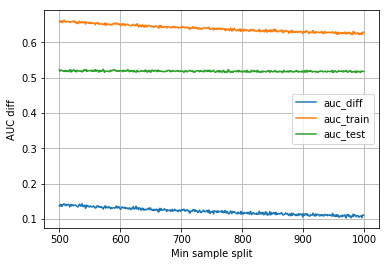

In [96]:
#Plot it
fig,ax = plt.subplots()
ax.plot(rf_min_sample_lim_df2['min_samples_split'],rf_min_sample_lim_df2['auc_diff'])
ax.plot(rf_min_sample_lim_df2['min_samples_split'],rf_min_sample_lim_df2['auc_train'])
ax.plot(rf_min_sample_lim_df2['min_samples_split'],rf_min_sample_lim_df2['auc_test'])
ax.set_xlabel('Min sample split')
ax.set_ylabel('AUC diff')
ax.grid(True)
ax.legend()
plt.show()

In [80]:
#Experiment with max_depth
rf_max_depth_df = pd.DataFrame([])
run_time = process_time()
for i in range(2,20):
    run_time.show_latest_lap_time()
    run_time.lap()
    print('\nRUN max_depth={}'.format(i))
    rf_mod = rfc(max_depth=i)
    rf_mod.fit(df_train[feature_cols],df_train[cat_cols])
    print('RUN ON TEST DF')
    pred_signal = rf_mod.predict(df_test[feature_cols])
    rf_max_depth_df = rf_max_depth_df.append(calc_tpr(pred_signal,df_test['signal'],{'max_depth':i,'train_test':'test'},df_test['signal'].unique()))
    print('RUN ON TRAIN DF')
    pred_signal = rf_mod.predict(df_train[feature_cols])
    rf_max_depth_df = rf_max_depth_df.append(calc_tpr(pred_signal,df_train['signal'],{'max_depth':i,'train_test':'train'},df_train['signal'].unique()))
print('\n\n')
run_time.end()
rf_max_depth_df


RUN max_depth=2


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:25980.0000, false_pos:29244.0000, acc:0.5243,ppv:0.4704,npv:0.6159,auc:0.5409
hold -> true_pos:1355.0000, false_pos:1602.0000, acc:0.7264,ppv:0.4582,npv:0.7357,auc:0.5160
buy -> true_pos:9698.0000, false_pos:19811.0000, acc:0.5940,ppv:0.3286,npv:0.7285,auc:0.5309
RUN ON TRAIN DF
buy -> true_pos:31425.0000, false_pos:46960.0000, acc:0.5159,ppv:0.4009,npv:0.7122,auc:0.5572
hold -> true_pos:5501.0000, false_pos:6298.0000, acc:0.7131,ppv:0.4662,npv:0.7390,auc:0.5437
sell -> true_pos:15817.0000, false_pos:18294.0000, acc:0.6197,ppv:0.4637,npv:0.6787,auc:0.5615
LAP 1 TIME -> 0:0:0

RUN max_depth=3


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:28533.0000, false_pos:32982.0000, acc:0.5108,ppv:0.4638,npv:0.6211,auc:0.5361
hold -> true_pos:1239.0000, false_pos:1306.0000, acc:0.7284,ppv:0.4868,npv:0.7357,auc:0.5159
buy -> true_pos:7696.0000, false_pos:15934.0000, acc:0.6153,ppv:0.3257,npv:0.7222,auc:0.5229
RUN ON TRAIN DF
buy -> true_pos:31595.0000, false_pos:46138.0000, acc:0.5239,ppv:0.4065,npv:0.7199,auc:0.5643
hold -> true_pos:5085.0000, false_pos:5014.0000, acc:0.7201,ppv:0.5035,npv:0.7393,auc:0.5449
sell -> true_pos:17194.0000, false_pos:19269.0000, acc:0.6229,ppv:0.4715,npv:0.6857,auc:0.5707
LAP 2 TIME -> 0:0:4

RUN max_depth=4


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:31068.0000, false_pos:36749.0000, acc:0.4967,ppv:0.4581,npv:0.6285,auc:0.5308
hold -> true_pos:1522.0000, false_pos:1597.0000, acc:0.7283,ppv:0.4880,npv:0.7372,auc:0.5196
buy -> true_pos:5497.0000, false_pos:11257.0000, acc:0.6436,ppv:0.3281,npv:0.7181,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:29651.0000, false_pos:42930.0000, acc:0.5340,ppv:0.4085,npv:0.7102,auc:0.5626
hold -> true_pos:6180.0000, false_pos:6458.0000, acc:0.7173,ppv:0.4890,npv:0.7431,auc:0.5525
sell -> true_pos:17993.0000, false_pos:21083.0000, acc:0.6147,ppv:0.4605,npv:0.6855,auc:0.5682
LAP 3 TIME -> 0:0:5

RUN max_depth=5


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30431.0000, false_pos:36004.0000, acc:0.4980,ppv:0.4581,npv:0.6227,auc:0.5301
hold -> true_pos:1687.0000, false_pos:1842.0000, acc:0.7274,ppv:0.4780,npv:0.7379,auc:0.5211
buy -> true_pos:5780.0000, false_pos:11946.0000, acc:0.6390,ppv:0.3261,npv:0.7182,auc:0.5173
RUN ON TRAIN DF
buy -> true_pos:27239.0000, false_pos:37675.0000, acc:0.5569,ppv:0.4196,npv:0.7070,auc:0.5686
hold -> true_pos:7013.0000, false_pos:7060.0000, acc:0.7192,ppv:0.4983,npv:0.7474,auc:0.5611
sell -> true_pos:20829.0000, false_pos:24479.0000, acc:0.6102,ppv:0.4597,npv:0.6966,auc:0.5785
LAP 4 TIME -> 0:0:6

RUN max_depth=6


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30466.0000, false_pos:35949.0000, acc:0.4990,ppv:0.4587,npv:0.6247,auc:0.5311
hold -> true_pos:1682.0000, false_pos:1856.0000, acc:0.7272,ppv:0.4754,npv:0.7378,auc:0.5209
buy -> true_pos:5745.0000, false_pos:11992.0000, acc:0.6380,ppv:0.3239,npv:0.7177,auc:0.5163
RUN ON TRAIN DF
buy -> true_pos:27643.0000, false_pos:37672.0000, acc:0.5602,ppv:0.4232,npv:0.7118,auc:0.5732
hold -> true_pos:7345.0000, false_pos:7192.0000, acc:0.7208,ppv:0.5053,npv:0.7493,auc:0.5651
sell -> true_pos:20774.0000, false_pos:23669.0000, acc:0.6163,ppv:0.4674,npv:0.6992,auc:0.5830
LAP 5 TIME -> 0:0:6

RUN max_depth=7


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:31172.0000, false_pos:36909.0000, acc:0.4961,ppv:0.4579,npv:0.6288,auc:0.5306
hold -> true_pos:1806.0000, false_pos:1963.0000, acc:0.7274,ppv:0.4792,npv:0.7386,auc:0.5227
buy -> true_pos:5147.0000, false_pos:10693.0000, acc:0.6460,ppv:0.3249,npv:0.7168,auc:0.5150
RUN ON TRAIN DF
buy -> true_pos:28302.0000, false_pos:37381.0000, acc:0.5678,ppv:0.4309,npv:0.7213,auc:0.5824
hold -> true_pos:8001.0000, false_pos:7410.0000, acc:0.7243,ppv:0.5192,npv:0.7533,auc:0.5733
sell -> true_pos:20753.0000, false_pos:22448.0000, acc:0.6260,ppv:0.4804,npv:0.7035,auc:0.5905
LAP 6 TIME -> 0:0:7

RUN max_depth=8


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:30067.0000, false_pos:35516.0000, acc:0.4994,ppv:0.4585,npv:0.6208,auc:0.5303
hold -> true_pos:1834.0000, false_pos:1972.0000, acc:0.7276,ppv:0.4819,npv:0.7388,auc:0.5232
buy -> true_pos:5884.0000, false_pos:12417.0000, acc:0.6348,ppv:0.3215,npv:0.7174,auc:0.5156
RUN ON TRAIN DF
buy -> true_pos:29287.0000, false_pos:37436.0000, acc:0.5753,ppv:0.4389,npv:0.7333,auc:0.5931
hold -> true_pos:8187.0000, false_pos:6942.0000, acc:0.7296,ppv:0.5411,npv:0.7557,auc:0.5786
sell -> true_pos:21095.0000, false_pos:21348.0000, acc:0.6376,ppv:0.4970,npv:0.7104,auc:0.6012
LAP 7 TIME -> 0:0:8

RUN max_depth=9


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29784.0000, false_pos:35181.0000, acc:0.5000,ppv:0.4585,npv:0.6187,auc:0.5301
hold -> true_pos:1947.0000, false_pos:2188.0000, acc:0.7264,ppv:0.4709,npv:0.7391,auc:0.5239
buy -> true_pos:6022.0000, false_pos:12568.0000, acc:0.6346,ppv:0.3239,npv:0.7182,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:29740.0000, false_pos:35362.0000, acc:0.5956,ppv:0.4568,npv:0.7483,auc:0.6111
hold -> true_pos:9034.0000, false_pos:6817.0000, acc:0.7374,ppv:0.5699,npv:0.7618,auc:0.5915
sell -> true_pos:22427.0000, false_pos:20915.0000, acc:0.6518,ppv:0.5174,npv:0.7237,auc:0.6188
LAP 8 TIME -> 0:0:9

RUN max_depth=10


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29906.0000, false_pos:35159.0000, acc:0.5016,ppv:0.4596,npv:0.6224,auc:0.5319
hold -> true_pos:1997.0000, false_pos:2466.0000, acc:0.7238,ppv:0.4475,npv:0.7387,auc:0.5228
buy -> true_pos:5857.0000, false_pos:12305.0000, acc:0.6358,ppv:0.3225,npv:0.7176,auc:0.5160
RUN ON TRAIN DF
buy -> true_pos:30987.0000, false_pos:33632.0000, acc:0.6196,ppv:0.4795,npv:0.7712,auc:0.6360
hold -> true_pos:9870.0000, false_pos:6007.0000, acc:0.7506,ppv:0.6217,npv:0.7695,auc:0.6080
sell -> true_pos:23924.0000, false_pos:19875.0000, acc:0.6722,ppv:0.5462,npv:0.7407,auc:0.6420
LAP 9 TIME -> 0:0:10

RUN max_depth=11


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:29212.0000, false_pos:34127.0000, acc:0.5055,ppv:0.4612,npv:0.6206,auc:0.5333
hold -> true_pos:2057.0000, false_pos:2551.0000, acc:0.7236,ppv:0.4464,npv:0.7389,auc:0.5234
buy -> true_pos:6357.0000, false_pos:13386.0000, acc:0.6291,ppv:0.3220,npv:0.7184,auc:0.5171
RUN ON TRAIN DF
buy -> true_pos:32107.0000, false_pos:31679.0000, acc:0.6443,ppv:0.5034,npv:0.7929,auc:0.6608
hold -> true_pos:10801.0000, false_pos:5553.0000, acc:0.7618,ppv:0.6605,npv:0.7771,auc:0.6239
sell -> true_pos:25580.0000, false_pos:18575.0000, acc:0.6960,ppv:0.5793,npv:0.7602,auc:0.6687
LAP 10 TIME -> 0:0:10

RUN max_depth=12


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:28440.0000, false_pos:33101.0000, acc:0.5084,ppv:0.4621,npv:0.6172,auc:0.5337
hold -> true_pos:2290.0000, false_pos:3167.0000, acc:0.7192,ppv:0.4196,npv:0.7391,auc:0.5235
buy -> true_pos:6698.0000, false_pos:13994.0000, acc:0.6261,ppv:0.3237,npv:0.7195,auc:0.5189
RUN ON TRAIN DF
buy -> true_pos:33975.0000, false_pos:30309.0000, acc:0.6704,ppv:0.5285,npv:0.8223,auc:0.6903
hold -> true_pos:12164.0000, false_pos:4758.0000, acc:0.7791,ppv:0.7188,npv:0.7886,auc:0.6479
sell -> true_pos:26837.0000, false_pos:16252.0000, acc:0.7248,ppv:0.6228,npv:0.7788,auc:0.6973
LAP 11 TIME -> 0:0:11

RUN max_depth=13


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:27772.0000, false_pos:32005.0000, acc:0.5133,ppv:0.4646,npv:0.6175,auc:0.5362
hold -> true_pos:2407.0000, false_pos:3597.0000, acc:0.7156,ppv:0.4009,npv:0.7388,auc:0.5226
buy -> true_pos:7219.0000, false_pos:14690.0000, acc:0.6241,ppv:0.3295,npv:0.7222,auc:0.5235
RUN ON TRAIN DF
buy -> true_pos:35142.0000, false_pos:27189.0000, acc:0.7048,ppv:0.5638,npv:0.8467,auc:0.7230
hold -> true_pos:13673.0000, false_pos:4243.0000, acc:0.7954,ppv:0.7632,npv:0.8008,auc:0.6724
sell -> true_pos:29098.0000, false_pos:14950.0000, acc:0.7534,ppv:0.6606,npv:0.8044,auc:0.7308
LAP 12 TIME -> 0:0:11

RUN max_depth=14


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:27746.0000, false_pos:31895.0000, acc:0.5142,ppv:0.4652,npv:0.6184,auc:0.5369
hold -> true_pos:2438.0000, false_pos:3744.0000, acc:0.7143,ppv:0.3944,npv:0.7386,auc:0.5221
buy -> true_pos:7103.0000, false_pos:14764.0000, acc:0.6219,ppv:0.3248,npv:0.7206,auc:0.5206
RUN ON TRAIN DF
buy -> true_pos:36907.0000, false_pos:22575.0000, acc:0.7562,ppv:0.6205,npv:0.8807,auc:0.7717
hold -> true_pos:15690.0000, false_pos:3060.0000, acc:0.8212,ppv:0.8368,npv:0.8184,auc:0.7079
sell -> true_pos:32506.0000, false_pos:13557.0000, acc:0.7921,ppv:0.7057,npv:0.8429,auc:0.7776
LAP 13 TIME -> 0:0:12

RUN max_depth=15


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:26730.0000, false_pos:30589.0000, acc:0.5175,ppv:0.4663,npv:0.6141,auc:0.5370
hold -> true_pos:2671.0000, false_pos:4399.0000, acc:0.7095,ppv:0.3778,npv:0.7386,auc:0.5218
buy -> true_pos:7587.0000, false_pos:15714.0000, acc:0.6166,ppv:0.3256,npv:0.7219,auc:0.5225
RUN ON TRAIN DF
buy -> true_pos:38643.0000, false_pos:20811.0000, acc:0.7843,ppv:0.6500,npv:0.9075,auc:0.8022
hold -> true_pos:17281.0000, false_pos:2512.0000, acc:0.8384,ppv:0.8731,npv:0.8318,auc:0.7338
sell -> true_pos:33987.0000, false_pos:11061.0000, acc:0.8240,ppv:0.7545,npv:0.8636,auc:0.8098
LAP 14 TIME -> 0:0:13

RUN max_depth=16


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:26182.0000, false_pos:29796.0000, acc:0.5203,ppv:0.4677,npv:0.6131,auc:0.5379
hold -> true_pos:2837.0000, false_pos:4806.0000, acc:0.7067,ppv:0.3712,npv:0.7388,auc:0.5222
buy -> true_pos:7928.0000, false_pos:16141.0000, acc:0.6156,ppv:0.3294,npv:0.7239,auc:0.5257
RUN ON TRAIN DF
buy -> true_pos:39759.0000, false_pos:18069.0000, acc:0.8154,ppv:0.6875,npv:0.9266,auc:0.8319
hold -> true_pos:19361.0000, false_pos:2017.0000, acc:0.8591,ppv:0.9057,npv:0.8494,auc:0.7664
sell -> true_pos:35835.0000, false_pos:9254.0000, acc:0.8535,ppv:0.7948,npv:0.8869,auc:0.8418
LAP 15 TIME -> 0:0:14

RUN max_depth=17


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:25880.0000, false_pos:29454.0000, acc:0.5208,ppv:0.4677,npv:0.6115,auc:0.5375
hold -> true_pos:3165.0000, false_pos:5618.0000, acc:0.7012,ppv:0.3604,npv:0.7392,auc:0.5227
buy -> true_pos:7744.0000, false_pos:15829.0000, acc:0.6171,ppv:0.3285,npv:0.7232,auc:0.5246
RUN ON TRAIN DF
buy -> true_pos:40741.0000, false_pos:14659.0000, acc:0.8507,ppv:0.7354,npv:0.9434,auc:0.8643
hold -> true_pos:21717.0000, false_pos:1511.0000, acc:0.8821,ppv:0.9349,npv:0.8700,auc:0.8030
sell -> true_pos:37781.0000, false_pos:7886.0000, acc:0.8801,ppv:0.8273,npv:0.9108,auc:0.8721
LAP 16 TIME -> 0:0:14

RUN max_depth=18


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:25930.0000, false_pos:29461.0000, acc:0.5213,ppv:0.4681,npv:0.6124,auc:0.5380
hold -> true_pos:3183.0000, false_pos:5797.0000, acc:0.6994,ppv:0.3545,npv:0.7387,auc:0.5217
buy -> true_pos:7716.0000, false_pos:15603.0000, acc:0.6193,ppv:0.3309,npv:0.7238,auc:0.5259
RUN ON TRAIN DF
buy -> true_pos:41268.0000, false_pos:12926.0000, acc:0.8689,ppv:0.7615,npv:0.9519,auc:0.8811
hold -> true_pos:22821.0000, false_pos:1266.0000, acc:0.8930,ppv:0.9474,npv:0.8799,auc:0.8202
sell -> true_pos:38847.0000, false_pos:7167.0000, acc:0.8945,ppv:0.8442,npv:0.9240,auc:0.8885
LAP 17 TIME -> 0:0:15

RUN max_depth=19


C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RUN ON TEST DF
sell -> true_pos:25862.0000, false_pos:29529.0000, acc:0.5197,ppv:0.4669,npv:0.6103,auc:0.5365
hold -> true_pos:3366.0000, false_pos:6230.0000, acc:0.6965,ppv:0.3508,npv:0.7390,auc:0.5222
buy -> true_pos:7549.0000, false_pos:15154.0000, acc:0.6226,ppv:0.3325,npv:0.7239,auc:0.5262
RUN ON TRAIN DF
buy -> true_pos:42199.0000, false_pos:9612.0000, acc:0.9030,ppv:0.8145,npv:0.9663,auc:0.9123
hold -> true_pos:25424.0000, false_pos:1033.0000, acc:0.9158,ppv:0.9610,npv:0.9036,auc:0.8589
sell -> true_pos:40641.0000, false_pos:5386.0000, acc:0.9232,ppv:0.8830,npv:0.9469,auc:0.9197



TOTAL ELAPSED TIME -> 0:3:17


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,"{'max_depth': 2, 'train_test': 'test'}",2,sell,25980,29244,19996,12470,0.675683,0.593907,0.524302,0.470448,0.615906,0.540888
1,"{'max_depth': 2, 'train_test': 'test'}",2,hold,1355,1602,62341,22392,0.057060,0.025054,0.726377,0.458235,0.735735,0.516003
2,"{'max_depth': 2, 'train_test': 'test'}",2,buy,9698,19811,42386,15795,0.380418,0.318520,0.593956,0.328645,0.728520,0.530949
0,"{'max_depth': 2, 'train_test': 'train'}",2,buy,31425,46960,32696,13214,0.703981,0.589535,0.515878,0.400906,0.712176,0.557223
1,"{'max_depth': 2, 'train_test': 'train'}",2,hold,5501,6298,83137,29359,0.157803,0.070420,0.713126,0.466226,0.739022,0.543691
2,"{'max_depth': 2, 'train_test': 'train'}",2,sell,15817,18294,61205,28979,0.353090,0.230116,0.619671,0.463692,0.678668,0.561487
0,"{'max_depth': 3, 'train_test': 'test'}",2,sell,28533,32982,16258,9917,0.742081,0.669821,0.510788,0.463838,0.621127,0.536130
1,"{'max_depth': 3, 'train_test': 'test'}",2,hold,1239,1306,62637,22508,0.052175,0.020424,0.728430,0.486837,0.735651,0.515875
2,"{'max_depth': 3, 'train_test': 'test'}",2,buy,7696,15934,46263,17797,0.301887,0.256186,0.615338,0.325688,0.722182,0.522850
0,"{'max_depth': 3, 'train_test': 'train'}",2,buy,31595,46138,33518,13044,0.707789,0.579216,0.523859,0.406455,0.719857,0.564287


In [81]:
#Separate out train and test
rf_max_depth_df['train_test'] = [x['train_test'] for x in rf_max_depth_df['features']]
rf_max_depth_df['max_depth'] = [x['max_depth'] for x in rf_max_depth_df['features']]
rf_max_depth_df_test = rf_max_depth_df[rf_max_depth_df['train_test'] == 'test'].copy().reset_index()
rf_max_depth_df_train = rf_max_depth_df[rf_max_depth_df['train_test'] == 'train'].copy().reset_index()

In [82]:
#Form into a single dataset
rf_max_depth_df_test.rename(columns={'true_pos':'true_pos_test','false_pos':'false_pos_test','ppv':'ppv_test','auc':'auc_test'},inplace=True)
rf_max_depth_df_train.rename(columns={'true_pos':'true_pos_train','false_pos':'false_pos_train','ppv':'ppv_train','auc':'auc_train'},inplace=True)
rf_max_depth_df_test2 = pd.merge(rf_max_depth_df_train[['max_depth','signal','true_pos_train','false_pos_train','ppv_train','auc_train']],rf_max_depth_df_test[['max_depth','signal','true_pos_test','false_pos_test','ppv_test','auc_test']],left_on=['max_depth','signal'],right_on=['max_depth','signal'])
# rf_max_depth_df_test2 = rf_max_depth_df_test2.groupby(['max_depth']).mean().reset_index()
rf_max_depth_df_test2 = rf_max_depth_df_test2[rf_max_depth_df_test2['signal'] == 'buy'].reset_index()
rf_max_depth_df_test2['ppv_diff'] = abs(rf_max_depth_df_test2['ppv_train'] - rf_max_depth_df_test2['ppv_test'])
rf_max_depth_df_test2['auc_diff'] = abs(rf_max_depth_df_test2['auc_train'] - rf_max_depth_df_test2['auc_test'])
rf_max_depth_df_test2.sort_values(['auc_diff'],ascending=True)

,index,max_depth,signal,true_pos_train,false_pos_train,ppv_train,auc_train,true_pos_test,false_pos_test,ppv_test,auc_test,ppv_diff,auc_diff
0,0,2,buy,31425,46960,0.400906,0.557223,9698,19811,0.328645,0.530949,0.072260,0.026274
1,3,3,buy,31595,46138,0.406455,0.564287,7696,15934,0.325688,0.522850,0.080768,0.041436
2,6,4,buy,29651,42930,0.408523,0.562649,5497,11257,0.328101,0.517319,0.080422,0.045329
3,9,5,buy,27239,37675,0.419617,0.568618,5780,11946,0.326075,0.517331,0.093542,0.051287
4,12,6,buy,27643,37672,0.423226,0.573162,5745,11992,0.323899,0.516275,0.099327,0.056887
5,15,7,buy,28302,37381,0.430888,0.582370,5147,10693,0.324937,0.514989,0.105951,0.067381
6,18,8,buy,29287,37436,0.438934,0.593057,5884,12417,0.321512,0.515584,0.117422,0.077473
7,21,9,buy,29740,35362,0.456822,0.611150,6022,12568,0.323938,0.517077,0.132884,0.094073
8,24,10,buy,30987,33632,0.479534,0.635977,5857,12305,0.322487,0.515955,0.157047,0.120022
9,27,11,buy,32107,31679,0.503355,0.660781,6357,13386,0.321988,0.517072,0.181367,0.143709


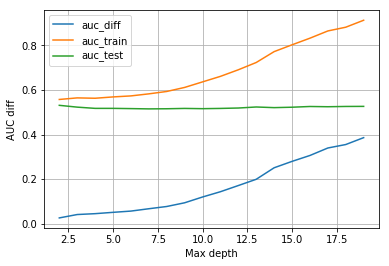

In [83]:
#Plot it
fig,ax = plt.subplots()
ax.plot(rf_max_depth_df_test2['max_depth'],rf_max_depth_df_test2['auc_diff'])
ax.plot(rf_max_depth_df_test2['max_depth'],rf_max_depth_df_test2['auc_train'])
ax.plot(rf_max_depth_df_test2['max_depth'],rf_max_depth_df_test2['auc_test'])
ax.set_xlabel('Max depth')
ax.set_ylabel('AUC diff')
ax.grid(True)
ax.legend()
plt.show()

I choose to use:
- Min sample split -> 150
- Max depth -> 2

# Train the final model

In [32]:
final_models = rfc(min_samples_split=150,max_depth=2)
rand_index = np.random.permutation(df_model.index.values)
df_model_rand = df_model.iloc[rand_index]
final_models.fit(df_model_rand[feature_cols],df_model_rand[cat_cols])

C:\Users\Robert\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=150,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
pred_signal = final_models.predict(df_test[feature_cols])
calc_tpr(pred_signal,df_test['signal'],['FINAL RF MODEL'],df_test['signal'].unique())    

buy -> true_pos:0.0000, false_pos:0.0000, acc:0.7525,ppv:0.0000,npv:0.7525,auc:0.5000
sell -> true_pos:37070.0000, false_pos:50985.0000, acc:0.4227,ppv:0.4210,npv:0.9715,auc:0.5026
hold -> true_pos:272.0000, false_pos:9.0000, acc:0.6702,ppv:0.9680,npv:0.6693,auc:0.5046


,features,feature_count,signal,true_pos,false_pos,true_neg,false_neg,tpr,fpr,acc,ppv,npv,auc
0,[FINAL RF MODEL],1,buy,0,0,66472,21864,0.000000,0.000000,0.752490,0.000000,0.752490,0.500000
1,[FINAL RF MODEL],1,sell,37070,50985,273,8,0.999784,0.994674,0.422738,0.420987,0.971530,0.502555
2,[FINAL RF MODEL],1,hold,272,9,58933,29122,0.009254,0.000153,0.670225,0.967972,0.669275,0.504550


# Exporting the model

In [34]:
#Import the modules
from sklearn.externals import joblib as jl

In [35]:
#Export the model
jl.dump(final_models,path+r'\random_forest_model.joblib')

['C:\\Users\\Robert\\Documents\\python_scripts\\stock_trading_ml_modelling\\historical_prices\\random_forest_model.joblib']

In [36]:
#Export a list of the features for this model
file_object = open(path+r'\random_forest_model_feature_list.txt','w')
feature_str = ''
for i in feature_cols:
    feature_str += '{},'.format(i)
feature_str = feature_str[:-1]
file_object.write(feature_str)
file_object.close()
feature_str

'open,close,high,low,volume,change_price,per_change_price,close_shift1,change_close_shift1,vol_shift1,change_vol_shift1,ema26_shift1,change_ema26_shift1,close_13_norm,close_26_norm,close_52_norm,macd_line_13_norm,macd_line_26_norm,macd_line_52_norm,macd_pos_val,macd_neg_val,signal_line_pos_val,signal_line_neg_val,change_price_pos_val,change_price_neg_val,per_change_price_pos_val,per_change_price_neg_val,prev_max_close,prev_min_close,prev_max_close_date_change,prev_min_close_date_change,max_change_close_pos_val,max_change_close_neg_val,min_change_close_pos_val,min_change_close_neg_val,prev_max_grad_close,prev_min_grad_close,max_move_cum_pos_close,max_move_cum_neg_close,min_move_cum_pos_close,min_move_cum_neg_close,long_prev_max_move_pos_date_close,long_prev_max_move_neg_date_close,long_prev_min_move_pos_date_close,long_prev_min_move_neg_date_close,long_max_grad_pos_close,long_max_grad_neg_close,long_min_grad_pos_close,long_min_grad_neg_close,prev_max_macd,prev_min_macd,prev_max_macd_dat